In [31]:
pd.read_csv("../exp1/interpol_baselines/spatial_gp_rmse.csv").mean(axis = 0).mean()

15.6242649228566

### TO DO
* Kriging and IDW
* Sequential Code
* No Notion of Last K Days

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

In [ ]:
from polire.interpolate import  Kriging, Idw
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
df = pd.read_csv("../data/beijinga_scaled.csv", index_col = 0)

In [4]:
df.head()

,latitude,longitude,Time,Station,PM2.5
0,0.58292,0.17557,0.000000,1001.0,156.250000
0,0.58292,0.17557,0.002747,1001.0,24.833333
0,0.58292,0.17557,0.005495,1001.0,72.583333
0,0.58292,0.17557,0.008242,1001.0,30.043478
0,0.58292,0.17557,0.010989,1001.0,23.083333


In [5]:
# for i in range(10):
df['PM2.5'].describe()

count    12542.000000
mean        85.948717
std         70.715368
min          3.000000
25%         33.958333
50%         67.362500
75%        116.199728
max        590.083333
Name: PM2.5, dtype: float64

(array([5.754e+03, 3.851e+03, 1.706e+03, 6.820e+02, 3.020e+02, 1.690e+02,
        4.800e+01, 2.000e+01, 9.000e+00, 1.000e+00]),
 array([  3.        ,  61.70833333, 120.41666667, 179.125     ,
        237.83333333, 296.54166667, 355.25      , 413.95833333,
        472.66666667, 531.375     , 590.08333333]),
 <a list of 10 Patch objects>)

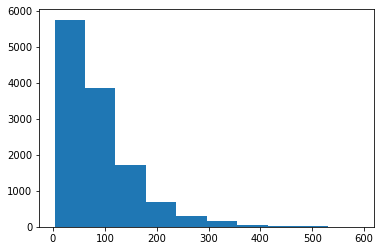

In [6]:
import matplotlib.pyplot as plt
plt.hist(df['PM2.5'])

In [7]:
timestamps = df['Time'].unique()
timestamps.sort()
stations = df['Station'].unique()

In [8]:
stations.sort()

In [9]:
kf = KFold(n_splits=6, random_state=0, shuffle=True)

In [10]:
df.head()

,latitude,longitude,Time,Station,PM2.5
0,0.58292,0.17557,0.000000,1001.0,156.250000
0,0.58292,0.17557,0.002747,1001.0,24.833333
0,0.58292,0.17557,0.005495,1001.0,72.583333
0,0.58292,0.17557,0.008242,1001.0,30.043478
0,0.58292,0.17557,0.010989,1001.0,23.083333


In [11]:
for train_index, test_index in kf.split(stations):
    print(train_index, test_index)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 17 18 19 21 23 24 25 26 27
 28 29 32 33 34 35] [15 16 20 22 30 31]
[ 0  1  3  4  5  6  7  8  9 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 28 30 31 32 33 34] [ 2 10 11 27 29 35]
[ 0  1  2  3  4  6  7  9 10 11 12 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 29 30 31 34 35] [ 5  8 13 28 32 33]
[ 0  2  3  4  5  6  8  9 10 11 13 15 16 18 19 20 21 22 23 24 25 27 28 29
 30 31 32 33 34 35] [ 1  7 12 14 17 26]
[ 0  1  2  3  5  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 26 27 28 29
 30 31 32 33 34 35] [ 4  6 18 23 24 25]
[ 1  2  4  5  6  7  8 10 11 12 13 14 15 16 17 18 20 22 23 24 25 26 27 28
 29 30 31 32 33 35] [ 0  3  9 19 21 34]


In [12]:
from sklearn.neighbors import KNeighborsRegressor

In [13]:
import gpflow
# /import tensorflow as tf

In [14]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)


In [22]:
rmse = {'K':{timestamp:{i:0 for i in range(6)} for timestamp in timestamps}, 'I':{timestamp:{i:0 for i in range(6)} for timestamp in timestamps},'KNN':{timestamp:{i:0 for i in range(6)} for timestamp in timestamps},
       'GP':{timestamp:{i:0 for i in range(6)} for timestamp in timestamps}}
mae = {'K':{timestamp:{i:0 for i in range(6)} for timestamp in timestamps}, 'I':{timestamp:{i:0 for i in range(6)} for timestamp in timestamps},'KNN':{timestamp:{i:0 for i in range(6)} for timestamp in timestamps},
      'GP':{timestamp:{i:0 for i in range(6)} for timestamp in timestamps}}


for timestamp in timestamps:
    
    print("TIMESTAMP", timestamp)
    i = -1 
    for train_index, test_index in kf.split(stations):
        i = i + 1
        train_stations = stations[train_index]
        test_stations = stations[test_index]
        try:
            train_df = pd.concat([df.groupby('Station').get_group(stn) for stn in train_stations])
            train_df = train_df.groupby('Time').get_group(timestamp)
            train_df.drop(columns = ['Station', 'Time'])
            test_df = pd.concat([df.groupby('Station').get_group(stn) for stn in test_stations])
            test_df = test_df.groupby('Time').get_group(timestamp)
            test_df.drop(columns = ['Station', 'Time'])

        except KeyError:
            print("FAIL")
            continue
        
        idw = Idw()
        krig = Kriging()
# #         knn = KNeighborsRegressor(n_neighbors=6)
        
        X_train = np.array( train_df[['longitude', 'latitude']] )
        y_train = np.array( train_df[['PM2.5']] )
        X_test = np.array( test_df[['longitude', 'latitude']] )
        y_test = np.array( test_df[['PM2.5']] )
        
        idw._fit(X_train, y_train)
        krig.fit(X_train, y_train)
#         knn.fit(X_train, y_train)

        

        
        try:
            idw_res = idw._predict(X_test)
            krig_res = krig.predict(X_test)
#             knn_res = knn.predict(X_test)
        
            idw_rms_error = np.sqrt(mean_squared_error(idw_res, y_test))
            krig_rms_error = np.sqrt(mean_squared_error(krig_res, y_test))
            idw_mae_error = mean_absolute_error(idw_res, y_test)
            krig_mae_error = mean_absolute_error(krig_res, y_test)
#             knn_rms_error = np.sqrt(mean_squared_error(knn_res, y_test))
#             knn_mae_error = mean_absolute_error(knn_res, y_test)
            
            

            tf.reset_default_graph()
            graph = tf.get_default_graph()
            gpflow.reset_default_session(graph=graph)


            xy_matern_1 = gpflow.kernels.Matern52(input_dim=2, ARD=True, active_dims=[0, 1])
            xy_matern_2 = gpflow.kernels.Matern52(input_dim=2, ARD=True, active_dims=[0, 1])
            xy_rbf_3 = gpflow.kernels.RBF(input_dim = 2, ARD=True, active_dims=[0, 1])


#             kernel = gpflow.kernels.Linear(input_dim = 2, active_dims = [0, 1], ARD = True)
            kernel = xy_matern_1 + xy_matern_2 + xy_rbf_3

            model = gpflow.models.GPR(X_train, y_train, kern=kernel, mean_function=None)
            opt = gpflow.train.ScipyOptimizer()
            opt.minimize(model)

            mean, var = model.predict_y(X_test)
            
            gp_rms_error = np.sqrt(mean_squared_error(mean, y_test))
            gp_mae_error = mean_absolute_error(mean, y_test)

            
        except Exception as e:
            print("NO")
                  
            print(e)
            continue
            
        print("GP = ", gp_rms_error, "\nKrig = ", krig_rms_error, "\nIDW = ", idw_rms_error)
        
        rmse['K'][timestamp][i] = krig_rms_error
        rmse['I'][timestamp][i] = idw_rms_error
#         rmse['KNN'][timestamp][i] = knn_rms_error
        rmse['GP'][timestamp][i] = gp_rms_error
        
        mae['K'][timestamp][i] = krig_mae_error
        mae['I'][timestamp][i] = idw_mae_error
#         mae['KNN'][timestamp][i] = knn_rms_error
        mae['GP'][timestamp][i] = gp_mae_error
        
        

TIMESTAMP 0.0
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 122.849609
  Number of iterations: 90
  Number of functions evaluations: 133


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 122.849609
  Number of iterations: 90
  Number of functions evaluations: 133


GP =  14.096563245635227 
Krig =  15.495729222185059 
IDW =  13.694027266679091
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 124.835091
  Number of iterations: 71
  Number of functions evaluations: 90


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 124.835091
  Number of iterations: 71
  Number of functions evaluations: 90


GP =  9.508312646375831 
Krig =  9.074283869283365 
IDW =  11.425422614088795
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 124.168651
  Number of iterations: 51
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 124.168651
  Number of iterations: 51
  Number of functions evaluations: 70


GP =  11.476532914914424 
Krig =  14.958943888128925 
IDW =  12.291023765884143
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 124.389879
  Number of iterations: 52
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 124.389879
  Number of iterations: 52
  Number of functions evaluations: 64


GP =  10.816097933925999 
Krig =  12.849246425403214 
IDW =  10.338158374002735
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123.951801
  Number of iterations: 52
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123.951801
  Number of iterations: 52
  Number of functions evaluations: 71


GP =  11.55560098681144 
Krig =  13.43013987627464 
IDW =  11.219503438564022
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 121.142846
  Number of iterations: 55
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 121.142846
  Number of iterations: 55
  Number of functions evaluations: 76


GP =  17.18984298622112 
Krig =  23.996136717386452 
IDW =  21.376932241630087
TIMESTAMP 0.0027472527472527475
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.679198
  Number of iterations: 62
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.679198
  Number of iterations: 62
  Number of functions evaluations: 73


GP =  7.35067021302075 
Krig =  5.762826213006539 
IDW =  7.880223449250767
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 106.415462
  Number of iterations: 49
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 106.415462
  Number of iterations: 49
  Number of functions evaluations: 65


GP =  11.816402394003822 
Krig =  12.244261100445206 
IDW =  11.665377512876292
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.212068
  Number of iterations: 52
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.212068
  Number of iterations: 52
  Number of functions evaluations: 64


GP =  8.134568917536571 
Krig =  8.022479432871844 
IDW =  10.52226030171593
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 110.044774
  Number of iterations: 55
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 110.044774
  Number of iterations: 55
  Number of functions evaluations: 72


GP =  8.876916709830327 
Krig =  8.732768847993398 
IDW =  8.760199273809027
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.574700
  Number of iterations: 62
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.574700
  Number of iterations: 62
  Number of functions evaluations: 76


GP =  9.471958678964398 
Krig =  9.640911399161178 
IDW =  8.268696220263
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 110.828449
  Number of iterations: 64
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 110.828449
  Number of iterations: 64
  Number of functions evaluations: 80


GP =  7.439926786108909 
Krig =  7.551736466610651 
IDW =  8.032862118125095
TIMESTAMP 0.005494505494505495
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.244495
  Number of iterations: 215
  Number of functions evaluations: 280


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.244495
  Number of iterations: 215
  Number of functions evaluations: 280


GP =  18.169742359673823 
Krig =  23.986664872699095 
IDW =  19.57469104079611
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 131.476835
  Number of iterations: 37
  Number of functions evaluations: 52


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 131.476835
  Number of iterations: 37
  Number of functions evaluations: 52


GP =  7.543343012727077 
Krig =  11.964510724874488 
IDW =  12.2059219828357
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.421406
  Number of iterations: 50
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.421406
  Number of iterations: 50
  Number of functions evaluations: 59


GP =  9.086279258383275 
Krig =  12.513485272784802 
IDW =  12.731505856307471
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 126.690067
  Number of iterations: 58
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 126.690067
  Number of iterations: 58
  Number of functions evaluations: 78


GP =  12.916676117263169 
Krig =  13.33584303759375 
IDW =  16.702526865780236
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.408666
  Number of iterations: 51
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.408666
  Number of iterations: 51
  Number of functions evaluations: 64


GP =  18.707670925956783 
Krig =  21.894168264094493 
IDW =  18.779053709670816
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.985384
  Number of iterations: 76
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.985384
  Number of iterations: 76
  Number of functions evaluations: 100


GP =  23.321563341876153 
Krig =  23.115498444172662 
IDW =  25.400089772615672
TIMESTAMP 0.008241758241758242
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.685238
  Number of iterations: 56
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.685238
  Number of iterations: 56
  Number of functions evaluations: 70


GP =  4.256590400437836 
Krig =  6.308537954036277 
IDW =  4.881190153368634
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.289016
  Number of iterations: 79
  Number of functions evaluations: 92


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.289016
  Number of iterations: 79
  Number of functions evaluations: 92


GP =  8.245337068290366 
Krig =  8.949689609724064 
IDW =  8.692602787981219
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.155893
  Number of iterations: 46
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.155893
  Number of iterations: 46
  Number of functions evaluations: 64


GP =  3.5428589658985055 
Krig =  3.502849460468037 
IDW =  3.5461009295495898
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 101.725003
  Number of iterations: 69
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 101.725003
  Number of iterations: 69
  Number of functions evaluations: 83


GP =  7.059766236558599 
Krig =  7.911797300044569 
IDW =  7.3115960723845825
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 102.475456
  Number of iterations: 55
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 102.475456
  Number of iterations: 55
  Number of functions evaluations: 64


GP =  6.1123060654626755 
Krig =  6.52282846798471 
IDW =  5.828019223258555
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 99.859756
  Number of iterations: 53
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 99.859756
  Number of iterations: 53
  Number of functions evaluations: 62


GP =  8.454987709745204 
Krig =  8.264351792758092 
IDW =  9.325783793869427
TIMESTAMP 0.01098901098901099
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.359711
  Number of iterations: 65
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.359711
  Number of iterations: 65
  Number of functions evaluations: 83


GP =  4.98703267471794 
Krig =  9.254345115219625 
IDW =  7.209514380886975
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 111.031922
  Number of iterations: 53
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 111.031922
  Number of iterations: 53
  Number of functions evaluations: 62


GP =  12.39809444478584 
Krig =  12.233324611155293 
IDW =  11.391540956280599
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.624371
  Number of iterations: 33
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.624371
  Number of iterations: 33
  Number of functions evaluations: 42


GP =  4.476780997270809 
Krig =  4.43363328946168 
IDW =  9.030150061843576
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.050264
  Number of iterations: 62
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.050264
  Number of iterations: 62
  Number of functions evaluations: 77


GP =  11.130800305292272 
Krig =  11.509603922634321 
IDW =  13.441728954926955
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.442741
  Number of iterations: 65
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.442741
  Number of iterations: 65
  Number of functions evaluations: 76


GP =  9.51911798224501 
Krig =  10.110050976636337 
IDW =  10.630757045976159
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.975238
  Number of iterations: 63
  Number of functions evaluations: 96


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.975238
  Number of iterations: 63
  Number of functions evaluations: 96


GP =  9.939215018730666 
Krig =  9.745907917957087 
IDW =  8.558029537913185
TIMESTAMP 0.013736263736263736
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 117.714044
  Number of iterations: 150
  Number of functions evaluations: 206


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 117.714044
  Number of iterations: 150
  Number of functions evaluations: 206


GP =  10.188013915725351 
Krig =  9.101310641344604 
IDW =  12.656147632386228
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.950425
  Number of iterations: 41
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.950425
  Number of iterations: 41
  Number of functions evaluations: 47


GP =  18.80237042846284 
Krig =  16.813720061273443 
IDW =  18.016188478077797
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.904343
  Number of iterations: 97
  Number of functions evaluations: 117


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.904343
  Number of iterations: 97
  Number of functions evaluations: 117


GP =  10.789747149443508 
Krig =  16.35475239609204 
IDW =  13.714950583481667
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.348355
  Number of iterations: 95
  Number of functions evaluations: 127


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.348355
  Number of iterations: 95
  Number of functions evaluations: 127


GP =  16.481426194397592 
Krig =  16.656530693963013 
IDW =  14.073787398165575
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.593740
  Number of iterations: 65
  Number of functions evaluations: 91


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.593740
  Number of iterations: 65
  Number of functions evaluations: 91


GP =  10.76329418039148 
Krig =  9.616243394343103 
IDW =  8.647893360062552
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 119.838124
  Number of iterations: 43
  Number of functions evaluations: 46


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 119.838124
  Number of iterations: 43
  Number of functions evaluations: 46


GP =  6.07660495186078 
Krig =  5.9434096994227605 
IDW =  6.724114781683178
TIMESTAMP 0.019230769230769232
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 120.016296
  Number of iterations: 56
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 120.016296
  Number of iterations: 56
  Number of functions evaluations: 80


GP =  13.328281019062706 
Krig =  11.430781952440748 
IDW =  11.13726461201922
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 120.529052
  Number of iterations: 41
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 120.529052
  Number of iterations: 41
  Number of functions evaluations: 45


GP =  13.496167470604377 
Krig =  13.476591360578489 
IDW =  11.651725076719066
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 122.530062
  Number of iterations: 40
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 122.530062
  Number of iterations: 40
  Number of functions evaluations: 42


GP =  8.790335314324524 
Krig =  8.793052426331528 
IDW =  11.147639469116081
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 121.004209
  Number of iterations: 43
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 121.004209
  Number of iterations: 43
  Number of functions evaluations: 51


GP =  12.54989649803726 
Krig =  12.540551855949918 
IDW =  12.424233433497852
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 119.954878
  Number of iterations: 40
  Number of functions evaluations: 44


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 119.954878
  Number of iterations: 40
  Number of functions evaluations: 44


GP =  14.453585947170076 
Krig =  14.46883306752669 
IDW =  11.229590741078836
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 121.463046
  Number of iterations: 56
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 121.463046
  Number of iterations: 56
  Number of functions evaluations: 65


GP =  11.731153926663044 
Krig =  11.761586507074016 
IDW =  14.334088418188081
TIMESTAMP 0.02197802197802198
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.644463
  Number of iterations: 39
  Number of functions evaluations: 50


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.644463
  Number of iterations: 39
  Number of functions evaluations: 50


GP =  3.304349274509034 
Krig =  3.3511970396938535 
IDW =  4.680942529580192
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 98.497051
  Number of iterations: 54
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 98.497051
  Number of iterations: 54
  Number of functions evaluations: 61


GP =  6.483942323314197 
Krig =  6.879788297950492 
IDW =  8.649875783404703
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 99.151366
  Number of iterations: 94
  Number of functions evaluations: 120


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 99.151366
  Number of iterations: 94
  Number of functions evaluations: 120


GP =  5.0972004049850765 
Krig =  4.505644028052953 
IDW =  4.716941492863202
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.151525
  Number of iterations: 38
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.151525
  Number of iterations: 38
  Number of functions evaluations: 47


GP =  2.779340773584867 
Krig =  4.45366022523701 
IDW =  3.814024083415594
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.662257
  Number of iterations: 36
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.662257
  Number of iterations: 36
  Number of functions evaluations: 38


GP =  6.346106545059813 
Krig =  6.8369044357952875 
IDW =  6.373765666598196
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 94.838173
  Number of iterations: 39
  Number of functions evaluations: 44


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 94.838173
  Number of iterations: 39
  Number of functions evaluations: 44


GP =  8.432082333574913 
Krig =  8.072913171831871 
IDW =  7.008732830807782
TIMESTAMP 0.024725274725274724
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 86.238529
  Number of iterations: 61
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 86.238529
  Number of iterations: 61
  Number of functions evaluations: 77


GP =  3.8863254484091407 
Krig =  3.7032446493035516 
IDW =  4.952334998802765
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 88.346499
  Number of iterations: 108
  Number of functions evaluations: 142


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 88.346499
  Number of iterations: 108
  Number of functions evaluations: 142


GP =  2.569498951830457 
Krig =  2.627141801753166 
IDW =  3.215940879210668
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 86.639539
  Number of iterations: 48
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 86.639539
  Number of iterations: 48
  Number of functions evaluations: 57


GP =  4.239024574288607 
Krig =  4.062419089595207 
IDW =  3.5925584329068454
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 87.071035
  Number of iterations: 120
  Number of functions evaluations: 152


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 87.071035
  Number of iterations: 120
  Number of functions evaluations: 152


GP =  3.6486673158900986 
Krig =  4.632183424790463 
IDW =  3.8779826992505484
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 89.572366
  Number of iterations: 62
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 89.572366
  Number of iterations: 62
  Number of functions evaluations: 82


GP =  3.7853795915610498 
Krig =  4.604628448146763 
IDW =  4.654432342062106
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 83.688100
  Number of iterations: 35
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 83.688100
  Number of iterations: 35
  Number of functions evaluations: 38


GP =  5.863043367309466 
Krig =  6.608240032084743 
IDW =  5.48725483216344
TIMESTAMP 0.027472527472527472
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.744450
  Number of iterations: 56
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.744450
  Number of iterations: 56
  Number of functions evaluations: 77


GP =  1.8876127345666502 
Krig =  2.59613418970348 
IDW =  1.9801948627065722
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 75.468675
  Number of iterations: 52
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 75.468675
  Number of iterations: 52
  Number of functions evaluations: 61


GP =  2.405766883877516 
Krig =  2.906484062293945 
IDW =  2.583547839857282
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.768451
  Number of iterations: 73
  Number of functions evaluations: 95


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.768451
  Number of iterations: 73
  Number of functions evaluations: 95


GP =  1.7900299936282382 
Krig =  2.0826566832823667 
IDW =  1.82905440415738
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 68.950501
  Number of iterations: 75
  Number of functions evaluations: 98


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 68.950501
  Number of iterations: 75
  Number of functions evaluations: 98


GP =  4.293537825023922 
Krig =  4.149059891435373 
IDW =  4.839803475834666
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 78.580032
  Number of iterations: 57
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 78.580032
  Number of iterations: 57
  Number of functions evaluations: 74


GP =  1.2074856277672414 
Krig =  1.3020632178901874 
IDW =  0.8812665223586231
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 71.612492
  Number of iterations: 78
  Number of functions evaluations: 106


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 71.612492
  Number of iterations: 78
  Number of functions evaluations: 106


GP =  3.6503778373718694 
Krig =  3.6366381969272057 
IDW =  3.989382230500512
TIMESTAMP 0.03021978021978022
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 93.181032
  Number of iterations: 43
  Number of functions evaluations: 49


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 93.181032
  Number of iterations: 43
  Number of functions evaluations: 49


GP =  4.769430667971775 
Krig =  6.40039295855376 
IDW =  6.331448232041607
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 94.726999
  Number of iterations: 53
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 94.726999
  Number of iterations: 53
  Number of functions evaluations: 64


GP =  3.2742613607453115 
Krig =  3.104734443569102 
IDW =  3.509053186362594
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 94.063773
  Number of iterations: 108
  Number of functions evaluations: 137


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 94.063773
  Number of iterations: 108
  Number of functions evaluations: 137


GP =  3.931066753549851 
Krig =  7.71662328739138 
IDW =  4.803294993552331
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 88.158681
  Number of iterations: 69
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 88.158681
  Number of iterations: 69
  Number of functions evaluations: 83


GP =  7.543928279127727 
Krig =  7.3142173230652086 
IDW =  8.005924995746918
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.789124
  Number of iterations: 79
  Number of functions evaluations: 102


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.789124
  Number of iterations: 79
  Number of functions evaluations: 102


GP =  4.004671788110104 
Krig =  3.416739296839975 
IDW =  3.49036319267594
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 91.452235
  Number of iterations: 52
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 91.452235
  Number of iterations: 52
  Number of functions evaluations: 75


GP =  6.092794292438617 
Krig =  6.031034630982792 
IDW =  6.230731148708332
TIMESTAMP 0.03296703296703297
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.863414
  Number of iterations: 85
  Number of functions evaluations: 117


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.863414
  Number of iterations: 85
  Number of functions evaluations: 117


GP =  9.357124314689608 
Krig =  9.454458433940323 
IDW =  10.351404393121458
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 114.799483
  Number of iterations: 43
  Number of functions evaluations: 46


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 114.799483
  Number of iterations: 43
  Number of functions evaluations: 46


GP =  7.4170632982050275 
Krig =  7.442228576922243 
IDW =  10.711697755836937
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.448411
  Number of iterations: 43
  Number of functions evaluations: 49


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.448411
  Number of iterations: 43
  Number of functions evaluations: 49


GP =  16.339254164580947 
Krig =  16.27835436861207 
IDW =  18.653307814909788
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 114.315842
  Number of iterations: 79
  Number of functions evaluations: 116


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 114.315842
  Number of iterations: 79
  Number of functions evaluations: 116


GP =  8.202099009977294 
Krig =  10.746936708687855 
IDW =  12.138788699150789
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.988894
  Number of iterations: 73
  Number of functions evaluations: 96


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.988894
  Number of iterations: 73
  Number of functions evaluations: 96


GP =  4.254500337885969 
Krig =  4.199402575206227 
IDW =  5.038283562697483
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.284291
  Number of iterations: 109
  Number of functions evaluations: 147


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.284291
  Number of iterations: 109
  Number of functions evaluations: 147


GP =  14.130516600828653 
Krig =  13.76815515489148 
IDW =  11.906201929569749
TIMESTAMP 0.03571428571428571
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 94.044315
  Number of iterations: 48
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 94.044315
  Number of iterations: 48
  Number of functions evaluations: 51


GP =  2.4553714508493796 
Krig =  2.062177446330489 
IDW =  1.997929448475612
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 92.264029
  Number of iterations: 54
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 92.264029
  Number of iterations: 54
  Number of functions evaluations: 61


GP =  4.9186115276082365 
Krig =  4.947531925631555 
IDW =  4.948334319847298
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 81.551335
  Number of iterations: 66
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 81.551335
  Number of iterations: 66
  Number of functions evaluations: 83


GP =  9.802200282610496 
Krig =  9.495612537161744 
IDW =  9.207227908163134
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 93.153156
  Number of iterations: 48
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 93.153156
  Number of iterations: 48
  Number of functions evaluations: 54


GP =  3.8962487269947315 
Krig =  3.7031460144071775 
IDW =  3.7243124813963626
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.960038
  Number of iterations: 69
  Number of functions evaluations: 91


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.960038
  Number of iterations: 69
  Number of functions evaluations: 91


GP =  1.8586113514723723 
Krig =  1.8862358010035292 
IDW =  2.1382476197427276
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 92.055210
  Number of iterations: 44
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 92.055210
  Number of iterations: 44
  Number of functions evaluations: 53


GP =  5.310102346360077 
Krig =  4.881433332252625 
IDW =  4.350179963320049
TIMESTAMP 0.038461538461538464
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.546661
  Number of iterations: 41
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.546661
  Number of iterations: 41
  Number of functions evaluations: 45


GP =  5.725232749092585 
Krig =  5.5033384346873975 
IDW =  6.949335758707231
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.074084
  Number of iterations: 77
  Number of functions evaluations: 98


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.074084
  Number of iterations: 77
  Number of functions evaluations: 98


GP =  7.631494724132007 
Krig =  8.15253153273144 
IDW =  8.308443594227793
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.320460
  Number of iterations: 98
  Number of functions evaluations: 135


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.320460
  Number of iterations: 98
  Number of functions evaluations: 135


GP =  11.107651313360979 
Krig =  8.189530342742076 
IDW =  6.96888468345249
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.908589
  Number of iterations: 58
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.908589
  Number of iterations: 58
  Number of functions evaluations: 76


GP =  10.904701232808849 
Krig =  8.615597629865444 
IDW =  10.2181209330474
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 117.440650
  Number of iterations: 85
  Number of functions evaluations: 126


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 117.440650
  Number of iterations: 85
  Number of functions evaluations: 126


GP =  8.478328514981955 
Krig =  9.257883075955938 
IDW =  9.372495785668155
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.390900
  Number of iterations: 79
  Number of functions evaluations: 107


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.390900
  Number of iterations: 79
  Number of functions evaluations: 107


GP =  15.804815538934525 
Krig =  14.085947859061914 
IDW =  13.69885995629798
TIMESTAMP 0.04120879120879122
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.950962
  Number of iterations: 46
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.950962
  Number of iterations: 46
  Number of functions evaluations: 54


GP =  5.187643071935989 
Krig =  12.162079003928309 
IDW =  7.984380974116594
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.427927
  Number of iterations: 84
  Number of functions evaluations: 114


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.427927
  Number of iterations: 84
  Number of functions evaluations: 114


GP =  10.582852303996498 
Krig =  11.659743153385895 
IDW =  12.167031191244655
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 111.816615
  Number of iterations: 72
  Number of functions evaluations: 84


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 111.816615
  Number of iterations: 72
  Number of functions evaluations: 84


GP =  9.335317475098178 
Krig =  8.096616957836108 
IDW =  7.928451236774342
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 111.351063
  Number of iterations: 85
  Number of functions evaluations: 113


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 111.351063
  Number of iterations: 85
  Number of functions evaluations: 113


GP =  10.009250658491002 
Krig =  11.167213067524191 
IDW =  12.276518417450443
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 108.419088
  Number of iterations: 85
  Number of functions evaluations: 109


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 108.419088
  Number of iterations: 85
  Number of functions evaluations: 109


GP =  8.674855079408943 
Krig =  11.173524243413768 
IDW =  10.206532580899657
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.117217
  Number of iterations: 58
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.117217
  Number of iterations: 58
  Number of functions evaluations: 71


GP =  14.64962093661754 
Krig =  14.106664126140645 
IDW =  15.045375772580856
TIMESTAMP 0.04395604395604396
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.550388
  Number of iterations: 90
  Number of functions evaluations: 110


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.550388
  Number of iterations: 90
  Number of functions evaluations: 110


GP =  6.52595682613759 
Krig =  6.029039649933323 
IDW =  5.500945354587817
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.135828
  Number of iterations: 85
  Number of functions evaluations: 119


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.135828
  Number of iterations: 85
  Number of functions evaluations: 119


GP =  6.624946478433433 
Krig =  7.810485980585177 
IDW =  8.518980288537557
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.320473
  Number of iterations: 112
  Number of functions evaluations: 148


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.320473
  Number of iterations: 112
  Number of functions evaluations: 148


GP =  6.2618367503703505 
Krig =  6.056818395161494 
IDW =  7.22530096141791
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.833435
  Number of iterations: 73
  Number of functions evaluations: 94


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.833435
  Number of iterations: 73
  Number of functions evaluations: 94


GP =  6.321311683852845 
Krig =  6.3248299527 
IDW =  6.958929416199182
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.176125
  Number of iterations: 41
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.176125
  Number of iterations: 41
  Number of functions evaluations: 47


GP =  11.05317658271284 
Krig =  10.022546378094345 
IDW =  11.511954727198109
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.681784
  Number of iterations: 41
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.681784
  Number of iterations: 41
  Number of functions evaluations: 51


GP =  7.634381386439148 
Krig =  6.984895683969689 
IDW =  6.879710798455982
TIMESTAMP 0.046703296703296704
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.111110
  Number of iterations: 44
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.111110
  Number of iterations: 44
  Number of functions evaluations: 51


GP =  5.119031130812968 
Krig =  3.42876665021972 
IDW =  8.02908477126075
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.479495
  Number of iterations: 44
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.479495
  Number of iterations: 44
  Number of functions evaluations: 55


GP =  11.85919565571153 
Krig =  9.512455694591374 
IDW =  10.28467628487329
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.854140
  Number of iterations: 43
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.854140
  Number of iterations: 43
  Number of functions evaluations: 54


GP =  9.159163596681939 
Krig =  8.135900797132374 
IDW =  8.021473307124502
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.612829
  Number of iterations: 48
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.612829
  Number of iterations: 48
  Number of functions evaluations: 72


GP =  3.534355432950246 
Krig =  3.981983487542567 
IDW =  4.408146055382612
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.646393
  Number of iterations: 66
  Number of functions evaluations: 91


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.646393
  Number of iterations: 66
  Number of functions evaluations: 91


GP =  13.770837618205066 
Krig =  14.178064589214541 
IDW =  12.864906986159328
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 107.544497
  Number of iterations: 80
  Number of functions evaluations: 99


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 107.544497
  Number of iterations: 80
  Number of functions evaluations: 99


GP =  11.946792845883737 
Krig =  10.270909319180339 
IDW =  7.581677852543998
TIMESTAMP 0.04945054945054945
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.763423
  Number of iterations: 108
  Number of functions evaluations: 133


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.763423
  Number of iterations: 108
  Number of functions evaluations: 133


GP =  9.572126361809516 
Krig =  9.818311577341404 
IDW =  6.517915757289672
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.041315
  Number of iterations: 56
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.041315
  Number of iterations: 56
  Number of functions evaluations: 74


GP =  6.327492269400666 
Krig =  8.584475585115708 
IDW =  8.856671283173482
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 104.029714
  Number of iterations: 41
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 104.029714
  Number of iterations: 41
  Number of functions evaluations: 54


GP =  15.732643555590421 
Krig =  17.37766061855567 
IDW =  19.067416838732303
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.997998
  Number of iterations: 74
  Number of functions evaluations: 116


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.997998
  Number of iterations: 74
  Number of functions evaluations: 116


GP =  5.923132202035197 
Krig =  7.151221506574855 
IDW =  6.582300034907717
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.462986
  Number of iterations: 90
  Number of functions evaluations: 152


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.462986
  Number of iterations: 90
  Number of functions evaluations: 152


GP =  4.8151448931695064 
Krig =  7.740780348610408 
IDW =  6.984647604298818
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.970491
  Number of iterations: 159
  Number of functions evaluations: 241


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.970491
  Number of iterations: 159
  Number of functions evaluations: 241


GP =  11.088577970998568 
Krig =  11.658352591402414 
IDW =  8.611515961404224
TIMESTAMP 0.0521978021978022
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.979403
  Number of iterations: 101
  Number of functions evaluations: 119


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.979403
  Number of iterations: 101
  Number of functions evaluations: 119


GP =  9.983524894042542 
Krig =  4.772605679826561 
IDW =  10.85286380903544
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.447378
  Number of iterations: 95
  Number of functions evaluations: 124


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.447378
  Number of iterations: 95
  Number of functions evaluations: 124


GP =  8.859989042372987 
Krig =  8.580962444134572 
IDW =  14.167590927618122
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.094928
  Number of iterations: 98
  Number of functions evaluations: 110


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.094928
  Number of iterations: 98
  Number of functions evaluations: 110


GP =  13.662514287952058 
Krig =  13.333280378713615 
IDW =  14.308895883986706
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.753212
  Number of iterations: 99
  Number of functions evaluations: 136


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.753212
  Number of iterations: 99
  Number of functions evaluations: 136


GP =  6.285840345782386 
Krig =  5.840487642636957 
IDW =  11.778828064872672
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.424295
  Number of iterations: 87
  Number of functions evaluations: 130


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.424295
  Number of iterations: 87
  Number of functions evaluations: 130


GP =  12.553476161364204 
Krig =  13.598960381916887 
IDW =  17.083756604547563
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.084348
  Number of iterations: 76
  Number of functions evaluations: 90


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.084348
  Number of iterations: 76
  Number of functions evaluations: 90


GP =  12.091443061559712 
Krig =  10.548049451370133 
IDW =  8.392717199533227
TIMESTAMP 0.054945054945054944
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.907712
  Number of iterations: 105
  Number of functions evaluations: 135


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.907712
  Number of iterations: 105
  Number of functions evaluations: 135


GP =  4.173227860941969 
Krig =  4.826358934659556 
IDW =  6.017307965254143
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.930628
  Number of iterations: 76
  Number of functions evaluations: 92


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.930628
  Number of iterations: 76
  Number of functions evaluations: 92


GP =  11.435714626510366 
Krig =  11.838458390999342 
IDW =  17.470049339176697
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.418687
  Number of iterations: 83
  Number of functions evaluations: 101


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.418687
  Number of iterations: 83
  Number of functions evaluations: 101


GP =  9.591350568781 
Krig =  7.216227412626336 
IDW =  8.35988279090763
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 116.570920
  Number of iterations: 47
  Number of functions evaluations: 52


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 116.570920
  Number of iterations: 47
  Number of functions evaluations: 52


GP =  6.388876977152224 
Krig =  7.607023068775517 
IDW =  6.0498959805132735
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.651542
  Number of iterations: 48
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.651542
  Number of iterations: 48
  Number of functions evaluations: 60


GP =  5.342615936114342 
Krig =  3.8165434178161433 
IDW =  6.239767901839667
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.006407
  Number of iterations: 52
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.006407
  Number of iterations: 52
  Number of functions evaluations: 68


GP =  12.397475031191789 
Krig =  7.957562861428068 
IDW =  8.222907229356101
TIMESTAMP 0.0576923076923077
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 125.521280
  Number of iterations: 47
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 125.521280
  Number of iterations: 47
  Number of functions evaluations: 63


GP =  17.16807205933114 
Krig =  17.213984764943213 
IDW =  16.032905795497893
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 120.448596
  Number of iterations: 43
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 120.448596
  Number of iterations: 43
  Number of functions evaluations: 65


GP =  28.051619476268826 
Krig =  27.944494980055843 
IDW =  25.20843700538666
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 131.826916
  Number of iterations: 45
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 131.826916
  Number of iterations: 45
  Number of functions evaluations: 66


GP =  8.163478570666614 
Krig =  9.182111988863504 
IDW =  9.144890117248282
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 129.133883
  Number of iterations: 40
  Number of functions evaluations: 52


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 129.133883
  Number of iterations: 40
  Number of functions evaluations: 52


GP =  9.76830043698777 
Krig =  6.730580387716753 
IDW =  8.648721348168557
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 126.298984
  Number of iterations: 57
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 126.298984
  Number of iterations: 57
  Number of functions evaluations: 67


GP =  15.081078359075825 
Krig =  12.575114264262387 
IDW =  12.532193897821523
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.802864
  Number of iterations: 52
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.802864
  Number of iterations: 52
  Number of functions evaluations: 62


GP =  20.373219418506764 
Krig =  21.543655576115764 
IDW =  15.338558207531454
TIMESTAMP 0.06043956043956044
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 126.079493
  Number of iterations: 51
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 126.079493
  Number of iterations: 51
  Number of functions evaluations: 76


GP =  11.743838560836194 
Krig =  8.727572155152584 
IDW =  9.577635229044002
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.996037
  Number of iterations: 36
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.996037
  Number of iterations: 36
  Number of functions evaluations: 45


GP =  36.90742799394769 
Krig =  35.69237844659439 
IDW =  35.463531386166615
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 130.564450
  Number of iterations: 63
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 130.564450
  Number of iterations: 63
  Number of functions evaluations: 82


GP =  9.621309506050407 
Krig =  12.95468131623447 
IDW =  13.402515712199218
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 126.921451
  Number of iterations: 97
  Number of functions evaluations: 127


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 126.921451
  Number of iterations: 97
  Number of functions evaluations: 127


GP =  8.490170607396413 
Krig =  6.66363147337089 
IDW =  5.856634680212332
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 126.913908
  Number of iterations: 45
  Number of functions evaluations: 52


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 126.913908
  Number of iterations: 45
  Number of functions evaluations: 52


GP =  8.275394058251871 
Krig =  14.233148903334124 
IDW =  12.040127204840372
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 126.065659
  Number of iterations: 44
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 126.065659
  Number of iterations: 44
  Number of functions evaluations: 63


GP =  13.513279688470293 
Krig =  18.184546114881357 
IDW =  6.969135165797408
TIMESTAMP 0.06318681318681317
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.252090
  Number of iterations: 109
  Number of functions evaluations: 141


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.252090
  Number of iterations: 109
  Number of functions evaluations: 141


GP =  4.190928051864453 
Krig =  3.686117174625552 
IDW =  8.238076430305185
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.966886
  Number of iterations: 72
  Number of functions evaluations: 90


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.966886
  Number of iterations: 72
  Number of functions evaluations: 90


GP =  27.461671106944035 
Krig =  24.637778131978244 
IDW =  23.88799065111269
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 114.324946
  Number of iterations: 87
  Number of functions evaluations: 130


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 114.324946
  Number of iterations: 87
  Number of functions evaluations: 130


GP =  4.8166611068811065 
Krig =  3.528912217887429 
IDW =  5.497445685887711
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.077872
  Number of iterations: 75
  Number of functions evaluations: 101


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.077872
  Number of iterations: 75
  Number of functions evaluations: 101


GP =  7.728498521787291 
Krig =  5.3346024488228805 
IDW =  5.840741010714279
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.502687
  Number of iterations: 89
  Number of functions evaluations: 109


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.502687
  Number of iterations: 89
  Number of functions evaluations: 109


GP =  8.63425086661275 
Krig =  7.218911920919369 
IDW =  7.039551121739123
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.950199
  Number of iterations: 96
  Number of functions evaluations: 141


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.950199
  Number of iterations: 96
  Number of functions evaluations: 141


GP =  32.953040526358976 
Krig =  13.17233420205563 
IDW =  6.069686860219334
TIMESTAMP 0.06593406593406594
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.892339
  Number of iterations: 91
  Number of functions evaluations: 133


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.892339
  Number of iterations: 91
  Number of functions evaluations: 133


GP =  7.655161297723116 
Krig =  3.358348155742306 
IDW =  6.640020017531012
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.011049
  Number of iterations: 136
  Number of functions evaluations: 176


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.011049
  Number of iterations: 136
  Number of functions evaluations: 176


GP =  8.675953855925037 
Krig =  8.197050588138136 
IDW =  10.262945774737142
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.747392
  Number of iterations: 41
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.747392
  Number of iterations: 41
  Number of functions evaluations: 51


GP =  11.617071086942266 
Krig =  11.432399704259645 
IDW =  10.875301293140282
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.791567
  Number of iterations: 120
  Number of functions evaluations: 142


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.791567
  Number of iterations: 120
  Number of functions evaluations: 142


GP =  5.349544311708046 
Krig =  5.272824805894995 
IDW =  6.328176965991595
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.863378
  Number of iterations: 83
  Number of functions evaluations: 102


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.863378
  Number of iterations: 83
  Number of functions evaluations: 102


GP =  5.430078027919622 
Krig =  5.745176233454464 
IDW =  6.327858104819521
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.988153
  Number of iterations: 75
  Number of functions evaluations: 91


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.988153
  Number of iterations: 75
  Number of functions evaluations: 91


GP =  12.33889074494376 
Krig =  10.904072087726645 
IDW =  9.783511330846316
TIMESTAMP 0.06868131868131869
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 98.700859
  Number of iterations: 107
  Number of functions evaluations: 139


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 98.700859
  Number of iterations: 107
  Number of functions evaluations: 139


GP =  3.7396785035258726 
Krig =  4.9960571551714175 
IDW =  4.258984533894001
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 94.689927
  Number of iterations: 108
  Number of functions evaluations: 139


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 94.689927
  Number of iterations: 108
  Number of functions evaluations: 139


GP =  10.095977337852847 
Krig =  10.049619956314945 
IDW =  10.008681037448893
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 98.017660
  Number of iterations: 74
  Number of functions evaluations: 99


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 98.017660
  Number of iterations: 74
  Number of functions evaluations: 99


GP =  5.468551471984887 
Krig =  7.2622644357061725 
IDW =  6.170081755086135
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 94.808201
  Number of iterations: 80
  Number of functions evaluations: 99


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 94.808201
  Number of iterations: 80
  Number of functions evaluations: 99


GP =  7.315512056858912 
Krig =  7.292376618347517 
IDW =  7.367997493324521
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 98.458545
  Number of iterations: 60
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 98.458545
  Number of iterations: 60
  Number of functions evaluations: 68


GP =  4.726574928846338 
Krig =  3.9945385920008953 
IDW =  4.83500427894377
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 98.266902
  Number of iterations: 43
  Number of functions evaluations: 50


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 98.266902
  Number of iterations: 43
  Number of functions evaluations: 50


GP =  5.347479066339219 
Krig =  3.239560517477332 
IDW =  3.7310423754544675
TIMESTAMP 0.07142857142857142
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.093472
  Number of iterations: 58
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.093472
  Number of iterations: 58
  Number of functions evaluations: 68


GP =  7.955829931146201 
Krig =  10.548176522756286 
IDW =  7.006439195904124
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.165548
  Number of iterations: 63
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.165548
  Number of iterations: 63
  Number of functions evaluations: 74


GP =  11.923149835417101 
Krig =  12.333577457352659 
IDW =  13.316457899151446
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.585536
  Number of iterations: 47
  Number of functions evaluations: 52


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.585536
  Number of iterations: 47
  Number of functions evaluations: 52


GP =  11.970037693240357 
Krig =  11.664909685218566 
IDW =  11.733179443863202
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.389723
  Number of iterations: 61
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.389723
  Number of iterations: 61
  Number of functions evaluations: 71


GP =  5.4821460687512085 
Krig =  7.062671126721762 
IDW =  7.862397683493916
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.569566
  Number of iterations: 80
  Number of functions evaluations: 99


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.569566
  Number of iterations: 80
  Number of functions evaluations: 99


GP =  4.462855601562676 
Krig =  3.394863404068636 
IDW =  3.242151878801173
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.306817
  Number of iterations: 46
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.306817
  Number of iterations: 46
  Number of functions evaluations: 67


GP =  10.586287842710272 
Krig =  7.338744262904953 
IDW =  4.951989423498976
TIMESTAMP 0.07417582417582418
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 100.828596
  Number of iterations: 89
  Number of functions evaluations: 102


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 100.828596
  Number of iterations: 89
  Number of functions evaluations: 102


GP =  4.229044868550371 
Krig =  5.28390410927552 
IDW =  5.439226552293838
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.461584
  Number of iterations: 72
  Number of functions evaluations: 94


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.461584
  Number of iterations: 72
  Number of functions evaluations: 94


GP =  7.069581971419951 
Krig =  6.815589887835853 
IDW =  6.791974021833098
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.036908
  Number of iterations: 60
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.036908
  Number of iterations: 60
  Number of functions evaluations: 76


GP =  4.8972471315154245 
Krig =  4.603549836564255 
IDW =  4.854906018473675
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 94.600071
  Number of iterations: 67
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 94.600071
  Number of iterations: 67
  Number of functions evaluations: 72


GP =  8.88538168019232 
Krig =  8.767000816469487 
IDW =  9.025531291981878
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 99.505470
  Number of iterations: 74
  Number of functions evaluations: 84


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 99.505470
  Number of iterations: 74
  Number of functions evaluations: 84


GP =  6.562621577091423 
Krig =  6.356965690815271 
IDW =  6.266369359961258
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 99.336420
  Number of iterations: 90
  Number of functions evaluations: 107


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 99.336420
  Number of iterations: 90
  Number of functions evaluations: 107


GP =  6.911040802697601 
Krig =  5.776921431068003 
IDW =  4.659275622430371
TIMESTAMP 0.07692307692307693
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 104.554983
  Number of iterations: 83
  Number of functions evaluations: 109


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 104.554983
  Number of iterations: 83
  Number of functions evaluations: 109


GP =  7.135072837138327 
Krig =  5.0665395631913235 
IDW =  7.660703994076816
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.598768
  Number of iterations: 62
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.598768
  Number of iterations: 62
  Number of functions evaluations: 71


GP =  5.686438376189496 
Krig =  6.0274602913089215 
IDW =  8.113347558794473
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.856597
  Number of iterations: 65
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.856597
  Number of iterations: 65
  Number of functions evaluations: 78


GP =  11.147523674306472 
Krig =  7.89267108148914 
IDW =  7.561718979248013
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.037107
  Number of iterations: 63
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.037107
  Number of iterations: 63
  Number of functions evaluations: 74


GP =  9.43749330763164 
Krig =  7.3932005269066945 
IDW =  9.382994228875283
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.995853
  Number of iterations: 45
  Number of functions evaluations: 52


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.995853
  Number of iterations: 45
  Number of functions evaluations: 52


GP =  9.859393757497394 
Krig =  9.466864629414516 
IDW =  10.895286707846177
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.227974
  Number of iterations: 54
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.227974
  Number of iterations: 54
  Number of functions evaluations: 61


GP =  6.498763028873373 
Krig =  4.857020997620149 
IDW =  4.974070507931493
TIMESTAMP 0.07967032967032966
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.702486
  Number of iterations: 66
  Number of functions evaluations: 98


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.702486
  Number of iterations: 66
  Number of functions evaluations: 98


GP =  14.748734447970877 
Krig =  8.492069145680453 
IDW =  12.744764396329499
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.660165
  Number of iterations: 82
  Number of functions evaluations: 95


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.660165
  Number of iterations: 82
  Number of functions evaluations: 95


GP =  6.579600877075247 
Krig =  7.322434701186324 
IDW =  12.139718869011636
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 100.566280
  Number of iterations: 102
  Number of functions evaluations: 139


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 100.566280
  Number of iterations: 102
  Number of functions evaluations: 139


GP =  4.577954544029064 
Krig =  5.170598540525067 
IDW =  6.726824393536907
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 94.169826
  Number of iterations: 68
  Number of functions evaluations: 91


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 94.169826
  Number of iterations: 68
  Number of functions evaluations: 91


GP =  13.531502198953692 
Krig =  14.702448414038303 
IDW =  23.06281154023009
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.325564
  Number of iterations: 103
  Number of functions evaluations: 127


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.325564
  Number of iterations: 103
  Number of functions evaluations: 127


GP =  5.700353517832484 
Krig =  5.898652993305938 
IDW =  7.279580916627237
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.658055
  Number of iterations: 67
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.658055
  Number of iterations: 67
  Number of functions evaluations: 74


GP =  6.026249658041163 
Krig =  3.2619947162151486 
IDW =  3.5053888302975906
TIMESTAMP 0.08241758241758243
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 99.110714
  Number of iterations: 50
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 99.110714
  Number of iterations: 50
  Number of functions evaluations: 73


GP =  9.545985566728827 
Krig =  11.459149955960482 
IDW =  12.304163979596257
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.969347
  Number of iterations: 111
  Number of functions evaluations: 170


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.969347
  Number of iterations: 111
  Number of functions evaluations: 170


GP =  11.097154456854039 
Krig =  12.31858259547553 
IDW =  12.649671073607777
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.148780
  Number of iterations: 62
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.148780
  Number of iterations: 62
  Number of functions evaluations: 82


GP =  7.21961296615139 
Krig =  4.976163737656832 
IDW =  6.092596378354637
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 100.970136
  Number of iterations: 90
  Number of functions evaluations: 148


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 100.970136
  Number of iterations: 90
  Number of functions evaluations: 148


GP =  8.265870362043609 
Krig =  8.251533868447089 
IDW =  9.185829807334507
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.094082
  Number of iterations: 100
  Number of functions evaluations: 142


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.094082
  Number of iterations: 100
  Number of functions evaluations: 142


GP =  3.3547094876921784 
Krig =  4.380963432668318 
IDW =  2.247003314980898
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.462422
  Number of iterations: 72
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.462422
  Number of iterations: 72
  Number of functions evaluations: 82


GP =  3.0356555436565316 
Krig =  3.0814983026136566 
IDW =  3.0862097362468504
TIMESTAMP 0.08516483516483518
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 74.810770
  Number of iterations: 99
  Number of functions evaluations: 132


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 74.810770
  Number of iterations: 99
  Number of functions evaluations: 132


GP =  2.1270530289953418 
Krig =  2.693982968250137 
IDW =  3.8169927296161186
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 72.438387
  Number of iterations: 160
  Number of functions evaluations: 230


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 72.438387
  Number of iterations: 160
  Number of functions evaluations: 230


GP =  4.632735648688969 
Krig =  4.980114342052323 
IDW =  4.633654424518483
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 74.527741
  Number of iterations: 71
  Number of functions evaluations: 98


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 74.527741
  Number of iterations: 71
  Number of functions evaluations: 98


GP =  1.975807666117146 
Krig =  2.7465467876594363 
IDW =  4.545861307163932
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 76.296969
  Number of iterations: 74
  Number of functions evaluations: 92


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 76.296969
  Number of iterations: 74
  Number of functions evaluations: 92


GP =  2.9622764749842054 
Krig =  3.3702631566458 
IDW =  4.670934958140628
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.786901
  Number of iterations: 73
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.786901
  Number of iterations: 73
  Number of functions evaluations: 100


GP =  3.1298622372910256 
Krig =  5.316702937870063 
IDW =  3.5348973485503494
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 78.330600
  Number of iterations: 89
  Number of functions evaluations: 112


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 78.330600
  Number of iterations: 89
  Number of functions evaluations: 112


GP =  1.5560447505264634 
Krig =  1.813484034211359 
IDW =  3.134586146289687
TIMESTAMP 0.08791208791208792
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 84.318479
  Number of iterations: 93
  Number of functions evaluations: 113


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 84.318479
  Number of iterations: 93
  Number of functions evaluations: 113


GP =  2.3886126252511732 
Krig =  3.011854293625039 
IDW =  3.216408552652726
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 82.369316
  Number of iterations: 57
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 82.369316
  Number of iterations: 57
  Number of functions evaluations: 63


GP =  4.725800978328295 
Krig =  4.898283208734388 
IDW =  5.048471663853847
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 80.430367
  Number of iterations: 52
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 80.430367
  Number of iterations: 52
  Number of functions evaluations: 61


GP =  6.326166274009876 
Krig =  4.864916668091854 
IDW =  4.549410457695409
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 78.636393
  Number of iterations: 74
  Number of functions evaluations: 90


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 78.636393
  Number of iterations: 74
  Number of functions evaluations: 90


GP =  5.997363872243303 
Krig =  6.381625354355182 
IDW =  6.3754363058209105
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 82.559864
  Number of iterations: 80
  Number of functions evaluations: 97


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 82.559864
  Number of iterations: 80
  Number of functions evaluations: 97


GP =  4.67354887867063 
Krig =  4.43130757634394 
IDW =  4.854330559414856
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 80.669889
  Number of iterations: 60
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 80.669889
  Number of iterations: 60
  Number of functions evaluations: 70


GP =  4.254428603961495 
Krig =  2.7093718958174255 
IDW =  2.378603022849684
TIMESTAMP 0.09065934065934066
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 86.345388
  Number of iterations: 65
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 86.345388
  Number of iterations: 65
  Number of functions evaluations: 77


GP =  4.192173215314342 
Krig =  5.317578573186277 
IDW =  5.914893225984637
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 84.062894
  Number of iterations: 71
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 84.062894
  Number of iterations: 71
  Number of functions evaluations: 80


GP =  5.323505496146367 
Krig =  6.2676504415702725 
IDW =  6.570637645769447
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 84.270838
  Number of iterations: 94
  Number of functions evaluations: 109


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 84.270838
  Number of iterations: 94
  Number of functions evaluations: 109


GP =  3.722855260119313 
Krig =  4.182943344779855 
IDW =  5.346998397431528
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 81.855610
  Number of iterations: 110
  Number of functions evaluations: 147


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 81.855610
  Number of iterations: 110
  Number of functions evaluations: 147


GP =  4.90365657906425 
Krig =  5.517199139852767 
IDW =  6.385642665505644
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 87.709759
  Number of iterations: 53
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 87.709759
  Number of iterations: 53
  Number of functions evaluations: 64


GP =  2.775986817998087 
Krig =  2.494394713124656 
IDW =  3.3478639915009634
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 84.580999
  Number of iterations: 78
  Number of functions evaluations: 124


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 84.580999
  Number of iterations: 78
  Number of functions evaluations: 124


GP =  2.7994083513834513 
Krig =  4.025157110419611 
IDW =  3.7087908291118232
TIMESTAMP 0.0934065934065934
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 90.833338
  Number of iterations: 67
  Number of functions evaluations: 84


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 90.833338
  Number of iterations: 67
  Number of functions evaluations: 84


GP =  7.332606059087866 
Krig =  7.216582067275374 
IDW =  6.614072534959013
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 88.154976
  Number of iterations: 124
  Number of functions evaluations: 193


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 88.154976
  Number of iterations: 124
  Number of functions evaluations: 193


GP =  6.6990510386427164 
Krig =  6.050670272754253 
IDW =  6.337563633446992
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 90.933472
  Number of iterations: 71
  Number of functions evaluations: 106


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 90.933472
  Number of iterations: 71
  Number of functions evaluations: 106


GP =  2.518254468376944 
Krig =  3.7477000962511813 
IDW =  2.2373182815542543
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 85.854192
  Number of iterations: 97
  Number of functions evaluations: 130


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 85.854192
  Number of iterations: 97
  Number of functions evaluations: 130


GP =  6.707981298039993 
Krig =  6.521977327655384 
IDW =  6.082756342394564
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 89.921013
  Number of iterations: 131
  Number of functions evaluations: 204


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 89.921013
  Number of iterations: 131
  Number of functions evaluations: 204


GP =  3.805687851987329 
Krig =  4.333162457629967 
IDW =  4.378945659468545
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 90.584996
  Number of iterations: 74
  Number of functions evaluations: 114


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 90.584996
  Number of iterations: 74
  Number of functions evaluations: 114


GP =  3.290626855402704 
Krig =  3.7649966592613575 
IDW =  3.0194167595286694
TIMESTAMP 0.09615384615384616
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.298936
  Number of iterations: 56
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.298936
  Number of iterations: 56
  Number of functions evaluations: 60


GP =  3.5206777800384983 
Krig =  6.760756073760893 
IDW =  4.032434917417748
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 92.026971
  Number of iterations: 83
  Number of functions evaluations: 110


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 92.026971
  Number of iterations: 83
  Number of functions evaluations: 110


GP =  16.848052673302504 
Krig =  17.675091681813505 
IDW =  16.88075442789347
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.597303
  Number of iterations: 76
  Number of functions evaluations: 102


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.597303
  Number of iterations: 76
  Number of functions evaluations: 102


GP =  6.262447302276063 
Krig =  6.275927286041279 
IDW =  3.616661326435487
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 105.537607
  Number of iterations: 79
  Number of functions evaluations: 109


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 105.537607
  Number of iterations: 79
  Number of functions evaluations: 109


GP =  6.114830089607019 
Krig =  6.984965230068908 
IDW =  6.584396121757391
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.389272
  Number of iterations: 50
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.389272
  Number of iterations: 50
  Number of functions evaluations: 56


GP =  5.761996939011502 
Krig =  7.445730963539378 
IDW =  4.412953889889209
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 106.356693
  Number of iterations: 79
  Number of functions evaluations: 104


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 106.356693
  Number of iterations: 79
  Number of functions evaluations: 104


GP =  4.66960005333056 
Krig =  2.4323476722415145 
IDW =  5.2395331710590805
TIMESTAMP 0.0989010989010989
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 91.916661
  Number of iterations: 87
  Number of functions evaluations: 101


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 91.916661
  Number of iterations: 87
  Number of functions evaluations: 101


GP =  6.715126917022965 
Krig =  6.230658285139425 
IDW =  7.433733574302161
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 95.118258
  Number of iterations: 40
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 95.118258
  Number of iterations: 40
  Number of functions evaluations: 53


GP =  3.898405914561514 
Krig =  3.371715920268668 
IDW =  8.117025155751653
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 91.419917
  Number of iterations: 58
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 91.419917
  Number of iterations: 58
  Number of functions evaluations: 75


GP =  5.290070987852962 
Krig =  3.6703115000911906 
IDW =  6.727563976250535
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 90.732959
  Number of iterations: 142
  Number of functions evaluations: 204


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 90.732959
  Number of iterations: 142
  Number of functions evaluations: 204


GP =  5.413614838882244 
Krig =  5.269305040585356 
IDW =  8.161608095239426
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 90.763039
  Number of iterations: 48
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 90.763039
  Number of iterations: 48
  Number of functions evaluations: 65


GP =  5.143673962854215 
Krig =  4.099900608008852 
IDW =  5.3967893077689935
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 86.857988
  Number of iterations: 143
  Number of functions evaluations: 197


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 86.857988
  Number of iterations: 143
  Number of functions evaluations: 197


GP =  5.8328350405874 
Krig =  4.44125338787884 
IDW =  5.527027673418161
TIMESTAMP 0.10164835164835163
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 74.346791
  Number of iterations: 36
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 74.346791
  Number of iterations: 36
  Number of functions evaluations: 40


GP =  1.304573243159149 
Krig =  1.2366612157290988 
IDW =  1.7385937467585277
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 71.489083
  Number of iterations: 39
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 71.489083
  Number of iterations: 39
  Number of functions evaluations: 43


GP =  1.8766633291864967 
Krig =  2.0403399560152606 
IDW =  3.029171177302019
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 69.489894
  Number of iterations: 37
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 69.489894
  Number of iterations: 37
  Number of functions evaluations: 42


GP =  2.8359756434721506 
Krig =  2.4720486035367353 
IDW =  2.2966853390323845
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 64.781880
  Number of iterations: 39
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 64.781880
  Number of iterations: 39
  Number of functions evaluations: 41


GP =  3.610433092157699 
Krig =  3.548198231511742 
IDW =  3.7943332612451086
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 70.878078
  Number of iterations: 75
  Number of functions evaluations: 91


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 70.878078
  Number of iterations: 75
  Number of functions evaluations: 91


GP =  2.0820309698569703 
Krig =  2.164174952760301 
IDW =  2.6475096232201434
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 72.405655
  Number of iterations: 36
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 72.405655
  Number of iterations: 36
  Number of functions evaluations: 39


GP =  1.25006679447867 
Krig =  1.0547719213686502 
IDW =  1.2072074466178992
TIMESTAMP 0.1043956043956044
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 89.210807
  Number of iterations: 38
  Number of functions evaluations: 44


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 89.210807
  Number of iterations: 38
  Number of functions evaluations: 44


GP =  3.617169116748739 
Krig =  3.381685114319559 
IDW =  6.305661285086995
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 86.870378
  Number of iterations: 106
  Number of functions evaluations: 144


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 86.870378
  Number of iterations: 106
  Number of functions evaluations: 144


GP =  2.8252780771967774 
Krig =  3.511102991838983 
IDW =  7.820206029518899
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 87.128990
  Number of iterations: 73
  Number of functions evaluations: 91


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 87.128990
  Number of iterations: 73
  Number of functions evaluations: 91


GP =  2.5533419331796336 
Krig =  3.7213702853565853 
IDW =  8.948019937175994
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 81.125819
  Number of iterations: 104
  Number of functions evaluations: 116


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 81.125819
  Number of iterations: 104
  Number of functions evaluations: 116


GP =  4.491605825444605 
Krig =  4.306023411211769 
IDW =  7.866502647519562
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 85.960330
  Number of iterations: 146
  Number of functions evaluations: 177


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 85.960330
  Number of iterations: 146
  Number of functions evaluations: 177


GP =  3.386539936517566 
Krig =  3.2567123323260683 
IDW =  6.91807144136834
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 87.921053
  Number of iterations: 82
  Number of functions evaluations: 98


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 87.921053
  Number of iterations: 82
  Number of functions evaluations: 98


GP =  2.536012311555231 
Krig =  2.7930562107006045 
IDW =  7.076697902228345
TIMESTAMP 0.10714285714285714
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.307130
  Number of iterations: 91
  Number of functions evaluations: 105


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.307130
  Number of iterations: 91
  Number of functions evaluations: 105


GP =  1.6120381959669976 
Krig =  1.2370045172711168 
IDW =  4.388589287545334
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 87.656168
  Number of iterations: 55
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 87.656168
  Number of iterations: 55
  Number of functions evaluations: 62


GP =  6.265777425681285 
Krig =  6.832573828353212 
IDW =  9.844760567152461
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 92.466284
  Number of iterations: 102
  Number of functions evaluations: 133


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 92.466284
  Number of iterations: 102
  Number of functions evaluations: 133


GP =  3.212832269858957 
Krig =  3.7583260966965297 
IDW =  5.016346896505552
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 90.271979
  Number of iterations: 152
  Number of functions evaluations: 178


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 90.271979
  Number of iterations: 152
  Number of functions evaluations: 178


GP =  5.034330086452679 
Krig =  4.436440569842629 
IDW =  7.162115819488551
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 92.038039
  Number of iterations: 59
  Number of functions evaluations: 69


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 92.038039
  Number of iterations: 59
  Number of functions evaluations: 69


GP =  4.316313321032611 
Krig =  3.6717969995520066 
IDW =  5.830232970096394
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 92.029798
  Number of iterations: 87
  Number of functions evaluations: 99


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 92.029798
  Number of iterations: 87
  Number of functions evaluations: 99


GP =  4.214449062353939 
Krig =  3.8806484983727976 
IDW =  2.1896857287926377
TIMESTAMP 0.10989010989010987
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.515183
  Number of iterations: 43
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.515183
  Number of iterations: 43
  Number of functions evaluations: 53


GP =  3.5979233759691196 
Krig =  5.24487918009158 
IDW =  4.398470810303523
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 92.180104
  Number of iterations: 42
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 92.180104
  Number of iterations: 42
  Number of functions evaluations: 51


GP =  9.236096074881164 
Krig =  10.758424163688405 
IDW =  14.760974909407167
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.383943
  Number of iterations: 43
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.383943
  Number of iterations: 43
  Number of functions evaluations: 54


GP =  3.2028702542026672 
Krig =  4.22867757743356 
IDW =  7.478936445323551
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.871817
  Number of iterations: 43
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.871817
  Number of iterations: 43
  Number of functions evaluations: 53


GP =  4.3413561910392815 
Krig =  4.0998566523594215 
IDW =  8.024469401449098
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.266596
  Number of iterations: 132
  Number of functions evaluations: 172


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.266596
  Number of iterations: 132
  Number of functions evaluations: 172


GP =  7.450703547107954 
Krig =  6.276982503292902 
IDW =  7.84802807636206
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.355698
  Number of iterations: 76
  Number of functions evaluations: 108


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.355698
  Number of iterations: 76
  Number of functions evaluations: 108


GP =  3.94274971184927 
Krig =  5.205568434810089 
IDW =  6.343191927146343
TIMESTAMP 0.11263736263736265
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.913086
  Number of iterations: 40
  Number of functions evaluations: 44


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.913086
  Number of iterations: 40
  Number of functions evaluations: 44


GP =  7.402844538275439 
Krig =  5.763826030392344 
IDW =  7.083339207612372
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 99.475339
  Number of iterations: 34
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 99.475339
  Number of iterations: 34
  Number of functions evaluations: 37


GP =  12.214688777004454 
Krig =  11.809923629205379 
IDW =  14.064711883579276
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.629835
  Number of iterations: 225
  Number of functions evaluations: 322


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.629835
  Number of iterations: 225
  Number of functions evaluations: 322


GP =  6.786193109254795 
Krig =  10.30764391515624 
IDW =  10.53662054302464
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.029459
  Number of iterations: 121
  Number of functions evaluations: 173


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.029459
  Number of iterations: 121
  Number of functions evaluations: 173


GP =  5.610047037898575 
Krig =  4.855425530894293 
IDW =  6.519983013653241
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.302235
  Number of iterations: 117
  Number of functions evaluations: 174


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.302235
  Number of iterations: 117
  Number of functions evaluations: 174


GP =  6.002208948700641 
Krig =  5.214035103749527 
IDW =  4.4723136449058964
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 99.112443
  Number of iterations: 35
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 99.112443
  Number of iterations: 35
  Number of functions evaluations: 37


GP =  16.38253479448351 
Krig =  16.240197713317862 
IDW =  12.619409332568468
TIMESTAMP 0.1153846153846154
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 98.642563
  Number of iterations: 45
  Number of functions evaluations: 50


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 98.642563
  Number of iterations: 45
  Number of functions evaluations: 50


GP =  4.801414614325018 
Krig =  5.305551512452179 
IDW =  6.15797361613656
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 98.000885
  Number of iterations: 39
  Number of functions evaluations: 44


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 98.000885
  Number of iterations: 39
  Number of functions evaluations: 44


GP =  5.303135239626417 
Krig =  4.753280907335296 
IDW =  5.994447593880664
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 98.898605
  Number of iterations: 45
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 98.898605
  Number of iterations: 45
  Number of functions evaluations: 51


GP =  4.541689838044377 
Krig =  5.392920933057561 
IDW =  9.569559444633928
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.248326
  Number of iterations: 44
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.248326
  Number of iterations: 44
  Number of functions evaluations: 55


GP =  5.234892754519127 
Krig =  5.118627392677801 
IDW =  7.227729501341346
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 99.745097
  Number of iterations: 43
  Number of functions evaluations: 49


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 99.745097
  Number of iterations: 43
  Number of functions evaluations: 49


GP =  3.170029451090189 
Krig =  1.9991361157768548 
IDW =  5.961642708817195
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 95.585419
  Number of iterations: 72
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 95.585419
  Number of iterations: 72
  Number of functions evaluations: 87


GP =  8.69947092685807 
Krig =  10.59548011223865 
IDW =  14.760557683123553
TIMESTAMP 0.11813186813186813
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.930724
  Number of iterations: 87
  Number of functions evaluations: 146


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.930724
  Number of iterations: 87
  Number of functions evaluations: 146


GP =  9.903082055630195 
Krig =  9.770022914926608 
IDW =  14.810059889639279
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.709443
  Number of iterations: 73
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.709443
  Number of iterations: 73
  Number of functions evaluations: 80


GP =  7.581388479663498 
Krig =  8.53967855557688 
IDW =  13.699281043567671
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.261032
  Number of iterations: 57
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.261032
  Number of iterations: 57
  Number of functions evaluations: 68


GP =  11.129886522195962 
Krig =  13.694296439063084 
IDW =  15.55800788040151
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.837189
  Number of iterations: 89
  Number of functions evaluations: 107


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.837189
  Number of iterations: 89
  Number of functions evaluations: 107


GP =  7.842223104490238 
Krig =  8.290394039981209 
IDW =  13.607899798478035
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 117.595845
  Number of iterations: 97
  Number of functions evaluations: 127


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 117.595845
  Number of iterations: 97
  Number of functions evaluations: 127


GP =  7.48377602463917 
Krig =  7.345915781540602 
IDW =  11.122861293343561
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 117.494403
  Number of iterations: 96
  Number of functions evaluations: 121


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 117.494403
  Number of iterations: 96
  Number of functions evaluations: 121


GP =  7.7755017564336795 
Krig =  8.86443830064734 
IDW =  14.365302005529884
TIMESTAMP 0.12087912087912088
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.065872
  Number of iterations: 67
  Number of functions evaluations: 84


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.065872
  Number of iterations: 67
  Number of functions evaluations: 84


GP =  9.21113196009989 
Krig =  8.568615477641801 
IDW =  6.6903903139249765
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.753194
  Number of iterations: 45
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.753194
  Number of iterations: 45
  Number of functions evaluations: 57


GP =  20.69766001310894 
Krig =  14.08245629355654 
IDW =  5.97407840828733
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.884424
  Number of iterations: 44
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.884424
  Number of iterations: 44
  Number of functions evaluations: 60


GP =  9.348560471349394 
Krig =  7.136494150563893 
IDW =  7.4183852464601685
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.523856
  Number of iterations: 45
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.523856
  Number of iterations: 45
  Number of functions evaluations: 56


GP =  9.086956517125083 
Krig =  9.051975160648858 
IDW =  9.005817097693116
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 120.536271
  Number of iterations: 39
  Number of functions evaluations: 50


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 120.536271
  Number of iterations: 39
  Number of functions evaluations: 50


GP =  9.753179411374202 
Krig =  4.153465178412836 
IDW =  5.113159496529399
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 99.369675
  Number of iterations: 115
  Number of functions evaluations: 155


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 99.369675
  Number of iterations: 115
  Number of functions evaluations: 155


GP =  29.032755650796844 
Krig =  29.280093106819745 
IDW =  32.03724349261229
TIMESTAMP 0.12362637362637365
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 138.516137
  Number of iterations: 52
  Number of functions evaluations: 79


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 138.516137
  Number of iterations: 52
  Number of functions evaluations: 79


GP =  10.155906014930078 
Krig =  9.010736857825702 
IDW =  12.95447520364312
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.770749
  Number of iterations: 59
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.770749
  Number of iterations: 59
  Number of functions evaluations: 74


GP =  38.89423039829283 
Krig =  24.272800158614427 
IDW =  21.18081647729952
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.714141
  Number of iterations: 85
  Number of functions evaluations: 128


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.714141
  Number of iterations: 85
  Number of functions evaluations: 128


GP =  9.398985374116936 
Krig =  13.71113832108317 
IDW =  18.173132071124357
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 145.637648
  Number of iterations: 34
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 145.637648
  Number of iterations: 34
  Number of functions evaluations: 36


GP =  26.91462202991897 
Krig =  10.023323090585555 
IDW =  20.563662980505057
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 134.593236
  Number of iterations: 66
  Number of functions evaluations: 97


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 134.593236
  Number of iterations: 66
  Number of functions evaluations: 97


GP =  18.573360899368865 
Krig =  7.719076137109371 
IDW =  16.034467941946144
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 114.836674
  Number of iterations: 54
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 114.836674
  Number of iterations: 54
  Number of functions evaluations: 62


GP =  56.93894289632401 
Krig =  52.81224046858597 
IDW =  40.8336484194258
TIMESTAMP 0.12637362637362634
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.816917
  Number of iterations: 97
  Number of functions evaluations: 129


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.816917
  Number of iterations: 97
  Number of functions evaluations: 129


GP =  5.481808473726082 
Krig =  13.163150446093933 
IDW =  14.53833947465146
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.578903
  Number of iterations: 55
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.578903
  Number of iterations: 55
  Number of functions evaluations: 71


GP =  30.593774134391815 
Krig =  25.856530594297976 
IDW =  16.116507570393754
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.624128
  Number of iterations: 58
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.624128
  Number of iterations: 58
  Number of functions evaluations: 77


GP =  8.42722610738753 
Krig =  24.74094207274752 
IDW =  9.40982443564751
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 126.610872
  Number of iterations: 63
  Number of functions evaluations: 85


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 126.610872
  Number of iterations: 63
  Number of functions evaluations: 85


GP =  11.603261936540145 
Krig =  15.30188642723241 
IDW =  13.601813634083753
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.957810
  Number of iterations: 78
  Number of functions evaluations: 102


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.957810
  Number of iterations: 78
  Number of functions evaluations: 102


GP =  11.705783124570633 
Krig =  15.550968514261065 
IDW =  13.747387487908862
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 140.902977
  Number of iterations: 36
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 140.902977
  Number of iterations: 36
  Number of functions evaluations: 37


GP =  38.39355458405058 
Krig =  42.244581737978464 
IDW =  39.53933433882877
TIMESTAMP 0.12912087912087913
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 152.908683
  Number of iterations: 59
  Number of functions evaluations: 92


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 152.908683
  Number of iterations: 59
  Number of functions evaluations: 92


GP =  28.787474304766523 
Krig =  8.942123347548867 
IDW =  16.78133075073199
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 153.144386
  Number of iterations: 47
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 153.144386
  Number of iterations: 47
  Number of functions evaluations: 68


GP =  29.323904340880407 
Krig =  5.955888568914936 
IDW =  14.032468941751892
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.020984
  Number of iterations: 65
  Number of functions evaluations: 69


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.020984
  Number of iterations: 65
  Number of functions evaluations: 69


GP =  98.6175525988241 
Krig =  96.00987350520614 
IDW =  96.53580788881423
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 153.673352
  Number of iterations: 45
  Number of functions evaluations: 90


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 153.673352
  Number of iterations: 45
  Number of functions evaluations: 90


GP =  20.965340427808158 
Krig =  11.324672182601955 
IDW =  15.788063127813516
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 153.685541
  Number of iterations: 45
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 153.685541
  Number of iterations: 45
  Number of functions evaluations: 65


GP =  21.89850511923404 
Krig =  82.81304729547745 
IDW =  83.4171547600183
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 159.107604
  Number of iterations: 35
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 159.107604
  Number of iterations: 35
  Number of functions evaluations: 38


GP =  11.525813196612102 
Krig =  3.957845564431959 
IDW =  7.13038878199164
TIMESTAMP 0.13186813186813187
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.095850
  Number of iterations: 98
  Number of functions evaluations: 125


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.095850
  Number of iterations: 98
  Number of functions evaluations: 125


GP =  4.4477948303718735 
Krig =  6.824262859490813 
IDW =  12.978161263762066
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 95.127361
  Number of iterations: 72
  Number of functions evaluations: 88


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 95.127361
  Number of iterations: 72
  Number of functions evaluations: 88


GP =  9.952876480760438 
Krig =  7.747210344196371 
IDW =  11.146274456523683
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.166084
  Number of iterations: 74
  Number of functions evaluations: 94


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.166084
  Number of iterations: 74
  Number of functions evaluations: 94


GP =  4.466374750376285 
Krig =  5.666946779671916 
IDW =  3.205993407855373
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.873406
  Number of iterations: 67
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.873406
  Number of iterations: 67
  Number of functions evaluations: 80


GP =  4.963946045408806 
Krig =  6.223532957657243 
IDW =  7.581740260979339
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.791565
  Number of iterations: 59
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.791565
  Number of iterations: 59
  Number of functions evaluations: 75


GP =  4.198999766036452 
Krig =  5.376154399807093 
IDW =  8.903234954928166
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.180460
  Number of iterations: 114
  Number of functions evaluations: 148


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.180460
  Number of iterations: 114
  Number of functions evaluations: 148


GP =  4.7881120959964525 
Krig =  6.107805990844998 
IDW =  8.262713284783786
TIMESTAMP 0.1346153846153846
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 119.187858
  Number of iterations: 76
  Number of functions evaluations: 114


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 119.187858
  Number of iterations: 76
  Number of functions evaluations: 114


GP =  10.116858996457298 
Krig =  9.427750378939834 
IDW =  11.524419433041665
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.228995
  Number of iterations: 78
  Number of functions evaluations: 88


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.228995
  Number of iterations: 78
  Number of functions evaluations: 88


GP =  18.915955449672552 
Krig =  16.444556417130233 
IDW =  20.797308494805385
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 119.217535
  Number of iterations: 61
  Number of functions evaluations: 79


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 119.217535
  Number of iterations: 61
  Number of functions evaluations: 79


GP =  9.92085277189313 
Krig =  10.991704726536959 
IDW =  11.368123552081585
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 119.251251
  Number of iterations: 49
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 119.251251
  Number of iterations: 49
  Number of functions evaluations: 55


GP =  10.92638555931234 
Krig =  8.643530279016803 
IDW =  12.693394254608766
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.719463
  Number of iterations: 45
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.719463
  Number of iterations: 45
  Number of functions evaluations: 61


GP =  18.23061481922795 
Krig =  13.949763712258184 
IDW =  15.493813726177232
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123.364897
  Number of iterations: 86
  Number of functions evaluations: 126


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123.364897
  Number of iterations: 86
  Number of functions evaluations: 126


GP =  9.0226930476255 
Krig =  2.810560805988452 
IDW =  5.868060041888773
TIMESTAMP 0.13736263736263735
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.729495
  Number of iterations: 73
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.729495
  Number of iterations: 73
  Number of functions evaluations: 100


GP =  2.3179204252939987 
Krig =  3.262147728437143 
IDW =  2.5141766880623537
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.373064
  Number of iterations: 71
  Number of functions evaluations: 95


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.373064
  Number of iterations: 71
  Number of functions evaluations: 95


GP =  5.926355143257833 
Krig =  4.753551686375585 
IDW =  6.62543335361396
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 98.537365
  Number of iterations: 55
  Number of functions evaluations: 79


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 98.537365
  Number of iterations: 55
  Number of functions evaluations: 79


GP =  2.8521136042353854 
Krig =  3.55929603910497 
IDW =  4.565589037875995
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 89.745274
  Number of iterations: 87
  Number of functions evaluations: 126


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 89.745274
  Number of iterations: 87
  Number of functions evaluations: 126


GP =  8.429777587023935 
Krig =  8.469016987235982 
IDW =  9.289460495644784
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 92.281154
  Number of iterations: 51
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 92.281154
  Number of iterations: 51
  Number of functions evaluations: 59


GP =  9.029332252389947 
Krig =  7.793966131016999 
IDW =  7.051366029182825
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 100.970419
  Number of iterations: 70
  Number of functions evaluations: 90


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 100.970419
  Number of iterations: 70
  Number of functions evaluations: 90


GP =  3.834390769751682 
Krig =  2.8542526122543506 
IDW =  3.708824272129871
TIMESTAMP 0.1401098901098901
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 97.903632
  Number of iterations: 72
  Number of functions evaluations: 113


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 97.903632
  Number of iterations: 72
  Number of functions evaluations: 113


GP =  4.314218429582756 
Krig =  4.110509477749422 
IDW =  5.600170448326143
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 94.687471
  Number of iterations: 61
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 94.687471
  Number of iterations: 61
  Number of functions evaluations: 87


GP =  8.775365662152465 
Krig =  10.026485352319995 
IDW =  7.452037692995418
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.748769
  Number of iterations: 65
  Number of functions evaluations: 88


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.748769
  Number of iterations: 65
  Number of functions evaluations: 88


GP =  5.610505620359788 
Krig =  5.017855044255815 
IDW =  6.3934433961858055
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 95.958325
  Number of iterations: 121
  Number of functions evaluations: 181


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 95.958325
  Number of iterations: 121
  Number of functions evaluations: 181


GP =  6.006198247707253 
Krig =  5.687040539071703 
IDW =  6.077957655221917
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.903842
  Number of iterations: 61
  Number of functions evaluations: 89


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.903842
  Number of iterations: 61
  Number of functions evaluations: 89


GP =  6.38407298081083 
Krig =  5.823696707318835 
IDW =  4.850053126900798
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.980303
  Number of iterations: 122
  Number of functions evaluations: 182


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.980303
  Number of iterations: 122
  Number of functions evaluations: 182


GP =  4.074148842834608 
Krig =  3.0067395557311465 
IDW =  2.945324771544125
TIMESTAMP 0.14285714285714285
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 95.865461
  Number of iterations: 66
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 95.865461
  Number of iterations: 66
  Number of functions evaluations: 74


GP =  3.8322422494782433 
Krig =  3.195160220298663 
IDW =  3.6749102031676903
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 93.502416
  Number of iterations: 58
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 93.502416
  Number of iterations: 58
  Number of functions evaluations: 64


GP =  8.564982947385033 
Krig =  7.498993382947399 
IDW =  7.776868887154547
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 95.956876
  Number of iterations: 66
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 95.956876
  Number of iterations: 66
  Number of functions evaluations: 74


GP =  4.127147104750757 
Krig =  6.563743119188371 
IDW =  8.675394115315779
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 91.293222
  Number of iterations: 68
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 91.293222
  Number of iterations: 68
  Number of functions evaluations: 82


GP =  6.206271400393401 
Krig =  6.773252291095932 
IDW =  9.526658652920148
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 96.234773
  Number of iterations: 67
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 96.234773
  Number of iterations: 67
  Number of functions evaluations: 71


GP =  4.084169406634028 
Krig =  3.708071298561178 
IDW =  7.716986900541892
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 98.919756
  Number of iterations: 73
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 98.919756
  Number of iterations: 73
  Number of functions evaluations: 82


GP =  3.966415750926321 
Krig =  4.202466510284548 
IDW =  4.53944146459833
TIMESTAMP 0.1456043956043956
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 95.183774
  Number of iterations: 38
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 95.183774
  Number of iterations: 38
  Number of functions evaluations: 42


GP =  2.777357821172035 
Krig =  2.02283773540956 
IDW =  4.047178421640696
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 91.215828
  Number of iterations: 51
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 91.215828
  Number of iterations: 51
  Number of functions evaluations: 59


GP =  10.90696804854685 
Krig =  11.56095708221789 
IDW =  12.031529836277715
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 93.811453
  Number of iterations: 55
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 93.811453
  Number of iterations: 55
  Number of functions evaluations: 58


GP =  4.699654147275998 
Krig =  3.5709651551060806 
IDW =  4.272281220526764
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 88.801130
  Number of iterations: 39
  Number of functions evaluations: 44


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 88.801130
  Number of iterations: 39
  Number of functions evaluations: 44


GP =  8.007766257598687 
Krig =  6.788420453001623 
IDW =  8.845486369503542
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 93.702530
  Number of iterations: 37
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 93.702530
  Number of iterations: 37
  Number of functions evaluations: 40


GP =  4.746662989021052 
Krig =  4.392655186308265 
IDW =  3.3023427766577678
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.158659
  Number of iterations: 32
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.158659
  Number of iterations: 32
  Number of functions evaluations: 34


GP =  4.363873973993326 
Krig =  3.698650038693846 
IDW =  2.3402759184922783
TIMESTAMP 0.14835164835164835
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 101.846541
  Number of iterations: 79
  Number of functions evaluations: 95


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 101.846541
  Number of iterations: 79
  Number of functions evaluations: 95


GP =  7.2974389899378584 
Krig =  8.618961772952755 
IDW =  3.8218013268193842
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.709047
  Number of iterations: 66
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.709047
  Number of iterations: 66
  Number of functions evaluations: 75


GP =  5.711027660166658 
Krig =  7.637876365684821 
IDW =  7.6173537442596055
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 102.462016
  Number of iterations: 73
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 102.462016
  Number of iterations: 73
  Number of functions evaluations: 81


GP =  4.629562494240062 
Krig =  10.020185456012415 
IDW =  9.381166214762281
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.149783
  Number of iterations: 128
  Number of functions evaluations: 140


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.149783
  Number of iterations: 128
  Number of functions evaluations: 140


GP =  10.405586365781735 
Krig =  14.316217120141122 
IDW =  14.066680338947597
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.609294
  Number of iterations: 73
  Number of functions evaluations: 92


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.609294
  Number of iterations: 73
  Number of functions evaluations: 92


GP =  7.280030278664993 
Krig =  7.52067631004751 
IDW =  8.798404586194819
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.620040
  Number of iterations: 105
  Number of functions evaluations: 134


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.620040
  Number of iterations: 105
  Number of functions evaluations: 134


GP =  3.9567057720373007 
Krig =  5.237269945877923 
IDW =  4.85795117044574
TIMESTAMP 0.1510989010989011
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.821604
  Number of iterations: 191
  Number of functions evaluations: 276


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.821604
  Number of iterations: 191
  Number of functions evaluations: 276


GP =  12.425439324853983 
Krig =  13.0226333202611 
IDW =  11.447156688261247
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.352881
  Number of iterations: 49
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.352881
  Number of iterations: 49
  Number of functions evaluations: 61


GP =  13.334676894757083 
Krig =  11.277394996738158 
IDW =  10.215805437923356
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 108.534358
  Number of iterations: 52
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 108.534358
  Number of iterations: 52
  Number of functions evaluations: 66


GP =  8.267527756833813 
Krig =  4.911514384441063 
IDW =  6.785721437251564
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.560126
  Number of iterations: 56
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.560126
  Number of iterations: 56
  Number of functions evaluations: 80


GP =  9.742454547689325 
Krig =  11.134437322374248 
IDW =  11.131618689649667
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 108.854917
  Number of iterations: 84
  Number of functions evaluations: 101


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 108.854917
  Number of iterations: 84
  Number of functions evaluations: 101


GP =  7.38783552637566 
Krig =  2.8169809474767558 
IDW =  3.5898486824518874
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.649320
  Number of iterations: 44
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.649320
  Number of iterations: 44
  Number of functions evaluations: 56


GP =  4.9132439773081495 
Krig =  10.931970318440634 
IDW =  9.210520016995707
TIMESTAMP 0.15384615384615385
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.502664
  Number of iterations: 100
  Number of functions evaluations: 124


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.502664
  Number of iterations: 100
  Number of functions evaluations: 124


GP =  25.286210757004664 
Krig =  25.581594627291537 
IDW =  26.94734334825093
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 126.928681
  Number of iterations: 57
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 126.928681
  Number of iterations: 57
  Number of functions evaluations: 72


GP =  12.837139349999088 
Krig =  12.910145452046946 
IDW =  14.047124947330206
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 126.893001
  Number of iterations: 57
  Number of functions evaluations: 92


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 126.893001
  Number of iterations: 57
  Number of functions evaluations: 92


GP =  12.62658281445683 
Krig =  11.876596708873308 
IDW =  8.90896193014322
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.784478
  Number of iterations: 57
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.784478
  Number of iterations: 57
  Number of functions evaluations: 75


GP =  16.737610841315785 
Krig =  13.033603931380577 
IDW =  14.728014035327684
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 128.855380
  Number of iterations: 50
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 128.855380
  Number of iterations: 50
  Number of functions evaluations: 65


GP =  12.757192967877343 
Krig =  10.25175270752723 
IDW =  12.975198102863255
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 131.057366
  Number of iterations: 49
  Number of functions evaluations: 52


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 131.057366
  Number of iterations: 49
  Number of functions evaluations: 52


GP =  11.512367961902537 
Krig =  11.43333268372251 
IDW =  22.232871260792226
TIMESTAMP 0.1565934065934066
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 98.845659
  Number of iterations: 41
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 98.845659
  Number of iterations: 41
  Number of functions evaluations: 47


GP =  7.308429726130852 
Krig =  6.620086631061594 
IDW =  5.603768831006292
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 95.746405
  Number of iterations: 101
  Number of functions evaluations: 132


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 95.746405
  Number of iterations: 101
  Number of functions evaluations: 132


GP =  14.645882933184383 
Krig =  14.169042445925133 
IDW =  17.901494214790006
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.585999
  Number of iterations: 52
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.585999
  Number of iterations: 52
  Number of functions evaluations: 65


GP =  5.8800890313435845 
Krig =  5.559895717271855 
IDW =  4.797385466874489
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 99.842374
  Number of iterations: 52
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 99.842374
  Number of iterations: 52
  Number of functions evaluations: 64


GP =  7.102928497408446 
Krig =  7.0755746572331555 
IDW =  7.299031551897375
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.347128
  Number of iterations: 78
  Number of functions evaluations: 99


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.347128
  Number of iterations: 78
  Number of functions evaluations: 99


GP =  2.790304119043926 
Krig =  2.6972219470159824 
IDW =  6.457665071140622
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.512900
  Number of iterations: 61
  Number of functions evaluations: 84


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.512900
  Number of iterations: 61
  Number of functions evaluations: 84


GP =  2.8558470853841267 
Krig =  4.24557845818468 
IDW =  2.5951005962948117
TIMESTAMP 0.15934065934065933
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.640556
  Number of iterations: 60
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.640556
  Number of iterations: 60
  Number of functions evaluations: 76


GP =  6.427748279263184 
Krig =  3.4727096872253767 
IDW =  4.255917003880394
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 89.132791
  Number of iterations: 43
  Number of functions evaluations: 49


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 89.132791
  Number of iterations: 43
  Number of functions evaluations: 49


GP =  14.273140309460578 
Krig =  13.648711812797337 
IDW =  13.9155413304041
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.572367
  Number of iterations: 40
  Number of functions evaluations: 44


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.572367
  Number of iterations: 40
  Number of functions evaluations: 44


GP =  6.924014405449586 
Krig =  5.229876258118773 
IDW =  4.541454562002729
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.270013
  Number of iterations: 45
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.270013
  Number of iterations: 45
  Number of functions evaluations: 51


GP =  6.12425752492021 
Krig =  6.233693139938024 
IDW =  6.239264523049374
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.236496
  Number of iterations: 101
  Number of functions evaluations: 119


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.236496
  Number of iterations: 101
  Number of functions evaluations: 119


GP =  6.189615714952752 
Krig =  4.659129148498635 
IDW =  4.82206595095165
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.161811
  Number of iterations: 69
  Number of functions evaluations: 84


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.161811
  Number of iterations: 69
  Number of functions evaluations: 84


GP =  3.9321413680098365 
Krig =  3.7770475752971455 
IDW =  3.540653471086147
TIMESTAMP 0.1620879120879121
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.524427
  Number of iterations: 84
  Number of functions evaluations: 98


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.524427
  Number of iterations: 84
  Number of functions evaluations: 98


GP =  7.710017730924095 
Krig =  8.516299651370487 
IDW =  9.007109899600204
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.842705
  Number of iterations: 73
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.842705
  Number of iterations: 73
  Number of functions evaluations: 81


GP =  21.696339358178385 
Krig =  18.05461491701806 
IDW =  20.00800176748064
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.051971
  Number of iterations: 48
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.051971
  Number of iterations: 48
  Number of functions evaluations: 56


GP =  6.4520521289269 
Krig =  5.6579939255366 
IDW =  11.670527543996405
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 114.866481
  Number of iterations: 47
  Number of functions evaluations: 52


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 114.866481
  Number of iterations: 47
  Number of functions evaluations: 52


GP =  9.403674464674824 
Krig =  8.030042513294035 
IDW =  12.30809709789971
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.590945
  Number of iterations: 45
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.590945
  Number of iterations: 45
  Number of functions evaluations: 55


GP =  15.19117317517037 
Krig =  8.943109523126065 
IDW =  12.710631690233729
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.999870
  Number of iterations: 49
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.999870
  Number of iterations: 49
  Number of functions evaluations: 56


GP =  8.201330303529389 
Krig =  7.752784729693004 
IDW =  4.940970934820723
TIMESTAMP 0.16483516483516486
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 119.994915
  Number of iterations: 94
  Number of functions evaluations: 134


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 119.994915
  Number of iterations: 94
  Number of functions evaluations: 134


GP =  8.38268402516974 
Krig =  9.357370956564681 
IDW =  13.109329496476642
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.203738
  Number of iterations: 81
  Number of functions evaluations: 94


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.203738
  Number of iterations: 81
  Number of functions evaluations: 94


GP =  42.42879419471607 
Krig =  36.95037785925975 
IDW =  36.8511757651406
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 120.689593
  Number of iterations: 103
  Number of functions evaluations: 139


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 120.689593
  Number of iterations: 103
  Number of functions evaluations: 139


GP =  13.459003984659851 
Krig =  13.340932662742004 
IDW =  7.1413617858390674
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.596643
  Number of iterations: 101
  Number of functions evaluations: 129


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.596643
  Number of iterations: 101
  Number of functions evaluations: 129


GP =  13.648778032462705 
Krig =  9.365675043948073 
IDW =  10.708012535967887
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 122.128648
  Number of iterations: 51
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 122.128648
  Number of iterations: 51
  Number of functions evaluations: 63


GP =  26.007399772096484 
Krig =  19.195089267127965 
IDW =  19.57832883848714
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 133.346098
  Number of iterations: 51
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 133.346098
  Number of iterations: 51
  Number of functions evaluations: 72


GP =  12.832270429158006 
Krig =  4.6481541862363205 
IDW =  8.570623119217649
TIMESTAMP 0.17032967032967036
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.713367
  Number of iterations: 36
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.713367
  Number of iterations: 36
  Number of functions evaluations: 40


GP =  13.950104887793799 
Krig =  10.754726049364765 
IDW =  13.336261623119048
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.393542
  Number of iterations: 79
  Number of functions evaluations: 103


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.393542
  Number of iterations: 79
  Number of functions evaluations: 103


GP =  10.31159357591138 
Krig =  14.247520274600452 
IDW =  11.609560584069408
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 112.020385
  Number of iterations: 76
  Number of functions evaluations: 101


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 112.020385
  Number of iterations: 76
  Number of functions evaluations: 101


GP =  11.856258916980092 
Krig =  19.17972835006387 
IDW =  15.701029567904623
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 114.618251
  Number of iterations: 31
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 114.618251
  Number of iterations: 31
  Number of functions evaluations: 34


GP =  15.097915377853257 
Krig =  15.08719272372809 
IDW =  15.116958990119665
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.977747
  Number of iterations: 64
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.977747
  Number of iterations: 64
  Number of functions evaluations: 78


GP =  11.683846105312044 
Krig =  17.225440453990583 
IDW =  13.445318267408178
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.994424
  Number of iterations: 90
  Number of functions evaluations: 112


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.994424
  Number of iterations: 90
  Number of functions evaluations: 112


GP =  16.296313186154784 
Krig =  16.007391794072177 
IDW =  17.148218717396716
TIMESTAMP 0.17307692307692307
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 126.094489
  Number of iterations: 51
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 126.094489
  Number of iterations: 51
  Number of functions evaluations: 72


GP =  20.733896454052754 
Krig =  24.850079515968584 
IDW =  21.48361378051829
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.410392
  Number of iterations: 71
  Number of functions evaluations: 85


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.410392
  Number of iterations: 71
  Number of functions evaluations: 85


GP =  11.415678360215301 
Krig =  12.946871283051204 
IDW =  16.77245063357578
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 120.022027
  Number of iterations: 61
  Number of functions evaluations: 84


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 120.022027
  Number of iterations: 61
  Number of functions evaluations: 84


GP =  30.9407332181368 
Krig =  35.33402735591354 
IDW =  39.40748958752245
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 128.273664
  Number of iterations: 61
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 128.273664
  Number of iterations: 61
  Number of functions evaluations: 82


GP =  13.370303196670296 
Krig =  15.815130188475491 
IDW =  20.084230492012903
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 130.024766
  Number of iterations: 67
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 130.024766
  Number of iterations: 67
  Number of functions evaluations: 83


GP =  7.496292637418412 
Krig =  8.277747134812685 
IDW =  16.491512653487728
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 133.076496
  Number of iterations: 56
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 133.076496
  Number of iterations: 56
  Number of functions evaluations: 80


GP =  12.005286283020205 
Krig =  16.193091175442845 
IDW =  10.310006004682837
TIMESTAMP 0.17582417582417584
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 126.332899
  Number of iterations: 56
  Number of functions evaluations: 69


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 126.332899
  Number of iterations: 56
  Number of functions evaluations: 69


GP =  13.750612677973056 
Krig =  16.104618894712193 
IDW =  14.853515975045186
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 128.319443
  Number of iterations: 95
  Number of functions evaluations: 133


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 128.319443
  Number of iterations: 95
  Number of functions evaluations: 133


GP =  12.87788978490957 
Krig =  18.14599443372767 
IDW =  27.10618019115428
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 126.043583
  Number of iterations: 57
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 126.043583
  Number of iterations: 57
  Number of functions evaluations: 72


GP =  16.62631597688836 
Krig =  35.579056016448064 
IDW =  22.563189166961077
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 122.912726
  Number of iterations: 75
  Number of functions evaluations: 93


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 122.912726
  Number of iterations: 75
  Number of functions evaluations: 93


GP =  19.4020357845682 
Krig =  16.176235438319317 
IDW =  16.17247478114884
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 144.384343
  Number of iterations: 34
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 144.384343
  Number of iterations: 34
  Number of functions evaluations: 35


GP =  31.58466168565746 
Krig =  17.307183967007497 
IDW =  24.86002426371737
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 131.862028
  Number of iterations: 57
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 131.862028
  Number of iterations: 57
  Number of functions evaluations: 71


GP =  8.754437702337452 
Krig =  10.916760947375483 
IDW =  17.018448350544404
TIMESTAMP 0.17857142857142858
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.768254
  Number of iterations: 84
  Number of functions evaluations: 101


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.768254
  Number of iterations: 84
  Number of functions evaluations: 101


GP =  5.679993808917751 
Krig =  3.8283290877945095 
IDW =  17.247242547419955
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.025449
  Number of iterations: 79
  Number of functions evaluations: 95


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.025449
  Number of iterations: 79
  Number of functions evaluations: 95


GP =  8.941912392398002 
Krig =  10.400929248400535 
IDW =  15.206383764160062
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.903383
  Number of iterations: 90
  Number of functions evaluations: 116


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.903383
  Number of iterations: 90
  Number of functions evaluations: 116


GP =  13.108148534890402 
Krig =  13.614086536475792 
IDW =  16.468909673280812
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.757861
  Number of iterations: 98
  Number of functions evaluations: 127


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.757861
  Number of iterations: 98
  Number of functions evaluations: 127


GP =  8.524888678855877 
Krig =  8.439643428277575 
IDW =  13.664194505088805
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.437100
  Number of iterations: 85
  Number of functions evaluations: 124


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.437100
  Number of iterations: 85
  Number of functions evaluations: 124


GP =  12.078605043029178 
Krig =  11.470464039577175 
IDW =  16.681229653519008
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.185723
  Number of iterations: 59
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.185723
  Number of iterations: 59
  Number of functions evaluations: 77


GP =  2.82013367310509 
Krig =  4.430693387963848 
IDW =  8.257299208268737
TIMESTAMP 0.1813186813186813
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 128.132761
  Number of iterations: 84
  Number of functions evaluations: 116


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 128.132761
  Number of iterations: 84
  Number of functions evaluations: 116


GP =  10.701898347769147 
Krig =  17.15497673519818 
IDW =  10.809722669497543
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 137.460564
  Number of iterations: 37
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 137.460564
  Number of iterations: 37
  Number of functions evaluations: 40


GP =  18.633619989427157 
Krig =  18.677731713512223 
IDW =  19.74117279277728
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 128.164818
  Number of iterations: 134
  Number of functions evaluations: 192


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 128.164818
  Number of iterations: 134
  Number of functions evaluations: 192


GP =  5.625260158992708 
Krig =  18.906365407417088 
IDW =  13.83533128408949
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.607694
  Number of iterations: 106
  Number of functions evaluations: 144


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.607694
  Number of iterations: 106
  Number of functions evaluations: 144


GP =  17.54715995727246 
Krig =  29.22370158371906 
IDW =  23.529829920350895
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.004714
  Number of iterations: 55
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.004714
  Number of iterations: 55
  Number of functions evaluations: 67


GP =  23.91984076405848 
Krig =  32.21216791155088 
IDW =  26.747172284648627
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 132.520392
  Number of iterations: 82
  Number of functions evaluations: 99


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 132.520392
  Number of iterations: 82
  Number of functions evaluations: 99


GP =  8.445464041719458 
Krig =  20.33892242945371 
IDW =  12.007856137484904
TIMESTAMP 0.18406593406593408
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.997681
  Number of iterations: 68
  Number of functions evaluations: 88


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.997681
  Number of iterations: 68
  Number of functions evaluations: 88


GP =  12.909744864994686 
Krig =  9.04618076164957 
IDW =  7.733043373378414
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 131.367935
  Number of iterations: 38
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 131.367935
  Number of iterations: 38
  Number of functions evaluations: 41


GP =  14.690063951212824 
Krig =  11.926832547529237 
IDW =  11.888573644955818
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 114.547985
  Number of iterations: 61
  Number of functions evaluations: 94


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 114.547985
  Number of iterations: 61
  Number of functions evaluations: 94


GP =  18.42294685548843 
Krig =  15.282034566451708 
IDW =  18.74222526418182
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.626088
  Number of iterations: 76
  Number of functions evaluations: 146


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.626088
  Number of iterations: 76
  Number of functions evaluations: 146


GP =  12.828863658667057 
Krig =  14.170103774560411 
IDW =  12.402008147690912
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.600053
  Number of iterations: 61
  Number of functions evaluations: 90


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.600053
  Number of iterations: 61
  Number of functions evaluations: 90


GP =  7.180718529570365 
Krig =  6.888306650079093 
IDW =  8.877503502982487
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 120.912206
  Number of iterations: 70
  Number of functions evaluations: 98


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 120.912206
  Number of iterations: 70
  Number of functions evaluations: 98


GP =  8.352408363917252 
Krig =  9.64913152633974 
IDW =  8.776288505586773
TIMESTAMP 0.1868131868131868
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 136.144367
  Number of iterations: 39
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 136.144367
  Number of iterations: 39
  Number of functions evaluations: 54


GP =  26.414777434450002 
Krig =  20.29753034051941 
IDW =  20.43250030401315
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 137.164109
  Number of iterations: 46
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 137.164109
  Number of iterations: 46
  Number of functions evaluations: 62


GP =  22.305863413494688 
Krig =  21.30638693123098 
IDW =  19.8306418758724
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 138.270368
  Number of iterations: 106
  Number of functions evaluations: 138


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 138.270368
  Number of iterations: 106
  Number of functions evaluations: 138


GP =  8.242475882740328 
Krig =  10.048500193885086 
IDW =  7.657968153004189
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 128.619592
  Number of iterations: 64
  Number of functions evaluations: 79


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 128.619592
  Number of iterations: 64
  Number of functions evaluations: 79


GP =  37.18147036337296 
Krig =  38.2873683559959 
IDW =  32.84530269643949
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.107755
  Number of iterations: 44
  Number of functions evaluations: 49


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.107755
  Number of iterations: 44
  Number of functions evaluations: 49


GP =  15.4981061132906 
Krig =  9.590268817011093 
IDW =  11.069888056180734
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 136.683944
  Number of iterations: 111
  Number of functions evaluations: 171


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 136.683944
  Number of iterations: 111
  Number of functions evaluations: 171


GP =  24.414032135576296 
Krig =  25.5241854664649 
IDW =  19.980216140897642
TIMESTAMP 0.18956043956043955
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 98.449683
  Number of iterations: 58
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 98.449683
  Number of iterations: 58
  Number of functions evaluations: 62


GP =  17.2318852790366 
Krig =  18.16896459768973 
IDW =  18.100981330829118
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.217509
  Number of iterations: 59
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.217509
  Number of iterations: 59
  Number of functions evaluations: 65


GP =  10.32851860785701 
Krig =  11.185936479136423 
IDW =  9.752570846713285
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.578842
  Number of iterations: 67
  Number of functions evaluations: 93


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.578842
  Number of iterations: 67
  Number of functions evaluations: 93


GP =  5.099367318660244 
Krig =  5.845998850733706 
IDW =  5.514691440430746
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 113.886276
  Number of iterations: 65
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 113.886276
  Number of iterations: 65
  Number of functions evaluations: 80


GP =  5.259696041236718 
Krig =  6.9657375472428305 
IDW =  6.515745711110095
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.521462
  Number of iterations: 53
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.521462
  Number of iterations: 53
  Number of functions evaluations: 57


GP =  6.231404244943912 
Krig =  5.6236811453352615 
IDW =  4.802467484364989
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 114.192833
  Number of iterations: 65
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 114.192833
  Number of iterations: 65
  Number of functions evaluations: 82


GP =  4.519545197097956 
Krig =  9.404670080943587 
IDW =  13.13843190013508
TIMESTAMP 0.19230769230769232
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.710448
  Number of iterations: 63
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.710448
  Number of iterations: 63
  Number of functions evaluations: 77


GP =  20.354794630032757 
Krig =  20.130936296207285 
IDW =  20.90487189712963
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 116.209807
  Number of iterations: 52
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 116.209807
  Number of iterations: 52
  Number of functions evaluations: 58


GP =  8.991439094408234 
Krig =  10.705081553568453 
IDW =  8.128691355838322
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.900822
  Number of iterations: 97
  Number of functions evaluations: 126


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.900822
  Number of iterations: 97
  Number of functions evaluations: 126


GP =  8.097343871353772 
Krig =  5.622578729512999 
IDW =  6.420988192339988
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 117.237591
  Number of iterations: 38
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 117.237591
  Number of iterations: 38
  Number of functions evaluations: 40


GP =  5.852990777332456 
Krig =  5.595378950087077 
IDW =  7.902030386659258
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 117.171972
  Number of iterations: 104
  Number of functions evaluations: 122


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 117.171972
  Number of iterations: 104
  Number of functions evaluations: 122


GP =  5.488704502489318 
Krig =  5.451818783026339 
IDW =  5.296227466117742
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 117.646187
  Number of iterations: 41
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 117.646187
  Number of iterations: 41
  Number of functions evaluations: 59


GP =  4.210789328715639 
Krig =  3.067968902505958 
IDW =  16.026850586075444
TIMESTAMP 0.19505494505494506
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.440069
  Number of iterations: 38
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.440069
  Number of iterations: 38
  Number of functions evaluations: 43


GP =  16.662519421139315 
Krig =  18.58502248317238 
IDW =  18.940858534251262
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 114.336406
  Number of iterations: 65
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 114.336406
  Number of iterations: 65
  Number of functions evaluations: 86


GP =  8.175819715004522 
Krig =  9.69285038202519 
IDW =  15.64775700818992
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.472759
  Number of iterations: 40
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.472759
  Number of iterations: 40
  Number of functions evaluations: 47


GP =  5.129399353083673 
Krig =  4.616157012580769 
IDW =  6.196944363681838
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 113.617695
  Number of iterations: 70
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 113.617695
  Number of iterations: 70
  Number of functions evaluations: 74


GP =  9.09762316301443 
Krig =  10.127787239053799 
IDW =  12.75134486825835
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.929709
  Number of iterations: 44
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.929709
  Number of iterations: 44
  Number of functions evaluations: 54


GP =  3.4520318793776053 
Krig =  3.782618371954316 
IDW =  6.671874914031908
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.398790
  Number of iterations: 45
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.398790
  Number of iterations: 45
  Number of functions evaluations: 47


GP =  5.064032543326165 
Krig =  7.91571349388488 
IDW =  15.542782863077143
TIMESTAMP 0.1978021978021978
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 93.268706
  Number of iterations: 74
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 93.268706
  Number of iterations: 74
  Number of functions evaluations: 86


GP =  9.79811833126724 
Krig =  10.86747421519512 
IDW =  10.693728932164186
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.544477
  Number of iterations: 63
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.544477
  Number of iterations: 63
  Number of functions evaluations: 77


GP =  3.2837977917897927 
Krig =  4.025968940666943 
IDW =  4.397605717812097
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.538473
  Number of iterations: 50
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.538473
  Number of iterations: 50
  Number of functions evaluations: 59


GP =  9.481775614466583 
Krig =  10.265154919602416 
IDW =  10.821407500946064
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.670266
  Number of iterations: 77
  Number of functions evaluations: 107


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.670266
  Number of iterations: 77
  Number of functions evaluations: 107


GP =  5.1292066873275495 
Krig =  5.266754969291868 
IDW =  5.734221225762682
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.610838
  Number of iterations: 76
  Number of functions evaluations: 99


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.610838
  Number of iterations: 76
  Number of functions evaluations: 99


GP =  3.89968283175049 
Krig =  4.404685146241802 
IDW =  6.0425276543340996
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.375057
  Number of iterations: 64
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.375057
  Number of iterations: 64
  Number of functions evaluations: 78


GP =  3.726428952945645 
Krig =  4.372202797788455 
IDW =  8.33798705485106
TIMESTAMP 0.20054945054945056
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 94.881773
  Number of iterations: 38
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 94.881773
  Number of iterations: 38
  Number of functions evaluations: 41


GP =  10.652474404940369 
Krig =  10.944413897650309 
IDW =  10.805712779871637
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.143370
  Number of iterations: 49
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.143370
  Number of iterations: 49
  Number of functions evaluations: 56


GP =  5.191202124212549 
Krig =  7.412175304202625 
IDW =  7.443022092150246
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.182616
  Number of iterations: 56
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.182616
  Number of iterations: 56
  Number of functions evaluations: 59


GP =  2.6169070325858477 
Krig =  2.941206226963158 
IDW =  3.9397697846852497
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 103.150396
  Number of iterations: 51
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 103.150396
  Number of iterations: 51
  Number of functions evaluations: 61


GP =  4.832478848309126 
Krig =  4.944690565123167 
IDW =  6.511623776361992
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.927532
  Number of iterations: 58
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.927532
  Number of iterations: 58
  Number of functions evaluations: 67


GP =  5.210240197869504 
Krig =  3.9638719128657605 
IDW =  3.8067702602600324
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 101.475998
  Number of iterations: 48
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 101.475998
  Number of iterations: 48
  Number of functions evaluations: 54


GP =  6.7250636017742735 
Krig =  6.845408468155177 
IDW =  9.813770856983785
TIMESTAMP 0.20604395604395606
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 95.373338
  Number of iterations: 72
  Number of functions evaluations: 93


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 95.373338
  Number of iterations: 72
  Number of functions evaluations: 93


GP =  36.73856250879859 
Krig =  36.582620835909275 
IDW =  36.60498861397128
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 130.321009
  Number of iterations: 30
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 130.321009
  Number of iterations: 30
  Number of functions evaluations: 31


GP =  6.992826943414975 
Krig =  7.030837705096593 
IDW =  6.056268444134029
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 130.391884
  Number of iterations: 37
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 130.391884
  Number of iterations: 37
  Number of functions evaluations: 39


GP =  6.780791658606614 
Krig =  6.9211449910451845 
IDW =  9.797324599879607
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 130.648533
  Number of iterations: 30
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 130.648533
  Number of iterations: 30
  Number of functions evaluations: 31


GP =  4.160830152399269 
Krig =  4.244193401242248 
IDW =  10.20107296754607
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 130.444310
  Number of iterations: 30
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 130.444310
  Number of iterations: 30
  Number of functions evaluations: 31


GP =  6.311888794698889 
Krig =  6.442330965998221 
IDW =  5.280134551350293
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 130.568133
  Number of iterations: 30
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 130.568133
  Number of iterations: 30
  Number of functions evaluations: 31


GP =  5.096778808566131 
Krig =  5.192827147630589 
IDW =  26.150625563479394
TIMESTAMP 0.2087912087912088
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.451162
  Number of iterations: 71
  Number of functions evaluations: 91


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.451162
  Number of iterations: 71
  Number of functions evaluations: 91


GP =  7.085463571057488 
Krig =  15.48775482917499 
IDW =  7.728776268526257
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.456722
  Number of iterations: 114
  Number of functions evaluations: 145


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.456722
  Number of iterations: 114
  Number of functions evaluations: 145


GP =  10.247091558468965 
Krig =  13.971282040816323 
IDW =  9.487764611911368
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.472624
  Number of iterations: 74
  Number of functions evaluations: 99


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.472624
  Number of iterations: 74
  Number of functions evaluations: 99


GP =  5.136028183820431 
Krig =  13.24279475549166 
IDW =  7.891081179994112
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 122.092669
  Number of iterations: 32
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 122.092669
  Number of iterations: 32
  Number of functions evaluations: 35


GP =  17.637870256647407 
Krig =  17.5901451691095 
IDW =  9.677849428683093
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.531348
  Number of iterations: 82
  Number of functions evaluations: 110


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.531348
  Number of iterations: 82
  Number of functions evaluations: 110


GP =  6.86096109516217 
Krig =  16.753927088776038 
IDW =  12.958593077557014
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.863722
  Number of iterations: 136
  Number of functions evaluations: 180


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.863722
  Number of iterations: 136
  Number of functions evaluations: 180


GP =  6.512110806239286 
Krig =  12.887460724906472 
IDW =  6.106248001325006
TIMESTAMP 0.21153846153846154
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 122.694151
  Number of iterations: 74
  Number of functions evaluations: 101


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 122.694151
  Number of iterations: 74
  Number of functions evaluations: 101


GP =  7.546160440537968 
Krig =  13.370276271855877 
IDW =  8.136793696289454
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 110.836834
  Number of iterations: 69
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 110.836834
  Number of iterations: 69
  Number of functions evaluations: 86


GP =  20.01575831117169 
Krig =  25.194389520080556 
IDW =  19.35920763687715
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123.046932
  Number of iterations: 111
  Number of functions evaluations: 167


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123.046932
  Number of iterations: 111
  Number of functions evaluations: 167


GP =  16.206498062403263 
Krig =  15.474337511613868 
IDW =  13.547763692267786
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 116.640041
  Number of iterations: 95
  Number of functions evaluations: 134


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 116.640041
  Number of iterations: 95
  Number of functions evaluations: 134


GP =  14.296741699288996 
Krig =  17.90550294932971 
IDW =  15.412213384865717
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 122.485667
  Number of iterations: 68
  Number of functions evaluations: 101


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 122.485667
  Number of iterations: 68
  Number of functions evaluations: 101


GP =  9.254218211941984 
Krig =  17.46256444819519 
IDW =  15.625292641178547
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 118.846341
  Number of iterations: 71
  Number of functions evaluations: 90


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 118.846341
  Number of iterations: 71
  Number of functions evaluations: 90


GP =  8.801297122611324 
Krig =  14.74986089307586 
IDW =  11.502453479229006
TIMESTAMP 0.21428571428571427
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.537187
  Number of iterations: 54
  Number of functions evaluations: 102


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.537187
  Number of iterations: 54
  Number of functions evaluations: 102


GP =  12.713460848316672 
Krig =  10.626310776433217 
IDW =  13.880317943971592
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123.077914
  Number of iterations: 61
  Number of functions evaluations: 90


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123.077914
  Number of iterations: 61
  Number of functions evaluations: 90


GP =  25.677020610100204 
Krig =  24.42180514377232 
IDW =  19.29894925291973
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.009488
  Number of iterations: 52
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.009488
  Number of iterations: 52
  Number of functions evaluations: 70


GP =  9.51583397464991 
Krig =  12.634162759729618 
IDW =  16.508794826728224
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 130.761319
  Number of iterations: 45
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 130.761319
  Number of iterations: 45
  Number of functions evaluations: 65


GP =  8.589606668843784 
Krig =  11.318638441239235 
IDW =  14.574592215535377
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 138.309016
  Number of iterations: 58
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 138.309016
  Number of iterations: 58
  Number of functions evaluations: 72


GP =  11.101650941281104 
Krig =  7.682024060576794 
IDW =  6.9049892072449275
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123.474980
  Number of iterations: 53
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123.474980
  Number of iterations: 53
  Number of functions evaluations: 72


GP =  14.934300899455282 
Krig =  16.658159815810652 
IDW =  20.689838988586036
TIMESTAMP 0.21703296703296704
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.524064
  Number of iterations: 85
  Number of functions evaluations: 96


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.524064
  Number of iterations: 85
  Number of functions evaluations: 96


GP =  13.61606611138884 
Krig =  13.45576004152885 
IDW =  15.353681899852036
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.037427
  Number of iterations: 89
  Number of functions evaluations: 114


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.037427
  Number of iterations: 89
  Number of functions evaluations: 114


GP =  12.50337558464323 
Krig =  10.668208522803349 
IDW =  9.241856671573858
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123.832601
  Number of iterations: 105
  Number of functions evaluations: 135


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123.832601
  Number of iterations: 105
  Number of functions evaluations: 135


GP =  10.344171693708626 
Krig =  13.564934977581244 
IDW =  9.163011391315528
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.529819
  Number of iterations: 131
  Number of functions evaluations: 195


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.529819
  Number of iterations: 131
  Number of functions evaluations: 195


GP =  8.577158499709194 
Krig =  10.265241776943295 
IDW =  12.072127335644426
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.903520
  Number of iterations: 130
  Number of functions evaluations: 181


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.903520
  Number of iterations: 130
  Number of functions evaluations: 181


GP =  13.891969775709015 
Krig =  10.753802994571409 
IDW =  12.72454422737294
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 123.115767
  Number of iterations: 77
  Number of functions evaluations: 85


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 123.115767
  Number of iterations: 77
  Number of functions evaluations: 85


GP =  16.12239340047008 
Krig =  13.861282980288061 
IDW =  17.061237659433917
TIMESTAMP 0.21978021978021972
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 98.689235
  Number of iterations: 102
  Number of functions evaluations: 130


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 98.689235
  Number of iterations: 102
  Number of functions evaluations: 130


GP =  10.464963635035103 
Krig =  10.324175480472308 
IDW =  11.41980074038903
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.843581
  Number of iterations: 106
  Number of functions evaluations: 151


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.843581
  Number of iterations: 106
  Number of functions evaluations: 151


GP =  8.924839150723995 
Krig =  8.950175285809381 
IDW =  6.377249475152475
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.855833
  Number of iterations: 79
  Number of functions evaluations: 106


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.855833
  Number of iterations: 79
  Number of functions evaluations: 106


GP =  4.019116001249661 
Krig =  5.947775617498 
IDW =  3.9847494844971236
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 106.891615
  Number of iterations: 43
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 106.891615
  Number of iterations: 43
  Number of functions evaluations: 48


GP =  4.663231030831743 
Krig =  5.375072031736209 
IDW =  6.350407338457507
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.151594
  Number of iterations: 75
  Number of functions evaluations: 101


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.151594
  Number of iterations: 75
  Number of functions evaluations: 101


GP =  7.0601289087411665 
Krig =  5.256594838984199 
IDW =  6.3856477239498695
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.554139
  Number of iterations: 82
  Number of functions evaluations: 128


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.554139
  Number of iterations: 82
  Number of functions evaluations: 128


GP =  9.441021966000166 
Krig =  8.753300110721828 
IDW =  8.637245745433363
TIMESTAMP 0.2225274725274725
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.006434
  Number of iterations: 92
  Number of functions evaluations: 130


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.006434
  Number of iterations: 92
  Number of functions evaluations: 130


GP =  6.517472293508204 
Krig =  5.891047510849691 
IDW =  4.388817896874377
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.041194
  Number of iterations: 49
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.041194
  Number of iterations: 49
  Number of functions evaluations: 66


GP =  7.688417781136377 
Krig =  7.876246530620022 
IDW =  8.037572894335574
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 97.773233
  Number of iterations: 43
  Number of functions evaluations: 46


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 97.773233
  Number of iterations: 43
  Number of functions evaluations: 46


GP =  11.878917245893868 
Krig =  9.42768036685842 
IDW =  10.715052947408584
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.270177
  Number of iterations: 41
  Number of functions evaluations: 44


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.270177
  Number of iterations: 41
  Number of functions evaluations: 44


GP =  3.0370064248526094 
Krig =  2.0076257458057634 
IDW =  1.6890320768776932
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 103.465208
  Number of iterations: 28
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 103.465208
  Number of iterations: 28
  Number of functions evaluations: 29


GP =  7.540972274978938 
Krig =  7.095767635734763 
IDW =  3.745836323770944
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 105.929269
  Number of iterations: 42
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 105.929269
  Number of iterations: 42
  Number of functions evaluations: 45


GP =  3.833248500485341 
Krig =  3.3134568970564717 
IDW =  3.9525965953708666
TIMESTAMP 0.2252747252747253
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 86.698300
  Number of iterations: 46
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 86.698300
  Number of iterations: 46
  Number of functions evaluations: 51


GP =  4.651553454864691 
Krig =  4.35924630850402 
IDW =  3.800099874000728
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 81.889479
  Number of iterations: 44
  Number of functions evaluations: 49


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 81.889479
  Number of iterations: 44
  Number of functions evaluations: 49


GP =  5.713020479554697 
Krig =  5.75428471572076 
IDW =  5.7286182693632615
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 84.095584
  Number of iterations: 69
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 84.095584
  Number of iterations: 69
  Number of functions evaluations: 80


GP =  4.497667704098675 
Krig =  5.0530427881168665 
IDW =  5.814333730090133
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 86.521930
  Number of iterations: 61
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 86.521930
  Number of iterations: 61
  Number of functions evaluations: 81


GP =  2.5029198916027644 
Krig =  2.7279983167923456 
IDW =  2.3909634016077534
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 83.419161
  Number of iterations: 48
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 83.419161
  Number of iterations: 48
  Number of functions evaluations: 60


GP =  4.750416758317241 
Krig =  4.814391203340118 
IDW =  4.6049631079282145
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 86.761162
  Number of iterations: 58
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 86.761162
  Number of iterations: 58
  Number of functions evaluations: 75


GP =  2.0919917895136226 
Krig =  2.139223976507633 
IDW =  2.3816159087616406
TIMESTAMP 0.228021978021978
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.283292
  Number of iterations: 42
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.283292
  Number of iterations: 42
  Number of functions evaluations: 53


GP =  4.804236959923569 
Krig =  6.705089360832199 
IDW =  4.619928424446722
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 91.711237
  Number of iterations: 62
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 91.711237
  Number of iterations: 62
  Number of functions evaluations: 80


GP =  9.097818511326913 
Krig =  9.3356481159852 
IDW =  8.865110280449576
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.058771
  Number of iterations: 77
  Number of functions evaluations: 99


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.058771
  Number of iterations: 77
  Number of functions evaluations: 99


GP =  6.195860226774658 
Krig =  3.7339317944851205 
IDW =  4.7319893765881655
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 95.943860
  Number of iterations: 53
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 95.943860
  Number of iterations: 53
  Number of functions evaluations: 66


GP =  6.066731862969867 
Krig =  5.508673402201768 
IDW =  5.948513073653343
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 96.230166
  Number of iterations: 64
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 96.230166
  Number of iterations: 64
  Number of functions evaluations: 76


GP =  5.9520353055396775 
Krig =  6.60808216619716 
IDW =  6.520376813882646
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.957737
  Number of iterations: 43
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.957737
  Number of iterations: 43
  Number of functions evaluations: 58


GP =  5.455600520642553 
Krig =  3.3500835839585057 
IDW =  5.045045737870733
TIMESTAMP 0.2307692307692308
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.886266
  Number of iterations: 123
  Number of functions evaluations: 150


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.886266
  Number of iterations: 123
  Number of functions evaluations: 150


GP =  4.246541605819283 
Krig =  4.361703226165454 
IDW =  10.94355585861915
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.100482
  Number of iterations: 114
  Number of functions evaluations: 161


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.100482
  Number of iterations: 114
  Number of functions evaluations: 161


GP =  10.260122900822171 
Krig =  9.847202879732825 
IDW =  14.628371408680513
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.595376
  Number of iterations: 37
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.595376
  Number of iterations: 37
  Number of functions evaluations: 40


GP =  7.987201542747486 
Krig =  7.618009357375115 
IDW =  6.516753114777679
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.736233
  Number of iterations: 101
  Number of functions evaluations: 126


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.736233
  Number of iterations: 101
  Number of functions evaluations: 126


GP =  6.09845671835844 
Krig =  6.039517466698799 
IDW =  9.310086180911904
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.362769
  Number of iterations: 82
  Number of functions evaluations: 106


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.362769
  Number of iterations: 82
  Number of functions evaluations: 106


GP =  8.282740371908844 
Krig =  6.996953866819031 
IDW =  6.537315917911211
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.270889
  Number of iterations: 66
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.270889
  Number of iterations: 66
  Number of functions evaluations: 78


GP =  8.242980994593486 
Krig =  8.299503163227202 
IDW =  5.288374172785195
TIMESTAMP 0.2335164835164835
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.255747
  Number of iterations: 67
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.255747
  Number of iterations: 67
  Number of functions evaluations: 82


GP =  13.521483755560473 
Krig =  11.738234632715397 
IDW =  10.576959611027116
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.698752
  Number of iterations: 68
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.698752
  Number of iterations: 68
  Number of functions evaluations: 80


GP =  8.91780747773533 
Krig =  8.810714876952122 
IDW =  10.018996004502606
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 114.077169
  Number of iterations: 66
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 114.077169
  Number of iterations: 66
  Number of functions evaluations: 78


GP =  7.692792709842187 
Krig =  14.837923892861347 
IDW =  10.634758445332071
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.765403
  Number of iterations: 71
  Number of functions evaluations: 88


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.765403
  Number of iterations: 71
  Number of functions evaluations: 88


GP =  7.310577341560274 
Krig =  10.084833123095652 
IDW =  12.44868182840086
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 114.414484
  Number of iterations: 101
  Number of functions evaluations: 136


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 114.414484
  Number of iterations: 101
  Number of functions evaluations: 136


GP =  5.340643108605703 
Krig =  6.892727359199726 
IDW =  9.717371936199667
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 114.465826
  Number of iterations: 66
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 114.465826
  Number of iterations: 66
  Number of functions evaluations: 75


GP =  7.127248598533204 
Krig =  5.422569545004918 
IDW =  7.206973788693506
TIMESTAMP 0.23626373626373626
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.691567
  Number of iterations: 74
  Number of functions evaluations: 93


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.691567
  Number of iterations: 74
  Number of functions evaluations: 93


GP =  8.808884172108657 
Krig =  12.561900665523241 
IDW =  9.359466589191145
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.953804
  Number of iterations: 86
  Number of functions evaluations: 145


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.953804
  Number of iterations: 86
  Number of functions evaluations: 145


GP =  12.06193663433101 
Krig =  11.125404485937977 
IDW =  12.151151857902788
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 115.720286
  Number of iterations: 44
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 115.720286
  Number of iterations: 44
  Number of functions evaluations: 60


GP =  5.401758872534126 
Krig =  5.3402856168392585 
IDW =  6.695227566471777
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 119.525570
  Number of iterations: 31
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 119.525570
  Number of iterations: 31
  Number of functions evaluations: 34


GP =  14.292468417932467 
Krig =  9.268730880369557 
IDW =  10.064376614752057
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 114.341132
  Number of iterations: 56
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 114.341132
  Number of iterations: 56
  Number of functions evaluations: 64


GP =  16.63807628373806 
Krig =  11.252570619118966 
IDW =  13.367063679506407
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.754527
  Number of iterations: 81
  Number of functions evaluations: 102


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.754527
  Number of iterations: 81
  Number of functions evaluations: 102


GP =  7.70426710499868 
Krig =  8.222191288026377 
IDW =  9.382866112618673
TIMESTAMP 0.23901098901098905
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 100.876029
  Number of iterations: 58
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 100.876029
  Number of iterations: 58
  Number of functions evaluations: 67


GP =  10.965702134725749 
Krig =  10.172382682225543 
IDW =  10.05895960087782
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.199688
  Number of iterations: 100
  Number of functions evaluations: 140


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.199688
  Number of iterations: 100
  Number of functions evaluations: 140


GP =  10.37290879010384 
Krig =  10.376497033543162 
IDW =  9.98814763998927
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 104.738645
  Number of iterations: 68
  Number of functions evaluations: 102


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 104.738645
  Number of iterations: 68
  Number of functions evaluations: 102


GP =  6.311745657847393 
Krig =  5.319833705231161 
IDW =  5.982966602751598
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.427376
  Number of iterations: 37
  Number of functions evaluations: 46


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.427376
  Number of iterations: 37
  Number of functions evaluations: 46


GP =  9.690686789881681 
Krig =  8.98956888009837 
IDW =  9.326826135551702
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 107.189508
  Number of iterations: 83
  Number of functions evaluations: 119


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 107.189508
  Number of iterations: 83
  Number of functions evaluations: 119


GP =  7.839652154870115 
Krig =  7.571774298744236 
IDW =  8.286191445642231
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 105.188502
  Number of iterations: 51
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 105.188502
  Number of iterations: 51
  Number of functions evaluations: 59


GP =  5.286666110992918 
Krig =  4.674849528916152 
IDW =  4.049855117119954
TIMESTAMP 0.24175824175824176
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 101.131992
  Number of iterations: 43
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 101.131992
  Number of iterations: 43
  Number of functions evaluations: 57


GP =  8.504994474490204 
Krig =  8.651061198883664 
IDW =  8.562338276685471
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 107.993955
  Number of iterations: 40
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 107.993955
  Number of iterations: 40
  Number of functions evaluations: 48


GP =  14.656821513471124 
Krig =  12.276633687869214 
IDW =  11.460424052678094
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.274657
  Number of iterations: 41
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.274657
  Number of iterations: 41
  Number of functions evaluations: 47


GP =  5.167879178835577 
Krig =  4.959488411664548 
IDW =  6.640589464404614
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.992257
  Number of iterations: 126
  Number of functions evaluations: 193


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.992257
  Number of iterations: 126
  Number of functions evaluations: 193


GP =  6.470963365449051 
Krig =  8.460492689914489 
IDW =  7.371437745444453
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 104.548343
  Number of iterations: 47
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 104.548343
  Number of iterations: 47
  Number of functions evaluations: 60


GP =  9.260055239487787 
Krig =  8.935231851010139 
IDW =  7.383576027549364
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 102.714986
  Number of iterations: 55
  Number of functions evaluations: 69


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 102.714986
  Number of iterations: 55
  Number of functions evaluations: 69


GP =  7.14292347183355 
Krig =  7.693103945490963 
IDW =  8.020741797725677
TIMESTAMP 0.2445054945054945
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 129.734952
  Number of iterations: 35
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 129.734952
  Number of iterations: 35
  Number of functions evaluations: 36


GP =  14.985788083729894 
Krig =  12.903106882780492 
IDW =  14.534272911512936
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 117.166907
  Number of iterations: 76
  Number of functions evaluations: 127


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 117.166907
  Number of iterations: 76
  Number of functions evaluations: 127


GP =  15.523648343520314 
Krig =  13.380920116781635 
IDW =  10.592069724473056
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 128.046356
  Number of iterations: 36
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 128.046356
  Number of iterations: 36
  Number of functions evaluations: 37


GP =  18.95430207086648 
Krig =  17.97449770908532 
IDW =  14.30451147240999
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 119.741911
  Number of iterations: 115
  Number of functions evaluations: 166


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 119.741911
  Number of iterations: 115
  Number of functions evaluations: 166


GP =  12.346836363169489 
Krig =  18.628036480617325 
IDW =  17.2962683879241
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 122.943587
  Number of iterations: 86
  Number of functions evaluations: 133


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 122.943587
  Number of iterations: 86
  Number of functions evaluations: 133


GP =  10.14235998420991 
Krig =  18.470957391656015 
IDW =  13.030916340689497
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 120.591844
  Number of iterations: 96
  Number of functions evaluations: 184


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 120.591844
  Number of iterations: 96
  Number of functions evaluations: 184


GP =  14.25783734481317 
Krig =  13.30705878731358 
IDW =  10.614601479064662
TIMESTAMP 0.2472527472527473
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 139.484373
  Number of iterations: 34
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 139.484373
  Number of iterations: 34
  Number of functions evaluations: 36


GP =  14.068523468092366 
Krig =  7.473832677398607 
IDW =  8.853998389980557
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 133.654425
  Number of iterations: 55
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 133.654425
  Number of iterations: 55
  Number of functions evaluations: 71


GP =  15.398730543331785 
Krig =  13.602119534992262 
IDW =  12.8557113389885
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 133.679536
  Number of iterations: 39
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 133.679536
  Number of iterations: 39
  Number of functions evaluations: 64


GP =  15.66971736026688 
Krig =  18.958289678227946 
IDW =  20.554961845664348
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 122.577909
  Number of iterations: 50
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 122.577909
  Number of iterations: 50
  Number of functions evaluations: 56


GP =  31.81386981659341 
Krig =  38.32288834333452 
IDW =  36.16777662036369
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 134.174837
  Number of iterations: 108
  Number of functions evaluations: 150


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 134.174837
  Number of iterations: 108
  Number of functions evaluations: 150


GP =  13.236964510580858 
Krig =  12.565550059895461 
IDW =  15.812763876512035
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 134.983376
  Number of iterations: 46
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 134.983376
  Number of iterations: 46
  Number of functions evaluations: 63


GP =  9.085248051280752 
Krig =  7.552576880160279 
IDW =  8.716452281447472
TIMESTAMP 0.25
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 153.469936
  Number of iterations: 94
  Number of functions evaluations: 144


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 153.469936
  Number of iterations: 94
  Number of functions evaluations: 144


GP =  22.79069109507088 
Krig =  22.591076862903105 
IDW =  14.598336728819005
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 153.236968
  Number of iterations: 53
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 153.236968
  Number of iterations: 53
  Number of functions evaluations: 66


GP =  23.799484854435903 
Krig =  23.813989037085314 
IDW =  20.651624381244247
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 153.075887
  Number of iterations: 46
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 153.075887
  Number of iterations: 46
  Number of functions evaluations: 64


GP =  25.237378353547665 
Krig =  25.274075234078285 
IDW =  24.686446101521568
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 130.224114
  Number of iterations: 96
  Number of functions evaluations: 122


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 130.224114
  Number of iterations: 96
  Number of functions evaluations: 122


GP =  69.49083925870701 
Krig =  65.1593729033838 
IDW =  70.44964391758631
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 153.268424
  Number of iterations: 62
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 153.268424
  Number of iterations: 62
  Number of functions evaluations: 78


GP =  23.5446679851077 
Krig =  23.5150464839849 
IDW =  23.949214535623163
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 153.473169
  Number of iterations: 41
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 153.473169
  Number of iterations: 41
  Number of functions evaluations: 60


GP =  21.892128075860306 
Krig =  21.973652173713468 
IDW =  21.358002096057483
TIMESTAMP 0.25274725274725274
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 26.268612
  Number of iterations: 44
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 26.268612
  Number of iterations: 44
  Number of functions evaluations: 71


GP =  13.50137653245551 
Krig =  11.491561273765114 
IDW =  14.420926598619019
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 26.612543
  Number of iterations: 41
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 26.612543
  Number of iterations: 41
  Number of functions evaluations: 56


GP =  9.517156131946109 
Krig =  6.845604993671344 
IDW =  7.519354679031636
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 26.328736
  Number of iterations: 37
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 26.328736
  Number of iterations: 37
  Number of functions evaluations: 39


GP =  16.431237417396574 
Krig =  16.558272946859802 
IDW =  12.100133931381976
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 22.778780
  Number of iterations: 90
  Number of functions evaluations: 118


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 22.778780
  Number of iterations: 90
  Number of functions evaluations: 118


GP =  9.473685474148445 
Krig =  10.271157029872734 
IDW =  7.802651731495883
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 25.993026
  Number of iterations: 36
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 25.993026
  Number of iterations: 36
  Number of functions evaluations: 38


GP =  18.82505695158295 
Krig =  18.733393719806827 
IDW =  12.453282870659478
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 26.776776
  Number of iterations: 42
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 26.776776
  Number of iterations: 42
  Number of functions evaluations: 61


GP =  7.249081850140357 
Krig =  10.122584541062764 
IDW =  12.958150215946603
TIMESTAMP 0.2554945054945055
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 23.432085
  Number of iterations: 103
  Number of functions evaluations: 179


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 23.432085
  Number of iterations: 103
  Number of functions evaluations: 179


GP =  8.496864679881028 
Krig =  9.90747715136989 
IDW =  10.74690051052967
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 24.245776
  Number of iterations: 89
  Number of functions evaluations: 150


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 24.245776
  Number of iterations: 89
  Number of functions evaluations: 150


GP =  2.820745229277037 
Krig =  6.3051628712617 
IDW =  9.104827024769435
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 24.784811
  Number of iterations: 82
  Number of functions evaluations: 107


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 24.784811
  Number of iterations: 82
  Number of functions evaluations: 107


GP =  15.799676416741107 
Krig =  8.182922584049678 
IDW =  9.825340001038128
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 22.743681
  Number of iterations: 42
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 22.743681
  Number of iterations: 42
  Number of functions evaluations: 57


GP =  7.877875177876268 
Krig =  0.6118955814499953 
IDW =  5.447811767627369
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 24.446760
  Number of iterations: 118
  Number of functions evaluations: 217


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 24.446760
  Number of iterations: 118
  Number of functions evaluations: 217


GP =  3.0374943396393235 
Krig =  1.0826195609220122 
IDW =  0.3381816597111822
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 23.752145
  Number of iterations: 86
  Number of functions evaluations: 116


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 23.752145
  Number of iterations: 86
  Number of functions evaluations: 116


GP =  7.4654033851856525 
Krig =  11.01554888686141 
IDW =  12.100436854309066
TIMESTAMP 0.2582417582417583
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 26.556775
  Number of iterations: 45
  Number of functions evaluations: 69


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 26.556775
  Number of iterations: 45
  Number of functions evaluations: 69


GP =  14.474353041657736 
Krig =  14.908544931173822 
IDW =  3.7212758510250694
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 26.988520
  Number of iterations: 42
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 26.988520
  Number of iterations: 42
  Number of functions evaluations: 63


GP =  1.279069338398699 
Krig =  4.620843908619165 
IDW =  0.9398223578270546
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 25.686700
  Number of iterations: 49
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 25.686700
  Number of iterations: 49
  Number of functions evaluations: 67


GP =  9.560997324095496 
Krig =  13.1291550138138 
IDW =  15.791458481948723
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 23.605316
  Number of iterations: 36
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 23.605316
  Number of iterations: 36
  Number of functions evaluations: 39


GP =  8.181687598412882 
Krig =  8.645958840790323 
IDW =  11.540172941519689
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 26.086814
  Number of iterations: 64
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 26.086814
  Number of iterations: 64
  Number of functions evaluations: 78


GP =  0.8412264928496143 
Krig =  10.467479748975208 
IDW =  5.0849391134633635
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 26.586515
  Number of iterations: 33
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 26.586515
  Number of iterations: 33
  Number of functions evaluations: 35


GP =  20.46170707672647 
Krig =  16.86999848309874 
IDW =  5.866974795322221
TIMESTAMP 0.260989010989011
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 26.030508
  Number of iterations: 71
  Number of functions evaluations: 99


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 26.030508
  Number of iterations: 71
  Number of functions evaluations: 99


GP =  22.659991499793975 
Krig =  21.593387063656916 
IDW =  31.610098347703182
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 26.494809
  Number of iterations: 27
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 26.494809
  Number of iterations: 27
  Number of functions evaluations: 29


GP =  19.382003434819687 
Krig =  20.511634199134186 
IDW =  11.980288822169221
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 25.210174
  Number of iterations: 92
  Number of functions evaluations: 146


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 25.210174
  Number of iterations: 92
  Number of functions evaluations: 146


GP =  10.148126900593631 
Krig =  5.335233936108821 
IDW =  2.1071101896793465
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 22.583835
  Number of iterations: 25
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 22.583835
  Number of iterations: 25
  Number of functions evaluations: 26


GP =  16.745020211659465 
Krig =  14.548380984294049 
IDW =  6.5125789016251145
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 26.968722
  Number of iterations: 33
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 26.968722
  Number of iterations: 33
  Number of functions evaluations: 40


GP =  0.1833685303059056 
Krig =  2.74049299643022 
IDW =  5.420197898034704
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 22.759774
  Number of iterations: 106
  Number of functions evaluations: 141


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 22.759774
  Number of iterations: 106
  Number of functions evaluations: 141


GP =  36.00570965752248 
Krig =  39.452588302263216 
IDW =  39.016492793176475
TIMESTAMP 0.2637362637362637
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 17.385283
  Number of iterations: 57
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 17.385283
  Number of iterations: 57
  Number of functions evaluations: 70


GP =  4.620985994391887 
Krig =  4.237373737373737 
IDW =  5.204308369665856
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 18.155946
  Number of iterations: 83
  Number of functions evaluations: 106


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 18.155946
  Number of iterations: 83
  Number of functions evaluations: 106


GP =  3.9584837859184105 
Krig =  3.5531574585481707 
IDW =  4.3539037688858215
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 17.101090
  Number of iterations: 38
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 17.101090
  Number of iterations: 38
  Number of functions evaluations: 43


GP =  4.8154116604676815 
Krig =  4.852904040399995 
IDW =  5.031755375406934
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 16.130170
  Number of iterations: 39
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 16.130170
  Number of iterations: 39
  Number of functions evaluations: 43


GP =  0.7186241441737288 
Krig =  0.7533261491283192 
IDW =  1.4098167476155667
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 17.347720
  Number of iterations: 34
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 17.347720
  Number of iterations: 34
  Number of functions evaluations: 38


GP =  4.428813111423086 
Krig =  4.383207070707066 
IDW =  4.803109037088916
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 18.241044
  Number of iterations: 43
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 18.241044
  Number of iterations: 43
  Number of functions evaluations: 45


GP =  1.778493886743746 
Krig =  1.8390151515126902 
IDW =  3.894365015565043
TIMESTAMP 0.2664835164835165
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 20.862848
  Number of iterations: 75
  Number of functions evaluations: 104


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 20.862848
  Number of iterations: 75
  Number of functions evaluations: 104


GP =  6.400981914716304 
Krig =  6.714705657796273 
IDW =  7.58914452356742
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 21.591210
  Number of iterations: 70
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 21.591210
  Number of iterations: 70
  Number of functions evaluations: 78


GP =  9.890103727148045 
Krig =  8.697032153738874 
IDW =  10.54826641670579
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 21.773044
  Number of iterations: 112
  Number of functions evaluations: 161


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 21.773044
  Number of iterations: 112
  Number of functions evaluations: 161


GP =  6.8513791529627355 
Krig =  5.005632175493282 
IDW =  3.7842605152000317
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 18.541736
  Number of iterations: 46
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 18.541736
  Number of iterations: 46
  Number of functions evaluations: 51


GP =  5.674400506172373 
Krig =  4.14675065910681 
IDW =  4.866704463282175
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 21.876997
  Number of iterations: 47
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 21.876997
  Number of iterations: 47
  Number of functions evaluations: 58


GP =  3.123354229843951 
Krig =  2.6485263404620625 
IDW =  3.4066675800681523
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 21.344012
  Number of iterations: 50
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 21.344012
  Number of iterations: 50
  Number of functions evaluations: 64


GP =  6.245952231665129 
Krig =  7.18773449288841 
IDW =  8.157717832378921
TIMESTAMP 0.2692307692307692
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 23.852491
  Number of iterations: 88
  Number of functions evaluations: 119


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 23.852491
  Number of iterations: 88
  Number of functions evaluations: 119


GP =  9.6900511594081 
Krig =  9.256407425701752 
IDW =  9.707840710367606
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 24.450951
  Number of iterations: 41
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 24.450951
  Number of iterations: 41
  Number of functions evaluations: 47


GP =  3.6132999666702545 
Krig =  3.5535546400351237 
IDW =  8.749489152811407
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 24.078994
  Number of iterations: 60
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 24.078994
  Number of iterations: 60
  Number of functions evaluations: 67


GP =  10.290972330453982 
Krig =  11.400740584011103 
IDW =  9.31894169922866
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 20.500616
  Number of iterations: 104
  Number of functions evaluations: 153


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 20.500616
  Number of iterations: 104
  Number of functions evaluations: 153


GP =  9.593954016111764 
Krig =  6.4913743608212 
IDW =  5.652434596992114
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 24.486464
  Number of iterations: 44
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 24.486464
  Number of iterations: 44
  Number of functions evaluations: 58


GP =  7.28266210868118 
Krig =  4.548952851500282 
IDW =  4.38413864116805
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 24.996888
  Number of iterations: 66
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 24.996888
  Number of iterations: 66
  Number of functions evaluations: 76


GP =  2.2197462064850697 
Krig =  5.742083136179261 
IDW =  6.7650185475803255
TIMESTAMP 0.271978021978022
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 101.535767
  Number of iterations: 92
  Number of functions evaluations: 143


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 101.535767
  Number of iterations: 92
  Number of functions evaluations: 143


GP =  5.208300820600495 
Krig =  4.687232839013659 
IDW =  4.869316109935646
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 100.886958
  Number of iterations: 40
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 100.886958
  Number of iterations: 40
  Number of functions evaluations: 42


GP =  6.477006119127064 
Krig =  6.423536475805023 
IDW =  6.873832324565889
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 99.660957
  Number of iterations: 70
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 99.660957
  Number of iterations: 70
  Number of functions evaluations: 82


GP =  7.5841225619890915 
Krig =  7.68087301787289 
IDW =  8.343375993350072
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 104.469656
  Number of iterations: 91
  Number of functions evaluations: 133


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 104.469656
  Number of iterations: 91
  Number of functions evaluations: 133


GP =  5.977161026346165 
Krig =  5.634694312428157 
IDW =  5.532235704047311
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 94.989251
  Number of iterations: 36
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 94.989251
  Number of iterations: 36
  Number of functions evaluations: 43


GP =  11.193632240693253 
Krig =  10.365566226246381 
IDW =  11.278422539892725
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.085447
  Number of iterations: 82
  Number of functions evaluations: 109


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.085447
  Number of iterations: 82
  Number of functions evaluations: 109


GP =  4.885351847770078 
Krig =  4.752370831835116 
IDW =  5.420194121742858
TIMESTAMP 0.27472527472527475
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.703399
  Number of iterations: 44
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.703399
  Number of iterations: 44
  Number of functions evaluations: 68


GP =  8.59428550033382 
Krig =  10.142464843883996 
IDW =  7.525433984106463
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.488681
  Number of iterations: 117
  Number of functions evaluations: 161


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.488681
  Number of iterations: 117
  Number of functions evaluations: 161


GP =  9.592847550994513 
Krig =  9.295802352071377 
IDW =  7.768627092119451
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.337921
  Number of iterations: 73
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.337921
  Number of iterations: 73
  Number of functions evaluations: 100


GP =  5.179140845947527 
Krig =  8.94492160112027 
IDW =  8.204386211056322
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 107.146930
  Number of iterations: 91
  Number of functions evaluations: 120


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 107.146930
  Number of iterations: 91
  Number of functions evaluations: 120


GP =  10.114467361805728 
Krig =  11.721422221352485 
IDW =  8.102980003899846
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.413616
  Number of iterations: 105
  Number of functions evaluations: 213


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.413616
  Number of iterations: 105
  Number of functions evaluations: 213


GP =  8.944544514465756 
Krig =  12.978737951961847 
IDW =  10.154497806871266
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 111.462854
  Number of iterations: 71
  Number of functions evaluations: 111


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 111.462854
  Number of iterations: 71
  Number of functions evaluations: 111


GP =  8.176174768541348 
Krig =  7.113968916751387 
IDW =  7.741757972030815
TIMESTAMP 0.2774725274725275
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 92.474729
  Number of iterations: 135
  Number of functions evaluations: 185


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 92.474729
  Number of iterations: 135
  Number of functions evaluations: 185


GP =  3.582012102285836 
Krig =  4.000995911381925 
IDW =  4.115564803635804
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 93.355118
  Number of iterations: 112
  Number of functions evaluations: 142


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 93.355118
  Number of iterations: 112
  Number of functions evaluations: 142


GP =  2.758059905613613 
Krig =  2.894758649312408 
IDW =  3.4247128390023422
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 92.653015
  Number of iterations: 34
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 92.653015
  Number of iterations: 34
  Number of functions evaluations: 37


GP =  5.327317742431832 
Krig =  7.098793645723762 
IDW =  5.406799755158348
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 89.079279
  Number of iterations: 143
  Number of functions evaluations: 206


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 89.079279
  Number of iterations: 143
  Number of functions evaluations: 206


GP =  7.312367214922151 
Krig =  7.586603342653562 
IDW =  7.693980363810874
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 91.285530
  Number of iterations: 101
  Number of functions evaluations: 121


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 91.285530
  Number of iterations: 101
  Number of functions evaluations: 121


GP =  5.097886826212474 
Krig =  5.8241356258933195 
IDW =  6.526231150746015
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 93.862884
  Number of iterations: 31
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 93.862884
  Number of iterations: 31
  Number of functions evaluations: 34


GP =  3.662702414597436 
Krig =  4.2675200988839315 
IDW =  5.267788594671812
TIMESTAMP 0.2802197802197802
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.101643
  Number of iterations: 32
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.101643
  Number of iterations: 32
  Number of functions evaluations: 33


GP =  5.832228037321672 
Krig =  5.392292611682359 
IDW =  6.11274903087172
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.816179
  Number of iterations: 30
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.816179
  Number of iterations: 30
  Number of functions evaluations: 32


GP =  4.713120697798896 
Krig =  4.105547453641247 
IDW =  5.182786268419877
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.180619
  Number of iterations: 84
  Number of functions evaluations: 109


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.180619
  Number of iterations: 84
  Number of functions evaluations: 109


GP =  9.06098616127842 
Krig =  7.834943311356332 
IDW =  9.695453687230122
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.431618
  Number of iterations: 135
  Number of functions evaluations: 177


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.431618
  Number of iterations: 135
  Number of functions evaluations: 177


GP =  11.519070406347653 
Krig =  11.602143234071782 
IDW =  12.243523821088788
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.187984
  Number of iterations: 93
  Number of functions evaluations: 111


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.187984
  Number of iterations: 93
  Number of functions evaluations: 111


GP =  8.137118447525157 
Krig =  7.1362484374105755 
IDW =  8.615904969496567
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.127591
  Number of iterations: 104
  Number of functions evaluations: 146


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.127591
  Number of iterations: 104
  Number of functions evaluations: 146


GP =  6.419906848075829 
Krig =  7.72611880477222 
IDW =  7.63065103907876
TIMESTAMP 0.28296703296703296
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.420577
  Number of iterations: 33
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.420577
  Number of iterations: 33
  Number of functions evaluations: 36


GP =  2.455261878076172 
Krig =  3.4688649534472726 
IDW =  6.501542271076752
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 95.993273
  Number of iterations: 46
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 95.993273
  Number of iterations: 46
  Number of functions evaluations: 53


GP =  4.959461380051054 
Krig =  4.416211897581224 
IDW =  5.551807852831793
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 91.881996
  Number of iterations: 73
  Number of functions evaluations: 96


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 91.881996
  Number of iterations: 73
  Number of functions evaluations: 96


GP =  7.55355336591168 
Krig =  8.409536219799689 
IDW =  9.656676800314798
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.113930
  Number of iterations: 137
  Number of functions evaluations: 166


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.113930
  Number of iterations: 137
  Number of functions evaluations: 166


GP =  6.4438790186670145 
Krig =  6.386783627946557 
IDW =  7.338569749252443
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 95.112928
  Number of iterations: 45
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 95.112928
  Number of iterations: 45
  Number of functions evaluations: 51


GP =  5.804331767922597 
Krig =  5.417113201052225 
IDW =  6.617850612461173
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.047199
  Number of iterations: 33
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.047199
  Number of iterations: 33
  Number of functions evaluations: 35


GP =  3.4945553502201325 
Krig =  3.9176255939297753 
IDW =  4.6058314818621655
TIMESTAMP 0.2857142857142857
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 88.237170
  Number of iterations: 60
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 88.237170
  Number of iterations: 60
  Number of functions evaluations: 73


GP =  1.9265896350711444 
Krig =  3.176982072248247 
IDW =  4.903689162721804
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 83.108202
  Number of iterations: 148
  Number of functions evaluations: 179


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 83.108202
  Number of iterations: 148
  Number of functions evaluations: 179


GP =  4.034439264715887 
Krig =  4.854157165906702 
IDW =  6.088421495703665
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 87.506017
  Number of iterations: 109
  Number of functions evaluations: 127


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 87.506017
  Number of iterations: 109
  Number of functions evaluations: 127


GP =  2.727823880326403 
Krig =  2.4073213926743255 
IDW =  3.299828608221809
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 87.733090
  Number of iterations: 116
  Number of functions evaluations: 136


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 87.733090
  Number of iterations: 116
  Number of functions evaluations: 136


GP =  4.34079933506374 
Krig =  4.281212421011944 
IDW =  4.419846972894725
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 83.174265
  Number of iterations: 85
  Number of functions evaluations: 102


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 83.174265
  Number of iterations: 85
  Number of functions evaluations: 102


GP =  5.429153428764255 
Krig =  5.030002333372012 
IDW =  5.246121868007212
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 87.973077
  Number of iterations: 84
  Number of functions evaluations: 109


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 87.973077
  Number of iterations: 84
  Number of functions evaluations: 109


GP =  2.7281796389222612 
Krig =  2.3958767619962655 
IDW =  2.439832473136576
TIMESTAMP 0.28846153846153844
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 95.146246
  Number of iterations: 94
  Number of functions evaluations: 113


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 95.146246
  Number of iterations: 94
  Number of functions evaluations: 113


GP =  3.4402449235032733 
Krig =  4.909938692347466 
IDW =  4.99674535531519
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 92.827170
  Number of iterations: 33
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 92.827170
  Number of iterations: 33
  Number of functions evaluations: 37


GP =  7.335046028357378 
Krig =  5.705867869400294 
IDW =  6.294773605999047
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 91.267958
  Number of iterations: 133
  Number of functions evaluations: 173


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 91.267958
  Number of iterations: 133
  Number of functions evaluations: 173


GP =  6.60180149802402 
Krig =  3.947043892959373 
IDW =  5.5024635023409685
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 97.211042
  Number of iterations: 48
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 97.211042
  Number of iterations: 48
  Number of functions evaluations: 54


GP =  7.640922086763261 
Krig =  6.259681743287547 
IDW =  7.045217760619214
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 93.628385
  Number of iterations: 55
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 93.628385
  Number of iterations: 55
  Number of functions evaluations: 60


GP =  6.974324851032495 
Krig =  5.390183422227632 
IDW =  6.214924347021579
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 93.216250
  Number of iterations: 129
  Number of functions evaluations: 179


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 93.216250
  Number of iterations: 129
  Number of functions evaluations: 179


GP =  6.28353660547422 
Krig =  4.816119837743561 
IDW =  4.749173667633723
TIMESTAMP 0.29120879120879123
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.362633
  Number of iterations: 74
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.362633
  Number of iterations: 74
  Number of functions evaluations: 81


GP =  3.807505878198166 
Krig =  10.602610164882721 
IDW =  6.802456176371908
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.515719
  Number of iterations: 126
  Number of functions evaluations: 140


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.515719
  Number of iterations: 126
  Number of functions evaluations: 140


GP =  7.18529750033408 
Krig =  6.311095287828146 
IDW =  6.826145000309636
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.228193
  Number of iterations: 61
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.228193
  Number of iterations: 61
  Number of functions evaluations: 66


GP =  4.435265726002408 
Krig =  12.328130875219548 
IDW =  7.1750485700754885
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.443593
  Number of iterations: 54
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.443593
  Number of iterations: 54
  Number of functions evaluations: 60


GP =  6.182053718661853 
Krig =  9.280367548897322 
IDW =  9.128311717164799
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.334455
  Number of iterations: 108
  Number of functions evaluations: 120


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.334455
  Number of iterations: 108
  Number of functions evaluations: 120


GP =  7.6196624009038185 
Krig =  11.319271106043574 
IDW =  12.453592163609265
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.848957
  Number of iterations: 61
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.848957
  Number of iterations: 61
  Number of functions evaluations: 67


GP =  7.635186074064751 
Krig =  9.475869668795632 
IDW =  9.648701800812814
TIMESTAMP 0.293956043956044
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.454812
  Number of iterations: 87
  Number of functions evaluations: 96


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.454812
  Number of iterations: 87
  Number of functions evaluations: 96


GP =  7.051137628848761 
Krig =  8.888833434109978 
IDW =  11.033227141805636
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.062591
  Number of iterations: 58
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.062591
  Number of iterations: 58
  Number of functions evaluations: 74


GP =  9.258154584777454 
Krig =  6.0103532442525225 
IDW =  10.559651954437571
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 114.416464
  Number of iterations: 56
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 114.416464
  Number of iterations: 56
  Number of functions evaluations: 65


GP =  5.829800507759537 
Krig =  24.975833767902916 
IDW =  22.12202194257008
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.762214
  Number of iterations: 84
  Number of functions evaluations: 104


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.762214
  Number of iterations: 84
  Number of functions evaluations: 104


GP =  8.068261058730966 
Krig =  7.960865089959692 
IDW =  12.70129093751864
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.779595
  Number of iterations: 46
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.779595
  Number of iterations: 46
  Number of functions evaluations: 63


GP =  9.452447375153437 
Krig =  11.294888365158164 
IDW =  19.14117812610468
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.761474
  Number of iterations: 43
  Number of functions evaluations: 52


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.761474
  Number of iterations: 43
  Number of functions evaluations: 52


GP =  6.346702545101728 
Krig =  6.304334333940954 
IDW =  7.444501442186628
TIMESTAMP 0.2967032967032967
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.896699
  Number of iterations: 113
  Number of functions evaluations: 149


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.896699
  Number of iterations: 113
  Number of functions evaluations: 149


GP =  10.700961685173096 
Krig =  10.86629867700112 
IDW =  10.518550706896137
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.606521
  Number of iterations: 78
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.606521
  Number of iterations: 78
  Number of functions evaluations: 86


GP =  6.659769295538475 
Krig =  4.812626550471595 
IDW =  5.1951620374811895
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.183641
  Number of iterations: 74
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.183641
  Number of iterations: 74
  Number of functions evaluations: 80


GP =  5.467473168405689 
Krig =  5.933743553779119 
IDW =  8.464627900731
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 104.893223
  Number of iterations: 59
  Number of functions evaluations: 69


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 104.893223
  Number of iterations: 59
  Number of functions evaluations: 69


GP =  7.297720093816795 
Krig =  7.294251251468105 
IDW =  7.715424286313082
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.719812
  Number of iterations: 108
  Number of functions evaluations: 135


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.719812
  Number of iterations: 108
  Number of functions evaluations: 135


GP =  6.749010475651722 
Krig =  8.31934645393599 
IDW =  9.29741105673449
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.125422
  Number of iterations: 69
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.125422
  Number of iterations: 69
  Number of functions evaluations: 81


GP =  4.933305460918414 
Krig =  6.148022171529756 
IDW =  7.158482244279462
TIMESTAMP 0.29945054945054944
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.956814
  Number of iterations: 90
  Number of functions evaluations: 146


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.956814
  Number of iterations: 90
  Number of functions evaluations: 146


GP =  4.737137979961169 
Krig =  6.4686825285639395 
IDW =  9.705535323412796
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.400567
  Number of iterations: 84
  Number of functions evaluations: 128


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.400567
  Number of iterations: 84
  Number of functions evaluations: 128


GP =  8.011714425470569 
Krig =  6.71158221348605 
IDW =  9.379545620216598
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.858399
  Number of iterations: 41
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.858399
  Number of iterations: 41
  Number of functions evaluations: 53


GP =  9.403543095956213 
Krig =  5.711734355936588 
IDW =  9.94887683645415
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.769901
  Number of iterations: 53
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.769901
  Number of iterations: 53
  Number of functions evaluations: 70


GP =  8.238077427593101 
Krig =  8.689496333498036 
IDW =  9.1386040882484
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.979047
  Number of iterations: 42
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.979047
  Number of iterations: 42
  Number of functions evaluations: 47


GP =  12.91219531358771 
Krig =  9.665674833749392 
IDW =  12.139440558966038
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.857523
  Number of iterations: 42
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.857523
  Number of iterations: 42
  Number of functions evaluations: 58


GP =  6.636905737319532 
Krig =  4.7437476350782415 
IDW =  4.972867919773694
TIMESTAMP 0.3021978021978022
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.915215
  Number of iterations: 60
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.915215
  Number of iterations: 60
  Number of functions evaluations: 76


GP =  8.531534550110406 
Krig =  10.889472697843399 
IDW =  9.40778783046174
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.847976
  Number of iterations: 59
  Number of functions evaluations: 69


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.847976
  Number of iterations: 59
  Number of functions evaluations: 69


GP =  6.5881151793865875 
Krig =  6.471120873498956 
IDW =  5.826540208803187
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.504451
  Number of iterations: 41
  Number of functions evaluations: 46


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.504451
  Number of iterations: 41
  Number of functions evaluations: 46


GP =  9.365721386739786 
Krig =  7.682481764625833 
IDW =  7.34976390354927
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.345964
  Number of iterations: 59
  Number of functions evaluations: 79


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.345964
  Number of iterations: 59
  Number of functions evaluations: 79


GP =  13.92304558390491 
Krig =  15.547585295812134 
IDW =  12.736369370336584
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 112.867549
  Number of iterations: 80
  Number of functions evaluations: 103


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 112.867549
  Number of iterations: 80
  Number of functions evaluations: 103


GP =  7.378949262536762 
Krig =  7.809240449210237 
IDW =  8.281442518779563
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 111.651491
  Number of iterations: 113
  Number of functions evaluations: 141


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 111.651491
  Number of iterations: 113
  Number of functions evaluations: 141


GP =  9.511517711956722 
Krig =  7.428877461231445 
IDW =  9.666876630295352
TIMESTAMP 0.30494505494505497
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 120.059123
  Number of iterations: 127
  Number of functions evaluations: 172


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 120.059123
  Number of iterations: 127
  Number of functions evaluations: 172


GP =  7.154486163534825 
Krig =  7.684635130586529 
IDW =  6.777485229685199
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.783909
  Number of iterations: 45
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.783909
  Number of iterations: 45
  Number of functions evaluations: 56


GP =  9.722508764063452 
Krig =  10.153917037254992 
IDW =  9.361968319591714
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 119.345428
  Number of iterations: 115
  Number of functions evaluations: 150


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 119.345428
  Number of iterations: 115
  Number of functions evaluations: 150


GP =  9.783473180770743 
Krig =  8.708995169195841 
IDW =  9.784944972582936
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 113.110908
  Number of iterations: 94
  Number of functions evaluations: 119


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 113.110908
  Number of iterations: 94
  Number of functions evaluations: 119


GP =  20.385903381795796 
Krig =  17.091175225036505 
IDW =  18.471020837926314
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.402269
  Number of iterations: 83
  Number of functions evaluations: 98


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.402269
  Number of iterations: 83
  Number of functions evaluations: 98


GP =  8.627075902921863 
Krig =  7.010272186668286 
IDW =  9.097304094393975
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 121.032115
  Number of iterations: 93
  Number of functions evaluations: 110


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 121.032115
  Number of iterations: 93
  Number of functions evaluations: 110


GP =  11.603757522199428 
Krig =  8.22219044023214 
IDW =  9.634125991430272
TIMESTAMP 0.3076923076923077
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.192674
  Number of iterations: 110
  Number of functions evaluations: 154


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.192674
  Number of iterations: 110
  Number of functions evaluations: 154


GP =  10.963091606973661 
Krig =  9.938315280039166 
IDW =  12.535579514525253
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.545260
  Number of iterations: 94
  Number of functions evaluations: 139


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.545260
  Number of iterations: 94
  Number of functions evaluations: 139


GP =  13.429883540118722 
Krig =  9.530852465313382 
IDW =  11.628409971511823
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.903962
  Number of iterations: 48
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.903962
  Number of iterations: 48
  Number of functions evaluations: 62


GP =  15.58529912569737 
Krig =  7.605441122809014 
IDW =  6.595793597200028
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.721257
  Number of iterations: 81
  Number of functions evaluations: 101


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.721257
  Number of iterations: 81
  Number of functions evaluations: 101


GP =  6.9457122074872055 
Krig =  7.538632661770198 
IDW =  11.57194503304495
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.503996
  Number of iterations: 94
  Number of functions evaluations: 115


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.503996
  Number of iterations: 94
  Number of functions evaluations: 115


GP =  9.97312290315857 
Krig =  7.4944348224631625 
IDW =  10.01097938424107
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.831100
  Number of iterations: 81
  Number of functions evaluations: 118


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.831100
  Number of iterations: 81
  Number of functions evaluations: 118


GP =  10.027856581908091 
Krig =  9.569672889047247 
IDW =  7.815503890919775
TIMESTAMP 0.31043956043956045
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.068794
  Number of iterations: 76
  Number of functions evaluations: 93


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.068794
  Number of iterations: 76
  Number of functions evaluations: 93


GP =  7.243653029872985 
Krig =  5.199130571619302 
IDW =  7.300615711730112
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.787708
  Number of iterations: 135
  Number of functions evaluations: 182


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.787708
  Number of iterations: 135
  Number of functions evaluations: 182


GP =  7.193522485251425 
Krig =  6.296082108041016 
IDW =  6.354695367082121
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 93.753306
  Number of iterations: 101
  Number of functions evaluations: 141


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 93.753306
  Number of iterations: 101
  Number of functions evaluations: 141


GP =  13.914785525815741 
Krig =  12.896392699132239 
IDW =  12.047737882942638
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.434053
  Number of iterations: 84
  Number of functions evaluations: 95


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.434053
  Number of iterations: 84
  Number of functions evaluations: 95


GP =  4.28551381348867 
Krig =  3.7742838692543623 
IDW =  4.685682168964697
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 98.650586
  Number of iterations: 130
  Number of functions evaluations: 177


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 98.650586
  Number of iterations: 130
  Number of functions evaluations: 177


GP =  11.638280709370772 
Krig =  11.14730997707242 
IDW =  11.002199695060211
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.804078
  Number of iterations: 126
  Number of functions evaluations: 179


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.804078
  Number of iterations: 126
  Number of functions evaluations: 179


GP =  4.888462554543362 
Krig =  5.301336053697383 
IDW =  7.889828422221288
TIMESTAMP 0.3131868131868132
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.466981
  Number of iterations: 73
  Number of functions evaluations: 98


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.466981
  Number of iterations: 73
  Number of functions evaluations: 98


GP =  7.733511063475644 
Krig =  30.323230636538685 
IDW =  13.799635421335369
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.131314
  Number of iterations: 71
  Number of functions evaluations: 85


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.131314
  Number of iterations: 71
  Number of functions evaluations: 85


GP =  9.763427122563305 
Krig =  12.195861633649416 
IDW =  13.437818252758689
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.684674
  Number of iterations: 93
  Number of functions evaluations: 115


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.684674
  Number of iterations: 93
  Number of functions evaluations: 115


GP =  9.002484238046145 
Krig =  26.543955315778593 
IDW =  8.64183572150902
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 117.563928
  Number of iterations: 66
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 117.563928
  Number of iterations: 66
  Number of functions evaluations: 82


GP =  3.858139503933639 
Krig =  22.28343558612299 
IDW =  7.854585925332781
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.118767
  Number of iterations: 82
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.118767
  Number of iterations: 82
  Number of functions evaluations: 100


GP =  7.8391825665314965 
Krig =  14.944684979829635 
IDW =  16.108811882176887
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.446785
  Number of iterations: 127
  Number of functions evaluations: 169


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.446785
  Number of iterations: 127
  Number of functions evaluations: 169


GP =  5.696883978923855 
Krig =  17.072075911719175 
IDW =  15.18832010777177
TIMESTAMP 0.3159340659340659
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 87.695021
  Number of iterations: 164
  Number of functions evaluations: 213


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 87.695021
  Number of iterations: 164
  Number of functions evaluations: 213


GP =  4.463900854763498 
Krig =  4.235895428951367 
IDW =  4.3793017224144
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 87.956163
  Number of iterations: 133
  Number of functions evaluations: 172


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 87.956163
  Number of iterations: 133
  Number of functions evaluations: 172


GP =  5.427133109886213 
Krig =  5.034573285709703 
IDW =  5.587039156641207
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 91.286850
  Number of iterations: 65
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 91.286850
  Number of iterations: 65
  Number of functions evaluations: 83


GP =  2.810284449095944 
Krig =  2.597995096662248 
IDW =  5.176186927755336
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 91.638335
  Number of iterations: 137
  Number of functions evaluations: 180


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 91.638335
  Number of iterations: 137
  Number of functions evaluations: 180


GP =  4.361088524851066 
Krig =  4.567447668325558 
IDW =  5.0758984280314605
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 88.944421
  Number of iterations: 136
  Number of functions evaluations: 186


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 88.944421
  Number of iterations: 136
  Number of functions evaluations: 186


GP =  4.523807428980064 
Krig =  4.261031729514194 
IDW =  4.767999865169432
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 88.289418
  Number of iterations: 88
  Number of functions evaluations: 103


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 88.289418
  Number of iterations: 88
  Number of functions evaluations: 103


GP =  4.7634868613465855 
Krig =  4.420782874221756 
IDW =  6.325900475194314
TIMESTAMP 0.31868131868131866
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 83.440837
  Number of iterations: 30
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 83.440837
  Number of iterations: 30
  Number of functions evaluations: 32


GP =  3.5757546311199433 
Krig =  3.857448098528597 
IDW =  4.824547239083428
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 80.047441
  Number of iterations: 91
  Number of functions evaluations: 105


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 80.047441
  Number of iterations: 91
  Number of functions evaluations: 105


GP =  6.05639183837284 
Krig =  6.157983065452782 
IDW =  7.378178131788014
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 83.789414
  Number of iterations: 59
  Number of functions evaluations: 79


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 83.789414
  Number of iterations: 59
  Number of functions evaluations: 79


GP =  4.019401009021665 
Krig =  4.630668486405267 
IDW =  4.1039198615219
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 87.796152
  Number of iterations: 99
  Number of functions evaluations: 110


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 87.796152
  Number of iterations: 99
  Number of functions evaluations: 110


GP =  2.2903328944204824 
Krig =  2.397004794855316 
IDW =  2.8184166834954802
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 82.991901
  Number of iterations: 66
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 82.991901
  Number of iterations: 66
  Number of functions evaluations: 74


GP =  4.260401337205311 
Krig =  4.926301430764461 
IDW =  3.2420190774468622
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 84.335744
  Number of iterations: 109
  Number of functions evaluations: 123


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 84.335744
  Number of iterations: 109
  Number of functions evaluations: 123


GP =  3.1018881667499936 
Krig =  3.640090677078424 
IDW =  3.7921489498604326
TIMESTAMP 0.32142857142857145
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.179377
  Number of iterations: 67
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.179377
  Number of iterations: 67
  Number of functions evaluations: 75


GP =  4.11970153255862 
Krig =  3.7544598723967897 
IDW =  5.991502042055723
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 92.078059
  Number of iterations: 60
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 92.078059
  Number of iterations: 60
  Number of functions evaluations: 66


GP =  10.385176751078104 
Krig =  8.60616002122334 
IDW =  8.459122505992381
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 95.201771
  Number of iterations: 68
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 95.201771
  Number of iterations: 68
  Number of functions evaluations: 87


GP =  6.580953548663274 
Krig =  5.918364402918939 
IDW =  4.986052858819562
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.849586
  Number of iterations: 62
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.849586
  Number of iterations: 62
  Number of functions evaluations: 81


GP =  2.450252569141886 
Krig =  2.762236061824771 
IDW =  4.252245428603269
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 92.181122
  Number of iterations: 46
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 92.181122
  Number of iterations: 46
  Number of functions evaluations: 51


GP =  8.789484205659695 
Krig =  6.817675002272205 
IDW =  7.063644554111896
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 95.167847
  Number of iterations: 68
  Number of functions evaluations: 84


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 95.167847
  Number of iterations: 68
  Number of functions evaluations: 84


GP =  6.479460736816463 
Krig =  4.61981843748101 
IDW =  3.9608958754671533
TIMESTAMP 0.3241758241758242
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.116505
  Number of iterations: 86
  Number of functions evaluations: 112


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.116505
  Number of iterations: 86
  Number of functions evaluations: 112


GP =  4.947657556970837 
Krig =  6.718241965888333 
IDW =  8.300962634444293
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.679468
  Number of iterations: 37
  Number of functions evaluations: 44


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.679468
  Number of iterations: 37
  Number of functions evaluations: 44


GP =  12.192516034502797 
Krig =  7.223481573422946 
IDW =  7.441742675296353
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 99.531984
  Number of iterations: 187
  Number of functions evaluations: 223


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 99.531984
  Number of iterations: 187
  Number of functions evaluations: 223


GP =  7.821701888601931 
Krig =  7.544426150409333 
IDW =  7.582117870616521
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.853991
  Number of iterations: 115
  Number of functions evaluations: 150


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.853991
  Number of iterations: 115
  Number of functions evaluations: 150


GP =  5.838074429561932 
Krig =  5.171471160237054 
IDW =  7.380687421436163
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.044393
  Number of iterations: 95
  Number of functions evaluations: 113


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.044393
  Number of iterations: 95
  Number of functions evaluations: 113


GP =  10.190135367275298 
Krig =  8.449619346848547 
IDW =  10.936005772253186
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.127993
  Number of iterations: 155
  Number of functions evaluations: 225


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.127993
  Number of iterations: 155
  Number of functions evaluations: 225


GP =  2.97903591506974 
Krig =  3.399154967012577 
IDW =  4.092532850665929
TIMESTAMP 0.3269230769230769
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.415911
  Number of iterations: 106
  Number of functions evaluations: 147


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.415911
  Number of iterations: 106
  Number of functions evaluations: 147


GP =  16.895820598562647 
Krig =  12.117468469202516 
IDW =  10.214245803669352
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.411738
  Number of iterations: 87
  Number of functions evaluations: 118


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.411738
  Number of iterations: 87
  Number of functions evaluations: 118


GP =  12.327805678695261 
Krig =  9.332488128359 
IDW =  6.833641037542298
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.973563
  Number of iterations: 94
  Number of functions evaluations: 123


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.973563
  Number of iterations: 94
  Number of functions evaluations: 123


GP =  13.460994865792562 
Krig =  33.40761307901706 
IDW =  27.158169756252374
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.033844
  Number of iterations: 87
  Number of functions evaluations: 105


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.033844
  Number of iterations: 87
  Number of functions evaluations: 105


GP =  9.348713427973527 
Krig =  3.059439576091778 
IDW =  5.01570294625303
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.173014
  Number of iterations: 98
  Number of functions evaluations: 119


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.173014
  Number of iterations: 98
  Number of functions evaluations: 119


GP =  17.77649046756347 
Krig =  19.670306973231785 
IDW =  29.608687554792994
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 120.303322
  Number of iterations: 115
  Number of functions evaluations: 145


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 120.303322
  Number of iterations: 115
  Number of functions evaluations: 145


GP =  9.554902057415612 
Krig =  3.815991452829596 
IDW =  5.072185868103826
TIMESTAMP 0.3296703296703297
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.128057
  Number of iterations: 120
  Number of functions evaluations: 166


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.128057
  Number of iterations: 120
  Number of functions evaluations: 166


GP =  5.725904323501721 
Krig =  10.720693952706213 
IDW =  6.597587086758911
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 99.638051
  Number of iterations: 83
  Number of functions evaluations: 119


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 99.638051
  Number of iterations: 83
  Number of functions evaluations: 119


GP =  10.056333477387017 
Krig =  11.69062480382989 
IDW =  9.909240714697416
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.160398
  Number of iterations: 59
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.160398
  Number of iterations: 59
  Number of functions evaluations: 83


GP =  9.223223585915006 
Krig =  8.395689320890071 
IDW =  4.938565442568928
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 98.536581
  Number of iterations: 87
  Number of functions evaluations: 129


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 98.536581
  Number of iterations: 87
  Number of functions evaluations: 129


GP =  12.846786387994436 
Krig =  14.444004570047605 
IDW =  13.28523198672833
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.533904
  Number of iterations: 71
  Number of functions evaluations: 98


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.533904
  Number of iterations: 71
  Number of functions evaluations: 98


GP =  7.321789434350459 
Krig =  8.860268375092849 
IDW =  8.783115700791214
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.875390
  Number of iterations: 68
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.875390
  Number of iterations: 68
  Number of functions evaluations: 86


GP =  3.8808447252009173 
Krig =  8.549638773365006 
IDW =  3.672700919140655
TIMESTAMP 0.3324175824175824
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 117.988207
  Number of iterations: 53
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 117.988207
  Number of iterations: 53
  Number of functions evaluations: 70


GP =  16.39064343599221 
Krig =  12.210962506123007 
IDW =  18.881825375962208
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 113.641957
  Number of iterations: 85
  Number of functions evaluations: 114


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 113.641957
  Number of iterations: 85
  Number of functions evaluations: 114


GP =  18.989287339161578 
Krig =  16.097651765065716 
IDW =  19.745696744996675
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 119.821268
  Number of iterations: 108
  Number of functions evaluations: 143


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 119.821268
  Number of iterations: 108
  Number of functions evaluations: 143


GP =  10.788816071464 
Krig =  9.47804346843785 
IDW =  9.440124710986005
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 131.039523
  Number of iterations: 43
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 131.039523
  Number of iterations: 43
  Number of functions evaluations: 53


GP =  13.399851955688003 
Krig =  9.013552236302386 
IDW =  6.619841672412921
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.806026
  Number of iterations: 72
  Number of functions evaluations: 105


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.806026
  Number of iterations: 72
  Number of functions evaluations: 105


GP =  12.580987672095644 
Krig =  10.63003804036714 
IDW =  11.864232357156837
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.915168
  Number of iterations: 53
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.915168
  Number of iterations: 53
  Number of functions evaluations: 59


GP =  6.725416343327129 
Krig =  9.12593653959033 
IDW =  10.97036815171321
TIMESTAMP 0.33516483516483514
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.965134
  Number of iterations: 147
  Number of functions evaluations: 177


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.965134
  Number of iterations: 147
  Number of functions evaluations: 177


GP =  6.4256976603520775 
Krig =  3.894395850388793 
IDW =  6.580043048717246
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.173589
  Number of iterations: 46
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.173589
  Number of iterations: 46
  Number of functions evaluations: 56


GP =  15.588748821464183 
Krig =  10.185741413124129 
IDW =  12.639427688340506
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.686343
  Number of iterations: 77
  Number of functions evaluations: 89


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.686343
  Number of iterations: 77
  Number of functions evaluations: 89


GP =  10.793044635442108 
Krig =  16.020571677204956 
IDW =  17.52091371360073
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.107742
  Number of iterations: 145
  Number of functions evaluations: 193


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.107742
  Number of iterations: 145
  Number of functions evaluations: 193


GP =  4.162390343667479 
Krig =  5.518119334194921 
IDW =  10.714255335025303
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.576149
  Number of iterations: 44
  Number of functions evaluations: 52


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.576149
  Number of iterations: 44
  Number of functions evaluations: 52


GP =  11.5752061091319 
Krig =  8.085679250398863 
IDW =  13.377242015852005
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.105667
  Number of iterations: 64
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.105667
  Number of iterations: 64
  Number of functions evaluations: 86


GP =  5.644815601211399 
Krig =  6.48507458438286 
IDW =  8.640292601016105
TIMESTAMP 0.33791208791208793
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.792036
  Number of iterations: 66
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.792036
  Number of iterations: 66
  Number of functions evaluations: 75


GP =  5.733002273749912 
Krig =  4.885910422156911 
IDW =  9.418247716309732
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.596212
  Number of iterations: 76
  Number of functions evaluations: 97


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.596212
  Number of iterations: 76
  Number of functions evaluations: 97


GP =  11.47046838835533 
Krig =  10.50479738500217 
IDW =  13.325970952738638
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 114.177184
  Number of iterations: 46
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 114.177184
  Number of iterations: 46
  Number of functions evaluations: 55


GP =  8.63731264920673 
Krig =  6.0592360909365475 
IDW =  8.479651866450308
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 113.633574
  Number of iterations: 62
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 113.633574
  Number of iterations: 62
  Number of functions evaluations: 78


GP =  9.382560927167008 
Krig =  8.881229080238842 
IDW =  10.708762276519227
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 111.098192
  Number of iterations: 109
  Number of functions evaluations: 162


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 111.098192
  Number of iterations: 109
  Number of functions evaluations: 162


GP =  10.24493249943474 
Krig =  8.370059908655499 
IDW =  10.072143212120986
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 114.850641
  Number of iterations: 44
  Number of functions evaluations: 50


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 114.850641
  Number of iterations: 44
  Number of functions evaluations: 50


GP =  6.919620997383852 
Krig =  9.425134570975295 
IDW =  10.928974389917554
TIMESTAMP 0.3406593406593407
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 92.947298
  Number of iterations: 106
  Number of functions evaluations: 140


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 92.947298
  Number of iterations: 106
  Number of functions evaluations: 140


GP =  3.4519019209215607 
Krig =  2.6514281332466227 
IDW =  4.13590957659907
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 87.963012
  Number of iterations: 32
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 87.963012
  Number of iterations: 32
  Number of functions evaluations: 37


GP =  6.15743574908978 
Krig =  4.485369240370032 
IDW =  6.268572756908171
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 90.730497
  Number of iterations: 75
  Number of functions evaluations: 93


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 90.730497
  Number of iterations: 75
  Number of functions evaluations: 93


GP =  3.881381035316334 
Krig =  3.065386544231203 
IDW =  4.967334473675299
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 89.463136
  Number of iterations: 161
  Number of functions evaluations: 209


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 89.463136
  Number of iterations: 161
  Number of functions evaluations: 209


GP =  4.085195892267712 
Krig =  3.69113534799394 
IDW =  5.055029059238733
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 90.216860
  Number of iterations: 156
  Number of functions evaluations: 196


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 90.216860
  Number of iterations: 156
  Number of functions evaluations: 196


GP =  4.1172133873740435 
Krig =  3.400347180804556 
IDW =  4.1808725020564355
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 87.953647
  Number of iterations: 105
  Number of functions evaluations: 136


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 87.953647
  Number of iterations: 105
  Number of functions evaluations: 136


GP =  5.2019187951068995 
Krig =  6.291571279141858 
IDW =  6.9355274700960985
TIMESTAMP 0.3434065934065934
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 83.123532
  Number of iterations: 58
  Number of functions evaluations: 79


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 83.123532
  Number of iterations: 58
  Number of functions evaluations: 79


GP =  2.818067551436182 
Krig =  2.413063452924711 
IDW =  2.9674220086783687
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 79.150598
  Number of iterations: 47
  Number of functions evaluations: 50


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 79.150598
  Number of iterations: 47
  Number of functions evaluations: 50


GP =  3.6555963022874525 
Krig =  3.659833875038503 
IDW =  3.5758454155036485
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 79.620341
  Number of iterations: 49
  Number of functions evaluations: 52


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 79.620341
  Number of iterations: 49
  Number of functions evaluations: 52


GP =  3.4790900443564783 
Krig =  3.4740063400702828 
IDW =  2.838862275045881
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 76.795668
  Number of iterations: 56
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 76.795668
  Number of iterations: 56
  Number of functions evaluations: 76


GP =  4.565347926812121 
Krig =  4.573874644121141 
IDW =  4.190482327896852
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 80.439905
  Number of iterations: 47
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 80.439905
  Number of iterations: 47
  Number of functions evaluations: 54


GP =  2.9997470268974316 
Krig =  2.7515823463250877 
IDW =  3.4471458797251966
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 80.931053
  Number of iterations: 51
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 80.931053
  Number of iterations: 51
  Number of functions evaluations: 73


GP =  2.5402216568076796 
Krig =  2.461296439153404 
IDW =  1.9095060753210173
TIMESTAMP 0.3461538461538461
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.297855
  Number of iterations: 63
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.297855
  Number of iterations: 63
  Number of functions evaluations: 67


GP =  5.4872694704587 
Krig =  11.140134968283952 
IDW =  7.101975873593046
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.397823
  Number of iterations: 141
  Number of functions evaluations: 164


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.397823
  Number of iterations: 141
  Number of functions evaluations: 164


GP =  10.199370803247945 
Krig =  11.917028161038349 
IDW =  10.015500356392607
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.251687
  Number of iterations: 31
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.251687
  Number of iterations: 31
  Number of functions evaluations: 33


GP =  5.8806377760971955 
Krig =  10.099708954821656 
IDW =  5.271669100068423
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.758228
  Number of iterations: 62
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.758228
  Number of iterations: 62
  Number of functions evaluations: 72


GP =  3.6512357131049344 
Krig =  7.347763125329476 
IDW =  4.254657298344227
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.505749
  Number of iterations: 97
  Number of functions evaluations: 116


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.505749
  Number of iterations: 97
  Number of functions evaluations: 116


GP =  7.170864559753994 
Krig =  7.372544875806777 
IDW =  7.340454934417009
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.742830
  Number of iterations: 142
  Number of functions evaluations: 188


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.742830
  Number of iterations: 142
  Number of functions evaluations: 188


GP =  6.293100172900239 
Krig =  8.731607501478523 
IDW =  6.827110876413192
TIMESTAMP 0.3489010989010989
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.283524
  Number of iterations: 155
  Number of functions evaluations: 240


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.283524
  Number of iterations: 155
  Number of functions evaluations: 240


GP =  4.8308157566756575 
Krig =  14.681450704266972 
IDW =  8.333167265861352
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.734342
  Number of iterations: 84
  Number of functions evaluations: 118


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.734342
  Number of iterations: 84
  Number of functions evaluations: 118


GP =  9.51964173319886 
Krig =  12.0739024146612 
IDW =  10.215604815242566
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.376239
  Number of iterations: 86
  Number of functions evaluations: 122


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.376239
  Number of iterations: 86
  Number of functions evaluations: 122


GP =  3.379811615407828 
Krig =  10.650074197029392 
IDW =  3.529134103133637
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.363805
  Number of iterations: 71
  Number of functions evaluations: 88


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.363805
  Number of iterations: 71
  Number of functions evaluations: 88


GP =  2.57369349219018 
Krig =  11.752036295921743 
IDW =  3.0164009773855525
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.429202
  Number of iterations: 70
  Number of functions evaluations: 88


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.429202
  Number of iterations: 70
  Number of functions evaluations: 88


GP =  11.103856242825291 
Krig =  14.72113599542393 
IDW =  13.21641505089284
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.280558
  Number of iterations: 87
  Number of functions evaluations: 112


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.280558
  Number of iterations: 87
  Number of functions evaluations: 112


GP =  3.9648352591171996 
Krig =  12.52951060375728 
IDW =  8.81678464264812
TIMESTAMP 0.3516483516483517
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.944383
  Number of iterations: 88
  Number of functions evaluations: 101


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.944383
  Number of iterations: 88
  Number of functions evaluations: 101


GP =  6.600674664290575 
Krig =  6.903021140356371 
IDW =  8.221292696333046
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.972922
  Number of iterations: 58
  Number of functions evaluations: 98


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.972922
  Number of iterations: 58
  Number of functions evaluations: 98


GP =  12.298692803564007 
Krig =  10.299980848341885 
IDW =  11.315829353346981
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 121.166978
  Number of iterations: 36
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 121.166978
  Number of iterations: 36
  Number of functions evaluations: 39


GP =  20.417042187445034 
Krig =  8.690169892320776 
IDW =  11.079371304978249
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.378215
  Number of iterations: 45
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.378215
  Number of iterations: 45
  Number of functions evaluations: 61


GP =  8.646125510308496 
Krig =  8.790924664278647 
IDW =  8.1422866107897
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.122039
  Number of iterations: 51
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.122039
  Number of iterations: 51
  Number of functions evaluations: 77


GP =  5.560289768064165 
Krig =  8.296897820395388 
IDW =  5.6431213931135
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.044017
  Number of iterations: 45
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.044017
  Number of iterations: 45
  Number of functions evaluations: 51


GP =  5.534932083492532 
Krig =  4.339944688797009 
IDW =  4.712772769325488
TIMESTAMP 0.3543956043956044
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 117.038660
  Number of iterations: 57
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 117.038660
  Number of iterations: 57
  Number of functions evaluations: 70


GP =  10.101402377086588 
Krig =  13.354425157838019 
IDW =  10.862319977675746
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.324170
  Number of iterations: 51
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.324170
  Number of iterations: 51
  Number of functions evaluations: 66


GP =  18.21095011238071 
Krig =  12.60895027070116 
IDW =  14.196039055475405
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.698658
  Number of iterations: 91
  Number of functions evaluations: 111


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.698658
  Number of iterations: 91
  Number of functions evaluations: 111


GP =  4.253983947605567 
Krig =  10.582386045470606 
IDW =  6.22671658800628
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 117.188692
  Number of iterations: 103
  Number of functions evaluations: 133


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 117.188692
  Number of iterations: 103
  Number of functions evaluations: 133


GP =  9.53828769753419 
Krig =  14.793952679376362 
IDW =  11.138740566648528
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.900819
  Number of iterations: 46
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.900819
  Number of iterations: 46
  Number of functions evaluations: 57


GP =  10.452024985227649 
Krig =  14.394039577406291 
IDW =  15.670720881465323
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 117.799323
  Number of iterations: 55
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 117.799323
  Number of iterations: 55
  Number of functions evaluations: 75


GP =  9.08791602631298 
Krig =  8.10655848737593 
IDW =  8.209404957811167
TIMESTAMP 0.35714285714285715
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 92.383133
  Number of iterations: 62
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 92.383133
  Number of iterations: 62
  Number of functions evaluations: 72


GP =  5.870360450221815 
Krig =  5.336715873739269 
IDW =  4.569054230898673
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 93.440999
  Number of iterations: 127
  Number of functions evaluations: 145


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 93.440999
  Number of iterations: 127
  Number of functions evaluations: 145


GP =  5.606121738569486 
Krig =  6.900451855368207 
IDW =  8.1009251578727
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 94.372692
  Number of iterations: 61
  Number of functions evaluations: 69


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 94.372692
  Number of iterations: 61
  Number of functions evaluations: 69


GP =  4.266008248491744 
Krig =  4.668564109884464 
IDW =  7.026191205092025
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 94.042686
  Number of iterations: 149
  Number of functions evaluations: 211


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 94.042686
  Number of iterations: 149
  Number of functions evaluations: 211


GP =  3.913391734050091 
Krig =  3.810038854599015 
IDW =  4.767467128848009
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 95.498275
  Number of iterations: 79
  Number of functions evaluations: 99


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 95.498275
  Number of iterations: 79
  Number of functions evaluations: 99


GP =  2.96016584469694 
Krig =  3.6527985299528876 
IDW =  6.0711136165372785
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 91.812165
  Number of iterations: 111
  Number of functions evaluations: 144


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 91.812165
  Number of iterations: 111
  Number of functions evaluations: 144


GP =  5.368077898561345 
Krig =  5.3860155552304985 
IDW =  4.185055745796444
TIMESTAMP 0.3598901098901099
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.329723
  Number of iterations: 64
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.329723
  Number of iterations: 64
  Number of functions evaluations: 77


GP =  8.515913928975051 
Krig =  8.805480337493437 
IDW =  8.636591981922749
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.166787
  Number of iterations: 83
  Number of functions evaluations: 107


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.166787
  Number of iterations: 83
  Number of functions evaluations: 107


GP =  8.607694940907507 
Krig =  6.015661894519107 
IDW =  5.766820150545363
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.654736
  Number of iterations: 79
  Number of functions evaluations: 104


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.654736
  Number of iterations: 79
  Number of functions evaluations: 104


GP =  7.063175673688261 
Krig =  5.827801036325917 
IDW =  7.627146752523545
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.751795
  Number of iterations: 183
  Number of functions evaluations: 252


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.751795
  Number of iterations: 183
  Number of functions evaluations: 252


GP =  6.082383119297649 
Krig =  5.21103600841829 
IDW =  6.710774913329596
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.834243
  Number of iterations: 72
  Number of functions evaluations: 97


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.834243
  Number of iterations: 72
  Number of functions evaluations: 97


GP =  10.57622162008336 
Krig =  7.921653159589576 
IDW =  9.957501304737967
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.278094
  Number of iterations: 122
  Number of functions evaluations: 151


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.278094
  Number of iterations: 122
  Number of functions evaluations: 151


GP =  7.359833624984071 
Krig =  6.791445978268793 
IDW =  6.695831197858367
TIMESTAMP 0.3626373626373626
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.251630
  Number of iterations: 131
  Number of functions evaluations: 177


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.251630
  Number of iterations: 131
  Number of functions evaluations: 177


GP =  18.017566337963938 
Krig =  17.48602105620646 
IDW =  17.33967172873849
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.460404
  Number of iterations: 35
  Number of functions evaluations: 46


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.460404
  Number of iterations: 35
  Number of functions evaluations: 46


GP =  10.245337102992918 
Krig =  9.287833735072795 
IDW =  7.9133199803449745
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.383274
  Number of iterations: 80
  Number of functions evaluations: 109


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.383274
  Number of iterations: 80
  Number of functions evaluations: 109


GP =  10.036513325350523 
Krig =  10.024979205537191 
IDW =  8.538782083499237
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.761104
  Number of iterations: 66
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.761104
  Number of iterations: 66
  Number of functions evaluations: 76


GP =  2.232646341635047 
Krig =  3.320423246490562 
IDW =  2.666095391145698
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.619762
  Number of iterations: 115
  Number of functions evaluations: 158


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.619762
  Number of iterations: 115
  Number of functions evaluations: 158


GP =  10.96521559407136 
Krig =  10.477150669996435 
IDW =  11.040158964334793
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 117.473535
  Number of iterations: 67
  Number of functions evaluations: 88


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 117.473535
  Number of iterations: 67
  Number of functions evaluations: 88


GP =  7.602284091879955 
Krig =  6.15353847212616 
IDW =  8.19243256282011
TIMESTAMP 0.36538461538461536
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.306671
  Number of iterations: 77
  Number of functions evaluations: 94


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.306671
  Number of iterations: 77
  Number of functions evaluations: 94


GP =  25.736147189224084 
Krig =  27.036251546182417 
IDW =  27.280606759295058
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 132.334647
  Number of iterations: 40
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 132.334647
  Number of iterations: 40
  Number of functions evaluations: 55


GP =  15.541271246378914 
Krig =  8.668698976775934 
IDW =  10.113694362899556
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 128.132174
  Number of iterations: 90
  Number of functions evaluations: 110


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 128.132174
  Number of iterations: 90
  Number of functions evaluations: 110


GP =  15.20292760690181 
Krig =  8.858224442598692 
IDW =  8.077696471788984
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.953842
  Number of iterations: 69
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.953842
  Number of iterations: 69
  Number of functions evaluations: 77


GP =  2.6639274749454733 
Krig =  5.346347806801132 
IDW =  5.05951557104991
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.264534
  Number of iterations: 68
  Number of functions evaluations: 99


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.264534
  Number of iterations: 68
  Number of functions evaluations: 99


GP =  17.560203654044454 
Krig =  12.425300727368151 
IDW =  13.741655311978882
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 128.972878
  Number of iterations: 85
  Number of functions evaluations: 99


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 128.972878
  Number of iterations: 85
  Number of functions evaluations: 99


GP =  8.840932401499515 
Krig =  7.5499137469827104 
IDW =  11.432337413965701
TIMESTAMP 0.36813186813186816
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.656438
  Number of iterations: 125
  Number of functions evaluations: 182


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.656438
  Number of iterations: 125
  Number of functions evaluations: 182


GP =  7.783569339582462 
Krig =  6.875484174203217 
IDW =  11.07857744938884
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.729518
  Number of iterations: 140
  Number of functions evaluations: 182


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.729518
  Number of iterations: 140
  Number of functions evaluations: 182


GP =  8.774798783223106 
Krig =  9.021027893173198 
IDW =  9.91745816874177
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.644037
  Number of iterations: 110
  Number of functions evaluations: 139


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.644037
  Number of iterations: 110
  Number of functions evaluations: 139


GP =  5.762003439565829 
Krig =  7.1540441850591625 
IDW =  5.06162899549902
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.063065
  Number of iterations: 102
  Number of functions evaluations: 129


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.063065
  Number of iterations: 102
  Number of functions evaluations: 129


GP =  6.672002647537777 
Krig =  5.326228241451085 
IDW =  5.2493788927872576
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.647188
  Number of iterations: 46
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.647188
  Number of iterations: 46
  Number of functions evaluations: 57


GP =  8.959579217946198 
Krig =  7.770083934534507 
IDW =  11.040847208983195
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.012714
  Number of iterations: 123
  Number of functions evaluations: 164


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.012714
  Number of iterations: 123
  Number of functions evaluations: 164


GP =  6.808980694267853 
Krig =  5.0526848602763765 
IDW =  9.540168152597833
TIMESTAMP 0.3708791208791209
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.744611
  Number of iterations: 67
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.744611
  Number of iterations: 67
  Number of functions evaluations: 83


GP =  6.727721397669793 
Krig =  9.500724938593128 
IDW =  10.536194176864408
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.851165
  Number of iterations: 48
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.851165
  Number of iterations: 48
  Number of functions evaluations: 59


GP =  11.133234141980246 
Krig =  12.763570868868236 
IDW =  10.307999737897758
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.489528
  Number of iterations: 43
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.489528
  Number of iterations: 43
  Number of functions evaluations: 54


GP =  5.265516701392444 
Krig =  7.040500868238555 
IDW =  8.022606694891936
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.525703
  Number of iterations: 41
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.525703
  Number of iterations: 41
  Number of functions evaluations: 54


GP =  4.740964384957858 
Krig =  5.863390245305851 
IDW =  5.819187096076037
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 105.415543
  Number of iterations: 76
  Number of functions evaluations: 105


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 105.415543
  Number of iterations: 76
  Number of functions evaluations: 105


GP =  10.763039694101519 
Krig =  11.03298542831088 
IDW =  11.757186709686845
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.938562
  Number of iterations: 44
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.938562
  Number of iterations: 44
  Number of functions evaluations: 58


GP =  7.31153214831907 
Krig =  5.654786590492674 
IDW =  7.174296604028371
TIMESTAMP 0.3736263736263736
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.336310
  Number of iterations: 83
  Number of functions evaluations: 103


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.336310
  Number of iterations: 83
  Number of functions evaluations: 103


GP =  21.95440932959155 
Krig =  21.311517688292074 
IDW =  17.803683710269464
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.924352
  Number of iterations: 73
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.924352
  Number of iterations: 73
  Number of functions evaluations: 80


GP =  17.01425339765361 
Krig =  11.943177724618868 
IDW =  11.631610626938523
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.429496
  Number of iterations: 150
  Number of functions evaluations: 221


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.429496
  Number of iterations: 150
  Number of functions evaluations: 221


GP =  11.91650965504516 
Krig =  2.8173503885307314 
IDW =  4.936843577890319
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.473675
  Number of iterations: 145
  Number of functions evaluations: 181


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.473675
  Number of iterations: 145
  Number of functions evaluations: 181


GP =  4.527953728753717 
Krig =  5.0458662475374725 
IDW =  8.794953180687504
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.137601
  Number of iterations: 99
  Number of functions evaluations: 126


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.137601
  Number of iterations: 99
  Number of functions evaluations: 126


GP =  7.284766418889249 
Krig =  7.3025884833382095 
IDW =  9.044111605447869
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.792905
  Number of iterations: 113
  Number of functions evaluations: 132


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.792905
  Number of iterations: 113
  Number of functions evaluations: 132


GP =  5.926582838776286 
Krig =  5.682364652114468 
IDW =  6.732130426993659
TIMESTAMP 0.3763736263736264
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 90.565456
  Number of iterations: 67
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 90.565456
  Number of iterations: 67
  Number of functions evaluations: 80


GP =  17.140449888522017 
Krig =  16.788956976486634 
IDW =  16.88380968843174
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.202120
  Number of iterations: 51
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.202120
  Number of iterations: 51
  Number of functions evaluations: 64


GP =  8.076836443691555 
Krig =  11.16297629470917 
IDW =  8.637328420065236
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 108.784768
  Number of iterations: 67
  Number of functions evaluations: 97


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 108.784768
  Number of iterations: 67
  Number of functions evaluations: 97


GP =  5.74262569816452 
Krig =  4.505136408198835 
IDW =  3.9706942228354642
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 108.947205
  Number of iterations: 43
  Number of functions evaluations: 50


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 108.947205
  Number of iterations: 43
  Number of functions evaluations: 50


GP =  5.0856877092626105 
Krig =  3.8085452767693955 
IDW =  4.681813477912208
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 108.780431
  Number of iterations: 44
  Number of functions evaluations: 49


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 108.780431
  Number of iterations: 44
  Number of functions evaluations: 49


GP =  5.5680565771277815 
Krig =  4.125378783552344 
IDW =  4.931137020915745
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 109.360746
  Number of iterations: 52
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 109.360746
  Number of iterations: 52
  Number of functions evaluations: 60


GP =  3.8736073999619873 
Krig =  4.472523852755823 
IDW =  3.678387677311998
TIMESTAMP 0.3791208791208791
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 98.027887
  Number of iterations: 119
  Number of functions evaluations: 169


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 98.027887
  Number of iterations: 119
  Number of functions evaluations: 169


GP =  4.516451138283862 
Krig =  5.402353074127305 
IDW =  6.0260837221594254
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 92.183388
  Number of iterations: 156
  Number of functions evaluations: 189


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 92.183388
  Number of iterations: 156
  Number of functions evaluations: 189


GP =  7.31292177271147 
Krig =  8.038410128343942 
IDW =  9.921258449058032
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 94.373774
  Number of iterations: 118
  Number of functions evaluations: 162


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 94.373774
  Number of iterations: 118
  Number of functions evaluations: 162


GP =  5.101456306499159 
Krig =  4.267523051524754 
IDW =  7.039312929174594
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 94.825886
  Number of iterations: 130
  Number of functions evaluations: 189


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 94.825886
  Number of iterations: 130
  Number of functions evaluations: 189


GP =  4.561633863457696 
Krig =  5.050295173894687 
IDW =  8.107325670144098
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 94.784150
  Number of iterations: 108
  Number of functions evaluations: 155


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 94.784150
  Number of iterations: 108
  Number of functions evaluations: 155


GP =  4.864068343644163 
Krig =  4.425073146540225 
IDW =  7.950131295423909
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.651142
  Number of iterations: 133
  Number of functions evaluations: 174


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.651142
  Number of iterations: 133
  Number of functions evaluations: 174


GP =  3.104784779742707 
Krig =  3.6286962385710986 
IDW =  5.722405340394863
TIMESTAMP 0.38186813186813184
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.338540
  Number of iterations: 41
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.338540
  Number of iterations: 41
  Number of functions evaluations: 47


GP =  11.08674135769991 
Krig =  8.825023097200052 
IDW =  9.87517675152479
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.745282
  Number of iterations: 125
  Number of functions evaluations: 156


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.745282
  Number of iterations: 125
  Number of functions evaluations: 156


GP =  11.114145959580691 
Krig =  9.089934488485568 
IDW =  13.759756504905965
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.844027
  Number of iterations: 104
  Number of functions evaluations: 142


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.844027
  Number of iterations: 104
  Number of functions evaluations: 142


GP =  10.867904079626566 
Krig =  8.064043088183208 
IDW =  6.936528179751164
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.078537
  Number of iterations: 66
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.078537
  Number of iterations: 66
  Number of functions evaluations: 72


GP =  4.420004105420295 
Krig =  4.884820333837555 
IDW =  7.382865433130946
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.094952
  Number of iterations: 117
  Number of functions evaluations: 160


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.094952
  Number of iterations: 117
  Number of functions evaluations: 160


GP =  5.427503202276501 
Krig =  8.013923556510504 
IDW =  9.676247188269697
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.083719
  Number of iterations: 71
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.083719
  Number of iterations: 71
  Number of functions evaluations: 76


GP =  6.59361985862572 
Krig =  8.550882873631442 
IDW =  9.945985368241242
TIMESTAMP 0.38461538461538464
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.820866
  Number of iterations: 74
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.820866
  Number of iterations: 74
  Number of functions evaluations: 86


GP =  7.464747636675694 
Krig =  13.090316329179915 
IDW =  9.201405344152294
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.801728
  Number of iterations: 72
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.801728
  Number of iterations: 72
  Number of functions evaluations: 86


GP =  7.964188783650608 
Krig =  12.252742177109914 
IDW =  9.744820843316099
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.971938
  Number of iterations: 60
  Number of functions evaluations: 69


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.971938
  Number of iterations: 60
  Number of functions evaluations: 69


GP =  6.279118601200867 
Krig =  7.3176290994588 
IDW =  6.162849837848695
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.110090
  Number of iterations: 71
  Number of functions evaluations: 96


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.110090
  Number of iterations: 71
  Number of functions evaluations: 96


GP =  6.181831212652082 
Krig =  11.013023089388238 
IDW =  5.796034877319807
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.005658
  Number of iterations: 54
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.005658
  Number of iterations: 54
  Number of functions evaluations: 81


GP =  14.217292630062143 
Krig =  13.239254122048852 
IDW =  10.232857480934797
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.634529
  Number of iterations: 71
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.634529
  Number of iterations: 71
  Number of functions evaluations: 87


GP =  11.741315592010427 
Krig =  11.529322493874778 
IDW =  12.187458828051394
TIMESTAMP 0.3873626373626374
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 119.147331
  Number of iterations: 49
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 119.147331
  Number of iterations: 49
  Number of functions evaluations: 67


GP =  11.07773793011818 
Krig =  8.04845814610245 
IDW =  10.096223743350395
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.234216
  Number of iterations: 79
  Number of functions evaluations: 103


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.234216
  Number of iterations: 79
  Number of functions evaluations: 103


GP =  14.347109725631437 
Krig =  14.229728467479253 
IDW =  14.442138417386532
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.710511
  Number of iterations: 125
  Number of functions evaluations: 152


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.710511
  Number of iterations: 125
  Number of functions evaluations: 152


GP =  6.698572644993479 
Krig =  7.8350822951944705 
IDW =  9.00161310959691
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.448290
  Number of iterations: 94
  Number of functions evaluations: 152


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.448290
  Number of iterations: 94
  Number of functions evaluations: 152


GP =  6.958040071397277 
Krig =  7.4823635302351095 
IDW =  8.770788981256988
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 118.426318
  Number of iterations: 73
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 118.426318
  Number of iterations: 73
  Number of functions evaluations: 82


GP =  12.178475808373115 
Krig =  8.362160732156836 
IDW =  10.492833811691618
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.253245
  Number of iterations: 49
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.253245
  Number of iterations: 49
  Number of functions evaluations: 53


GP =  13.207230867992358 
Krig =  10.949784168823136 
IDW =  8.236014124944418
TIMESTAMP 0.3901098901098901
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.007193
  Number of iterations: 48
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.007193
  Number of iterations: 48
  Number of functions evaluations: 54


GP =  9.286357021578144 
Krig =  7.998736002161049 
IDW =  16.68619834307223
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.211455
  Number of iterations: 101
  Number of functions evaluations: 134


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.211455
  Number of iterations: 101
  Number of functions evaluations: 134


GP =  10.90854843883331 
Krig =  12.92267301044174 
IDW =  17.400201160821346
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 119.272105
  Number of iterations: 81
  Number of functions evaluations: 99


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 119.272105
  Number of iterations: 81
  Number of functions evaluations: 99


GP =  21.18954322750627 
Krig =  15.340448477442273 
IDW =  5.544590128058684
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 141.342187
  Number of iterations: 35
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 141.342187
  Number of iterations: 35
  Number of functions evaluations: 36


GP =  24.098068576081896 
Krig =  9.518944236373253 
IDW =  14.710512411986725
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123.280773
  Number of iterations: 65
  Number of functions evaluations: 98


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123.280773
  Number of iterations: 65
  Number of functions evaluations: 98


GP =  17.07399725393317 
Krig =  12.507767331643848 
IDW =  15.44120692096727
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.755097
  Number of iterations: 48
  Number of functions evaluations: 52


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.755097
  Number of iterations: 48
  Number of functions evaluations: 52


GP =  15.323653573550303 
Krig =  10.58627469769831 
IDW =  17.676283694539908
TIMESTAMP 0.3928571428571429
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.266761
  Number of iterations: 49
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.266761
  Number of iterations: 49
  Number of functions evaluations: 56


GP =  8.522816478640905 
Krig =  9.848464837344052 
IDW =  12.594053769533321
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.043755
  Number of iterations: 45
  Number of functions evaluations: 52


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.043755
  Number of iterations: 45
  Number of functions evaluations: 52


GP =  11.405668883781804 
Krig =  8.52728821775258 
IDW =  12.913969061151008
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.928730
  Number of iterations: 76
  Number of functions evaluations: 110


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.928730
  Number of iterations: 76
  Number of functions evaluations: 110


GP =  4.534836061015791 
Krig =  5.768722875896909 
IDW =  10.1532831455623
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.108269
  Number of iterations: 45
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.108269
  Number of iterations: 45
  Number of functions evaluations: 51


GP =  8.608473232743213 
Krig =  7.448999908933863 
IDW =  8.159509435487154
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.983046
  Number of iterations: 67
  Number of functions evaluations: 99


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.983046
  Number of iterations: 67
  Number of functions evaluations: 99


GP =  8.819907858900965 
Krig =  8.450915177229584 
IDW =  8.430744609824337
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.060660
  Number of iterations: 47
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.060660
  Number of iterations: 47
  Number of functions evaluations: 65


GP =  7.283620447407021 
Krig =  6.843591598751069 
IDW =  5.295358730611694
TIMESTAMP 0.3956043956043956
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.377018
  Number of iterations: 82
  Number of functions evaluations: 104


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.377018
  Number of iterations: 82
  Number of functions evaluations: 104


GP =  2.8677326964605907 
Krig =  2.0237282079587278 
IDW =  4.89486494022073
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.035029
  Number of iterations: 65
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.035029
  Number of iterations: 65
  Number of functions evaluations: 87


GP =  7.063326590415328 
Krig =  6.6049937042262 
IDW =  7.320752773175518
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.539895
  Number of iterations: 81
  Number of functions evaluations: 105


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.539895
  Number of iterations: 81
  Number of functions evaluations: 105


GP =  7.654505659906973 
Krig =  5.335992816072563 
IDW =  5.016932145860705
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.706319
  Number of iterations: 126
  Number of functions evaluations: 174


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.706319
  Number of iterations: 126
  Number of functions evaluations: 174


GP =  9.336004680377163 
Krig =  8.965203875059547 
IDW =  10.111357232118385
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.609673
  Number of iterations: 82
  Number of functions evaluations: 112


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.609673
  Number of iterations: 82
  Number of functions evaluations: 112


GP =  5.949890901963164 
Krig =  5.65412460572174 
IDW =  4.615749924096719
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.758382
  Number of iterations: 90
  Number of functions evaluations: 136


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.758382
  Number of iterations: 90
  Number of functions evaluations: 136


GP =  6.80263167042266 
Krig =  6.595880184857591 
IDW =  6.083439658042378
TIMESTAMP 0.3983516483516483
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.652474
  Number of iterations: 73
  Number of functions evaluations: 90


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.652474
  Number of iterations: 73
  Number of functions evaluations: 90


GP =  4.806819952602188 
Krig =  4.064945525776049 
IDW =  4.805720757704338
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.202717
  Number of iterations: 102
  Number of functions evaluations: 136


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.202717
  Number of iterations: 102
  Number of functions evaluations: 136


GP =  6.040000930110632 
Krig =  6.0572490522978555 
IDW =  8.089518875951992
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.925016
  Number of iterations: 73
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.925016
  Number of iterations: 73
  Number of functions evaluations: 81


GP =  6.637303847462133 
Krig =  4.861892086350767 
IDW =  8.814189541532436
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.217762
  Number of iterations: 69
  Number of functions evaluations: 98


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.217762
  Number of iterations: 69
  Number of functions evaluations: 98


GP =  6.84036772613901 
Krig =  7.145063326649369 
IDW =  8.174107411660792
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.785832
  Number of iterations: 142
  Number of functions evaluations: 197


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.785832
  Number of iterations: 142
  Number of functions evaluations: 197


GP =  5.452290957440218 
Krig =  5.489811129550902 
IDW =  6.5280568846765545
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 99.554595
  Number of iterations: 119
  Number of functions evaluations: 171


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 99.554595
  Number of iterations: 119
  Number of functions evaluations: 171


GP =  6.662186600082434 
Krig =  6.9562993638777515 
IDW =  10.340977238783715
TIMESTAMP 0.4010989010989011
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 98.444899
  Number of iterations: 70
  Number of functions evaluations: 92


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 98.444899
  Number of iterations: 70
  Number of functions evaluations: 92


GP =  5.483758591892872 
Krig =  5.933208292341952 
IDW =  5.324706122121914
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.503883
  Number of iterations: 213
  Number of functions evaluations: 280


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.503883
  Number of iterations: 213
  Number of functions evaluations: 280


GP =  7.617100683077263 
Krig =  6.502857226932448 
IDW =  7.223470027014339
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.668324
  Number of iterations: 79
  Number of functions evaluations: 94


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.668324
  Number of iterations: 79
  Number of functions evaluations: 94


GP =  7.056234040907166 
Krig =  5.896986249076336 
IDW =  6.328603895078761
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 98.290642
  Number of iterations: 62
  Number of functions evaluations: 96


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 98.290642
  Number of iterations: 62
  Number of functions evaluations: 96


GP =  5.746022460267208 
Krig =  5.238540270726436 
IDW =  4.841905009354222
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 98.649138
  Number of iterations: 63
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 98.649138
  Number of iterations: 63
  Number of functions evaluations: 73


GP =  6.845554312041276 
Krig =  5.9207127874063925 
IDW =  5.2879940111534545
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 98.050577
  Number of iterations: 35
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 98.050577
  Number of iterations: 35
  Number of functions evaluations: 43


GP =  7.2555188632162375 
Krig =  6.035739705046427 
IDW =  7.825230479562742
TIMESTAMP 0.40384615384615385
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 120.307646
  Number of iterations: 79
  Number of functions evaluations: 97


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 120.307646
  Number of iterations: 79
  Number of functions evaluations: 97


GP =  9.151554641811327 
Krig =  11.249388946600494 
IDW =  11.18947027558592
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.492479
  Number of iterations: 115
  Number of functions evaluations: 136


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.492479
  Number of iterations: 115
  Number of functions evaluations: 136


GP =  16.70912997367301 
Krig =  13.789708306228398 
IDW =  12.56987714720718
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 124.616456
  Number of iterations: 51
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 124.616456
  Number of iterations: 51
  Number of functions evaluations: 59


GP =  19.759796302602716 
Krig =  10.062717559582763 
IDW =  16.06827698308065
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 122.350384
  Number of iterations: 70
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 122.350384
  Number of iterations: 70
  Number of functions evaluations: 87


GP =  4.42343948369701 
Krig =  5.183515715770083 
IDW =  6.730177084934429
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.765880
  Number of iterations: 112
  Number of functions evaluations: 160


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.765880
  Number of iterations: 112
  Number of functions evaluations: 160


GP =  15.144200957220889 
Krig =  10.33285644444253 
IDW =  14.213283200792977
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.302549
  Number of iterations: 45
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.302549
  Number of iterations: 45
  Number of functions evaluations: 57


GP =  21.05383582989798 
Krig =  18.502670289661676 
IDW =  19.033784083282146
TIMESTAMP 0.4065934065934066
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.063340
  Number of iterations: 57
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.063340
  Number of iterations: 57
  Number of functions evaluations: 73


GP =  10.61222221037714 
Krig =  11.812143783210391 
IDW =  10.467185666921075
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.239701
  Number of iterations: 51
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.239701
  Number of iterations: 51
  Number of functions evaluations: 74


GP =  12.120463490113941 
Krig =  11.035421932441585 
IDW =  11.815142537368652
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.909930
  Number of iterations: 100
  Number of functions evaluations: 128


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.909930
  Number of iterations: 100
  Number of functions evaluations: 128


GP =  5.696627201896147 
Krig =  13.882438362493854 
IDW =  7.170544911153454
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.603073
  Number of iterations: 150
  Number of functions evaluations: 207


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.603073
  Number of iterations: 150
  Number of functions evaluations: 207


GP =  10.406071959407726 
Krig =  9.394244235980711 
IDW =  10.89490027269512
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.015251
  Number of iterations: 92
  Number of functions evaluations: 119


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.015251
  Number of iterations: 92
  Number of functions evaluations: 119


GP =  7.627911421639836 
Krig =  8.067633068633652 
IDW =  11.753901096520245
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.684252
  Number of iterations: 66
  Number of functions evaluations: 99


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.684252
  Number of iterations: 66
  Number of functions evaluations: 99


GP =  6.057311705047465 
Krig =  9.55093640652378 
IDW =  9.48583457883242
TIMESTAMP 0.4093406593406593
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.889315
  Number of iterations: 64
  Number of functions evaluations: 84


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.889315
  Number of iterations: 64
  Number of functions evaluations: 84


GP =  8.471787400259915 
Krig =  8.688200060834683 
IDW =  7.683759519153844
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.823926
  Number of iterations: 117
  Number of functions evaluations: 159


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.823926
  Number of iterations: 117
  Number of functions evaluations: 159


GP =  9.718340929901444 
Krig =  9.754424679321305 
IDW =  9.467946602925371
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.028784
  Number of iterations: 98
  Number of functions evaluations: 142


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.028784
  Number of iterations: 98
  Number of functions evaluations: 142


GP =  4.891534223061656 
Krig =  5.985719947025637 
IDW =  6.503638378982398
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.491627
  Number of iterations: 145
  Number of functions evaluations: 209


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.491627
  Number of iterations: 145
  Number of functions evaluations: 209


GP =  5.101241523399496 
Krig =  6.416623044949775 
IDW =  7.509160943826697
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.796612
  Number of iterations: 79
  Number of functions evaluations: 93


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.796612
  Number of iterations: 79
  Number of functions evaluations: 93


GP =  7.981080715139691 
Krig =  7.53617106565425 
IDW =  7.728309689494238
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.570548
  Number of iterations: 66
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.570548
  Number of iterations: 66
  Number of functions evaluations: 86


GP =  5.680593046053016 
Krig =  5.688576579524574 
IDW =  6.201332738161921
TIMESTAMP 0.4120879120879121
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.992373
  Number of iterations: 65
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.992373
  Number of iterations: 65
  Number of functions evaluations: 81


GP =  9.783108811600998 
Krig =  9.425930135155975 
IDW =  12.122800645001405
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 110.463964
  Number of iterations: 81
  Number of functions evaluations: 113


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 110.463964
  Number of iterations: 81
  Number of functions evaluations: 113


GP =  8.854386875342357 
Krig =  7.254137521830534 
IDW =  8.990125593685924
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.403031
  Number of iterations: 112
  Number of functions evaluations: 170


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.403031
  Number of iterations: 112
  Number of functions evaluations: 170


GP =  5.567132529288556 
Krig =  7.859867352171372 
IDW =  7.421805291393515
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 110.783900
  Number of iterations: 110
  Number of functions evaluations: 158


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 110.783900
  Number of iterations: 110
  Number of functions evaluations: 158


GP =  6.83498428045279 
Krig =  6.960136848954802 
IDW =  8.532969443200038
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.902582
  Number of iterations: 94
  Number of functions evaluations: 128


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.902582
  Number of iterations: 94
  Number of functions evaluations: 128


GP =  9.085443955749389 
Krig =  7.930825351976465 
IDW =  6.2047868068749015
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.507573
  Number of iterations: 74
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.507573
  Number of iterations: 74
  Number of functions evaluations: 82


GP =  8.194143428446893 
Krig =  7.9988561348360045 
IDW =  8.120966652401481
TIMESTAMP 0.4148351648351649
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.384537
  Number of iterations: 86
  Number of functions evaluations: 110


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.384537
  Number of iterations: 86
  Number of functions evaluations: 110


GP =  3.551729051374047 
Krig =  5.001473444710533 
IDW =  6.361402313852321
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.018015
  Number of iterations: 94
  Number of functions evaluations: 121


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.018015
  Number of iterations: 94
  Number of functions evaluations: 121


GP =  10.260138099891526 
Krig =  7.809674033497265 
IDW =  8.938732920271919
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.744992
  Number of iterations: 63
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.744992
  Number of iterations: 63
  Number of functions evaluations: 71


GP =  9.49383122309661 
Krig =  12.43894210489152 
IDW =  14.212026128068592
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.886291
  Number of iterations: 100
  Number of functions evaluations: 133


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.886291
  Number of iterations: 100
  Number of functions evaluations: 133


GP =  4.7288143305070385 
Krig =  5.504392708104615 
IDW =  5.258275535240056
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.334426
  Number of iterations: 64
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.334426
  Number of iterations: 64
  Number of functions evaluations: 70


GP =  3.8391955608164885 
Krig =  5.608222146877631 
IDW =  6.328378449009794
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.853444
  Number of iterations: 78
  Number of functions evaluations: 90


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.853444
  Number of iterations: 78
  Number of functions evaluations: 90


GP =  8.794859699389358 
Krig =  8.83822436215248 
IDW =  9.35596906299293
TIMESTAMP 0.4175824175824176
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 84.217079
  Number of iterations: 151
  Number of functions evaluations: 202


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 84.217079
  Number of iterations: 151
  Number of functions evaluations: 202


GP =  3.9123925199714846 
Krig =  3.054947939566007 
IDW =  3.443526070865149
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 81.759483
  Number of iterations: 40
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 81.759483
  Number of iterations: 40
  Number of functions evaluations: 45


GP =  4.936375654362168 
Krig =  5.125322973851409 
IDW =  5.124114364002526
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 83.190857
  Number of iterations: 52
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 83.190857
  Number of iterations: 52
  Number of functions evaluations: 57


GP =  4.51023599857554 
Krig =  4.463353635353798 
IDW =  4.797789405849434
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 86.676428
  Number of iterations: 47
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 86.676428
  Number of iterations: 47
  Number of functions evaluations: 53


GP =  1.8776637226180606 
Krig =  1.8855896703260084 
IDW =  2.4258788145721777
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 86.651504
  Number of iterations: 54
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 86.651504
  Number of iterations: 54
  Number of functions evaluations: 63


GP =  2.017521651839918 
Krig =  2.1645846210573456 
IDW =  2.783822294569719
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 82.714639
  Number of iterations: 50
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 82.714639
  Number of iterations: 50
  Number of functions evaluations: 57


GP =  4.591701247361673 
Krig =  4.5053991308880565 
IDW =  4.297882135741869
TIMESTAMP 0.4203296703296704
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.435424
  Number of iterations: 80
  Number of functions evaluations: 106


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.435424
  Number of iterations: 80
  Number of functions evaluations: 106


GP =  3.474270355059702 
Krig =  4.637498488599558 
IDW =  11.190066390093792
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.320715
  Number of iterations: 134
  Number of functions evaluations: 206


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.320715
  Number of iterations: 134
  Number of functions evaluations: 206


GP =  8.4678558863044 
Krig =  9.08946332803617 
IDW =  9.611722148699629
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.165583
  Number of iterations: 73
  Number of functions evaluations: 95


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.165583
  Number of iterations: 73
  Number of functions evaluations: 95


GP =  4.227854809836447 
Krig =  4.487305927257676 
IDW =  6.11659196122013
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.369862
  Number of iterations: 94
  Number of functions evaluations: 130


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.369862
  Number of iterations: 94
  Number of functions evaluations: 130


GP =  6.468751001689414 
Krig =  6.166219183139962 
IDW =  11.058434172208845
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.861594
  Number of iterations: 81
  Number of functions evaluations: 105


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.861594
  Number of iterations: 81
  Number of functions evaluations: 105


GP =  3.6928717334732366 
Krig =  5.792194807587869 
IDW =  6.290819304572243
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.884606
  Number of iterations: 88
  Number of functions evaluations: 110


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.884606
  Number of iterations: 88
  Number of functions evaluations: 110


GP =  8.669499256843826 
Krig =  7.4620863514736655 
IDW =  9.362203512562283
TIMESTAMP 0.4230769230769231
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.422237
  Number of iterations: 65
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.422237
  Number of iterations: 65
  Number of functions evaluations: 77


GP =  6.033033900444957 
Krig =  7.842391075096167 
IDW =  9.884120200716504
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.496800
  Number of iterations: 62
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.496800
  Number of iterations: 62
  Number of functions evaluations: 70


GP =  6.536579772969247 
Krig =  6.850908206408556 
IDW =  10.605829718324554
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.898137
  Number of iterations: 139
  Number of functions evaluations: 164


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.898137
  Number of iterations: 139
  Number of functions evaluations: 164


GP =  7.379510486878524 
Krig =  6.0944441168103864 
IDW =  5.55474767488278
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.031880
  Number of iterations: 79
  Number of functions evaluations: 116


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.031880
  Number of iterations: 79
  Number of functions evaluations: 116


GP =  6.152507320495698 
Krig =  6.108499540721328 
IDW =  8.296576554398301
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.776083
  Number of iterations: 76
  Number of functions evaluations: 99


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.776083
  Number of iterations: 76
  Number of functions evaluations: 99


GP =  9.122444239536259 
Krig =  6.5059960577455325 
IDW =  8.208980844937063
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.392071
  Number of iterations: 87
  Number of functions evaluations: 107


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.392071
  Number of iterations: 87
  Number of functions evaluations: 107


GP =  7.280117210137164 
Krig =  8.699883662181756 
IDW =  10.758775148558106
TIMESTAMP 0.4258241758241758
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 134.265905
  Number of iterations: 71
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 134.265905
  Number of iterations: 71
  Number of functions evaluations: 86


GP =  21.822139685983693 
Krig =  20.73321920389781 
IDW =  31.328799144677976
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 136.141978
  Number of iterations: 58
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 136.141978
  Number of iterations: 58
  Number of functions evaluations: 72


GP =  12.170272372841731 
Krig =  11.222589233367316 
IDW =  16.800373318693183
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 136.359071
  Number of iterations: 68
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 136.359071
  Number of iterations: 68
  Number of functions evaluations: 82


GP =  13.027991515359282 
Krig =  15.24864930013924 
IDW =  23.63176407619134
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 136.052341
  Number of iterations: 60
  Number of functions evaluations: 69


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 136.052341
  Number of iterations: 60
  Number of functions evaluations: 69


GP =  13.350630160035125 
Krig =  15.69630987979162 
IDW =  24.86194836644742
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 137.924292
  Number of iterations: 56
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 137.924292
  Number of iterations: 56
  Number of functions evaluations: 63


GP =  22.714516132464976 
Krig =  8.751361147662532 
IDW =  16.12300385928068
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 130.842606
  Number of iterations: 62
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 130.842606
  Number of iterations: 62
  Number of functions evaluations: 70


GP =  22.05309569568553 
Krig =  21.01413279557474 
IDW =  23.977617727964986
TIMESTAMP 0.42857142857142855
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.304192
  Number of iterations: 59
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.304192
  Number of iterations: 59
  Number of functions evaluations: 66


GP =  6.5232174569058525 
Krig =  6.79092027133723 
IDW =  10.41279284698327
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.909157
  Number of iterations: 110
  Number of functions evaluations: 136


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.909157
  Number of iterations: 110
  Number of functions evaluations: 136


GP =  6.204083146013944 
Krig =  5.637390379049394 
IDW =  7.386680570451845
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.872467
  Number of iterations: 84
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.872467
  Number of iterations: 84
  Number of functions evaluations: 100


GP =  6.503468130769734 
Krig =  7.815234252766652 
IDW =  8.654085152284535
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 104.852214
  Number of iterations: 69
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 104.852214
  Number of iterations: 69
  Number of functions evaluations: 81


GP =  5.750076773897819 
Krig =  6.657857503247204 
IDW =  6.5422316872468
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.858864
  Number of iterations: 105
  Number of functions evaluations: 138


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.858864
  Number of iterations: 105
  Number of functions evaluations: 138


GP =  4.366673335677848 
Krig =  5.913675241450224 
IDW =  8.514634561558998
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.586325
  Number of iterations: 42
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.586325
  Number of iterations: 42
  Number of functions evaluations: 47


GP =  11.86472109305443 
Krig =  9.253801398967001 
IDW =  10.22253080249851
TIMESTAMP 0.4313186813186813
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.463893
  Number of iterations: 41
  Number of functions evaluations: 46


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.463893
  Number of iterations: 41
  Number of functions evaluations: 46


GP =  5.084035246631678 
Krig =  11.081997365383033 
IDW =  6.678009036335667
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.480768
  Number of iterations: 72
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.480768
  Number of iterations: 72
  Number of functions evaluations: 81


GP =  6.224516916864217 
Krig =  3.4389440166754666 
IDW =  3.3979909829082655
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.885149
  Number of iterations: 71
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.885149
  Number of iterations: 71
  Number of functions evaluations: 80


GP =  9.770839580602011 
Krig =  11.872907303939984 
IDW =  8.146882815397143
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.127393
  Number of iterations: 31
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.127393
  Number of iterations: 31
  Number of functions evaluations: 33


GP =  5.890269726696376 
Krig =  5.986429176247361 
IDW =  6.005856516260096
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.270669
  Number of iterations: 122
  Number of functions evaluations: 146


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.270669
  Number of iterations: 122
  Number of functions evaluations: 146


GP =  9.364550821401805 
Krig =  8.229435599354664 
IDW =  8.226073128266762
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.938206
  Number of iterations: 78
  Number of functions evaluations: 90


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.938206
  Number of iterations: 78
  Number of functions evaluations: 90


GP =  10.719476219289932 
Krig =  10.463737042627558 
IDW =  10.458470673504229
TIMESTAMP 0.4340659340659341
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.055596
  Number of iterations: 57
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.055596
  Number of iterations: 57
  Number of functions evaluations: 60


GP =  8.431570989107183 
Krig =  8.95901482182716 
IDW =  11.943822890478758
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.747595
  Number of iterations: 61
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.747595
  Number of iterations: 61
  Number of functions evaluations: 64


GP =  7.735404999024946 
Krig =  6.176888176134348 
IDW =  7.650264343555688
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.251298
  Number of iterations: 36
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.251298
  Number of iterations: 36
  Number of functions evaluations: 51


GP =  9.207281836385398 
Krig =  9.362437592646154 
IDW =  9.966277466314562
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.431797
  Number of iterations: 79
  Number of functions evaluations: 85


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.431797
  Number of iterations: 79
  Number of functions evaluations: 85


GP =  6.131136440068731 
Krig =  5.584052046427859 
IDW =  7.52594295012575
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.840447
  Number of iterations: 66
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.840447
  Number of iterations: 66
  Number of functions evaluations: 73


GP =  5.9517520783458 
Krig =  3.6391356130520807 
IDW =  4.401071118786955
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.612764
  Number of iterations: 43
  Number of functions evaluations: 52


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.612764
  Number of iterations: 43
  Number of functions evaluations: 52


GP =  12.392451026345757 
Krig =  11.382607229908922 
IDW =  11.474479809051546
TIMESTAMP 0.4368131868131868
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 145.511238
  Number of iterations: 38
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 145.511238
  Number of iterations: 38
  Number of functions evaluations: 41


GP =  31.79479805080019 
Krig =  12.134406973183317 
IDW =  16.096360108553018
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 128.529340
  Number of iterations: 61
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 128.529340
  Number of iterations: 61
  Number of functions evaluations: 70


GP =  23.823442450409864 
Krig =  19.473558189475856 
IDW =  21.707997674895235
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 130.360331
  Number of iterations: 109
  Number of functions evaluations: 152


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 130.360331
  Number of iterations: 109
  Number of functions evaluations: 152


GP =  11.266377162795454 
Krig =  14.441886281487296 
IDW =  14.92999387773932
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 132.047846
  Number of iterations: 57
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 132.047846
  Number of iterations: 57
  Number of functions evaluations: 66


GP =  20.26085755788365 
Krig =  18.165050199058722 
IDW =  19.1650163513932
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 130.086533
  Number of iterations: 43
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 130.086533
  Number of iterations: 43
  Number of functions evaluations: 47


GP =  24.002445224711213 
Krig =  18.331301086138385 
IDW =  19.922696615022804
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 131.991322
  Number of iterations: 114
  Number of functions evaluations: 150


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 131.991322
  Number of iterations: 114
  Number of functions evaluations: 150


GP =  14.469958139585748 
Krig =  9.153584854295667 
IDW =  19.057371406574987
TIMESTAMP 0.4395604395604396
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 147.775351
  Number of iterations: 35
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 147.775351
  Number of iterations: 35
  Number of functions evaluations: 37


GP =  37.176763191192585 
Krig =  23.56077717778306 
IDW =  26.809378608637257
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 143.709921
  Number of iterations: 70
  Number of functions evaluations: 113


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 143.709921
  Number of iterations: 70
  Number of functions evaluations: 113


GP =  15.903264724626917 
Krig =  14.66650508868485 
IDW =  13.171469779380695
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 143.872970
  Number of iterations: 55
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 143.872970
  Number of iterations: 55
  Number of functions evaluations: 70


GP =  17.0149297810383 
Krig =  15.488164519573335 
IDW =  19.183296525006995
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 140.170587
  Number of iterations: 65
  Number of functions evaluations: 103


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 140.170587
  Number of iterations: 65
  Number of functions evaluations: 103


GP =  34.4581081493809 
Krig =  27.721652791683308 
IDW =  31.296503982264273
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 147.670375
  Number of iterations: 93
  Number of functions evaluations: 160


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 147.670375
  Number of iterations: 93
  Number of functions evaluations: 160


GP =  23.052727502544112 
Krig =  13.663758335352334 
IDW =  13.643761880829748
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 136.987029
  Number of iterations: 61
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 136.987029
  Number of iterations: 61
  Number of functions evaluations: 80


GP =  42.168367560135444 
Krig =  42.15073709175901 
IDW =  46.36541775764138
TIMESTAMP 0.4423076923076923
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 144.373511
  Number of iterations: 68
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 144.373511
  Number of iterations: 68
  Number of functions evaluations: 87


GP =  30.437228846760178 
Krig =  25.583703334736843 
IDW =  36.493347247231334
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 140.909729
  Number of iterations: 62
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 140.909729
  Number of iterations: 62
  Number of functions evaluations: 78


GP =  18.021107580475693 
Krig =  17.467075534302733 
IDW =  15.1271925090971
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.595897
  Number of iterations: 63
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.595897
  Number of iterations: 63
  Number of functions evaluations: 72


GP =  29.894682373888227 
Krig =  43.21681986119407 
IDW =  50.517977879009486
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 135.168497
  Number of iterations: 65
  Number of functions evaluations: 109


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 135.168497
  Number of iterations: 65
  Number of functions evaluations: 109


GP =  48.821407081222084 
Krig =  50.73273527886941 
IDW =  47.20162668765244
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 145.551291
  Number of iterations: 72
  Number of functions evaluations: 105


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 145.551291
  Number of iterations: 72
  Number of functions evaluations: 105


GP =  16.802368272028453 
Krig =  18.77920134876079 
IDW =  14.77766485252057
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 142.202499
  Number of iterations: 62
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 142.202499
  Number of iterations: 62
  Number of functions evaluations: 76


GP =  42.711027859215676 
Krig =  48.78330316862793 
IDW =  47.434241550965304
TIMESTAMP 0.445054945054945
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 146.863521
  Number of iterations: 49
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 146.863521
  Number of iterations: 49
  Number of functions evaluations: 60


GP =  29.715041200214472 
Krig =  34.284170654936915 
IDW =  40.034547083562366
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 148.733572
  Number of iterations: 81
  Number of functions evaluations: 108


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 148.733572
  Number of iterations: 81
  Number of functions evaluations: 108


GP =  7.44867143443009 
Krig =  6.865303190428275 
IDW =  10.577277847910372
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 152.994281
  Number of iterations: 40
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 152.994281
  Number of iterations: 40
  Number of functions evaluations: 41


GP =  39.632300324032364 
Krig =  29.003887870173678 
IDW =  34.2065898027756
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.610797
  Number of iterations: 54
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.610797
  Number of iterations: 54
  Number of functions evaluations: 62


GP =  51.11640249822093 
Krig =  50.514121532316324 
IDW =  51.6653514232601
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 152.896207
  Number of iterations: 44
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 152.896207
  Number of iterations: 44
  Number of functions evaluations: 57


GP =  39.4326383035104 
Krig =  23.993740145430063 
IDW =  26.661254770260392
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 158.905056
  Number of iterations: 38
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 158.905056
  Number of iterations: 38
  Number of functions evaluations: 42


GP =  31.051455660719046 
Krig =  30.170259390454955 
IDW =  38.603844969614066
TIMESTAMP 0.4478021978021978
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 150.660808
  Number of iterations: 38
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 150.660808
  Number of iterations: 38
  Number of functions evaluations: 40


GP =  33.41967337072244 
Krig =  33.37366880573077 
IDW =  41.490698514908466
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 151.577784
  Number of iterations: 42
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 151.577784
  Number of iterations: 42
  Number of functions evaluations: 51


GP =  25.55535159809667 
Krig =  25.44998169795734 
IDW =  27.730238663460543
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 148.912441
  Number of iterations: 65
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 148.912441
  Number of iterations: 65
  Number of functions evaluations: 100


GP =  44.1934226415392 
Krig =  44.09400575516837 
IDW =  49.891266625790735
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 146.044375
  Number of iterations: 36
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 146.044375
  Number of iterations: 36
  Number of functions evaluations: 39


GP =  55.83908114534636 
Krig =  55.88285055346878 
IDW =  54.26224537449077
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 151.608570
  Number of iterations: 45
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 151.608570
  Number of iterations: 45
  Number of functions evaluations: 64


GP =  25.075490094200383 
Krig =  24.66367149307868 
IDW =  25.758447805533105
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 155.826987
  Number of iterations: 36
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 155.826987
  Number of iterations: 36
  Number of functions evaluations: 37


GP =  31.446035831203723 
Krig =  31.429048884589704 
IDW =  39.57611661212084
TIMESTAMP 0.4505494505494506
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.252682
  Number of iterations: 77
  Number of functions evaluations: 90


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.252682
  Number of iterations: 77
  Number of functions evaluations: 90


GP =  4.809381831091441 
Krig =  4.682677814366715 
IDW =  3.3751750942715932
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 99.468974
  Number of iterations: 43
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 99.468974
  Number of iterations: 43
  Number of functions evaluations: 51


GP =  4.546356689817322 
Krig =  5.997144833884781 
IDW =  6.045311995718865
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.435511
  Number of iterations: 42
  Number of functions evaluations: 52


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.435511
  Number of iterations: 42
  Number of functions evaluations: 52


GP =  6.86730399190709 
Krig =  6.650677331855224 
IDW =  7.389041727265049
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 99.659694
  Number of iterations: 52
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 99.659694
  Number of iterations: 52
  Number of functions evaluations: 59


GP =  4.305102970908849 
Krig =  4.292687606992353 
IDW =  4.7245737548648545
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 100.266177
  Number of iterations: 67
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 100.266177
  Number of iterations: 67
  Number of functions evaluations: 80


GP =  2.7886242809840875 
Krig =  2.562363662143935 
IDW =  1.4969160142727886
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 88.410709
  Number of iterations: 49
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 88.410709
  Number of iterations: 49
  Number of functions evaluations: 53


GP =  12.135537225650516 
Krig =  13.025993062697097 
IDW =  11.967012976969297
TIMESTAMP 0.4532967032967033
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 91.629107
  Number of iterations: 71
  Number of functions evaluations: 95


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 91.629107
  Number of iterations: 71
  Number of functions evaluations: 95


GP =  4.156075560818618 
Krig =  4.406803471248126 
IDW =  3.600230534217484
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 90.668447
  Number of iterations: 63
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 90.668447
  Number of iterations: 63
  Number of functions evaluations: 74


GP =  6.815804190132739 
Krig =  7.115133272531224 
IDW =  9.425311065560273
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 94.129552
  Number of iterations: 43
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 94.129552
  Number of iterations: 43
  Number of functions evaluations: 58


GP =  4.767086956433837 
Krig =  4.562393571263135 
IDW =  3.8425229867137998
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.924553
  Number of iterations: 39
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.924553
  Number of iterations: 39
  Number of functions evaluations: 47


GP =  3.6533390382330673 
Krig =  4.129579389005155 
IDW =  4.746430209081505
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 92.782123
  Number of iterations: 76
  Number of functions evaluations: 91


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 92.782123
  Number of iterations: 76
  Number of functions evaluations: 91


GP =  4.687742877791078 
Krig =  5.126722830218697 
IDW =  2.218651341658154
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 90.901676
  Number of iterations: 65
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 90.901676
  Number of iterations: 65
  Number of functions evaluations: 78


GP =  6.361939428211532 
Krig =  6.849987601589837 
IDW =  8.710810066065708
TIMESTAMP 0.456043956043956
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123.252122
  Number of iterations: 76
  Number of functions evaluations: 85


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123.252122
  Number of iterations: 76
  Number of functions evaluations: 85


GP =  6.26163372682856 
Krig =  6.872451779848056 
IDW =  11.198430218970584
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123.346762
  Number of iterations: 49
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123.346762
  Number of iterations: 49
  Number of functions evaluations: 60


GP =  6.039117791344376 
Krig =  6.204872069249683 
IDW =  8.556261040721944
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.612045
  Number of iterations: 73
  Number of functions evaluations: 106


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.612045
  Number of iterations: 73
  Number of functions evaluations: 106


GP =  16.26452784130748 
Krig =  15.507794290686054 
IDW =  15.15075892530852
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.513282
  Number of iterations: 41
  Number of functions evaluations: 49


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.513282
  Number of iterations: 41
  Number of functions evaluations: 49


GP =  15.96329126214386 
Krig =  15.964424558166419 
IDW =  17.100249638137846
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123.168047
  Number of iterations: 45
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123.168047
  Number of iterations: 45
  Number of functions evaluations: 53


GP =  7.194275698181669 
Krig =  4.232189761560835 
IDW =  5.161065145650887
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 120.306003
  Number of iterations: 41
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 120.306003
  Number of iterations: 41
  Number of functions evaluations: 55


GP =  13.856186187268994 
Krig =  15.417919905605585 
IDW =  16.596947577663226
TIMESTAMP 0.4587912087912088
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 143.891932
  Number of iterations: 44
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 143.891932
  Number of iterations: 44
  Number of functions evaluations: 51


GP =  9.927417600070605 
Krig =  21.012132327926086 
IDW =  13.155299005122677
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 143.653999
  Number of iterations: 42
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 143.653999
  Number of iterations: 42
  Number of functions evaluations: 48


GP =  12.580868177482483 
Krig =  15.593929316542555 
IDW =  12.542246716088396
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 138.746588
  Number of iterations: 76
  Number of functions evaluations: 84


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 138.746588
  Number of iterations: 76
  Number of functions evaluations: 84


GP =  29.211154145038726 
Krig =  31.138736890491934 
IDW =  28.083619722341062
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 128.825188
  Number of iterations: 129
  Number of functions evaluations: 154


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 128.825188
  Number of iterations: 129
  Number of functions evaluations: 154


GP =  41.98367077702103 
Krig =  42.201223035863826 
IDW =  41.820923648473524
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 146.516358
  Number of iterations: 32
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 146.516358
  Number of iterations: 32
  Number of functions evaluations: 33


GP =  18.814166889454807 
Krig =  19.101693673480227 
IDW =  15.89272147551442
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 142.783815
  Number of iterations: 41
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 142.783815
  Number of iterations: 41
  Number of functions evaluations: 47


GP =  19.200263344994625 
Krig =  23.13820100417547 
IDW =  18.26514420964997
TIMESTAMP 0.4615384615384616
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 130.484394
  Number of iterations: 70
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 130.484394
  Number of iterations: 70
  Number of functions evaluations: 82


GP =  5.198646836900226 
Krig =  11.643211963465873 
IDW =  8.286580598410394
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 130.216026
  Number of iterations: 51
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 130.216026
  Number of iterations: 51
  Number of functions evaluations: 60


GP =  7.895299892657174 
Krig =  11.385357708599349 
IDW =  17.406145994100417
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.570619
  Number of iterations: 58
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.570619
  Number of iterations: 58
  Number of functions evaluations: 67


GP =  38.667514196377 
Krig =  39.10530007709567 
IDW =  39.44411569091027
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 134.165435
  Number of iterations: 37
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 134.165435
  Number of iterations: 37
  Number of functions evaluations: 76


GP =  9.335157151295807 
Krig =  10.569240392056496 
IDW =  12.234083631092863
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 130.213756
  Number of iterations: 35
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 130.213756
  Number of iterations: 35
  Number of functions evaluations: 48


GP =  8.515911756101257 
Krig =  9.936513171002805 
IDW =  6.449358562127929
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 130.082839
  Number of iterations: 30
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 130.082839
  Number of iterations: 30
  Number of functions evaluations: 42


GP =  9.386141225321177 
Krig =  7.969971233589408 
IDW =  9.360772667244511
TIMESTAMP 0.4642857142857143
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 128.293474
  Number of iterations: 143
  Number of functions evaluations: 181


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 128.293474
  Number of iterations: 143
  Number of functions evaluations: 181


GP =  13.080326783276728 
Krig =  15.105131767134143 
IDW =  21.617321837198283
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.185632
  Number of iterations: 59
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.185632
  Number of iterations: 59
  Number of functions evaluations: 65


GP =  18.786220364356303 
Krig =  17.22799393124283 
IDW =  15.67180453155621
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 132.613978
  Number of iterations: 51
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 132.613978
  Number of iterations: 51
  Number of functions evaluations: 64


GP =  11.734229927336617 
Krig =  11.788461219269395 
IDW =  17.8684829813331
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.589443
  Number of iterations: 103
  Number of functions evaluations: 136


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.589443
  Number of iterations: 103
  Number of functions evaluations: 136


GP =  15.611220693085636 
Krig =  14.420756337762683 
IDW =  17.58213442082527
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.571471
  Number of iterations: 40
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.571471
  Number of iterations: 40
  Number of functions evaluations: 47


GP =  24.643619133302266 
Krig =  19.2523682220132 
IDW =  22.301873460409766
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 126.228779
  Number of iterations: 103
  Number of functions evaluations: 137


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 126.228779
  Number of iterations: 103
  Number of functions evaluations: 137


GP =  18.614980594532682 
Krig =  17.473369136585454 
IDW =  16.854387177189384
TIMESTAMP 0.46703296703296704
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 141.916832
  Number of iterations: 60
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 141.916832
  Number of iterations: 60
  Number of functions evaluations: 74


GP =  20.042192953039617 
Krig =  18.160240523550545 
IDW =  29.964402480716096
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 144.371124
  Number of iterations: 65
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 144.371124
  Number of iterations: 65
  Number of functions evaluations: 77


GP =  14.401763909100076 
Krig =  15.45757764766142 
IDW =  20.256450259583595
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 146.132254
  Number of iterations: 69
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 146.132254
  Number of iterations: 69
  Number of functions evaluations: 83


GP =  19.60804734011801 
Krig =  28.859177745673012 
IDW =  43.22955373894688
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 140.692916
  Number of iterations: 109
  Number of functions evaluations: 140


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 140.692916
  Number of iterations: 109
  Number of functions evaluations: 140


GP =  27.460554237808164 
Krig =  26.541849374870992 
IDW =  39.49264232484044
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 158.191955
  Number of iterations: 48
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 158.191955
  Number of iterations: 48
  Number of functions evaluations: 60


GP =  38.8752818878115 
Krig =  24.56733226649324 
IDW =  36.364402250689196
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.715069
  Number of iterations: 97
  Number of functions evaluations: 118


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.715069
  Number of iterations: 97
  Number of functions evaluations: 118


GP =  27.077715121170957 
Krig =  28.745836448989646 
IDW =  40.48141896091899
TIMESTAMP 0.4697802197802198
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 144.481753
  Number of iterations: 59
  Number of functions evaluations: 84


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 144.481753
  Number of iterations: 59
  Number of functions evaluations: 84


GP =  31.452201907886995 
Krig =  33.58379409286318 
IDW =  29.12522112570854
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 145.174174
  Number of iterations: 58
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 145.174174
  Number of iterations: 58
  Number of functions evaluations: 70


GP =  25.103876424472144 
Krig =  18.489875209507396 
IDW =  19.05022699016093
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 150.073177
  Number of iterations: 53
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 150.073177
  Number of iterations: 53
  Number of functions evaluations: 67


GP =  24.98989914770065 
Krig =  39.867221987378244 
IDW =  40.714355734623446
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 144.727129
  Number of iterations: 66
  Number of functions evaluations: 95


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 144.727129
  Number of iterations: 66
  Number of functions evaluations: 95


GP =  26.75307532549031 
Krig =  28.283129217337837 
IDW =  31.51668333548335
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 148.383529
  Number of iterations: 89
  Number of functions evaluations: 139


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 148.383529
  Number of iterations: 89
  Number of functions evaluations: 139


GP =  35.90418121029024 
Krig =  30.766035336197834 
IDW =  29.306364891642588
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 140.269898
  Number of iterations: 41
  Number of functions evaluations: 46


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 140.269898
  Number of iterations: 41
  Number of functions evaluations: 46


GP =  61.36824235489651 
Krig =  56.18374161641011 
IDW =  56.947446408066995
TIMESTAMP 0.4725274725274725
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 153.050851
  Number of iterations: 51
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 153.050851
  Number of iterations: 51
  Number of functions evaluations: 73


GP =  24.65478974103594 
Krig =  34.54531993368173 
IDW =  25.313285227493633
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 153.254295
  Number of iterations: 54
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 153.254295
  Number of iterations: 54
  Number of functions evaluations: 72


GP =  21.81088279624488 
Krig =  21.310874184327698 
IDW =  18.328757209376207
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 158.667182
  Number of iterations: 36
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 158.667182
  Number of iterations: 36
  Number of functions evaluations: 38


GP =  48.90625696772892 
Krig =  49.061543782721046 
IDW =  47.687257897696455
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 151.575894
  Number of iterations: 54
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 151.575894
  Number of iterations: 54
  Number of functions evaluations: 73


GP =  38.43361880194437 
Krig =  42.290837211835964 
IDW =  39.539309897150304
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 156.081149
  Number of iterations: 39
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 156.081149
  Number of iterations: 39
  Number of functions evaluations: 40


GP =  21.47908894744922 
Krig =  21.570819425101238 
IDW =  18.96204952467759
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 142.531309
  Number of iterations: 52
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 142.531309
  Number of iterations: 52
  Number of functions evaluations: 77


GP =  68.57627459750273 
Krig =  69.00682371133385 
IDW =  69.7330655417303
TIMESTAMP 0.4752747252747253
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 120.574805
  Number of iterations: 82
  Number of functions evaluations: 114


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 120.574805
  Number of iterations: 82
  Number of functions evaluations: 114


GP =  7.131409423454328 
Krig =  7.063904478082294 
IDW =  9.926883350664117
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 120.861014
  Number of iterations: 76
  Number of functions evaluations: 110


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 120.861014
  Number of iterations: 76
  Number of functions evaluations: 110


GP =  6.07051369869706 
Krig =  6.069317375762477 
IDW =  8.888777331364242
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 120.270168
  Number of iterations: 33
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 120.270168
  Number of iterations: 33
  Number of functions evaluations: 34


GP =  9.221768880326211 
Krig =  9.212669560536396 
IDW =  7.572512474285447
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 117.582514
  Number of iterations: 79
  Number of functions evaluations: 111


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 117.582514
  Number of iterations: 79
  Number of functions evaluations: 111


GP =  14.834633937136502 
Krig =  14.935323691818992 
IDW =  14.086257819393014
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 121.456052
  Number of iterations: 34
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 121.456052
  Number of iterations: 34
  Number of functions evaluations: 53


GP =  4.578996977529055 
Krig =  2.3323346574699735 
IDW =  6.823978656955573
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 109.678594
  Number of iterations: 32
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 109.678594
  Number of iterations: 32
  Number of functions evaluations: 38


GP =  20.83102367214492 
Krig =  20.89941963720718 
IDW =  22.774757651249246
TIMESTAMP 0.4780219780219781
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 126.209209
  Number of iterations: 91
  Number of functions evaluations: 128


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 126.209209
  Number of iterations: 91
  Number of functions evaluations: 128


GP =  11.299492084117807 
Krig =  7.026472764055019 
IDW =  10.329282817248062
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 122.290766
  Number of iterations: 50
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 122.290766
  Number of iterations: 50
  Number of functions evaluations: 56


GP =  11.767326552858064 
Krig =  10.20830951939052 
IDW =  9.353771817421121
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.385002
  Number of iterations: 48
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.385002
  Number of iterations: 48
  Number of functions evaluations: 66


GP =  20.23479200396035 
Krig =  14.650945397356294 
IDW =  15.144006637048637
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.135481
  Number of iterations: 72
  Number of functions evaluations: 84


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.135481
  Number of iterations: 72
  Number of functions evaluations: 84


GP =  12.279723449076547 
Krig =  12.184003248508319 
IDW =  13.811394397362248
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.674494
  Number of iterations: 108
  Number of functions evaluations: 153


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.674494
  Number of iterations: 108
  Number of functions evaluations: 153


GP =  11.30709254910733 
Krig =  12.116180152242597 
IDW =  13.406156336517755
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123.126903
  Number of iterations: 61
  Number of functions evaluations: 128


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123.126903
  Number of iterations: 61
  Number of functions evaluations: 128


GP =  12.55365951496182 
Krig =  13.506943815229134 
IDW =  12.71437828433785
TIMESTAMP 0.4807692307692308
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 127.785105
  Number of iterations: 76
  Number of functions evaluations: 113


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 127.785105
  Number of iterations: 76
  Number of functions evaluations: 113


GP =  15.977443166283674 
Krig =  17.109932110671952 
IDW =  18.15288211863162
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.681256
  Number of iterations: 59
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.681256
  Number of iterations: 59
  Number of functions evaluations: 75


GP =  11.188294175269526 
Krig =  10.894143882358426 
IDW =  14.801289482181984
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 124.678262
  Number of iterations: 52
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 124.678262
  Number of iterations: 52
  Number of functions evaluations: 66


GP =  20.9837358004527 
Krig =  20.67857984897176 
IDW =  21.477482296133946
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 128.588746
  Number of iterations: 46
  Number of functions evaluations: 52


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 128.588746
  Number of iterations: 46
  Number of functions evaluations: 52


GP =  14.746020667188697 
Krig =  13.70366346373055 
IDW =  15.322431843352188
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 129.480676
  Number of iterations: 51
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 129.480676
  Number of iterations: 51
  Number of functions evaluations: 62


GP =  11.918156807620287 
Krig =  10.743085604580488 
IDW =  8.225214144788056
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 128.944787
  Number of iterations: 56
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 128.944787
  Number of iterations: 56
  Number of functions evaluations: 67


GP =  13.656159844299449 
Krig =  13.031180224755763 
IDW =  16.089727571181047
TIMESTAMP 0.4835164835164835
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 156.906658
  Number of iterations: 66
  Number of functions evaluations: 99


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 156.906658
  Number of iterations: 66
  Number of functions evaluations: 99


GP =  27.198660420203172 
Krig =  32.61540918809125 
IDW =  35.32327470037535
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 157.522535
  Number of iterations: 49
  Number of functions evaluations: 69


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 157.522535
  Number of iterations: 49
  Number of functions evaluations: 69


GP =  19.952115287179172 
Krig =  23.438533084977067 
IDW =  33.386850729322035
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 147.463591
  Number of iterations: 51
  Number of functions evaluations: 69


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 147.463591
  Number of iterations: 51
  Number of functions evaluations: 69


GP =  65.97597538602427 
Krig =  65.62383243247984 
IDW =  71.24545994775349
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 155.083533
  Number of iterations: 63
  Number of functions evaluations: 115


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 155.083533
  Number of iterations: 63
  Number of functions evaluations: 115


GP =  40.01075596929946 
Krig =  43.918369211807835 
IDW =  42.01627564585888
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 157.415384
  Number of iterations: 64
  Number of functions evaluations: 119


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 157.415384
  Number of iterations: 64
  Number of functions evaluations: 119


GP =  22.15716101466317 
Krig =  24.264534783350243 
IDW =  17.641303153553842
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 156.832224
  Number of iterations: 58
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 156.832224
  Number of iterations: 58
  Number of functions evaluations: 87


GP =  26.78306917962073 
Krig =  30.945295671681812 
IDW =  33.65017989882135
TIMESTAMP 0.4862637362637362
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 157.422601
  Number of iterations: 84
  Number of functions evaluations: 101


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 157.422601
  Number of iterations: 84
  Number of functions evaluations: 101


GP =  40.75147278403446 
Krig =  40.70337050096683 
IDW =  40.848033656963715
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 155.466781
  Number of iterations: 83
  Number of functions evaluations: 115


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 155.466781
  Number of iterations: 83
  Number of functions evaluations: 115


GP =  46.30557579647221 
Krig =  37.47929543737472 
IDW =  38.489616258716424
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 154.195945
  Number of iterations: 51
  Number of functions evaluations: 89


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 154.195945
  Number of iterations: 51
  Number of functions evaluations: 89


GP =  51.72216843960012 
Krig =  60.305043940150064 
IDW =  56.47385435469326
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 157.035319
  Number of iterations: 68
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 157.035319
  Number of iterations: 68
  Number of functions evaluations: 75


GP =  27.888182242619227 
Krig =  30.332982937694908 
IDW =  28.464331449223888
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 157.989231
  Number of iterations: 68
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 157.989231
  Number of iterations: 68
  Number of functions evaluations: 80


GP =  15.71980932220424 
Krig =  14.853181162435384 
IDW =  18.021432288504748
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 156.509174
  Number of iterations: 47
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 156.509174
  Number of iterations: 47
  Number of functions evaluations: 75


GP =  41.55501231666437 
Krig =  41.380425054792106 
IDW =  46.387918728280304
TIMESTAMP 0.489010989010989
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 138.452402
  Number of iterations: 86
  Number of functions evaluations: 137


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 138.452402
  Number of iterations: 86
  Number of functions evaluations: 137


GP =  18.051903947216054 
Krig =  32.3339292770253 
IDW =  20.269915117361265
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 138.213838
  Number of iterations: 72
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 138.213838
  Number of iterations: 72
  Number of functions evaluations: 82


GP =  20.407344553206503 
Krig =  24.280685054320557 
IDW =  28.346549864097558
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 134.450763
  Number of iterations: 125
  Number of functions evaluations: 156


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 134.450763
  Number of iterations: 125
  Number of functions evaluations: 156


GP =  27.732328392036063 
Krig =  31.08403284450659 
IDW =  33.38307595597939
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 138.793806
  Number of iterations: 73
  Number of functions evaluations: 85


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 138.793806
  Number of iterations: 73
  Number of functions evaluations: 85


GP =  17.032811951312404 
Krig =  23.247274818655093 
IDW =  16.903484531143523
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 137.831329
  Number of iterations: 87
  Number of functions evaluations: 104


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 137.831329
  Number of iterations: 87
  Number of functions evaluations: 104


GP =  25.609273643200737 
Krig =  22.876690410311955 
IDW =  18.808527176306885
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.744476
  Number of iterations: 55
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.744476
  Number of iterations: 55
  Number of functions evaluations: 62


GP =  12.57095778923404 
Krig =  19.489791792431586 
IDW =  19.63569689137135
TIMESTAMP 0.4917582417582417
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.472926
  Number of iterations: 61
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.472926
  Number of iterations: 61
  Number of functions evaluations: 70


GP =  5.003493429907406 
Krig =  4.7503150093957665 
IDW =  5.101980644763617
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.221422
  Number of iterations: 48
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.221422
  Number of iterations: 48
  Number of functions evaluations: 70


GP =  10.117217618313317 
Krig =  8.182293661646241 
IDW =  11.67361250270118
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.055843
  Number of iterations: 36
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.055843
  Number of iterations: 36
  Number of functions evaluations: 43


GP =  5.8247655724265375 
Krig =  4.765610840425442 
IDW =  6.260182488346842
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.771272
  Number of iterations: 80
  Number of functions evaluations: 125


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.771272
  Number of iterations: 80
  Number of functions evaluations: 125


GP =  5.75388899794982 
Krig =  3.6483363999493896 
IDW =  5.696161610307639
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.354476
  Number of iterations: 134
  Number of functions evaluations: 173


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.354476
  Number of iterations: 134
  Number of functions evaluations: 173


GP =  13.287358147220461 
Krig =  8.563884598489375 
IDW =  11.56540433779876
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.540955
  Number of iterations: 39
  Number of functions evaluations: 50


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.540955
  Number of iterations: 39
  Number of functions evaluations: 50


GP =  10.097847815817238 
Krig =  7.963398558081413 
IDW =  10.472235145051
TIMESTAMP 0.4945054945054945
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 110.998746
  Number of iterations: 39
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 110.998746
  Number of iterations: 39
  Number of functions evaluations: 47


GP =  5.717723406388283 
Krig =  4.018580075927426 
IDW =  5.074204554337834
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.860705
  Number of iterations: 47
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.860705
  Number of iterations: 47
  Number of functions evaluations: 70


GP =  9.85723292949215 
Krig =  8.97564080494146 
IDW =  9.818260791489744
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 111.126653
  Number of iterations: 36
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 111.126653
  Number of iterations: 36
  Number of functions evaluations: 38


GP =  13.762101638616118 
Krig =  12.625055062659738 
IDW =  11.306015438731892
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.426241
  Number of iterations: 37
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.426241
  Number of iterations: 37
  Number of functions evaluations: 72


GP =  7.19840485238065 
Krig =  5.258883102140222 
IDW =  4.796598825137503
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.082191
  Number of iterations: 37
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.082191
  Number of iterations: 37
  Number of functions evaluations: 39


GP =  9.578267162278962 
Krig =  10.394727051079864 
IDW =  11.892233138738655
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.032809
  Number of iterations: 54
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.032809
  Number of iterations: 54
  Number of functions evaluations: 65


GP =  11.72774187278392 
Krig =  12.240109777403124 
IDW =  12.193974917738448
TIMESTAMP 0.4972527472527473
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 122.340036
  Number of iterations: 98
  Number of functions evaluations: 151


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 122.340036
  Number of iterations: 98
  Number of functions evaluations: 151


GP =  12.188138724625384 
Krig =  10.322173484321608 
IDW =  14.641808336044683
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 126.804008
  Number of iterations: 42
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 126.804008
  Number of iterations: 42
  Number of functions evaluations: 59


GP =  16.52405460323851 
Krig =  13.897225060112776 
IDW =  13.069305789750176
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 126.207090
  Number of iterations: 57
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 126.207090
  Number of iterations: 57
  Number of functions evaluations: 71


GP =  20.039898050588853 
Krig =  9.925051718540988 
IDW =  11.541122659836681
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 123.993133
  Number of iterations: 67
  Number of functions evaluations: 91


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 123.993133
  Number of iterations: 67
  Number of functions evaluations: 91


GP =  11.72409336574537 
Krig =  12.504973060256914 
IDW =  16.047534014189385
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 122.282792
  Number of iterations: 89
  Number of functions evaluations: 108


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 122.282792
  Number of iterations: 89
  Number of functions evaluations: 108


GP =  12.084654718818774 
Krig =  10.987300084725694 
IDW =  12.194985948274791
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.102778
  Number of iterations: 61
  Number of functions evaluations: 96


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.102778
  Number of iterations: 61
  Number of functions evaluations: 96


GP =  26.793648947949983 
Krig =  21.160305296922203 
IDW =  15.286521118512338
TIMESTAMP 0.5
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 135.695454
  Number of iterations: 56
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 135.695454
  Number of iterations: 56
  Number of functions evaluations: 58


GP =  11.424368940317043 
Krig =  15.689404853414848 
IDW =  20.442208117979987
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 140.060802
  Number of iterations: 37
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 140.060802
  Number of iterations: 37
  Number of functions evaluations: 47


GP =  29.995145872975442 
Krig =  20.094449842268496 
IDW =  23.670729278690125
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 142.299788
  Number of iterations: 54
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 142.299788
  Number of iterations: 54
  Number of functions evaluations: 72


GP =  45.187794201209904 
Krig =  20.033616168410827 
IDW =  33.54692933657239
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 135.349816
  Number of iterations: 60
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 135.349816
  Number of iterations: 60
  Number of functions evaluations: 71


GP =  17.118807235476627 
Krig =  19.266180358935834 
IDW =  23.143721112548405
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 136.896450
  Number of iterations: 42
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 136.896450
  Number of iterations: 42
  Number of functions evaluations: 62


GP =  42.84290436803884 
Krig =  26.620317614975324 
IDW =  33.388401463284346
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 146.312666
  Number of iterations: 38
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 146.312666
  Number of iterations: 38
  Number of functions evaluations: 48


GP =  16.37860916861223 
Krig =  20.101317128753493 
IDW =  16.980090279129577
TIMESTAMP 0.5027472527472527
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 144.612347
  Number of iterations: 37
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 144.612347
  Number of iterations: 37
  Number of functions evaluations: 39


GP =  24.731844285989165 
Krig =  16.165942553457796 
IDW =  20.7056945254612
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 138.446426
  Number of iterations: 63
  Number of functions evaluations: 112


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 138.446426
  Number of iterations: 63
  Number of functions evaluations: 112


GP =  22.35084950881201 
Krig =  19.080287278680597 
IDW =  20.37773646100876
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 138.330543
  Number of iterations: 53
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 138.330543
  Number of iterations: 53
  Number of functions evaluations: 59


GP =  26.93149712127515 
Krig =  25.82918611676979 
IDW =  30.741693288242253
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.362818
  Number of iterations: 63
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.362818
  Number of iterations: 63
  Number of functions evaluations: 80


GP =  22.259230641255513 
Krig =  21.78915296831868 
IDW =  27.008475807083546
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 144.548511
  Number of iterations: 39
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 144.548511
  Number of iterations: 39
  Number of functions evaluations: 41


GP =  24.93191121814185 
Krig =  19.299353226417683 
IDW =  23.96038034235254
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 145.783181
  Number of iterations: 38
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 145.783181
  Number of iterations: 38
  Number of functions evaluations: 41


GP =  18.103831817305046 
Krig =  17.54653874249504 
IDW =  19.07089886934332
TIMESTAMP 0.5054945054945055
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.608608
  Number of iterations: 96
  Number of functions evaluations: 113


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.608608
  Number of iterations: 96
  Number of functions evaluations: 113


GP =  22.317170523092074 
Krig =  16.76908016825861 
IDW =  20.818727538124833
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.617790
  Number of iterations: 48
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.617790
  Number of iterations: 48
  Number of functions evaluations: 55


GP =  19.713308199429267 
Krig =  21.74077056770906 
IDW =  31.305862579684884
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 130.604229
  Number of iterations: 121
  Number of functions evaluations: 140


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 130.604229
  Number of iterations: 121
  Number of functions evaluations: 140


GP =  16.194168072344944 
Krig =  11.965257074860242 
IDW =  12.285755236537085
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 132.253476
  Number of iterations: 52
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 132.253476
  Number of iterations: 52
  Number of functions evaluations: 58


GP =  9.216075102468482 
Krig =  8.648628442795669 
IDW =  13.728094584482845
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 131.735073
  Number of iterations: 85
  Number of functions evaluations: 97


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 131.735073
  Number of iterations: 85
  Number of functions evaluations: 97


GP =  9.777460853084115 
Krig =  11.100678460826426 
IDW =  16.844071364143794
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.716319
  Number of iterations: 85
  Number of functions evaluations: 93


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.716319
  Number of iterations: 85
  Number of functions evaluations: 93


GP =  13.679177655592717 
Krig =  12.641201059343981 
IDW =  25.566616036159918
TIMESTAMP 0.5082417582417582
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 71.743263
  Number of iterations: 141
  Number of functions evaluations: 165


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 71.743263
  Number of iterations: 141
  Number of functions evaluations: 165


GP =  1.9088704210484917 
Krig =  1.8763493117819257 
IDW =  1.8081836250944578
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 66.823535
  Number of iterations: 42
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 66.823535
  Number of iterations: 42
  Number of functions evaluations: 48


GP =  3.986672824700143 
Krig =  3.861447970988654 
IDW =  3.998107305900351
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 72.068527
  Number of iterations: 80
  Number of functions evaluations: 91


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 72.068527
  Number of iterations: 80
  Number of functions evaluations: 91


GP =  1.4757369072842221 
Krig =  1.5139180978901594 
IDW =  1.8151759232742892
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 69.626572
  Number of iterations: 85
  Number of functions evaluations: 106


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 69.626572
  Number of iterations: 85
  Number of functions evaluations: 106


GP =  2.56762406294151 
Krig =  2.5521310303565192 
IDW =  2.5576998833883566
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 70.947005
  Number of iterations: 69
  Number of functions evaluations: 124


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 70.947005
  Number of iterations: 69
  Number of functions evaluations: 124


GP =  1.938716462923391 
Krig =  1.9889997629552554 
IDW =  2.466689032803179
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 70.177716
  Number of iterations: 71
  Number of functions evaluations: 79


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 70.177716
  Number of iterations: 71
  Number of functions evaluations: 79


GP =  2.934007641449797 
Krig =  2.503173737909327 
IDW =  1.7726196919096446
TIMESTAMP 0.510989010989011
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.695819
  Number of iterations: 90
  Number of functions evaluations: 113


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.695819
  Number of iterations: 90
  Number of functions evaluations: 113


GP =  6.587963181747573 
Krig =  6.276049601552452 
IDW =  9.937502111074574
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.055348
  Number of iterations: 59
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.055348
  Number of iterations: 59
  Number of functions evaluations: 71


GP =  7.361197711766013 
Krig =  10.938384253360402 
IDW =  11.309787672751746
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.013029
  Number of iterations: 76
  Number of functions evaluations: 105


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.013029
  Number of iterations: 76
  Number of functions evaluations: 105


GP =  8.608739623048166 
Krig =  7.420441534057186 
IDW =  6.875006960664425
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.544576
  Number of iterations: 61
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.544576
  Number of iterations: 61
  Number of functions evaluations: 75


GP =  9.239448988374056 
Krig =  9.21045384013917 
IDW =  11.527970875238733
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.079731
  Number of iterations: 102
  Number of functions evaluations: 129


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.079731
  Number of iterations: 102
  Number of functions evaluations: 129


GP =  7.11707589766392 
Krig =  7.978940576404345 
IDW =  10.809597220268628
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.490077
  Number of iterations: 61
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.490077
  Number of iterations: 61
  Number of functions evaluations: 71


GP =  13.073137188684452 
Krig =  9.971948059893158 
IDW =  7.155408869612873
TIMESTAMP 0.5137362637362637
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 135.765141
  Number of iterations: 55
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 135.765141
  Number of iterations: 55
  Number of functions evaluations: 65


GP =  9.09294085349585 
Krig =  20.34440491459477 
IDW =  20.108891857579174
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 137.675653
  Number of iterations: 41
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 137.675653
  Number of iterations: 41
  Number of functions evaluations: 58


GP =  15.265389926465213 
Krig =  14.135045695258137 
IDW =  14.111915471721911
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 130.243005
  Number of iterations: 66
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 130.243005
  Number of iterations: 66
  Number of functions evaluations: 82


GP =  22.453372975628618 
Krig =  20.861926085516195 
IDW =  20.082282099248168
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 134.924758
  Number of iterations: 52
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 134.924758
  Number of iterations: 52
  Number of functions evaluations: 62


GP =  13.985483703901377 
Krig =  12.857654161322891 
IDW =  17.63880392496422
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 132.312674
  Number of iterations: 53
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 132.312674
  Number of iterations: 53
  Number of functions evaluations: 63


GP =  20.330845478124434 
Krig =  19.440609360586777 
IDW =  22.541708558180535
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 132.765597
  Number of iterations: 56
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 132.765597
  Number of iterations: 56
  Number of functions evaluations: 74


GP =  21.17083740131589 
Krig =  19.169624415587737 
IDW =  18.252809057355577
TIMESTAMP 0.5164835164835165
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 138.691572
  Number of iterations: 112
  Number of functions evaluations: 130


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 138.691572
  Number of iterations: 112
  Number of functions evaluations: 130


GP =  17.61669780853163 
Krig =  18.30357673998828 
IDW =  21.41041187623303
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 146.605135
  Number of iterations: 41
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 146.605135
  Number of iterations: 41
  Number of functions evaluations: 72


GP =  42.133278590592305 
Krig =  23.760931161253417 
IDW =  30.750350683383296
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 135.161751
  Number of iterations: 61
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 135.161751
  Number of iterations: 61
  Number of functions evaluations: 71


GP =  30.442716314223706 
Krig =  31.344028240388035 
IDW =  36.210431904242846
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.553668
  Number of iterations: 59
  Number of functions evaluations: 69


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.553668
  Number of iterations: 59
  Number of functions evaluations: 69


GP =  17.065562466940413 
Krig =  16.25423535685871 
IDW =  19.104558130306486
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.539824
  Number of iterations: 55
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.539824
  Number of iterations: 55
  Number of functions evaluations: 64


GP =  14.76406982488066 
Krig =  21.170878074004534 
IDW =  24.499481272025445
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 138.684496
  Number of iterations: 61
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 138.684496
  Number of iterations: 61
  Number of functions evaluations: 71


GP =  20.700588524836903 
Krig =  18.240367034222054 
IDW =  25.657398442411203
TIMESTAMP 0.5192307692307693
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 85.804013
  Number of iterations: 60
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 85.804013
  Number of iterations: 60
  Number of functions evaluations: 77


GP =  3.9079446670258506 
Krig =  3.1890291634740433 
IDW =  4.061905241110323
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 85.269317
  Number of iterations: 106
  Number of functions evaluations: 134


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 85.269317
  Number of iterations: 106
  Number of functions evaluations: 134


GP =  3.52388814488165 
Krig =  3.5658563625014112 
IDW =  4.403871632815903
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 84.602677
  Number of iterations: 31
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 84.602677
  Number of iterations: 31
  Number of functions evaluations: 35


GP =  5.216302287400101 
Krig =  4.309280866847597 
IDW =  4.191048717628287
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 83.300638
  Number of iterations: 131
  Number of functions evaluations: 169


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 83.300638
  Number of iterations: 131
  Number of functions evaluations: 169


GP =  4.421904803681283 
Krig =  4.067440699466958 
IDW =  4.5069632629890855
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 84.769178
  Number of iterations: 78
  Number of functions evaluations: 94


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 84.769178
  Number of iterations: 78
  Number of functions evaluations: 94


GP =  4.6172501662723215 
Krig =  3.6503037022734643 
IDW =  4.648726896197589
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 86.057818
  Number of iterations: 83
  Number of functions evaluations: 94


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 86.057818
  Number of iterations: 83
  Number of functions evaluations: 94


GP =  2.7793023278974207 
Krig =  2.595880682169366 
IDW =  3.8250394814441093
TIMESTAMP 0.521978021978022
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 110.917995
  Number of iterations: 76
  Number of functions evaluations: 93


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 110.917995
  Number of iterations: 76
  Number of functions evaluations: 93


GP =  3.678098801405291 
Krig =  3.9829869992252758 
IDW =  8.346330428847331
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 110.107487
  Number of iterations: 77
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 110.107487
  Number of iterations: 77
  Number of functions evaluations: 87


GP =  6.418311132980277 
Krig =  6.63484930625909 
IDW =  9.508226567065126
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.061780
  Number of iterations: 62
  Number of functions evaluations: 89


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.061780
  Number of iterations: 62
  Number of functions evaluations: 89


GP =  7.257775283358724 
Krig =  5.243791563427982 
IDW =  6.85718846191854
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.083501
  Number of iterations: 147
  Number of functions evaluations: 220


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.083501
  Number of iterations: 147
  Number of functions evaluations: 220


GP =  8.80006781031353 
Krig =  9.078410086556557 
IDW =  10.04140059513334
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.995837
  Number of iterations: 40
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.995837
  Number of iterations: 40
  Number of functions evaluations: 45


GP =  10.724142372388627 
Krig =  8.62407375090433 
IDW =  10.602306764182238
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.279007
  Number of iterations: 50
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.279007
  Number of iterations: 50
  Number of functions evaluations: 56


GP =  9.38876638133728 
Krig =  9.312136910410675 
IDW =  6.198159392309554
TIMESTAMP 0.5247252747252747
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.813443
  Number of iterations: 52
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.813443
  Number of iterations: 52
  Number of functions evaluations: 86


GP =  13.304303385742525 
Krig =  14.95115152953643 
IDW =  18.009730666009727
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 117.561108
  Number of iterations: 49
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 117.561108
  Number of iterations: 49
  Number of functions evaluations: 68


GP =  8.52299094184813 
Krig =  8.465486054978559 
IDW =  6.526547564688457
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.467699
  Number of iterations: 62
  Number of functions evaluations: 91


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.467699
  Number of iterations: 62
  Number of functions evaluations: 91


GP =  10.600272341849584 
Krig =  11.504646385435867 
IDW =  9.951804762095575
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.784880
  Number of iterations: 54
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.784880
  Number of iterations: 54
  Number of functions evaluations: 70


GP =  9.830466900585836 
Krig =  10.052091568016392 
IDW =  12.36971234562836
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 117.055338
  Number of iterations: 41
  Number of functions evaluations: 50


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 117.055338
  Number of iterations: 41
  Number of functions evaluations: 50


GP =  9.147305417747827 
Krig =  7.997766253056044 
IDW =  9.689392325399444
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 114.536455
  Number of iterations: 79
  Number of functions evaluations: 127


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 114.536455
  Number of iterations: 79
  Number of functions evaluations: 127


GP =  12.960837080750288 
Krig =  13.426002529983867 
IDW =  12.144976358748952
TIMESTAMP 0.5274725274725275
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.619213
  Number of iterations: 88
  Number of functions evaluations: 116


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.619213
  Number of iterations: 88
  Number of functions evaluations: 116


GP =  21.613480702663818 
Krig =  18.232208297398262 
IDW =  23.641677949505297
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 126.396208
  Number of iterations: 64
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 126.396208
  Number of iterations: 64
  Number of functions evaluations: 80


GP =  6.613445796514905 
Krig =  9.669341181741748 
IDW =  15.817059647259288
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 122.638213
  Number of iterations: 77
  Number of functions evaluations: 111


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 122.638213
  Number of iterations: 77
  Number of functions evaluations: 111


GP =  18.203191445819424 
Krig =  16.974077875614462 
IDW =  15.800361950993183
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.585250
  Number of iterations: 71
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.585250
  Number of iterations: 71
  Number of functions evaluations: 86


GP =  9.991211497135938 
Krig =  9.351885301795328 
IDW =  12.061050215903474
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 122.524470
  Number of iterations: 131
  Number of functions evaluations: 169


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 122.524470
  Number of iterations: 131
  Number of functions evaluations: 169


GP =  13.655990541903646 
Krig =  12.299547364846223 
IDW =  15.278756093407104
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 121.063973
  Number of iterations: 96
  Number of functions evaluations: 138


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 121.063973
  Number of iterations: 96
  Number of functions evaluations: 138


GP =  18.06409258472035 
Krig =  16.89495659214962 
IDW =  17.52910075991528
TIMESTAMP 0.5302197802197802
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 131.249852
  Number of iterations: 52
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 131.249852
  Number of iterations: 52
  Number of functions evaluations: 64


GP =  22.336871159662287 
Krig =  22.02636062899792 
IDW =  33.25776702645005
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 134.703264
  Number of iterations: 97
  Number of functions evaluations: 113


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 134.703264
  Number of iterations: 97
  Number of functions evaluations: 113


GP =  7.164578735867275 
Krig =  7.7580601245750005 
IDW =  22.314500946828556
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 134.619932
  Number of iterations: 62
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 134.619932
  Number of iterations: 62
  Number of functions evaluations: 82


GP =  25.25496863174642 
Krig =  19.093589966961254 
IDW =  27.24108698612444
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 135.047425
  Number of iterations: 52
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 135.047425
  Number of iterations: 52
  Number of functions evaluations: 62


GP =  10.071307580109062 
Krig =  9.721419295785946 
IDW =  21.098438309294437
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 136.248419
  Number of iterations: 50
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 136.248419
  Number of iterations: 50
  Number of functions evaluations: 53


GP =  19.356384034788075 
Krig =  14.885857019617823 
IDW =  21.964629993291304
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 128.429171
  Number of iterations: 99
  Number of functions evaluations: 114


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 128.429171
  Number of iterations: 99
  Number of functions evaluations: 114


GP =  24.110039588291713 
Krig =  20.985789594438394 
IDW =  28.172299656952433
TIMESTAMP 0.532967032967033
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 126.092119
  Number of iterations: 120
  Number of functions evaluations: 143


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 126.092119
  Number of iterations: 120
  Number of functions evaluations: 143


GP =  10.900957111944116 
Krig =  10.352498999458676 
IDW =  12.733849342465671
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 119.721585
  Number of iterations: 72
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 119.721585
  Number of iterations: 72
  Number of functions evaluations: 83


GP =  36.02016950487594 
Krig =  35.76159672968495 
IDW =  38.937018387055964
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 137.253167
  Number of iterations: 47
  Number of functions evaluations: 99


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 137.253167
  Number of iterations: 47
  Number of functions evaluations: 99


GP =  22.60759496999251 
Krig =  11.8184203891492 
IDW =  23.632688976412588
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 126.504395
  Number of iterations: 114
  Number of functions evaluations: 141


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 126.504395
  Number of iterations: 114
  Number of functions evaluations: 141


GP =  7.564271951280809 
Krig =  7.769793414578148 
IDW =  15.440428233742326
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 135.340609
  Number of iterations: 44
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 135.340609
  Number of iterations: 44
  Number of functions evaluations: 56


GP =  26.694294902284614 
Krig =  9.848911758814655 
IDW =  20.245775464060998
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123.798492
  Number of iterations: 53
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123.798492
  Number of iterations: 53
  Number of functions evaluations: 66


GP =  30.310813057319304 
Krig =  20.681161622457182 
IDW =  8.93982020100408
TIMESTAMP 0.5357142857142857
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 78.594227
  Number of iterations: 80
  Number of functions evaluations: 114


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 78.594227
  Number of iterations: 80
  Number of functions evaluations: 114


GP =  1.261706799331184 
Krig =  1.2032175801120597 
IDW =  0.9086569914406801
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 70.493711
  Number of iterations: 98
  Number of functions evaluations: 117


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 70.493711
  Number of iterations: 98
  Number of functions evaluations: 117


GP =  6.495977191879159 
Krig =  6.650857796392346 
IDW =  6.818304170499357
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 80.187759
  Number of iterations: 126
  Number of functions evaluations: 162


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 80.187759
  Number of iterations: 126
  Number of functions evaluations: 162


GP =  4.163658211162609 
Krig =  3.16762437194031 
IDW =  4.026896499682433
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 70.180022
  Number of iterations: 157
  Number of functions evaluations: 225


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 70.180022
  Number of iterations: 157
  Number of functions evaluations: 225


GP =  3.1632808175907803 
Krig =  2.887479437555099 
IDW =  2.5858332673155315
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 81.729971
  Number of iterations: 68
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 81.729971
  Number of iterations: 68
  Number of functions evaluations: 73


GP =  3.136770217708314 
Krig =  2.01413512674869 
IDW =  2.29684951312794
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 78.382575
  Number of iterations: 155
  Number of functions evaluations: 193


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 78.382575
  Number of iterations: 155
  Number of functions evaluations: 193


GP =  5.437934503404101 
Krig =  2.856961726047984 
IDW =  1.3243660482721353
TIMESTAMP 0.5384615384615384
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.064708
  Number of iterations: 69
  Number of functions evaluations: 88


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.064708
  Number of iterations: 69
  Number of functions evaluations: 88


GP =  9.964242913138918 
Krig =  9.275354714400935 
IDW =  10.31870804604073
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.845386
  Number of iterations: 93
  Number of functions evaluations: 117


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.845386
  Number of iterations: 93
  Number of functions evaluations: 117


GP =  18.135914254867124 
Krig =  19.309944121239873 
IDW =  21.213075481973632
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.219062
  Number of iterations: 112
  Number of functions evaluations: 147


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.219062
  Number of iterations: 112
  Number of functions evaluations: 147


GP =  6.950880867408674 
Krig =  5.8638763394013464 
IDW =  6.79250440628494
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.346024
  Number of iterations: 46
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.346024
  Number of iterations: 46
  Number of functions evaluations: 57


GP =  9.526462138241921 
Krig =  7.688313812214726 
IDW =  10.090602634779772
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 114.786915
  Number of iterations: 81
  Number of functions evaluations: 108


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 114.786915
  Number of iterations: 81
  Number of functions evaluations: 108


GP =  6.714718536672357 
Krig =  5.842586827386323 
IDW =  8.499069076801241
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.090979
  Number of iterations: 78
  Number of functions evaluations: 97


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.090979
  Number of iterations: 78
  Number of functions evaluations: 97


GP =  17.758014760995618 
Krig =  10.426696129027366 
IDW =  3.4980159538248112
TIMESTAMP 0.5412087912087912
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.754267
  Number of iterations: 38
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.754267
  Number of iterations: 38
  Number of functions evaluations: 57


GP =  14.521363508659482 
Krig =  14.624364573934578 
IDW =  14.243772110519224
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 120.918311
  Number of iterations: 37
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 120.918311
  Number of iterations: 37
  Number of functions evaluations: 45


GP =  23.094218722761006 
Krig =  21.904783106419167 
IDW =  26.070127517903668
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 123.977325
  Number of iterations: 41
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 123.977325
  Number of iterations: 41
  Number of functions evaluations: 47


GP =  17.473018395771536 
Krig =  17.253407487240178 
IDW =  18.071682392825977
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 126.333707
  Number of iterations: 41
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 126.333707
  Number of iterations: 41
  Number of functions evaluations: 54


GP =  11.22687072599781 
Krig =  10.98144038705516 
IDW =  10.938442103907425
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 126.576159
  Number of iterations: 47
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 126.576159
  Number of iterations: 47
  Number of functions evaluations: 59


GP =  10.411421431065735 
Krig =  9.238926278020939 
IDW =  12.150858694517263
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.605562
  Number of iterations: 55
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.605562
  Number of iterations: 55
  Number of functions evaluations: 68


GP =  23.051797781633137 
Krig =  18.60306963868469 
IDW =  11.973482346327788
TIMESTAMP 0.5439560439560439
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 154.846546
  Number of iterations: 47
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 154.846546
  Number of iterations: 47
  Number of functions evaluations: 64


GP =  18.644567033327046 
Krig =  27.180901053161026 
IDW =  36.60927709612764
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 146.744776
  Number of iterations: 64
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 146.744776
  Number of iterations: 64
  Number of functions evaluations: 71


GP =  41.66321772949955 
Krig =  46.15273684563625 
IDW =  48.37378044123226
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 149.368380
  Number of iterations: 65
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 149.368380
  Number of iterations: 65
  Number of functions evaluations: 86


GP =  19.642061293498404 
Krig =  16.284091167955776 
IDW =  23.75310235393045
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 146.624347
  Number of iterations: 77
  Number of functions evaluations: 108


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 146.624347
  Number of iterations: 77
  Number of functions evaluations: 108


GP =  24.423905191681186 
Krig =  23.005614174233713 
IDW =  32.15073718036867
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 159.561770
  Number of iterations: 39
  Number of functions evaluations: 52


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 159.561770
  Number of iterations: 39
  Number of functions evaluations: 52


GP =  57.34588135235681 
Krig =  31.10693649229586 
IDW =  42.50589697608501
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 145.629001
  Number of iterations: 68
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 145.629001
  Number of iterations: 68
  Number of functions evaluations: 83


GP =  40.87466752428506 
Krig =  41.00825115254635 
IDW =  17.79247818024715
TIMESTAMP 0.5467032967032966
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 173.218750
  Number of iterations: 37
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 173.218750
  Number of iterations: 37
  Number of functions evaluations: 38


GP =  58.12991741481809 
Krig =  43.69625723859954 
IDW =  52.00372769993793
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 168.725721
  Number of iterations: 36
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 168.725721
  Number of iterations: 36
  Number of functions evaluations: 39


GP =  100.85406435878242 
Krig =  95.15111494330371 
IDW =  86.58024679461835
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 173.474720
  Number of iterations: 37
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 173.474720
  Number of iterations: 37
  Number of functions evaluations: 38


GP =  54.16536564016494 
Krig =  52.61932968278183 
IDW =  54.24804272772538
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 172.822789
  Number of iterations: 37
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 172.822789
  Number of iterations: 37
  Number of functions evaluations: 38


GP =  66.54368803671989 
Krig =  51.94713238089715 
IDW =  57.891186603799625
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 171.139561
  Number of iterations: 36
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 171.139561
  Number of iterations: 36
  Number of functions evaluations: 38


GP =  82.11357149516155 
Krig =  57.60436401005421 
IDW =  61.815600829936
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 174.066628
  Number of iterations: 34
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 174.066628
  Number of iterations: 34
  Number of functions evaluations: 36


GP =  44.243174064136156 
Krig =  48.54666811444409 
IDW =  43.93295925030516
TIMESTAMP 0.5494505494505495
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.809818
  Number of iterations: 36
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.809818
  Number of iterations: 36
  Number of functions evaluations: 41


GP =  13.3180608689466 
Krig =  15.259550055921249 
IDW =  14.569341930917084
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.314497
  Number of iterations: 132
  Number of functions evaluations: 198


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.314497
  Number of iterations: 132
  Number of functions evaluations: 198


GP =  23.162666116787488 
Krig =  23.371801989693648 
IDW =  27.109771003837345
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.240108
  Number of iterations: 39
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.240108
  Number of iterations: 39
  Number of functions evaluations: 45


GP =  14.036958260365815 
Krig =  15.38978358700843 
IDW =  15.02929814815891
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.997223
  Number of iterations: 48
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.997223
  Number of iterations: 48
  Number of functions evaluations: 72


GP =  7.657794747274388 
Krig =  6.706697800022238 
IDW =  8.811205775091766
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.808775
  Number of iterations: 40
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.808775
  Number of iterations: 40
  Number of functions evaluations: 57


GP =  11.656948139540265 
Krig =  10.18284930877089 
IDW =  13.676693244772775
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.765587
  Number of iterations: 64
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.765587
  Number of iterations: 64
  Number of functions evaluations: 73


GP =  24.01465933575326 
Krig =  17.6949596253255 
IDW =  8.678731192180338
TIMESTAMP 0.5521978021978022
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 136.101373
  Number of iterations: 56
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 136.101373
  Number of iterations: 56
  Number of functions evaluations: 67


GP =  33.31392227495029 
Krig =  29.772096603996523 
IDW =  36.510018082272694
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 141.841834
  Number of iterations: 73
  Number of functions evaluations: 97


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 141.841834
  Number of iterations: 73
  Number of functions evaluations: 97


GP =  34.494393268308826 
Krig =  34.24570990576483 
IDW =  43.15752645444558
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 143.213405
  Number of iterations: 115
  Number of functions evaluations: 151


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 143.213405
  Number of iterations: 115
  Number of functions evaluations: 151


GP =  29.925743832103695 
Krig =  20.20129856249493 
IDW =  30.098375220337374
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 146.503580
  Number of iterations: 46
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 146.503580
  Number of iterations: 46
  Number of functions evaluations: 55


GP =  15.618214547816878 
Krig =  11.440948400649551 
IDW =  19.292773751997498
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 141.608013
  Number of iterations: 66
  Number of functions evaluations: 91


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 141.608013
  Number of iterations: 66
  Number of functions evaluations: 91


GP =  33.220460978721746 
Krig =  22.27508155705434 
IDW =  33.11822837185697
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 153.952283
  Number of iterations: 68
  Number of functions evaluations: 110


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 153.952283
  Number of iterations: 68
  Number of functions evaluations: 110


GP =  36.94405081489152 
Krig =  26.00088961346286 
IDW =  18.323623958570337
TIMESTAMP 0.554945054945055
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 167.779032
  Number of iterations: 120
  Number of functions evaluations: 165


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 167.779032
  Number of iterations: 120
  Number of functions evaluations: 165


GP =  34.57222807156838 
Krig =  47.64365606271125 
IDW =  63.634269728652995
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 164.834897
  Number of iterations: 61
  Number of functions evaluations: 101


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 164.834897
  Number of iterations: 61
  Number of functions evaluations: 101


GP =  66.75110203702887 
Krig =  65.86262823644105 
IDW =  68.56853124907398
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 175.389228
  Number of iterations: 34
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 175.389228
  Number of iterations: 34
  Number of functions evaluations: 36


GP =  76.12948833040433 
Krig =  42.10645011773313 
IDW =  52.17218033485297
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 167.369140
  Number of iterations: 94
  Number of functions evaluations: 116


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 167.369140
  Number of iterations: 94
  Number of functions evaluations: 116


GP =  42.31131016543035 
Krig =  51.41504140765398 
IDW =  63.935525883294886
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 166.089566
  Number of iterations: 48
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 166.089566
  Number of iterations: 48
  Number of functions evaluations: 68


GP =  56.99285855042436 
Krig =  49.38691545049821 
IDW =  58.49469437877833
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 164.645392
  Number of iterations: 101
  Number of functions evaluations: 124


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 164.645392
  Number of iterations: 101
  Number of functions evaluations: 124


GP =  75.52958801022429 
Krig =  65.90928778055324 
IDW =  46.09322206019604
TIMESTAMP 0.5576923076923077
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 168.160508
  Number of iterations: 86
  Number of functions evaluations: 114


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 168.160508
  Number of iterations: 86
  Number of functions evaluations: 114


GP =  54.158851545607995 
Krig =  51.77060150378539 
IDW =  58.966361390838415
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 169.192056
  Number of iterations: 71
  Number of functions evaluations: 98


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 169.192056
  Number of iterations: 71
  Number of functions evaluations: 98


GP =  55.96316258565465 
Krig =  51.97789395554943 
IDW =  68.39752455499277
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 168.363294
  Number of iterations: 69
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 168.363294
  Number of iterations: 69
  Number of functions evaluations: 81


GP =  67.33952379262257 
Krig =  72.66829574190244 
IDW =  86.47507573147342
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 182.016121
  Number of iterations: 41
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 182.016121
  Number of iterations: 41
  Number of functions evaluations: 42


GP =  59.246981256176305 
Krig =  32.16694865962293 
IDW =  49.90250066546456
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 165.272011
  Number of iterations: 63
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 165.272011
  Number of iterations: 63
  Number of functions evaluations: 82


GP =  85.72777292056497 
Krig =  58.319104993209564 
IDW =  75.84109214989319
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 169.354881
  Number of iterations: 63
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 169.354881
  Number of iterations: 63
  Number of functions evaluations: 70


GP =  62.459550447491935 
Krig =  48.4095607280707 
IDW =  49.15148683812144
TIMESTAMP 0.5604395604395604
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 175.042168
  Number of iterations: 73
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 175.042168
  Number of iterations: 73
  Number of functions evaluations: 81


GP =  45.026537635666166 
Krig =  52.37821628163215 
IDW =  108.42575674481012
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 175.005010
  Number of iterations: 80
  Number of functions evaluations: 111


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 175.005010
  Number of iterations: 80
  Number of functions evaluations: 111


GP =  46.77921884989436 
Krig =  72.77828119498223 
IDW =  109.2639492416002
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 183.540579
  Number of iterations: 41
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 183.540579
  Number of iterations: 41
  Number of functions evaluations: 61


GP =  100.58249049943214 
Krig =  93.49231703530276 
IDW =  138.29740668866864
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 175.741740
  Number of iterations: 104
  Number of functions evaluations: 154


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 175.741740
  Number of iterations: 104
  Number of functions evaluations: 154


GP =  38.162033361276315 
Krig =  32.207885762789836 
IDW =  75.69386591483475
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 173.073278
  Number of iterations: 72
  Number of functions evaluations: 119


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 173.073278
  Number of iterations: 72
  Number of functions evaluations: 119


GP =  69.12166866899226 
Krig =  54.886541963887524 
IDW =  55.69561395890433
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 166.977752
  Number of iterations: 81
  Number of functions evaluations: 112


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 166.977752
  Number of iterations: 81
  Number of functions evaluations: 112


GP =  102.1601818717935 
Krig =  81.7481000256928 
IDW =  78.80060000002892
TIMESTAMP 0.5631868131868132
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 160.841284
  Number of iterations: 42
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 160.841284
  Number of iterations: 42
  Number of functions evaluations: 48


GP =  13.87331049970608 
Krig =  9.04276633405202 
IDW =  8.759263266731184
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123.668584
  Number of iterations: 54
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123.668584
  Number of iterations: 54
  Number of functions evaluations: 62


GP =  94.29635192849624 
Krig =  91.75653938592178 
IDW =  101.0319175801506
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 159.598491
  Number of iterations: 43
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 159.598491
  Number of iterations: 43
  Number of functions evaluations: 59


GP =  34.40287407578184 
Krig =  18.856360829969777 
IDW =  20.988118277885356
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 160.656783
  Number of iterations: 39
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 160.656783
  Number of iterations: 39
  Number of functions evaluations: 57


GP =  19.589036164537433 
Krig =  6.712863831258995 
IDW =  9.634686373637114
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 160.717250
  Number of iterations: 42
  Number of functions evaluations: 88


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 160.717250
  Number of iterations: 42
  Number of functions evaluations: 88


GP =  16.463217056134077 
Krig =  18.655650336155336 
IDW =  9.959620842886608
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 137.540562
  Number of iterations: 56
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 137.540562
  Number of iterations: 56
  Number of functions evaluations: 78


GP =  128.78109935493882 
Krig =  38.116749747064745 
IDW =  6.357258341480984
TIMESTAMP 0.5659340659340659
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 151.462965
  Number of iterations: 40
  Number of functions evaluations: 44


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 151.462965
  Number of iterations: 40
  Number of functions evaluations: 44


GP =  27.32875060846349 
Krig =  22.66714921554269 
IDW =  23.056544238113997
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 136.319122
  Number of iterations: 95
  Number of functions evaluations: 129


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 136.319122
  Number of iterations: 95
  Number of functions evaluations: 129


GP =  47.320535938197715 
Krig =  43.95877868087965 
IDW =  53.11351857615233
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.078403
  Number of iterations: 68
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.078403
  Number of iterations: 68
  Number of functions evaluations: 87


GP =  28.498520314456634 
Krig =  25.508354554241468 
IDW =  22.773141818081022
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 149.776722
  Number of iterations: 53
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 149.776722
  Number of iterations: 53
  Number of functions evaluations: 68


GP =  22.029934832599807 
Krig =  15.871070909489795 
IDW =  18.413443496215056
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 148.151340
  Number of iterations: 44
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 148.151340
  Number of iterations: 44
  Number of functions evaluations: 55


GP =  20.433941393677458 
Krig =  21.94180576117423 
IDW =  26.139420283370626
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 152.030261
  Number of iterations: 36
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 152.030261
  Number of iterations: 36
  Number of functions evaluations: 37


GP =  22.387255183951456 
Krig =  32.32174968319591 
IDW =  18.75159157707123
TIMESTAMP 0.5686813186813187
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 148.668527
  Number of iterations: 56
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 148.668527
  Number of iterations: 56
  Number of functions evaluations: 66


GP =  11.05987213121474 
Krig =  20.460197524114648 
IDW =  22.224066751072336
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 134.841066
  Number of iterations: 59
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 134.841066
  Number of iterations: 59
  Number of functions evaluations: 73


GP =  57.33010932276546 
Krig =  58.873277591770844 
IDW =  62.82305529103338
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 148.087597
  Number of iterations: 51
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 148.087597
  Number of iterations: 51
  Number of functions evaluations: 60


GP =  17.70527389986172 
Krig =  27.572224735907405 
IDW =  25.544077653637824
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 147.337329
  Number of iterations: 54
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 147.337329
  Number of iterations: 54
  Number of functions evaluations: 66


GP =  24.381818258481754 
Krig =  23.99191380563079 
IDW =  22.485358528187753
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 147.939039
  Number of iterations: 48
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 147.939039
  Number of iterations: 48
  Number of functions evaluations: 60


GP =  18.925450660900786 
Krig =  24.247711193916153 
IDW =  22.497999505898882
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 142.023707
  Number of iterations: 54
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 142.023707
  Number of iterations: 54
  Number of functions evaluations: 74


GP =  72.83960782059071 
Krig =  40.76577551526755 
IDW =  22.542619455124218
TIMESTAMP 0.5714285714285714
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 164.625137
  Number of iterations: 37
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 164.625137
  Number of iterations: 37
  Number of functions evaluations: 38


GP =  44.606845413499975 
Krig =  26.149943024480148 
IDW =  32.455256177400976
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 141.824343
  Number of iterations: 95
  Number of functions evaluations: 131


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 141.824343
  Number of iterations: 95
  Number of functions evaluations: 131


GP =  68.95209009337249 
Krig =  69.52088636615136 
IDW =  79.91994881578275
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 152.185772
  Number of iterations: 63
  Number of functions evaluations: 79


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 152.185772
  Number of iterations: 63
  Number of functions evaluations: 79


GP =  19.37192478661254 
Krig =  19.031757288163007 
IDW =  18.409704468355837
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 150.930384
  Number of iterations: 71
  Number of functions evaluations: 85


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 150.930384
  Number of iterations: 71
  Number of functions evaluations: 85


GP =  25.014453445874654 
Krig =  24.830070808557682 
IDW =  26.713649444422483
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 153.446996
  Number of iterations: 60
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 153.446996
  Number of iterations: 60
  Number of functions evaluations: 67


GP =  27.992474914450888 
Krig =  27.52122944085156 
IDW =  30.930228447864454
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 163.787678
  Number of iterations: 58
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 163.787678
  Number of iterations: 58
  Number of functions evaluations: 67


GP =  19.21098108594343 
Krig =  46.15698013085163 
IDW =  18.48848777495209
TIMESTAMP 0.5741758241758241
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 168.218016
  Number of iterations: 40
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 168.218016
  Number of iterations: 40
  Number of functions evaluations: 43


GP =  70.51911336619058 
Krig =  39.708326499279146 
IDW =  55.46820170003655
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 165.309286
  Number of iterations: 45
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 165.309286
  Number of iterations: 45
  Number of functions evaluations: 51


GP =  90.64308226955184 
Krig =  65.71359138448875 
IDW =  74.02537518321525
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 159.753066
  Number of iterations: 69
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 159.753066
  Number of iterations: 69
  Number of functions evaluations: 83


GP =  43.89920083832913 
Krig =  27.4310330973386 
IDW =  26.47752099686514
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 168.959848
  Number of iterations: 83
  Number of functions evaluations: 122


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 168.959848
  Number of iterations: 83
  Number of functions evaluations: 122


GP =  48.75392605885029 
Krig =  33.12338783886429 
IDW =  44.542381626627844
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 161.516099
  Number of iterations: 65
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 161.516099
  Number of iterations: 65
  Number of functions evaluations: 83


GP =  40.143849017424515 
Krig =  29.856954194323105 
IDW =  43.385107058471185
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 154.023713
  Number of iterations: 74
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 154.023713
  Number of iterations: 74
  Number of functions evaluations: 81


GP =  82.28728899117047 
Krig =  72.28698434912062 
IDW =  33.41029273761757
TIMESTAMP 0.5769230769230769
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 146.328267
  Number of iterations: 47
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 146.328267
  Number of iterations: 47
  Number of functions evaluations: 56


GP =  17.75883778150306 
Krig =  22.50178576736107 
IDW =  28.38324340409325
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 144.160224
  Number of iterations: 51
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 144.160224
  Number of iterations: 51
  Number of functions evaluations: 66


GP =  28.16103613772693 
Krig =  26.12551727498688 
IDW =  35.86541077095766
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 145.924046
  Number of iterations: 57
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 145.924046
  Number of iterations: 57
  Number of functions evaluations: 64


GP =  19.492124503456886 
Krig =  18.86958923814528 
IDW =  25.47709937614569
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 154.584858
  Number of iterations: 33
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 154.584858
  Number of iterations: 33
  Number of functions evaluations: 34


GP =  26.445863579060248 
Krig =  21.930267208307654 
IDW =  22.184810053164796
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.738340
  Number of iterations: 82
  Number of functions evaluations: 141


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.738340
  Number of iterations: 82
  Number of functions evaluations: 141


GP =  42.486941635092734 
Krig =  24.12715014829233 
IDW =  29.28435383952087
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 149.808392
  Number of iterations: 30
  Number of functions evaluations: 50


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 149.808392
  Number of iterations: 30
  Number of functions evaluations: 50


GP =  32.2616958198182 
Krig =  40.52084292149856 
IDW =  29.247303347519928
TIMESTAMP 0.5796703296703297
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 128.623050
  Number of iterations: 77
  Number of functions evaluations: 107


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 128.623050
  Number of iterations: 77
  Number of functions evaluations: 107


GP =  21.39580608556224 
Krig =  20.99273948139407 
IDW =  26.29417198986478
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 128.073124
  Number of iterations: 54
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 128.073124
  Number of iterations: 54
  Number of functions evaluations: 66


GP =  19.333288111756683 
Krig =  18.532742986408696 
IDW =  26.140127811563342
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 128.918586
  Number of iterations: 64
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 128.918586
  Number of iterations: 64
  Number of functions evaluations: 78


GP =  18.46130460021505 
Krig =  21.246046823911986 
IDW =  18.83402263320264
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.191463
  Number of iterations: 140
  Number of functions evaluations: 197


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.191463
  Number of iterations: 140
  Number of functions evaluations: 197


GP =  14.015078136348466 
Krig =  14.302627240100618 
IDW =  15.755846608933522
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 131.318888
  Number of iterations: 48
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 131.318888
  Number of iterations: 48
  Number of functions evaluations: 76


GP =  12.64270184909485 
Krig =  17.485149544822868 
IDW =  18.786880848346268
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 128.052204
  Number of iterations: 75
  Number of functions evaluations: 101


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 128.052204
  Number of iterations: 75
  Number of functions evaluations: 101


GP =  21.10036070531916 
Krig =  20.33550253616202 
IDW =  13.216424134871602
TIMESTAMP 0.5824175824175825
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 156.779465
  Number of iterations: 68
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 156.779465
  Number of iterations: 68
  Number of functions evaluations: 87


GP =  33.69921357282894 
Krig =  40.05242856250866 
IDW =  49.36992576727552
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 155.575679
  Number of iterations: 63
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 155.575679
  Number of iterations: 63
  Number of functions evaluations: 72


GP =  48.47313831554199 
Krig =  38.48147381383441 
IDW =  33.66695110610697
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 157.444742
  Number of iterations: 88
  Number of functions evaluations: 130


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 157.444742
  Number of iterations: 88
  Number of functions evaluations: 130


GP =  42.28386344956798 
Krig =  20.182131513298092 
IDW =  25.407257901287817
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 156.286462
  Number of iterations: 61
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 156.286462
  Number of iterations: 61
  Number of functions evaluations: 66


GP =  36.86074974169089 
Krig =  30.359954388421446 
IDW =  41.703431515209445
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 157.573842
  Number of iterations: 86
  Number of functions evaluations: 110


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 157.573842
  Number of iterations: 86
  Number of functions evaluations: 110


GP =  40.970207655508396 
Krig =  31.59330680516261 
IDW =  37.53037559343461
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 156.420682
  Number of iterations: 74
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 156.420682
  Number of iterations: 74
  Number of functions evaluations: 82


GP =  56.612372497322966 
Krig =  52.00398217226147 
IDW =  46.82426170015308
TIMESTAMP 0.5851648351648352
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.395459
  Number of iterations: 69
  Number of functions evaluations: 112


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.395459
  Number of iterations: 69
  Number of functions evaluations: 112


GP =  14.656693792869634 
Krig =  17.218883809771427 
IDW =  17.464749597505293
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 122.010916
  Number of iterations: 56
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 122.010916
  Number of iterations: 56
  Number of functions evaluations: 77


GP =  18.55954062584973 
Krig =  18.59291799626537 
IDW =  19.864448571256002
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.880535
  Number of iterations: 78
  Number of functions evaluations: 114


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.880535
  Number of iterations: 78
  Number of functions evaluations: 114


GP =  12.941631351220153 
Krig =  16.44395796269415 
IDW =  15.510159018356532
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 128.391010
  Number of iterations: 36
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 128.391010
  Number of iterations: 36
  Number of functions evaluations: 37


GP =  12.08956539395449 
Krig =  11.03493050794182 
IDW =  11.2330271606832
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 127.516784
  Number of iterations: 34
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 127.516784
  Number of iterations: 34
  Number of functions evaluations: 39


GP =  14.636572327735399 
Krig =  9.307531226319439 
IDW =  12.333702916807612
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 122.227883
  Number of iterations: 63
  Number of functions evaluations: 90


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 122.227883
  Number of iterations: 63
  Number of functions evaluations: 90


GP =  20.74282257983859 
Krig =  15.404773807219023 
IDW =  11.213136350587034
TIMESTAMP 0.5879120879120879
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 85.796214
  Number of iterations: 91
  Number of functions evaluations: 110


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 85.796214
  Number of iterations: 91
  Number of functions evaluations: 110


GP =  2.38907699665855 
Krig =  2.5467922451216145 
IDW =  3.113659378542787
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 80.811709
  Number of iterations: 46
  Number of functions evaluations: 50


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 80.811709
  Number of iterations: 46
  Number of functions evaluations: 50


GP =  5.341711709624146 
Krig =  5.756568879393912 
IDW =  6.3289278465704255
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 81.841206
  Number of iterations: 104
  Number of functions evaluations: 155


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 81.841206
  Number of iterations: 104
  Number of functions evaluations: 155


GP =  4.613395916861739 
Krig =  4.430807244180102 
IDW =  4.963290679146753
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 83.359371
  Number of iterations: 48
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 83.359371
  Number of iterations: 48
  Number of functions evaluations: 53


GP =  4.083320677550228 
Krig =  4.021895549563237 
IDW =  4.211038537249981
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 86.224539
  Number of iterations: 48
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 86.224539
  Number of iterations: 48
  Number of functions evaluations: 56


GP =  2.093181428266193 
Krig =  1.776172972815626 
IDW =  2.524378134315811
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 85.096769
  Number of iterations: 87
  Number of functions evaluations: 119


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 85.096769
  Number of iterations: 87
  Number of functions evaluations: 119


GP =  3.8211724850526876 
Krig =  2.691399856905617 
IDW =  2.6163220071602726
TIMESTAMP 0.5906593406593407
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.798482
  Number of iterations: 51
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.798482
  Number of iterations: 51
  Number of functions evaluations: 61


GP =  9.21562036282381 
Krig =  8.49843390321134 
IDW =  13.092679090202054
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.535634
  Number of iterations: 93
  Number of functions evaluations: 115


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.535634
  Number of iterations: 93
  Number of functions evaluations: 115


GP =  22.166793261704324 
Krig =  20.72425143367706 
IDW =  26.886013270853407
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.474127
  Number of iterations: 58
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.474127
  Number of iterations: 58
  Number of functions evaluations: 73


GP =  9.1603153891045 
Krig =  6.2996865733435 
IDW =  5.6402937992478055
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.881451
  Number of iterations: 47
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.881451
  Number of iterations: 47
  Number of functions evaluations: 59


GP =  6.457644791508789 
Krig =  6.970228263400723 
IDW =  9.243256669711462
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.936589
  Number of iterations: 118
  Number of functions evaluations: 140


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.936589
  Number of iterations: 118
  Number of functions evaluations: 140


GP =  6.475146788395429 
Krig =  5.769817887649954 
IDW =  11.418533707418526
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.645578
  Number of iterations: 58
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.645578
  Number of iterations: 58
  Number of functions evaluations: 76


GP =  22.173923368445774 
Krig =  17.614682505280854 
IDW =  7.586895710502668
TIMESTAMP 0.5934065934065934
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 114.448915
  Number of iterations: 85
  Number of functions evaluations: 101


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 114.448915
  Number of iterations: 85
  Number of functions evaluations: 101


GP =  9.292174229663777 
Krig =  6.423807495202076 
IDW =  7.111641708051474
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.694143
  Number of iterations: 40
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.694143
  Number of iterations: 40
  Number of functions evaluations: 42


GP =  26.00309754514009 
Krig =  24.758196750534474 
IDW =  31.715440618507817
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.159598
  Number of iterations: 102
  Number of functions evaluations: 127


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.159598
  Number of iterations: 102
  Number of functions evaluations: 127


GP =  7.185205549994949 
Krig =  5.651150549568778 
IDW =  8.17144080823965
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.848003
  Number of iterations: 35
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.848003
  Number of iterations: 35
  Number of functions evaluations: 64


GP =  7.258251110158083 
Krig =  5.834928118468793 
IDW =  8.676118891170642
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.172896
  Number of iterations: 46
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.172896
  Number of iterations: 46
  Number of functions evaluations: 53


GP =  8.429413053353487 
Krig =  6.064719638775633 
IDW =  9.752730557122199
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.158846
  Number of iterations: 95
  Number of functions evaluations: 117


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.158846
  Number of iterations: 95
  Number of functions evaluations: 117


GP =  26.312275377018786 
Krig =  10.625875881206369 
IDW =  10.022604530692863
TIMESTAMP 0.5961538461538461
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 85.089236
  Number of iterations: 144
  Number of functions evaluations: 174


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 85.089236
  Number of iterations: 144
  Number of functions evaluations: 174


GP =  2.5964806555948194 
Krig =  2.710807970489256 
IDW =  1.8035155718081597
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.502660
  Number of iterations: 49
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.502660
  Number of iterations: 49
  Number of functions evaluations: 58


GP =  10.494646863934909 
Krig =  12.09583098643308 
IDW =  14.782160769077922
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 87.464814
  Number of iterations: 58
  Number of functions evaluations: 69


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 87.464814
  Number of iterations: 58
  Number of functions evaluations: 69


GP =  2.4685981733063027 
Krig =  1.8093177844711998 
IDW =  2.69869830985882
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 86.099375
  Number of iterations: 172
  Number of functions evaluations: 229


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 86.099375
  Number of iterations: 172
  Number of functions evaluations: 229


GP =  2.3846827590177773 
Krig =  2.6702282562460584 
IDW =  2.8470173878278446
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 87.685995
  Number of iterations: 44
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 87.685995
  Number of iterations: 44
  Number of functions evaluations: 56


GP =  1.968764837737686 
Krig =  4.135965777035227 
IDW =  2.1209149282757664
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 83.530335
  Number of iterations: 90
  Number of functions evaluations: 133


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 83.530335
  Number of iterations: 90
  Number of functions evaluations: 133


GP =  11.759017903000528 
Krig =  2.335655946517327 
IDW =  6.697910502187313
TIMESTAMP 0.5989010989010989
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.387954
  Number of iterations: 42
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.387954
  Number of iterations: 42
  Number of functions evaluations: 48


GP =  16.804089128150732 
Krig =  17.795537168935855 
IDW =  21.33435872483801
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.601479
  Number of iterations: 52
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.601479
  Number of iterations: 52
  Number of functions evaluations: 64


GP =  45.81024844337643 
Krig =  44.99722745867023 
IDW =  56.91010200353357
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 133.027362
  Number of iterations: 53
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 133.027362
  Number of iterations: 53
  Number of functions evaluations: 61


GP =  10.108439158499845 
Krig =  9.711019043634463 
IDW =  9.027056735332708
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 134.258620
  Number of iterations: 72
  Number of functions evaluations: 85


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 134.258620
  Number of iterations: 72
  Number of functions evaluations: 85


GP =  8.002056169089485 
Krig =  12.230541991193139 
IDW =  14.391417997392958
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 132.767219
  Number of iterations: 73
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 132.767219
  Number of iterations: 73
  Number of functions evaluations: 100


GP =  15.729822668513718 
Krig =  12.055976557036653 
IDW =  23.05980909805243
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.600705
  Number of iterations: 64
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.600705
  Number of iterations: 64
  Number of functions evaluations: 76


GP =  33.90519225272544 
Krig =  25.35102481921483 
IDW =  14.243771977308093
TIMESTAMP 0.6016483516483516
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 142.287308
  Number of iterations: 69
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 142.287308
  Number of iterations: 69
  Number of functions evaluations: 83


GP =  25.211935438964538 
Krig =  26.042384000438705 
IDW =  29.63625787643368
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 143.788481
  Number of iterations: 59
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 143.788481
  Number of iterations: 59
  Number of functions evaluations: 64


GP =  28.76424629465214 
Krig =  31.546421777469973 
IDW =  41.88034081830112
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 144.838125
  Number of iterations: 55
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 144.838125
  Number of iterations: 55
  Number of functions evaluations: 59


GP =  38.124435700145064 
Krig =  25.455606417548605 
IDW =  44.48343518819989
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 142.573417
  Number of iterations: 97
  Number of functions evaluations: 129


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 142.573417
  Number of iterations: 97
  Number of functions evaluations: 129


GP =  18.62611267720053 
Krig =  18.174586285769458 
IDW =  24.75658709550795
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 144.384934
  Number of iterations: 56
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 144.384934
  Number of iterations: 56
  Number of functions evaluations: 68


GP =  36.58335190254404 
Krig =  19.441232299365222 
IDW =  34.60213447411307
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 142.207820
  Number of iterations: 69
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 142.207820
  Number of iterations: 69
  Number of functions evaluations: 76


GP =  33.49402978243186 
Krig =  27.76084804165661 
IDW =  24.000974029010248
TIMESTAMP 0.6043956043956044
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 122.804183
  Number of iterations: 30
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 122.804183
  Number of iterations: 30
  Number of functions evaluations: 31


GP =  12.352661340165874 
Krig =  6.255375399574326 
IDW =  6.492096822655472
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 113.893200
  Number of iterations: 38
  Number of functions evaluations: 49


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 113.893200
  Number of iterations: 38
  Number of functions evaluations: 49


GP =  23.988289213439728 
Krig =  23.421305647167568 
IDW =  21.862900308758746
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.749143
  Number of iterations: 72
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.749143
  Number of iterations: 72
  Number of functions evaluations: 80


GP =  8.21849295905567 
Krig =  8.775216139612729 
IDW =  9.798771003264735
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 123.440336
  Number of iterations: 32
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 123.440336
  Number of iterations: 32
  Number of functions evaluations: 33


GP =  11.009838582464546 
Krig =  7.2601496881380365 
IDW =  6.513100510741532
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 124.835682
  Number of iterations: 29
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 124.835682
  Number of iterations: 29
  Number of functions evaluations: 30


GP =  5.184607859896764 
Krig =  6.765409287691174 
IDW =  4.7184166593396935
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 123.510063
  Number of iterations: 33
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 123.510063
  Number of iterations: 33
  Number of functions evaluations: 34


GP =  10.464121094181912 
Krig =  10.684536041174916 
IDW =  9.337438002695885
TIMESTAMP 0.6071428571428571
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 152.583547
  Number of iterations: 42
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 152.583547
  Number of iterations: 42
  Number of functions evaluations: 66


GP =  21.419070744658896 
Krig =  13.450294032664273 
IDW =  17.637264645377314
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.002739
  Number of iterations: 72
  Number of functions evaluations: 85


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.002739
  Number of iterations: 72
  Number of functions evaluations: 85


GP =  56.8185468027219 
Krig =  61.14182893222279 
IDW =  68.1048422171397
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 150.193554
  Number of iterations: 46
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 150.193554
  Number of iterations: 46
  Number of functions evaluations: 55


GP =  13.574519065306943 
Krig =  5.226355465335055 
IDW =  8.604805671329846
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.417265
  Number of iterations: 72
  Number of functions evaluations: 118


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.417265
  Number of iterations: 72
  Number of functions evaluations: 118


GP =  20.023357181350097 
Krig =  11.602472592408683 
IDW =  13.916777550206906
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 143.445843
  Number of iterations: 138
  Number of functions evaluations: 181


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 143.445843
  Number of iterations: 138
  Number of functions evaluations: 181


GP =  17.53401270009834 
Krig =  19.82298834929142 
IDW =  21.91222872323675
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 153.232415
  Number of iterations: 43
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 153.232415
  Number of iterations: 43
  Number of functions evaluations: 56


GP =  13.767395860726602 
Krig =  35.71190478929007 
IDW =  14.637573765984335
TIMESTAMP 0.6098901098901099
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 164.757847
  Number of iterations: 70
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 164.757847
  Number of iterations: 70
  Number of functions evaluations: 78


GP =  38.53121882156551 
Krig =  39.48806098628829 
IDW =  55.3558086882768
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 159.861540
  Number of iterations: 107
  Number of functions evaluations: 116


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 159.861540
  Number of iterations: 107
  Number of functions evaluations: 116


GP =  97.53886238450741 
Krig =  85.15341477991326 
IDW =  88.67842435510032
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 168.493323
  Number of iterations: 77
  Number of functions evaluations: 88


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 168.493323
  Number of iterations: 77
  Number of functions evaluations: 88


GP =  52.155037145401764 
Krig =  24.81124080007102 
IDW =  32.93783532531541
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 170.158197
  Number of iterations: 57
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 170.158197
  Number of iterations: 57
  Number of functions evaluations: 62


GP =  28.67425928141415 
Krig =  38.40152858000543 
IDW =  55.53139782896662
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 167.531837
  Number of iterations: 78
  Number of functions evaluations: 104


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 167.531837
  Number of iterations: 78
  Number of functions evaluations: 104


GP =  60.61128568314698 
Krig =  31.598008248070308 
IDW =  48.661412991101884
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 164.707594
  Number of iterations: 63
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 164.707594
  Number of iterations: 63
  Number of functions evaluations: 82


GP =  92.07019569321555 
Krig =  73.51782999839578 
IDW =  39.72080038798292
TIMESTAMP 0.6126373626373627
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 151.199143
  Number of iterations: 44
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 151.199143
  Number of iterations: 44
  Number of functions evaluations: 66


GP =  31.757713873824812 
Krig =  17.783480033150333 
IDW =  23.563769325826687
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 140.437831
  Number of iterations: 63
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 140.437831
  Number of iterations: 63
  Number of functions evaluations: 72


GP =  37.91755618008864 
Krig =  45.42018505817358 
IDW =  62.716589024594064
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 143.003768
  Number of iterations: 72
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 143.003768
  Number of iterations: 72
  Number of functions evaluations: 81


GP =  37.465148033663645 
Krig =  28.610074196623522 
IDW =  20.899305323931678
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 142.000451
  Number of iterations: 62
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 142.000451
  Number of iterations: 62
  Number of functions evaluations: 83


GP =  24.30019032077655 
Krig =  23.033415986481106 
IDW =  25.876064596706584
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 153.427241
  Number of iterations: 53
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 153.427241
  Number of iterations: 53
  Number of functions evaluations: 81


GP =  17.032812069618 
Krig =  18.60516037648767 
IDW =  26.418068325292026
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 143.364575
  Number of iterations: 64
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 143.364575
  Number of iterations: 64
  Number of functions evaluations: 74


GP =  20.784259310582833 
Krig =  17.165404352580623 
IDW =  33.3367712189087
TIMESTAMP 0.6153846153846154
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.499342
  Number of iterations: 71
  Number of functions evaluations: 89


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.499342
  Number of iterations: 71
  Number of functions evaluations: 89


GP =  6.3512170334188855 
Krig =  5.457266126049271 
IDW =  7.229367383896591
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 88.128979
  Number of iterations: 77
  Number of functions evaluations: 96


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 88.128979
  Number of iterations: 77
  Number of functions evaluations: 96


GP =  17.64312319870119 
Krig =  19.315875663287905 
IDW =  22.99506868498218
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.354758
  Number of iterations: 65
  Number of functions evaluations: 85


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.354758
  Number of iterations: 65
  Number of functions evaluations: 85


GP =  4.794330013842168 
Krig =  2.511625281214761 
IDW =  3.4756057031880676
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.925224
  Number of iterations: 101
  Number of functions evaluations: 127


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.925224
  Number of iterations: 101
  Number of functions evaluations: 127


GP =  4.204648870457849 
Krig =  4.970054561119483 
IDW =  4.9966735656558985
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.397143
  Number of iterations: 98
  Number of functions evaluations: 124


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.397143
  Number of iterations: 98
  Number of functions evaluations: 124


GP =  6.120806227643379 
Krig =  6.641247715277356 
IDW =  2.1151378475168046
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 98.854638
  Number of iterations: 44
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 98.854638
  Number of iterations: 44
  Number of functions evaluations: 57


GP =  21.572464432944578 
Krig =  5.978773827322577 
IDW =  7.126958310934673
TIMESTAMP 0.6181318681318682
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.735343
  Number of iterations: 68
  Number of functions evaluations: 90


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.735343
  Number of iterations: 68
  Number of functions evaluations: 90


GP =  3.1729604300066736 
Krig =  1.7988177226363173 
IDW =  2.740656096703332
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 86.788596
  Number of iterations: 72
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 86.788596
  Number of iterations: 72
  Number of functions evaluations: 87


GP =  9.67742462570131 
Krig =  10.166047680436652 
IDW =  13.499520107778721
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 92.260116
  Number of iterations: 94
  Number of functions evaluations: 114


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 92.260116
  Number of iterations: 94
  Number of functions evaluations: 114


GP =  5.403047773779259 
Krig =  3.0066897787690556 
IDW =  3.515884295340893
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.985484
  Number of iterations: 93
  Number of functions evaluations: 118


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.985484
  Number of iterations: 93
  Number of functions evaluations: 118


GP =  3.160996078082579 
Krig =  2.5395148692716343 
IDW =  3.70234013580998
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 91.539236
  Number of iterations: 56
  Number of functions evaluations: 69


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 91.539236
  Number of iterations: 56
  Number of functions evaluations: 69


GP =  5.6972575923603 
Krig =  5.052026253187584 
IDW =  6.412744827995479
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 92.401964
  Number of iterations: 97
  Number of functions evaluations: 119


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 92.401964
  Number of iterations: 97
  Number of functions evaluations: 119


GP =  10.30526029375999 
Krig =  3.4866997219522413 
IDW =  4.8860374078188045
TIMESTAMP 0.6208791208791209
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.950934
  Number of iterations: 60
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.950934
  Number of iterations: 60
  Number of functions evaluations: 72


GP =  14.520847604135101 
Krig =  14.304204134099605 
IDW =  18.567071658273235
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 123.453573
  Number of iterations: 53
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 123.453573
  Number of iterations: 53
  Number of functions evaluations: 87


GP =  17.973218646209954 
Krig =  18.13301555331717 
IDW =  35.43925650822359
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.284724
  Number of iterations: 121
  Number of functions evaluations: 158


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.284724
  Number of iterations: 121
  Number of functions evaluations: 158


GP =  17.156651337558767 
Krig =  9.505808445988082 
IDW =  8.80027020572338
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 126.697100
  Number of iterations: 55
  Number of functions evaluations: 69


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 126.697100
  Number of iterations: 55
  Number of functions evaluations: 69


GP =  10.410487371845111 
Krig =  7.392912802614968 
IDW =  9.711437824295356
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123.350534
  Number of iterations: 55
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123.350534
  Number of iterations: 55
  Number of functions evaluations: 62


GP =  16.3012544516456 
Krig =  12.409331772567826 
IDW =  20.300922536953465
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 126.045205
  Number of iterations: 60
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 126.045205
  Number of iterations: 60
  Number of functions evaluations: 70


GP =  14.220584767601597 
Krig =  10.303317961416619 
IDW =  24.455924311280604
TIMESTAMP 0.6236263736263736
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 151.338533
  Number of iterations: 65
  Number of functions evaluations: 79


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 151.338533
  Number of iterations: 65
  Number of functions evaluations: 79


GP =  26.42125554494522 
Krig =  29.386591397803798 
IDW =  38.701146778676524
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 149.869186
  Number of iterations: 52
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 149.869186
  Number of iterations: 52
  Number of functions evaluations: 59


GP =  36.26298211635847 
Krig =  47.017627256077546 
IDW =  64.25781036734524
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 149.370733
  Number of iterations: 52
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 149.370733
  Number of iterations: 52
  Number of functions evaluations: 60


GP =  36.21604286142747 
Krig =  32.32065476169385 
IDW =  50.0796426184203
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 151.685422
  Number of iterations: 70
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 151.685422
  Number of iterations: 70
  Number of functions evaluations: 77


GP =  21.331170441260507 
Krig =  18.20386415742893 
IDW =  22.24271773169918
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 145.886142
  Number of iterations: 67
  Number of functions evaluations: 96


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 145.886142
  Number of iterations: 67
  Number of functions evaluations: 96


GP =  42.154746312112856 
Krig =  25.537804912812852 
IDW =  40.09649530785729
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 148.638466
  Number of iterations: 68
  Number of functions evaluations: 84


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 148.638466
  Number of iterations: 68
  Number of functions evaluations: 84


GP =  44.72353751822379 
Krig =  26.197802461689474 
IDW =  28.560255385162122
TIMESTAMP 0.6263736263736264
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 145.921626
  Number of iterations: 70
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 145.921626
  Number of iterations: 70
  Number of functions evaluations: 87


GP =  22.454994072793653 
Krig =  23.122321309547612 
IDW =  23.162373591573726
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 143.035997
  Number of iterations: 50
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 143.035997
  Number of iterations: 50
  Number of functions evaluations: 54


GP =  43.57465123631102 
Krig =  50.51855850113856 
IDW =  57.943708470656546
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 144.812120
  Number of iterations: 54
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 144.812120
  Number of iterations: 54
  Number of functions evaluations: 66


GP =  34.71173745644746 
Krig =  34.73301216345551 
IDW =  42.810192271714044
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 145.636228
  Number of iterations: 74
  Number of functions evaluations: 99


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 145.636228
  Number of iterations: 74
  Number of functions evaluations: 99


GP =  21.738490527561225 
Krig =  21.364647901776685 
IDW =  27.718003206497055
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 147.453509
  Number of iterations: 98
  Number of functions evaluations: 121


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 147.453509
  Number of iterations: 98
  Number of functions evaluations: 121


GP =  23.484773405328575 
Krig =  19.828139308050705 
IDW =  23.896501777114583
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 157.108085
  Number of iterations: 34
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 157.108085
  Number of iterations: 34
  Number of functions evaluations: 35


GP =  26.951166891995808 
Krig =  22.599140627049827 
IDW =  22.025459643430835
TIMESTAMP 0.6291208791208791
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 83.014554
  Number of iterations: 61
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 83.014554
  Number of iterations: 61
  Number of functions evaluations: 74


GP =  2.8226338816618983 
Krig =  1.9675193330460292 
IDW =  1.6468022801793416
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 72.875243
  Number of iterations: 45
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 72.875243
  Number of iterations: 45
  Number of functions evaluations: 54


GP =  8.034326334809673 
Krig =  8.599250271821735 
IDW =  9.644429345065674
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 82.447494
  Number of iterations: 34
  Number of functions evaluations: 44


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 82.447494
  Number of iterations: 34
  Number of functions evaluations: 44


GP =  3.143907426456028 
Krig =  2.2582937313960416 
IDW =  3.229834738678544
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 79.842255
  Number of iterations: 89
  Number of functions evaluations: 113


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 79.842255
  Number of iterations: 89
  Number of functions evaluations: 113


GP =  2.6086565250156677 
Krig =  3.092607341832851 
IDW =  2.8584009870891367
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 82.940090
  Number of iterations: 33
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 82.940090
  Number of iterations: 33
  Number of functions evaluations: 34


GP =  2.936930218962441 
Krig =  3.507340818193127 
IDW =  2.1689139482146906
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 80.719635
  Number of iterations: 78
  Number of functions evaluations: 96


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 80.719635
  Number of iterations: 78
  Number of functions evaluations: 96


GP =  7.855324407044549 
Krig =  2.0315724632675534 
IDW =  4.08542403434649
TIMESTAMP 0.6318681318681318
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 133.686680
  Number of iterations: 56
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 133.686680
  Number of iterations: 56
  Number of functions evaluations: 82


GP =  13.773113386361198 
Krig =  16.156974490378488 
IDW =  24.892522626592267
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 129.588785
  Number of iterations: 78
  Number of functions evaluations: 85


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 129.588785
  Number of iterations: 78
  Number of functions evaluations: 85


GP =  24.703455259525704 
Krig =  23.52916527202529 
IDW =  32.378174335281074
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 134.573119
  Number of iterations: 61
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 134.573119
  Number of iterations: 61
  Number of functions evaluations: 77


GP =  7.928315597541167 
Krig =  7.03602253017132 
IDW =  15.86418073835587
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 133.909649
  Number of iterations: 58
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 133.909649
  Number of iterations: 58
  Number of functions evaluations: 76


GP =  12.58981083870454 
Krig =  11.54411509534491 
IDW =  16.31562946908992
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.965072
  Number of iterations: 58
  Number of functions evaluations: 69


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.965072
  Number of iterations: 58
  Number of functions evaluations: 69


GP =  24.716871134137378 
Krig =  19.17394591297302 
IDW =  27.250193981111252
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 131.294844
  Number of iterations: 50
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 131.294844
  Number of iterations: 50
  Number of functions evaluations: 65


GP =  24.68861867158374 
Krig =  16.649116469634762 
IDW =  13.75338307598691
TIMESTAMP 0.6346153846153846
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 138.351263
  Number of iterations: 89
  Number of functions evaluations: 152


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 138.351263
  Number of iterations: 89
  Number of functions evaluations: 152


GP =  18.872371528324468 
Krig =  22.828084349571668 
IDW =  32.035627677784625
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 138.551958
  Number of iterations: 54
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 138.551958
  Number of iterations: 54
  Number of functions evaluations: 70


GP =  16.438626528765393 
Krig =  12.237853723931396 
IDW =  19.844819399703592
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 137.624069
  Number of iterations: 53
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 137.624069
  Number of iterations: 53
  Number of functions evaluations: 59


GP =  21.272693546064303 
Krig =  17.23455814058966 
IDW =  23.939352184256666
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 137.569766
  Number of iterations: 48
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 137.569766
  Number of iterations: 48
  Number of functions evaluations: 56


GP =  21.87348121541335 
Krig =  20.261844133300063 
IDW =  27.512934934049305
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 153.030233
  Number of iterations: 58
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 153.030233
  Number of iterations: 58
  Number of functions evaluations: 70


GP =  34.744250718811855 
Krig =  19.55409109398866 
IDW =  25.673748343624275
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 146.517714
  Number of iterations: 36
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 146.517714
  Number of iterations: 36
  Number of functions evaluations: 38


GP =  44.39206015395942 
Krig =  33.13635316823234 
IDW =  39.39427156754165
TIMESTAMP 0.6373626373626373
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.604339
  Number of iterations: 111
  Number of functions evaluations: 128


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.604339
  Number of iterations: 111
  Number of functions evaluations: 128


GP =  16.918707923536743 
Krig =  16.261719907144734 
IDW =  16.59708064689198
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.026479
  Number of iterations: 82
  Number of functions evaluations: 111


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.026479
  Number of iterations: 82
  Number of functions evaluations: 111


GP =  21.47647451844994 
Krig =  27.825376003788577 
IDW =  43.13128805663224
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.544987
  Number of iterations: 72
  Number of functions evaluations: 88


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.544987
  Number of iterations: 72
  Number of functions evaluations: 88


GP =  20.71041848557947 
Krig =  21.525940214938643 
IDW =  27.92740615096956
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.472332
  Number of iterations: 89
  Number of functions evaluations: 102


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.472332
  Number of iterations: 89
  Number of functions evaluations: 102


GP =  10.838176017160128 
Krig =  12.772149297312962 
IDW =  14.798472884347133
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 151.395573
  Number of iterations: 32
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 151.395573
  Number of iterations: 32
  Number of functions evaluations: 33


GP =  23.89334788504132 
Krig =  15.070134396466658 
IDW =  11.968527795943231
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.957559
  Number of iterations: 77
  Number of functions evaluations: 90


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.957559
  Number of iterations: 77
  Number of functions evaluations: 90


GP =  19.134936900255383 
Krig =  22.947709688135596 
IDW =  43.04133252183125
TIMESTAMP 0.6401098901098901
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 87.043745
  Number of iterations: 56
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 87.043745
  Number of iterations: 56
  Number of functions evaluations: 64


GP =  9.436684402165914 
Krig =  5.785777244471942 
IDW =  6.061223531562167
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 84.610376
  Number of iterations: 104
  Number of functions evaluations: 119


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 84.610376
  Number of iterations: 104
  Number of functions evaluations: 119


GP =  8.14356819587099 
Krig =  10.039843112003222 
IDW =  10.904001635325546
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 87.224077
  Number of iterations: 140
  Number of functions evaluations: 181


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 87.224077
  Number of iterations: 140
  Number of functions evaluations: 181


GP =  6.42544234593412 
Krig =  6.20088162674484 
IDW =  7.812273756392464
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 85.093121
  Number of iterations: 47
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 85.093121
  Number of iterations: 47
  Number of functions evaluations: 59


GP =  5.51569178246911 
Krig =  3.62996428410667 
IDW =  3.0536009814429197
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 92.244184
  Number of iterations: 80
  Number of functions evaluations: 106


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 92.244184
  Number of iterations: 80
  Number of functions evaluations: 106


GP =  3.833727316410464 
Krig =  3.3511497486855184 
IDW =  3.6722250521547197
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 91.524054
  Number of iterations: 105
  Number of functions evaluations: 129


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 91.524054
  Number of iterations: 105
  Number of functions evaluations: 129


GP =  3.8251576327737085 
Krig =  2.4370921140782547 
IDW =  5.740838684784489
TIMESTAMP 0.6428571428571429
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 92.733076
  Number of iterations: 68
  Number of functions evaluations: 90


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 92.733076
  Number of iterations: 68
  Number of functions evaluations: 90


GP =  5.0261058612280465 
Krig =  5.642871169380963 
IDW =  6.6325396395147465
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 86.402583
  Number of iterations: 69
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 86.402583
  Number of iterations: 69
  Number of functions evaluations: 83


GP =  8.047903723189226 
Krig =  8.601131696317992 
IDW =  9.87360376237295
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 93.383202
  Number of iterations: 115
  Number of functions evaluations: 163


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 93.383202
  Number of iterations: 115
  Number of functions evaluations: 163


GP =  3.854487505887549 
Krig =  3.864332848617838 
IDW =  4.241981209641436
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 87.261099
  Number of iterations: 70
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 87.261099
  Number of iterations: 70
  Number of functions evaluations: 83


GP =  7.232968096750673 
Krig =  5.986007982946779 
IDW =  7.492633259433404
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 95.424249
  Number of iterations: 85
  Number of functions evaluations: 126


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 95.424249
  Number of iterations: 85
  Number of functions evaluations: 126


GP =  4.464316315384962 
Krig =  3.714977391866296 
IDW =  4.982024768747202
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 93.923423
  Number of iterations: 77
  Number of functions evaluations: 91


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 93.923423
  Number of iterations: 77
  Number of functions evaluations: 91


GP =  2.7145769251577105 
Krig =  2.3071168102818893 
IDW =  5.656643904961184
TIMESTAMP 0.6456043956043956
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 137.114203
  Number of iterations: 72
  Number of functions evaluations: 97


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 137.114203
  Number of iterations: 72
  Number of functions evaluations: 97


GP =  18.57550063298373 
Krig =  20.866109836707302 
IDW =  32.76505400832529
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 131.785929
  Number of iterations: 55
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 131.785929
  Number of iterations: 55
  Number of functions evaluations: 63


GP =  34.53223287159402 
Krig =  35.59760578920904 
IDW =  54.10020326011819
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 138.292430
  Number of iterations: 64
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 138.292430
  Number of iterations: 64
  Number of functions evaluations: 75


GP =  8.467091704548526 
Krig =  16.713005848311706 
IDW =  19.07151936963463
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 137.515714
  Number of iterations: 57
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 137.515714
  Number of iterations: 57
  Number of functions evaluations: 63


GP =  15.901771186214571 
Krig =  14.803065786702856 
IDW =  23.898213296320005
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.076773
  Number of iterations: 77
  Number of functions evaluations: 92


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.076773
  Number of iterations: 77
  Number of functions evaluations: 92


GP =  25.346784005621686 
Krig =  21.773515164958237 
IDW =  33.373312696825046
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 134.083534
  Number of iterations: 60
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 134.083534
  Number of iterations: 60
  Number of functions evaluations: 70


GP =  32.05939936751475 
Krig =  20.340947421092753 
IDW =  26.387693657896175
TIMESTAMP 0.6483516483516484
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 140.069896
  Number of iterations: 63
  Number of functions evaluations: 90


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 140.069896
  Number of iterations: 63
  Number of functions evaluations: 90


GP =  32.901844907307385 
Krig =  28.758669500607077 
IDW =  47.526958929517235
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 156.732247
  Number of iterations: 34
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 156.732247
  Number of iterations: 34
  Number of functions evaluations: 35


GP =  85.60584663948687 
Krig =  39.24412385389268 
IDW =  70.79330878401568
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 133.785304
  Number of iterations: 79
  Number of functions evaluations: 121


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 133.785304
  Number of iterations: 79
  Number of functions evaluations: 121


GP =  50.26385390219079 
Krig =  46.20330675899077 
IDW =  24.89185697035175
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 147.823271
  Number of iterations: 50
  Number of functions evaluations: 90


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 147.823271
  Number of iterations: 50
  Number of functions evaluations: 90


GP =  18.3993702056385 
Krig =  13.93678874713308 
IDW =  27.914616935023098
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 145.879504
  Number of iterations: 63
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 145.879504
  Number of iterations: 63
  Number of functions evaluations: 72


GP =  45.20079182688974 
Krig =  39.75389298156553 
IDW =  46.23013591157987
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 147.313350
  Number of iterations: 66
  Number of functions evaluations: 109


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 147.313350
  Number of iterations: 66
  Number of functions evaluations: 109


GP =  18.35822806308179 
Krig =  16.076268148500382 
IDW =  50.54681247389835
TIMESTAMP 0.6510989010989011
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.819814
  Number of iterations: 151
  Number of functions evaluations: 267


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.819814
  Number of iterations: 151
  Number of functions evaluations: 267


GP =  11.296426357527658 
Krig =  8.29344924111647 
IDW =  6.634294325395725
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 94.917568
  Number of iterations: 100
  Number of functions evaluations: 120


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 94.917568
  Number of iterations: 100
  Number of functions evaluations: 120


GP =  38.501793214732 
Krig =  40.75158263391229 
IDW =  48.17045404859785
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 114.839490
  Number of iterations: 107
  Number of functions evaluations: 165


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 114.839490
  Number of iterations: 107
  Number of functions evaluations: 165


GP =  9.876585343183743 
Krig =  7.0742493401216064 
IDW =  9.515655036153767
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.140004
  Number of iterations: 161
  Number of functions evaluations: 229


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.140004
  Number of iterations: 161
  Number of functions evaluations: 229


GP =  4.459630366400543 
Krig =  3.1875888398741057 
IDW =  3.536502671188092
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.453861
  Number of iterations: 44
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.453861
  Number of iterations: 44
  Number of functions evaluations: 57


GP =  14.484769098303543 
Krig =  10.936563847647891 
IDW =  6.998710027622072
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.039543
  Number of iterations: 63
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.039543
  Number of iterations: 63
  Number of functions evaluations: 87


GP =  52.7609959202746 
Krig =  11.214250677393753 
IDW =  8.044790139318255
TIMESTAMP 0.6538461538461539
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.269992
  Number of iterations: 60
  Number of functions evaluations: 79


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.269992
  Number of iterations: 60
  Number of functions evaluations: 79


GP =  22.116722342107728 
Krig =  21.266177633077923 
IDW =  26.609347975798862
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.796290
  Number of iterations: 59
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.796290
  Number of iterations: 59
  Number of functions evaluations: 70


GP =  31.364157732724685 
Krig =  34.61027551151546 
IDW =  60.14143100681945
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 128.058694
  Number of iterations: 66
  Number of functions evaluations: 92


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 128.058694
  Number of iterations: 66
  Number of functions evaluations: 92


GP =  21.250855577773983 
Krig =  19.037471002800718 
IDW =  21.550851682502387
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 162.305421
  Number of iterations: 28
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 162.305421
  Number of iterations: 28
  Number of functions evaluations: 29


GP =  33.30775570675532 
Krig =  10.663069352886088 
IDW =  8.829509208493524
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 130.027434
  Number of iterations: 51
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 130.027434
  Number of iterations: 51
  Number of functions evaluations: 75


GP =  12.42472963424619 
Krig =  7.96892223526712 
IDW =  21.660448206131708
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.187337
  Number of iterations: 69
  Number of functions evaluations: 88


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.187337
  Number of iterations: 69
  Number of functions evaluations: 88


GP =  27.779513133392534 
Krig =  16.163347637299875 
IDW =  36.78368459840522
TIMESTAMP 0.6565934065934066
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 142.840042
  Number of iterations: 72
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 142.840042
  Number of iterations: 72
  Number of functions evaluations: 87


GP =  26.533266251889547 
Krig =  29.916569070308253 
IDW =  48.51114935454726
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 141.253561
  Number of iterations: 65
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 141.253561
  Number of iterations: 65
  Number of functions evaluations: 82


GP =  34.590682743339435 
Krig =  44.61198741082405 
IDW =  62.70673065315078
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 143.516540
  Number of iterations: 72
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 143.516540
  Number of iterations: 72
  Number of functions evaluations: 82


GP =  22.242359517733487 
Krig =  24.007656547243506 
IDW =  46.856213114868055
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 144.731832
  Number of iterations: 81
  Number of functions evaluations: 121


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 144.731832
  Number of iterations: 81
  Number of functions evaluations: 121


GP =  14.343876959855434 
Krig =  14.233440482256558 
IDW =  30.918367154686877
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 149.842679
  Number of iterations: 61
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 149.842679
  Number of iterations: 61
  Number of functions evaluations: 74


GP =  52.367997094720465 
Krig =  30.363606252890165 
IDW =  51.8781853356389
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 141.794716
  Number of iterations: 66
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 141.794716
  Number of iterations: 66
  Number of functions evaluations: 73


GP =  32.80269758544442 
Krig =  29.22795119339055 
IDW =  32.03846119192135
TIMESTAMP 0.6593406593406593
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 172.193515
  Number of iterations: 38
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 172.193515
  Number of iterations: 38
  Number of functions evaluations: 39


GP =  74.32947912915678 
Krig =  36.7656236325522 
IDW =  51.947303524143216
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 171.952472
  Number of iterations: 37
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 171.952472
  Number of iterations: 37
  Number of functions evaluations: 38


GP =  76.65114801303005 
Krig =  20.952280783549305 
IDW =  56.5774709259627
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 148.254727
  Number of iterations: 76
  Number of functions evaluations: 110


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 148.254727
  Number of iterations: 76
  Number of functions evaluations: 110


GP =  58.780339075448204 
Krig =  62.64771423018176 
IDW =  89.5041567709998
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 153.692955
  Number of iterations: 82
  Number of functions evaluations: 109


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 153.692955
  Number of iterations: 82
  Number of functions evaluations: 109


GP =  23.783431909369146 
Krig =  26.766872684489094 
IDW =  37.39650708404252
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 158.604343
  Number of iterations: 95
  Number of functions evaluations: 119


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 158.604343
  Number of iterations: 95
  Number of functions evaluations: 119


GP =  36.78222367546868 
Krig =  29.338672000077793 
IDW =  46.95415002903765
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 150.803682
  Number of iterations: 94
  Number of functions evaluations: 125


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 150.803682
  Number of iterations: 94
  Number of functions evaluations: 125


GP =  42.740518374988504 
Krig =  47.490987601730495 
IDW =  95.45861927892435
TIMESTAMP 0.6620879120879121
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 160.915749
  Number of iterations: 94
  Number of functions evaluations: 127


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 160.915749
  Number of iterations: 94
  Number of functions evaluations: 127


GP =  53.48098577811963 
Krig =  66.77836351839309 
IDW =  111.98320730869857
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 163.007682
  Number of iterations: 76
  Number of functions evaluations: 84


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 163.007682
  Number of iterations: 76
  Number of functions evaluations: 84


GP =  28.4272151658873 
Krig =  40.41153168526049 
IDW =  97.1356583806979
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 159.552169
  Number of iterations: 70
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 159.552169
  Number of iterations: 70
  Number of functions evaluations: 87


GP =  62.1632054744999 
Krig =  51.77134978056836 
IDW =  57.63247424265403
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 184.036830
  Number of iterations: 39
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 184.036830
  Number of iterations: 39
  Number of functions evaluations: 40


GP =  86.18146019183739 
Krig =  45.269522359999144 
IDW =  64.80136491423771
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 164.296962
  Number of iterations: 76
  Number of functions evaluations: 94


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 164.296962
  Number of iterations: 76
  Number of functions evaluations: 94


GP =  64.95531451657239 
Krig =  54.448004724458144 
IDW =  96.36643506453377
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 162.402481
  Number of iterations: 88
  Number of functions evaluations: 126


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 162.402481
  Number of iterations: 88
  Number of functions evaluations: 126


GP =  35.6072236794837 
Krig =  37.162490753275065 
IDW =  96.38397036418246
TIMESTAMP 0.6648351648351648
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 154.896867
  Number of iterations: 83
  Number of functions evaluations: 92


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 154.896867
  Number of iterations: 83
  Number of functions evaluations: 92


GP =  29.944993559482377 
Krig =  40.65324131459155 
IDW =  64.0965125765713
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 151.695838
  Number of iterations: 79
  Number of functions evaluations: 98


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 151.695838
  Number of iterations: 79
  Number of functions evaluations: 98


GP =  87.92272831591328 
Krig =  88.872090730763 
IDW =  117.43485137855369
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 154.460803
  Number of iterations: 82
  Number of functions evaluations: 102


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 154.460803
  Number of iterations: 82
  Number of functions evaluations: 102


GP =  30.592212716825948 
Krig =  37.303381835649226 
IDW =  63.11959092544081
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 160.211691
  Number of iterations: 70
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 160.211691
  Number of iterations: 70
  Number of functions evaluations: 83


GP =  38.650435136167665 
Krig =  26.760433209580913 
IDW =  57.50763170614153
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 161.779970
  Number of iterations: 77
  Number of functions evaluations: 108


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 161.779970
  Number of iterations: 77
  Number of functions evaluations: 108


GP =  64.10673467758706 
Krig =  30.646639388070746 
IDW =  54.117056652418924
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 157.658611
  Number of iterations: 60
  Number of functions evaluations: 69


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 157.658611
  Number of iterations: 60
  Number of functions evaluations: 69


GP =  66.54559399889916 
Krig =  30.10287977250725 
IDW =  57.800278631005035
TIMESTAMP 0.6675824175824175
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 128.629082
  Number of iterations: 76
  Number of functions evaluations: 97


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 128.629082
  Number of iterations: 76
  Number of functions evaluations: 97


GP =  14.884409027619107 
Krig =  9.964668838791864 
IDW =  19.96968300736083
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.989405
  Number of iterations: 61
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.989405
  Number of iterations: 61
  Number of functions evaluations: 74


GP =  5.458500883991184 
Krig =  9.995248231486258 
IDW =  31.414809618251702
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.955517
  Number of iterations: 51
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.955517
  Number of iterations: 51
  Number of functions evaluations: 58


GP =  38.40691321644985 
Krig =  36.115203263758076 
IDW =  51.95037009002426
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 126.901574
  Number of iterations: 68
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 126.901574
  Number of iterations: 68
  Number of functions evaluations: 87


GP =  14.614828958260011 
Krig =  14.201905024361198 
IDW =  14.535465788983112
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 138.761317
  Number of iterations: 53
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 138.761317
  Number of iterations: 53
  Number of functions evaluations: 59


GP =  22.13397861007389 
Krig =  12.324589592289964 
IDW =  26.725629354283218
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 135.732950
  Number of iterations: 46
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 135.732950
  Number of iterations: 46
  Number of functions evaluations: 65


GP =  16.477389707012236 
Krig =  11.582688510862736 
IDW =  30.783909648553003
TIMESTAMP 0.6703296703296703
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 84.102022
  Number of iterations: 88
  Number of functions evaluations: 101


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 84.102022
  Number of iterations: 88
  Number of functions evaluations: 101


GP =  2.382831254892734 
Krig =  2.4363218673059515 
IDW =  2.3473867697590656
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 73.924851
  Number of iterations: 108
  Number of functions evaluations: 124


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 73.924851
  Number of iterations: 108
  Number of functions evaluations: 124


GP =  6.614981875312602 
Krig =  7.003950974875863 
IDW =  7.489747804627066
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 84.007747
  Number of iterations: 101
  Number of functions evaluations: 115


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 84.007747
  Number of iterations: 101
  Number of functions evaluations: 115


GP =  2.7718513832110343 
Krig =  3.746665904674697 
IDW =  4.01597154897008
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 84.433578
  Number of iterations: 93
  Number of functions evaluations: 108


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 84.433578
  Number of iterations: 93
  Number of functions evaluations: 108


GP =  2.1926779664689 
Krig =  2.9568778837581906 
IDW =  2.479778024393336
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 82.045459
  Number of iterations: 101
  Number of functions evaluations: 116


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 82.045459
  Number of iterations: 101
  Number of functions evaluations: 116


GP =  3.5824024464388247 
Krig =  3.1668153878853387 
IDW =  2.9547655454722714
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 81.986102
  Number of iterations: 59
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 81.986102
  Number of iterations: 59
  Number of functions evaluations: 68


GP =  5.442774765070429 
Krig =  2.5359723349795606 
IDW =  2.3767021452188315
TIMESTAMP 0.6730769230769231
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.714955
  Number of iterations: 53
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.714955
  Number of iterations: 53
  Number of functions evaluations: 63


GP =  8.728359539482158 
Krig =  10.247149981778376 
IDW =  12.981329656519192
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 119.052466
  Number of iterations: 47
  Number of functions evaluations: 52


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 119.052466
  Number of iterations: 47
  Number of functions evaluations: 52


GP =  30.517982861520643 
Krig =  25.130126626644266 
IDW =  39.01988165914107
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.320626
  Number of iterations: 50
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.320626
  Number of iterations: 50
  Number of functions evaluations: 55


GP =  14.382735983462172 
Krig =  11.083629280601583 
IDW =  10.838408100788872
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.721443
  Number of iterations: 124
  Number of functions evaluations: 186


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.721443
  Number of iterations: 124
  Number of functions evaluations: 186


GP =  8.229290487387392 
Krig =  8.277293217731549 
IDW =  10.805756611672315
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123.752338
  Number of iterations: 71
  Number of functions evaluations: 89


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123.752338
  Number of iterations: 71
  Number of functions evaluations: 89


GP =  13.843807582374678 
Krig =  14.267290094414866 
IDW =  20.83894609599519
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 128.606341
  Number of iterations: 64
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 128.606341
  Number of iterations: 64
  Number of functions evaluations: 73


GP =  24.094812223074058 
Krig =  10.326449864305678 
IDW =  14.924167674366878
TIMESTAMP 0.6758241758241759
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 136.134785
  Number of iterations: 74
  Number of functions evaluations: 102


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 136.134785
  Number of iterations: 74
  Number of functions evaluations: 102


GP =  23.45102791349842 
Krig =  14.167933548090526 
IDW =  20.044647815130006
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.701598
  Number of iterations: 55
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.701598
  Number of iterations: 55
  Number of functions evaluations: 67


GP =  39.541804454574496 
Krig =  39.376128408216594 
IDW =  52.21219529849952
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 140.230912
  Number of iterations: 72
  Number of functions evaluations: 91


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 140.230912
  Number of iterations: 72
  Number of functions evaluations: 91


GP =  16.65245406827184 
Krig =  11.694635003093651 
IDW =  13.829949723803828
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 135.211397
  Number of iterations: 63
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 135.211397
  Number of iterations: 63
  Number of functions evaluations: 78


GP =  8.578011460027156 
Krig =  9.308820168044242 
IDW =  13.157479799409524
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 135.463053
  Number of iterations: 48
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 135.463053
  Number of iterations: 48
  Number of functions evaluations: 82


GP =  13.128638582953485 
Krig =  12.383790449200976 
IDW =  18.97828463344576
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 150.664443
  Number of iterations: 49
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 150.664443
  Number of iterations: 49
  Number of functions evaluations: 63


GP =  18.767274738986043 
Krig =  27.733244649419838 
IDW =  17.15799032473349
TIMESTAMP 0.6785714285714286
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 153.786016
  Number of iterations: 51
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 153.786016
  Number of iterations: 51
  Number of functions evaluations: 87


GP =  26.391686708140195 
Krig =  34.84187421576473 
IDW =  45.07207064329103
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 150.943435
  Number of iterations: 66
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 150.943435
  Number of iterations: 66
  Number of functions evaluations: 73


GP =  42.04958168712796 
Krig =  43.373335636107235 
IDW =  46.63453063184146
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 163.015817
  Number of iterations: 37
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 163.015817
  Number of iterations: 37
  Number of functions evaluations: 39


GP =  42.242499341036456 
Krig =  38.71604221917823 
IDW =  36.389221423369875
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 154.012884
  Number of iterations: 83
  Number of functions evaluations: 160


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 154.012884
  Number of iterations: 83
  Number of functions evaluations: 160


GP =  23.451918240715568 
Krig =  23.37551134080006 
IDW =  33.172055453279235
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 151.432751
  Number of iterations: 61
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 151.432751
  Number of iterations: 61
  Number of functions evaluations: 73


GP =  38.20366376390823 
Krig =  38.443462331389725 
IDW =  45.3243466201491
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 163.555592
  Number of iterations: 37
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 163.555592
  Number of iterations: 37
  Number of functions evaluations: 38


GP =  37.38160400387544 
Krig =  31.49887499893843 
IDW =  25.595957344967385
TIMESTAMP 0.6813186813186813
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 156.266860
  Number of iterations: 73
  Number of functions evaluations: 97


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 156.266860
  Number of iterations: 73
  Number of functions evaluations: 97


GP =  46.58072009483432 
Krig =  48.295725235188215 
IDW =  65.44577859756122
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 161.386820
  Number of iterations: 50
  Number of functions evaluations: 105


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 161.386820
  Number of iterations: 50
  Number of functions evaluations: 105


GP =  28.475843225920684 
Krig =  41.41693874055023 
IDW =  59.810988072459736
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 157.180780
  Number of iterations: 81
  Number of functions evaluations: 101


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 157.180780
  Number of iterations: 81
  Number of functions evaluations: 101


GP =  52.959957093456964 
Krig =  56.147327251547374 
IDW =  70.99890630469905
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 160.999561
  Number of iterations: 60
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 160.999561
  Number of iterations: 60
  Number of functions evaluations: 75


GP =  31.59467090625734 
Krig =  26.768818188116583 
IDW =  48.79930904703927
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 157.843029
  Number of iterations: 96
  Number of functions evaluations: 120


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 157.843029
  Number of iterations: 96
  Number of functions evaluations: 120


GP =  50.987812584016275 
Krig =  34.443966306336705 
IDW =  46.08601652253177
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 159.730560
  Number of iterations: 70
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 159.730560
  Number of iterations: 70
  Number of functions evaluations: 100


GP =  42.219623841882544 
Krig =  33.24499228516136 
IDW =  41.2459922370277
TIMESTAMP 0.6840659340659341
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 137.597356
  Number of iterations: 70
  Number of functions evaluations: 108


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 137.597356
  Number of iterations: 70
  Number of functions evaluations: 108


GP =  14.856897939067514 
Krig =  12.06323642886067 
IDW =  9.765910099660129
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 135.639892
  Number of iterations: 41
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 135.639892
  Number of iterations: 41
  Number of functions evaluations: 65


GP =  32.06356139929294 
Krig =  28.321399676045996 
IDW =  32.9738004371868
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 132.538306
  Number of iterations: 83
  Number of functions evaluations: 109


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 132.538306
  Number of iterations: 83
  Number of functions evaluations: 109


GP =  24.709428585764048 
Krig =  19.74468790842897 
IDW =  19.566544542365016
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 133.450295
  Number of iterations: 107
  Number of functions evaluations: 128


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 133.450295
  Number of iterations: 107
  Number of functions evaluations: 128


GP =  23.355628139679876 
Krig =  19.977706315345557 
IDW =  19.211699518383497
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 141.711493
  Number of iterations: 51
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 141.711493
  Number of iterations: 51
  Number of functions evaluations: 74


GP =  6.622933121979845 
Krig =  11.060890835706173 
IDW =  4.690760528206272
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 134.702346
  Number of iterations: 70
  Number of functions evaluations: 118


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 134.702346
  Number of iterations: 70
  Number of functions evaluations: 118


GP =  26.035482524411055 
Krig =  18.682481622199585 
IDW =  25.488998642807495
TIMESTAMP 0.6868131868131868
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 108.510103
  Number of iterations: 45
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 108.510103
  Number of iterations: 45
  Number of functions evaluations: 53


GP =  19.6640813316739 
Krig =  19.313002886202938 
IDW =  19.301236685168178
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 117.967035
  Number of iterations: 79
  Number of functions evaluations: 107


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 117.967035
  Number of iterations: 79
  Number of functions evaluations: 107


GP =  7.44473691321926 
Krig =  8.084443875674792 
IDW =  10.875158948938408
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.227517
  Number of iterations: 119
  Number of functions evaluations: 167


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.227517
  Number of iterations: 119
  Number of functions evaluations: 167


GP =  14.553814379683491 
Krig =  14.523136832940999 
IDW =  13.350954954780677
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 119.100505
  Number of iterations: 87
  Number of functions evaluations: 110


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 119.100505
  Number of iterations: 87
  Number of functions evaluations: 110


GP =  6.310390535663324 
Krig =  6.559501191422452 
IDW =  7.812116480651557
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.736256
  Number of iterations: 43
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.736256
  Number of iterations: 43
  Number of functions evaluations: 59


GP =  7.0212185370374325 
Krig =  8.142465758139927 
IDW =  8.505365135669816
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.732336
  Number of iterations: 127
  Number of functions evaluations: 196


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.732336
  Number of iterations: 127
  Number of functions evaluations: 196


GP =  4.250952969695183 
Krig =  3.9807329219403784 
IDW =  5.533494875375583
TIMESTAMP 0.6895604395604396
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 137.458436
  Number of iterations: 65
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 137.458436
  Number of iterations: 65
  Number of functions evaluations: 71


GP =  20.795285686531574 
Krig =  20.701453796281502 
IDW =  28.708122372144455
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.002944
  Number of iterations: 74
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.002944
  Number of iterations: 74
  Number of functions evaluations: 83


GP =  8.451178396770604 
Krig =  16.451445950803926 
IDW =  29.820323076712217
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 134.948078
  Number of iterations: 46
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 134.948078
  Number of iterations: 46
  Number of functions evaluations: 53


GP =  26.82674858059704 
Krig =  28.667397895920214 
IDW =  28.472353224542044
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 137.845209
  Number of iterations: 84
  Number of functions evaluations: 114


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 137.845209
  Number of iterations: 84
  Number of functions evaluations: 114


GP =  14.260871226794288 
Krig =  11.575728261112486 
IDW =  20.55234978678663
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 132.555028
  Number of iterations: 48
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 132.555028
  Number of iterations: 48
  Number of functions evaluations: 76


GP =  28.67272079290005 
Krig =  23.262860285414156 
IDW =  26.707160269936676
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 136.925508
  Number of iterations: 58
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 136.925508
  Number of iterations: 58
  Number of functions evaluations: 73


GP =  19.64775641555038 
Krig =  19.798054320600933 
IDW =  34.69344477987682
TIMESTAMP 0.6923076923076923
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 144.021522
  Number of iterations: 70
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 144.021522
  Number of iterations: 70
  Number of functions evaluations: 76


GP =  22.019237084917897 
Krig =  21.782060416085564 
IDW =  39.86108944944298
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 150.255670
  Number of iterations: 52
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 150.255670
  Number of iterations: 52
  Number of functions evaluations: 63


GP =  15.181352450808964 
Krig =  22.917519154648584 
IDW =  31.254754634990014
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 143.810537
  Number of iterations: 62
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 143.810537
  Number of iterations: 62
  Number of functions evaluations: 71


GP =  28.082382274002587 
Krig =  21.27344178701682 
IDW =  23.24410539943908
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 147.097579
  Number of iterations: 60
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 147.097579
  Number of iterations: 60
  Number of functions evaluations: 71


GP =  7.858083980673111 
Krig =  10.019540170555942 
IDW =  23.83996928578199
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 137.014891
  Number of iterations: 82
  Number of functions evaluations: 115


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 137.014891
  Number of iterations: 82
  Number of functions evaluations: 115


GP =  33.83323070235888 
Krig =  38.67111601942574 
IDW =  46.5186502628416
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 144.184492
  Number of iterations: 62
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 144.184492
  Number of iterations: 62
  Number of functions evaluations: 71


GP =  31.396359079837392 
Krig =  29.887607951778946 
IDW =  26.52643427351829
TIMESTAMP 0.6950549450549449
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 143.952001
  Number of iterations: 66
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 143.952001
  Number of iterations: 66
  Number of functions evaluations: 80


GP =  10.846789471723632 
Krig =  13.553058922052069 
IDW =  28.0972441500806
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.625226
  Number of iterations: 106
  Number of functions evaluations: 136


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.625226
  Number of iterations: 106
  Number of functions evaluations: 136


GP =  52.71362038106399 
Krig =  50.69351634884732 
IDW =  71.05931638191744
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 138.893723
  Number of iterations: 107
  Number of functions evaluations: 130


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 138.893723
  Number of iterations: 107
  Number of functions evaluations: 130


GP =  30.10759375428447 
Krig =  27.24843849885181 
IDW =  30.59213933477796
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 149.707980
  Number of iterations: 60
  Number of functions evaluations: 69


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 149.707980
  Number of iterations: 60
  Number of functions evaluations: 69


GP =  20.31756302445603 
Krig =  14.346642945139587 
IDW =  21.506529458858108
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 146.190504
  Number of iterations: 59
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 146.190504
  Number of iterations: 59
  Number of functions evaluations: 74


GP =  34.46607756194886 
Krig =  29.76777693539509 
IDW =  37.52953551336797
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 147.769875
  Number of iterations: 61
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 147.769875
  Number of iterations: 61
  Number of functions evaluations: 66


GP =  38.95381130730442 
Krig =  21.563195289727762 
IDW =  31.461162897913173
TIMESTAMP 0.6978021978021978
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 156.452911
  Number of iterations: 70
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 156.452911
  Number of iterations: 70
  Number of functions evaluations: 87


GP =  26.91404788976444 
Krig =  36.12927664697495 
IDW =  79.24828983913994
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 155.533920
  Number of iterations: 133
  Number of functions evaluations: 163


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 155.533920
  Number of iterations: 133
  Number of functions evaluations: 163


GP =  35.481290056252554 
Krig =  59.938103687088855 
IDW =  84.50624452391509
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 157.858137
  Number of iterations: 69
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 157.858137
  Number of iterations: 69
  Number of functions evaluations: 87


GP =  20.313862438423605 
Krig =  20.306940847685226 
IDW =  23.765454657492725
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 158.902553
  Number of iterations: 71
  Number of functions evaluations: 91


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 158.902553
  Number of iterations: 71
  Number of functions evaluations: 91


GP =  20.759037114408404 
Krig =  18.049500064294147 
IDW =  54.55589596007841
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 161.609406
  Number of iterations: 71
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 161.609406
  Number of iterations: 71
  Number of functions evaluations: 78


GP =  63.55217116886224 
Krig =  44.53344278842654 
IDW =  69.82113374253325
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 149.512420
  Number of iterations: 139
  Number of functions evaluations: 189


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 149.512420
  Number of iterations: 139
  Number of functions evaluations: 189


GP =  55.02726836414232 
Krig =  48.716036592367274 
IDW =  41.18605521657137
TIMESTAMP 0.7005494505494505
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 128.188940
  Number of iterations: 46
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 128.188940
  Number of iterations: 46
  Number of functions evaluations: 59


GP =  15.140518356395177 
Krig =  5.895473249623657 
IDW =  12.925464475793628
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.090200
  Number of iterations: 124
  Number of functions evaluations: 175


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.090200
  Number of iterations: 124
  Number of functions evaluations: 175


GP =  33.06394760663737 
Krig =  34.15503813108582 
IDW =  45.49121151468394
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.662067
  Number of iterations: 59
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.662067
  Number of iterations: 59
  Number of functions evaluations: 82


GP =  12.068699736396994 
Krig =  7.606934507976849 
IDW =  13.950910242516796
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.713296
  Number of iterations: 156
  Number of functions evaluations: 211


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.713296
  Number of iterations: 156
  Number of functions evaluations: 211


GP =  10.454419382249045 
Krig =  6.27669620077067 
IDW =  8.363760231973155
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.697564
  Number of iterations: 47
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.697564
  Number of iterations: 47
  Number of functions evaluations: 55


GP =  8.497000122401348 
Krig =  14.451302435157874 
IDW =  5.380685100671294
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 119.145792
  Number of iterations: 74
  Number of functions evaluations: 107


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 119.145792
  Number of iterations: 74
  Number of functions evaluations: 107


GP =  43.9902353027755 
Krig =  14.3982362311299 
IDW =  22.012585255160303
TIMESTAMP 0.7032967032967034
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 134.010489
  Number of iterations: 95
  Number of functions evaluations: 135


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 134.010489
  Number of iterations: 95
  Number of functions evaluations: 135


GP =  11.488157157530761 
Krig =  12.397224878757285 
IDW =  17.04863362771898
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 133.330592
  Number of iterations: 42
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 133.330592
  Number of iterations: 42
  Number of functions evaluations: 53


GP =  18.755501508112964 
Krig =  21.467845875669326 
IDW =  23.941880483292284
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 131.089017
  Number of iterations: 48
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 131.089017
  Number of iterations: 48
  Number of functions evaluations: 63


GP =  16.09060197215576 
Krig =  15.188608718690562 
IDW =  19.463967792175882
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 133.624816
  Number of iterations: 79
  Number of functions evaluations: 117


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 133.624816
  Number of iterations: 79
  Number of functions evaluations: 117


GP =  8.563063976443338 
Krig =  7.469540504649568 
IDW =  14.000750287628009
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.717299
  Number of iterations: 59
  Number of functions evaluations: 85


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.717299
  Number of iterations: 59
  Number of functions evaluations: 85


GP =  25.92710792798277 
Krig =  20.805156437943136 
IDW =  12.338146409452273
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.246775
  Number of iterations: 122
  Number of functions evaluations: 186


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.246775
  Number of iterations: 122
  Number of functions evaluations: 186


GP =  19.936236889164817 
Krig =  21.87846040644373 
IDW =  24.24257647021316
TIMESTAMP 0.7060439560439561
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 143.802489
  Number of iterations: 50
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 143.802489
  Number of iterations: 50
  Number of functions evaluations: 53


GP =  12.310318276489195 
Krig =  13.451885128936246 
IDW =  21.43878269793605
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 143.692822
  Number of iterations: 54
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 143.692822
  Number of iterations: 54
  Number of functions evaluations: 68


GP =  12.857443067885695 
Krig =  14.14355146425924 
IDW =  17.27052948733701
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 138.452353
  Number of iterations: 111
  Number of functions evaluations: 153


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 138.452353
  Number of iterations: 111
  Number of functions evaluations: 153


GP =  32.40565827804689 
Krig =  23.281097099754625 
IDW =  26.580781936419772
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 143.666601
  Number of iterations: 101
  Number of functions evaluations: 144


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 143.666601
  Number of iterations: 101
  Number of functions evaluations: 144


GP =  13.698296874110387 
Krig =  15.69087500003792 
IDW =  18.638523171502907
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 139.302852
  Number of iterations: 53
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 139.302852
  Number of iterations: 53
  Number of functions evaluations: 65


GP =  30.543635311094256 
Krig =  21.312969768230385 
IDW =  27.669037557923225
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 141.260440
  Number of iterations: 60
  Number of functions evaluations: 104


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 141.260440
  Number of iterations: 60
  Number of functions evaluations: 104


GP =  27.98384234979686 
Krig =  30.43866809622705 
IDW =  23.890938716285902
TIMESTAMP 0.7087912087912088
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 148.221793
  Number of iterations: 47
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 148.221793
  Number of iterations: 47
  Number of functions evaluations: 58


GP =  30.607458644268256 
Krig =  26.12836070421801 
IDW =  37.48176691135865
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 154.963107
  Number of iterations: 46
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 154.963107
  Number of iterations: 46
  Number of functions evaluations: 74


GP =  31.413615768540886 
Krig =  8.04297580594398 
IDW =  15.483714274573689
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 142.291199
  Number of iterations: 114
  Number of functions evaluations: 184


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 142.291199
  Number of iterations: 114
  Number of functions evaluations: 184


GP =  33.52355748725358 
Krig =  25.725230877681007 
IDW =  35.35868109275123
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 150.197939
  Number of iterations: 66
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 150.197939
  Number of iterations: 66
  Number of functions evaluations: 81


GP =  16.49250682939768 
Krig =  5.080829865702174 
IDW =  18.89004654998423
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 154.339420
  Number of iterations: 45
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 154.339420
  Number of iterations: 45
  Number of functions evaluations: 70


GP =  39.064157472404155 
Krig =  34.38283209214269 
IDW =  35.06771382726044
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 155.599414
  Number of iterations: 39
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 155.599414
  Number of iterations: 39
  Number of functions evaluations: 40


GP =  27.53865081895818 
Krig =  19.274190608404158 
IDW =  22.281333969504473
TIMESTAMP 0.7115384615384616
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 166.650975
  Number of iterations: 37
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 166.650975
  Number of iterations: 37
  Number of functions evaluations: 38


GP =  108.12546886050451 
Krig =  76.11663753667766 
IDW =  85.63593420585096
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 166.173597
  Number of iterations: 153
  Number of functions evaluations: 221


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 166.173597
  Number of iterations: 153
  Number of functions evaluations: 221


GP =  77.17310239483159 
Krig =  69.9334196190927 
IDW =  60.99937556099742
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 173.063271
  Number of iterations: 43
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 173.063271
  Number of iterations: 43
  Number of functions evaluations: 47


GP =  55.8174568606539 
Krig =  79.61961641241113 
IDW =  47.7694737956734
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 168.682498
  Number of iterations: 84
  Number of functions evaluations: 120


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 168.682498
  Number of iterations: 84
  Number of functions evaluations: 120


GP =  34.31761235290586 
Krig =  20.70660459909903 
IDW =  36.69372005627503
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 165.107167
  Number of iterations: 62
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 165.107167
  Number of iterations: 62
  Number of functions evaluations: 74


GP =  67.62001267675153 
Krig =  52.50228947977719 
IDW =  63.514119996102885
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 174.540519
  Number of iterations: 41
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 174.540519
  Number of iterations: 41
  Number of functions evaluations: 42


GP =  25.038814221411595 
Krig =  67.67294651686686 
IDW =  35.95004110670991
TIMESTAMP 0.7142857142857143
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 140.498149
  Number of iterations: 64
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 140.498149
  Number of iterations: 64
  Number of functions evaluations: 74


GP =  46.293294403717674 
Krig =  43.229476632216745 
IDW =  46.66600082992058
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.744807
  Number of iterations: 91
  Number of functions evaluations: 107


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.744807
  Number of iterations: 91
  Number of functions evaluations: 107


GP =  40.81210673681071 
Krig =  45.100355993369604 
IDW =  48.273312154850316
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 145.237720
  Number of iterations: 78
  Number of functions evaluations: 89


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 145.237720
  Number of iterations: 78
  Number of functions evaluations: 89


GP =  12.566287500222925 
Krig =  29.446445814063388 
IDW =  23.66115015361814
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 163.477224
  Number of iterations: 37
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 163.477224
  Number of iterations: 37
  Number of functions evaluations: 39


GP =  20.72900007039002 
Krig =  23.902702786116905 
IDW =  21.66545113431424
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 144.177900
  Number of iterations: 69
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 144.177900
  Number of iterations: 69
  Number of functions evaluations: 77


GP =  20.167498696519306 
Krig =  20.518621293082717 
IDW =  22.856045752203773
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 145.957811
  Number of iterations: 82
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 145.957811
  Number of iterations: 82
  Number of functions evaluations: 100


GP =  16.482962073614086 
Krig =  10.704052581207618 
IDW =  12.983347074471666
TIMESTAMP 0.717032967032967
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.609607
  Number of iterations: 99
  Number of functions evaluations: 116


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.609607
  Number of iterations: 99
  Number of functions evaluations: 116


GP =  10.750169169149554 
Krig =  10.869311131693845 
IDW =  17.69707832512843
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.742217
  Number of iterations: 94
  Number of functions evaluations: 120


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.742217
  Number of iterations: 94
  Number of functions evaluations: 120


GP =  23.794699819618927 
Krig =  22.835917191000192 
IDW =  30.14666544280359
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.155314
  Number of iterations: 57
  Number of functions evaluations: 79


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.155314
  Number of iterations: 57
  Number of functions evaluations: 79


GP =  14.027463866099364 
Krig =  10.448929194066126 
IDW =  7.022312978281227
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.726307
  Number of iterations: 50
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.726307
  Number of iterations: 50
  Number of functions evaluations: 53


GP =  7.539977867058553 
Krig =  4.751290941353432 
IDW =  7.417533985571854
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.145907
  Number of iterations: 125
  Number of functions evaluations: 187


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.145907
  Number of iterations: 125
  Number of functions evaluations: 187


GP =  8.57837205071981 
Krig =  7.350341914216247 
IDW =  11.438707807716595
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.957449
  Number of iterations: 50
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.957449
  Number of iterations: 50
  Number of functions evaluations: 55


GP =  24.534931339859586 
Krig =  17.355339210319304 
IDW =  7.375834106542096
TIMESTAMP 0.7197802197802198
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 120.392988
  Number of iterations: 50
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 120.392988
  Number of iterations: 50
  Number of functions evaluations: 67


GP =  18.748437800862522 
Krig =  15.901826089066365 
IDW =  21.595660397111722
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 120.410553
  Number of iterations: 144
  Number of functions evaluations: 190


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 120.410553
  Number of iterations: 144
  Number of functions evaluations: 190


GP =  5.793933615872977 
Krig =  10.135223407042405 
IDW =  19.357320414609717
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 133.268418
  Number of iterations: 51
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 133.268418
  Number of iterations: 51
  Number of functions evaluations: 67


GP =  20.76437451810629 
Krig =  9.26512518848595 
IDW =  21.540628647493715
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.936511
  Number of iterations: 92
  Number of functions evaluations: 117


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.936511
  Number of iterations: 92
  Number of functions evaluations: 117


GP =  5.959868429899258 
Krig =  5.329419550745211 
IDW =  15.748014004807064
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.309502
  Number of iterations: 48
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.309502
  Number of iterations: 48
  Number of functions evaluations: 67


GP =  28.800557069252577 
Krig =  16.5161172515604 
IDW =  27.325057247737874
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 120.541092
  Number of iterations: 96
  Number of functions evaluations: 126


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 120.541092
  Number of iterations: 96
  Number of functions evaluations: 126


GP =  8.696251623589681 
Krig =  9.31116982845471 
IDW =  13.62999062366705
TIMESTAMP 0.7225274725274725
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 122.555958
  Number of iterations: 67
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 122.555958
  Number of iterations: 67
  Number of functions evaluations: 77


GP =  8.012515300073145 
Krig =  8.33103812866873 
IDW =  9.43515055947822
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.226023
  Number of iterations: 46
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.226023
  Number of iterations: 46
  Number of functions evaluations: 56


GP =  20.87586073186589 
Krig =  18.643013397515492 
IDW =  23.77565709857423
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 122.529853
  Number of iterations: 61
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 122.529853
  Number of iterations: 61
  Number of functions evaluations: 75


GP =  7.762914337738375 
Krig =  7.261932347289441 
IDW =  9.816997307337681
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.312557
  Number of iterations: 63
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.312557
  Number of iterations: 63
  Number of functions evaluations: 78


GP =  11.50692775852296 
Krig =  9.895684240213228 
IDW =  7.310425559352049
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 119.048054
  Number of iterations: 43
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 119.048054
  Number of iterations: 43
  Number of functions evaluations: 55


GP =  14.627614220818655 
Krig =  12.799039712532302 
IDW =  15.45431303009003
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.821873
  Number of iterations: 68
  Number of functions evaluations: 96


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.821873
  Number of iterations: 68
  Number of functions evaluations: 96


GP =  23.762264976964637 
Krig =  11.936790750786813 
IDW =  5.034175833645072
TIMESTAMP 0.7252747252747253
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 124.448460
  Number of iterations: 60
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 124.448460
  Number of iterations: 60
  Number of functions evaluations: 86


GP =  16.915706894072887 
Krig =  12.356031981197672 
IDW =  12.77940920886139
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.616966
  Number of iterations: 113
  Number of functions evaluations: 166


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.616966
  Number of iterations: 113
  Number of functions evaluations: 166


GP =  11.540170333169275 
Krig =  11.421924624940228 
IDW =  15.402145162826484
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.667968
  Number of iterations: 39
  Number of functions evaluations: 46


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.667968
  Number of iterations: 39
  Number of functions evaluations: 46


GP =  18.651612448104462 
Krig =  18.164717592691815 
IDW =  20.33568232150292
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 126.234654
  Number of iterations: 75
  Number of functions evaluations: 88


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 126.234654
  Number of iterations: 75
  Number of functions evaluations: 88


GP =  9.91914849402932 
Krig =  9.924701275355197 
IDW =  9.757769059875027
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.928985
  Number of iterations: 65
  Number of functions evaluations: 98


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.928985
  Number of iterations: 65
  Number of functions evaluations: 98


GP =  12.359997089745699 
Krig =  9.846124485565051 
IDW =  13.300492905885582
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 122.465355
  Number of iterations: 86
  Number of functions evaluations: 107


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 122.465355
  Number of iterations: 86
  Number of functions evaluations: 107


GP =  16.296919122727903 
Krig =  15.796866273058123 
IDW =  17.590441025419707
TIMESTAMP 0.728021978021978
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.461406
  Number of iterations: 117
  Number of functions evaluations: 158


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.461406
  Number of iterations: 117
  Number of functions evaluations: 158


GP =  6.50960460156535 
Krig =  9.737166177238016 
IDW =  11.305593052809597
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.418686
  Number of iterations: 92
  Number of functions evaluations: 117


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.418686
  Number of iterations: 92
  Number of functions evaluations: 117


GP =  4.102527186286381 
Krig =  7.622230181169644 
IDW =  14.352669535846283
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.501406
  Number of iterations: 113
  Number of functions evaluations: 146


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.501406
  Number of iterations: 113
  Number of functions evaluations: 146


GP =  9.434912364741546 
Krig =  11.104196861377067 
IDW =  17.504646348112004
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.271496
  Number of iterations: 117
  Number of functions evaluations: 157


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.271496
  Number of iterations: 117
  Number of functions evaluations: 157


GP =  4.0315239310528765 
Krig =  4.8214014367145 
IDW =  4.985333489040807
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.129046
  Number of iterations: 136
  Number of functions evaluations: 180


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.129046
  Number of iterations: 136
  Number of functions evaluations: 180


GP =  8.08265830373879 
Krig =  6.047208420145006 
IDW =  8.654278881452823
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.107968
  Number of iterations: 147
  Number of functions evaluations: 194


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.107968
  Number of iterations: 147
  Number of functions evaluations: 194


GP =  4.827868956536779 
Krig =  6.809368425975415 
IDW =  15.868736043315447
TIMESTAMP 0.7307692307692307
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 135.761585
  Number of iterations: 76
  Number of functions evaluations: 111


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 135.761585
  Number of iterations: 76
  Number of functions evaluations: 111


GP =  19.8555411404913 
Krig =  16.02830520380247 
IDW =  28.214364709833948
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 145.505756
  Number of iterations: 52
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 145.505756
  Number of iterations: 52
  Number of functions evaluations: 54


GP =  28.52280644823587 
Krig =  35.533054737674554 
IDW =  46.138957370914156
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 157.587333
  Number of iterations: 38
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 157.587333
  Number of iterations: 38
  Number of functions evaluations: 40


GP =  32.57339822123902 
Krig =  10.342726013319583 
IDW =  18.447114913167276
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 137.715459
  Number of iterations: 68
  Number of functions evaluations: 96


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 137.715459
  Number of iterations: 68
  Number of functions evaluations: 96


GP =  14.812185199517911 
Krig =  13.127472681065417 
IDW =  21.80639567631062
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 132.598165
  Number of iterations: 77
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 132.598165
  Number of iterations: 77
  Number of functions evaluations: 100


GP =  28.6253128224833 
Krig =  26.834998211825262 
IDW =  37.61616772196369
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 132.062404
  Number of iterations: 66
  Number of functions evaluations: 92


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 132.062404
  Number of iterations: 66
  Number of functions evaluations: 92


GP =  30.52631256408423 
Krig =  25.845721353852966 
IDW =  26.526239972355217
TIMESTAMP 0.7335164835164835
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 155.677714
  Number of iterations: 61
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 155.677714
  Number of iterations: 61
  Number of functions evaluations: 72


GP =  39.53326720707314 
Krig =  44.2951784978351 
IDW =  52.694139436815185
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 156.039904
  Number of iterations: 61
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 156.039904
  Number of iterations: 61
  Number of functions evaluations: 81


GP =  35.2264126983752 
Krig =  36.23769364648338 
IDW =  38.693664220774444
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 153.305105
  Number of iterations: 75
  Number of functions evaluations: 102


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 153.305105
  Number of iterations: 75
  Number of functions evaluations: 102


GP =  48.06902023791213 
Krig =  43.87223891130147 
IDW =  50.025355937966424
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 164.916697
  Number of iterations: 34
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 164.916697
  Number of iterations: 34
  Number of functions evaluations: 38


GP =  29.453087506607943 
Krig =  19.108447339321025 
IDW =  21.915047944896962
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 154.110246
  Number of iterations: 81
  Number of functions evaluations: 121


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 154.110246
  Number of iterations: 81
  Number of functions evaluations: 121


GP =  43.7875115879638 
Krig =  24.59919155224896 
IDW =  38.09113790099126
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 155.735279
  Number of iterations: 78
  Number of functions evaluations: 95


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 155.735279
  Number of iterations: 78
  Number of functions evaluations: 95


GP =  40.780973139982365 
Krig =  36.10090410377392 
IDW =  20.662815887829893
TIMESTAMP 0.7362637362637363
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 160.225644
  Number of iterations: 46
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 160.225644
  Number of iterations: 46
  Number of functions evaluations: 58


GP =  41.294731506037735 
Krig =  35.544407833121824 
IDW =  30.485867030946366
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 161.060043
  Number of iterations: 47
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 161.060043
  Number of iterations: 47
  Number of functions evaluations: 59


GP =  32.58507993291046 
Krig =  19.90310174647282 
IDW =  22.17078031644791
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 154.745706
  Number of iterations: 34
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 154.745706
  Number of iterations: 34
  Number of functions evaluations: 36


GP =  71.113751357997 
Krig =  49.64871642598666 
IDW =  69.29312638136103
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 161.277835
  Number of iterations: 36
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 161.277835
  Number of iterations: 36
  Number of functions evaluations: 37


GP =  30.376225189907966 
Krig =  24.75046907979568 
IDW =  19.4112551227419
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 158.471892
  Number of iterations: 45
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 158.471892
  Number of iterations: 45
  Number of functions evaluations: 57


GP =  54.247404109206194 
Krig =  34.39382460545481 
IDW =  44.45192780634344
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 159.286285
  Number of iterations: 45
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 159.286285
  Number of iterations: 45
  Number of functions evaluations: 56


GP =  47.441942402212696 
Krig =  37.621110227699184 
IDW =  43.65892128773628
TIMESTAMP 0.739010989010989
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 125.746090
  Number of iterations: 39
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 125.746090
  Number of iterations: 39
  Number of functions evaluations: 53


GP =  14.37373844714657 
Krig =  17.629913691471106 
IDW =  16.032390115797043
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 126.045236
  Number of iterations: 71
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 126.045236
  Number of iterations: 71
  Number of functions evaluations: 100


GP =  13.73171518809911 
Krig =  13.035453659673449 
IDW =  12.139713915008205
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 126.579760
  Number of iterations: 36
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 126.579760
  Number of iterations: 36
  Number of functions evaluations: 38


GP =  12.422737514797783 
Krig =  13.159979036304971 
IDW =  15.095523304815492
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 123.726040
  Number of iterations: 35
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 123.726040
  Number of iterations: 35
  Number of functions evaluations: 37


GP =  18.198571168257253 
Krig =  18.19292619831699 
IDW =  16.40879284675242
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 125.491357
  Number of iterations: 44
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 125.491357
  Number of iterations: 44
  Number of functions evaluations: 64


GP =  14.724361075688128 
Krig =  14.366753194119244 
IDW =  14.39397340498355
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 127.399217
  Number of iterations: 34
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 127.399217
  Number of iterations: 34
  Number of functions evaluations: 35


GP =  9.801172131385265 
Krig =  9.838813582481672 
IDW =  8.795522803802701
TIMESTAMP 0.7417582417582418
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 134.207171
  Number of iterations: 50
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 134.207171
  Number of iterations: 50
  Number of functions evaluations: 67


GP =  32.309273025111 
Krig =  32.82914700814097 
IDW =  35.469010753845744
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 135.160076
  Number of iterations: 44
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 135.160076
  Number of iterations: 44
  Number of functions evaluations: 72


GP =  25.753227880385978 
Krig =  27.800467590474074 
IDW =  34.87191764967182
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 133.790787
  Number of iterations: 82
  Number of functions evaluations: 116


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 133.790787
  Number of iterations: 82
  Number of functions evaluations: 116


GP =  30.996981870116233 
Krig =  27.13897992503102 
IDW =  25.516052582809312
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 138.740263
  Number of iterations: 59
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 138.740263
  Number of iterations: 59
  Number of functions evaluations: 72


GP =  12.478972205165002 
Krig =  10.25540460092409 
IDW =  17.232292144590566
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 137.189868
  Number of iterations: 73
  Number of functions evaluations: 99


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 137.189868
  Number of iterations: 73
  Number of functions evaluations: 99


GP =  18.335424608849355 
Krig =  19.036764752610154 
IDW =  23.40209903583503
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 136.683357
  Number of iterations: 57
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 136.683357
  Number of iterations: 57
  Number of functions evaluations: 76


GP =  22.974431727423315 
Krig =  22.282757413867895 
IDW =  15.822618270461234
TIMESTAMP 0.7445054945054945
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.779451
  Number of iterations: 49
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.779451
  Number of iterations: 49
  Number of functions evaluations: 61


GP =  12.42719214478984 
Krig =  14.301874786881315 
IDW =  10.555980923772026
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 89.987243
  Number of iterations: 67
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 89.987243
  Number of iterations: 67
  Number of functions evaluations: 87


GP =  16.156350602416126 
Krig =  18.052613074994902 
IDW =  19.075321055516234
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.188359
  Number of iterations: 150
  Number of functions evaluations: 187


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.188359
  Number of iterations: 150
  Number of functions evaluations: 187


GP =  9.169040999965468 
Krig =  8.97000697684278 
IDW =  9.650408654322398
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.796056
  Number of iterations: 36
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.796056
  Number of iterations: 36
  Number of functions evaluations: 53


GP =  2.2754489293108415 
Krig =  4.957781146693618 
IDW =  3.8676392150937047
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 111.570698
  Number of iterations: 37
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 111.570698
  Number of iterations: 37
  Number of functions evaluations: 55


GP =  3.066042057318289 
Krig =  4.97602881971828 
IDW =  3.321664592077549
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 114.106880
  Number of iterations: 85
  Number of functions evaluations: 140


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 114.106880
  Number of iterations: 85
  Number of functions evaluations: 140


GP =  4.6829489183478525 
Krig =  5.860585554874321 
IDW =  5.161338190161484
TIMESTAMP 0.7472527472527473
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.392220
  Number of iterations: 57
  Number of functions evaluations: 69


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.392220
  Number of iterations: 57
  Number of functions evaluations: 69


GP =  14.689641598796179 
Krig =  6.788014721243525 
IDW =  8.369666788817478
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.767652
  Number of iterations: 43
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.767652
  Number of iterations: 43
  Number of functions evaluations: 65


GP =  14.660025853075119 
Krig =  16.705708972809568 
IDW =  27.530734954363815
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.680271
  Number of iterations: 56
  Number of functions evaluations: 79


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.680271
  Number of iterations: 56
  Number of functions evaluations: 79


GP =  12.599098885800109 
Krig =  11.134123775050474 
IDW =  18.48636580910853
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.147777
  Number of iterations: 45
  Number of functions evaluations: 52


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.147777
  Number of iterations: 45
  Number of functions evaluations: 52


GP =  6.986460083808923 
Krig =  4.930219932520511 
IDW =  6.91102232284529
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 119.459457
  Number of iterations: 47
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 119.459457
  Number of iterations: 47
  Number of functions evaluations: 65


GP =  14.65372365759824 
Krig =  9.008731959562525 
IDW =  13.502362742967613
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.714838
  Number of iterations: 51
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.714838
  Number of iterations: 51
  Number of functions evaluations: 58


GP =  15.812740055984813 
Krig =  7.1693188056710655 
IDW =  16.38312231430721
TIMESTAMP 0.75
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.966142
  Number of iterations: 61
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.966142
  Number of iterations: 61
  Number of functions evaluations: 77


GP =  10.96573305007352 
Krig =  10.820082338998178 
IDW =  12.083548057798083
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.909583
  Number of iterations: 119
  Number of functions evaluations: 186


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.909583
  Number of iterations: 119
  Number of functions evaluations: 186


GP =  11.435087581158712 
Krig =  9.300541758631796 
IDW =  10.713314052429512
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.668539
  Number of iterations: 80
  Number of functions evaluations: 102


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.668539
  Number of iterations: 80
  Number of functions evaluations: 102


GP =  6.02784752707961 
Krig =  5.865442559622216 
IDW =  5.23024139145078
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.982041
  Number of iterations: 89
  Number of functions evaluations: 123


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.982041
  Number of iterations: 89
  Number of functions evaluations: 123


GP =  3.634320382899838 
Krig =  4.385570777865576 
IDW =  4.966115316820747
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.342029
  Number of iterations: 83
  Number of functions evaluations: 120


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.342029
  Number of iterations: 83
  Number of functions evaluations: 120


GP =  6.6709297198136275 
Krig =  6.002771685302057 
IDW =  5.657793742101324
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.797660
  Number of iterations: 114
  Number of functions evaluations: 159


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.797660
  Number of iterations: 114
  Number of functions evaluations: 159


GP =  5.123799408950522 
Krig =  5.746894350914229 
IDW =  5.970111814237028
TIMESTAMP 0.7527472527472527
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 83.533788
  Number of iterations: 87
  Number of functions evaluations: 114


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 83.533788
  Number of iterations: 87
  Number of functions evaluations: 114


GP =  3.9702073265447146 
Krig =  2.759521042974937 
IDW =  3.3625021334887117
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 77.429826
  Number of iterations: 112
  Number of functions evaluations: 134


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 77.429826
  Number of iterations: 112
  Number of functions evaluations: 134


GP =  11.539165973632237 
Krig =  12.044993108695628 
IDW =  14.693884536647598
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 83.339351
  Number of iterations: 155
  Number of functions evaluations: 201


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 83.339351
  Number of iterations: 155
  Number of functions evaluations: 201


GP =  4.41434330139229 
Krig =  5.820436172050388 
IDW =  8.536419368445605
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 81.304364
  Number of iterations: 120
  Number of functions evaluations: 151


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 81.304364
  Number of iterations: 120
  Number of functions evaluations: 151


GP =  3.6379970050482666 
Krig =  3.017579668361065 
IDW =  1.6677571212441697
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 81.156280
  Number of iterations: 148
  Number of functions evaluations: 209


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 81.156280
  Number of iterations: 148
  Number of functions evaluations: 209


GP =  3.565963995616169 
Krig =  4.849528110584152 
IDW =  4.559233542200495
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.076358
  Number of iterations: 37
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.076358
  Number of iterations: 37
  Number of functions evaluations: 53


GP =  7.78717967772133 
Krig =  1.4827472403723163 
IDW =  6.813187955908572
TIMESTAMP 0.7554945054945055
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.235950
  Number of iterations: 104
  Number of functions evaluations: 121


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.235950
  Number of iterations: 104
  Number of functions evaluations: 121


GP =  15.617970652706159 
Krig =  12.929581222407213 
IDW =  9.314954068660743
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.393078
  Number of iterations: 33
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.393078
  Number of iterations: 33
  Number of functions evaluations: 41


GP =  63.935162265995274 
Krig =  57.93523558971851 
IDW =  63.9974287768666
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.829704
  Number of iterations: 93
  Number of functions evaluations: 141


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.829704
  Number of iterations: 93
  Number of functions evaluations: 141


GP =  26.534775962983066 
Krig =  13.75806079355868 
IDW =  13.051840214475147
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 154.202124
  Number of iterations: 26
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 154.202124
  Number of iterations: 26
  Number of functions evaluations: 27


GP =  16.349623395821236 
Krig =  7.6782539092696585 
IDW =  3.882581113483099
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123.961356
  Number of iterations: 87
  Number of functions evaluations: 141


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123.961356
  Number of iterations: 87
  Number of functions evaluations: 141


GP =  29.896839148526343 
Krig =  12.766742326286655 
IDW =  5.456787147611249
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.027185
  Number of iterations: 72
  Number of functions evaluations: 107


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.027185
  Number of iterations: 72
  Number of functions evaluations: 107


GP =  54.523167413963776 
Krig =  19.81185058044507 
IDW =  19.358530182893467
TIMESTAMP 0.7582417582417582
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 141.055099
  Number of iterations: 62
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 141.055099
  Number of iterations: 62
  Number of functions evaluations: 83


GP =  10.565985033103296 
Krig =  15.57318947072815 
IDW =  26.07133791451309
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 131.445946
  Number of iterations: 94
  Number of functions evaluations: 144


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 131.445946
  Number of iterations: 94
  Number of functions evaluations: 144


GP =  18.72490447184724 
Krig =  23.464914909349694 
IDW =  31.187329566962685
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 153.323347
  Number of iterations: 32
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 153.323347
  Number of iterations: 32
  Number of functions evaluations: 33


GP =  39.341899845434185 
Krig =  10.001401533345774 
IDW =  23.906020334186735
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.959149
  Number of iterations: 62
  Number of functions evaluations: 88


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.959149
  Number of iterations: 62
  Number of functions evaluations: 88


GP =  16.599469411259555 
Krig =  18.626458402723774 
IDW =  23.25249387303166
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 133.513305
  Number of iterations: 60
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 133.513305
  Number of iterations: 60
  Number of functions evaluations: 71


GP =  28.359225312614093 
Krig =  23.26535298106008 
IDW =  31.68375414000332
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 138.876697
  Number of iterations: 48
  Number of functions evaluations: 90


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 138.876697
  Number of iterations: 48
  Number of functions evaluations: 90


GP =  23.67981187614052 
Krig =  20.396116420317092 
IDW =  7.4473792663317875
TIMESTAMP 0.760989010989011
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 134.809871
  Number of iterations: 58
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 134.809871
  Number of iterations: 58
  Number of functions evaluations: 80


GP =  20.18209866602734 
Krig =  15.446177244236114 
IDW =  28.036133367144313
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 137.132604
  Number of iterations: 64
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 137.132604
  Number of iterations: 64
  Number of functions evaluations: 83


GP =  24.991493826532487 
Krig =  19.993643850272534 
IDW =  27.0028963288706
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 136.833944
  Number of iterations: 92
  Number of functions evaluations: 142


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 136.833944
  Number of iterations: 92
  Number of functions evaluations: 142


GP =  12.642653588941636 
Krig =  14.833786256354385 
IDW =  41.27463413735645
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.211685
  Number of iterations: 67
  Number of functions evaluations: 92


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.211685
  Number of iterations: 67
  Number of functions evaluations: 92


GP =  19.882757422011146 
Krig =  18.115184643162294 
IDW =  22.0909531997894
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 154.909617
  Number of iterations: 34
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 154.909617
  Number of iterations: 34
  Number of functions evaluations: 64


GP =  48.16215862987778 
Krig =  29.969734017368484 
IDW =  42.32867801155597
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 150.709408
  Number of iterations: 46
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 150.709408
  Number of iterations: 46
  Number of functions evaluations: 64


GP =  18.26177080942262 
Krig =  11.704003155470101 
IDW =  19.39962506437546
TIMESTAMP 0.7637362637362637
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 121.376837
  Number of iterations: 95
  Number of functions evaluations: 160


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 121.376837
  Number of iterations: 95
  Number of functions evaluations: 160


GP =  15.392876086610045 
Krig =  16.32603831792554 
IDW =  20.00286761552102
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 121.640787
  Number of iterations: 81
  Number of functions evaluations: 112


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 121.640787
  Number of iterations: 81
  Number of functions evaluations: 112


GP =  17.177110487309836 
Krig =  21.899614773816264 
IDW =  32.010128445496974
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.629158
  Number of iterations: 78
  Number of functions evaluations: 113


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.629158
  Number of iterations: 78
  Number of functions evaluations: 113


GP =  15.124202461748744 
Krig =  14.569616837858696 
IDW =  13.82170007327304
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 140.765486
  Number of iterations: 35
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 140.765486
  Number of iterations: 35
  Number of functions evaluations: 36


GP =  11.532388227872413 
Krig =  9.06140081554569 
IDW =  8.386844405848981
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 126.250673
  Number of iterations: 71
  Number of functions evaluations: 135


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 126.250673
  Number of iterations: 71
  Number of functions evaluations: 135


GP =  12.060503193838835 
Krig =  15.778034915848623 
IDW =  18.79829481520156
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 123.543162
  Number of iterations: 112
  Number of functions evaluations: 162


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 123.543162
  Number of iterations: 112
  Number of functions evaluations: 162


GP =  12.145878757034232 
Krig =  8.631618574878066 
IDW =  17.07150909580528
TIMESTAMP 0.7664835164835165
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 76.518296
  Number of iterations: 65
  Number of functions evaluations: 93


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 76.518296
  Number of iterations: 65
  Number of functions evaluations: 93


GP =  2.0760478726192964 
Krig =  1.114546717299496 
IDW =  1.6376369874937793
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 56.748695
  Number of iterations: 107
  Number of functions evaluations: 137


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 56.748695
  Number of iterations: 107
  Number of functions evaluations: 137


GP =  6.336988661948668 
Krig =  5.1979812241357966 
IDW =  5.363091911151077
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 77.608509
  Number of iterations: 57
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 77.608509
  Number of iterations: 57
  Number of functions evaluations: 76


GP =  1.970319635881117 
Krig =  2.2913176807023414 
IDW =  1.9181837478447876
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 76.438007
  Number of iterations: 50
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 76.438007
  Number of iterations: 50
  Number of functions evaluations: 58


GP =  2.632655476912608 
Krig =  2.336256800258237 
IDW =  2.227824792237204
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 76.437544
  Number of iterations: 50
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 76.437544
  Number of iterations: 50
  Number of functions evaluations: 57


GP =  2.594206536431827 
Krig =  2.2885270783209566 
IDW =  2.0959102382223405
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 74.398401
  Number of iterations: 134
  Number of functions evaluations: 190


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 74.398401
  Number of iterations: 134
  Number of functions evaluations: 190


GP =  4.413483126336258 
Krig =  2.281529905396397 
IDW =  1.7229991122310007
TIMESTAMP 0.7692307692307693
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.807932
  Number of iterations: 59
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.807932
  Number of iterations: 59
  Number of functions evaluations: 68


GP =  7.776418093806025 
Krig =  6.9698028225753434 
IDW =  9.714282048021651
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.906449
  Number of iterations: 118
  Number of functions evaluations: 164


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.906449
  Number of iterations: 118
  Number of functions evaluations: 164


GP =  14.928043824486638 
Krig =  15.103757780687074 
IDW =  19.234762252687133
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.531880
  Number of iterations: 124
  Number of functions evaluations: 161


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.531880
  Number of iterations: 124
  Number of functions evaluations: 161


GP =  9.001873238152957 
Krig =  7.044161719712984 
IDW =  6.266809956182785
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.271341
  Number of iterations: 90
  Number of functions evaluations: 111


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.271341
  Number of iterations: 90
  Number of functions evaluations: 111


GP =  6.557286726256818 
Krig =  6.759823967078137 
IDW =  5.045128877787699
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 98.897024
  Number of iterations: 193
  Number of functions evaluations: 245


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 98.897024
  Number of iterations: 193
  Number of functions evaluations: 245


GP =  8.51486755243896 
Krig =  7.861866443281877 
IDW =  7.307674046085047
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.694338
  Number of iterations: 173
  Number of functions evaluations: 220


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.694338
  Number of iterations: 173
  Number of functions evaluations: 220


GP =  13.825609383343176 
Krig =  6.862790181825624 
IDW =  4.707594550604911
TIMESTAMP 0.771978021978022
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.546557
  Number of iterations: 54
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.546557
  Number of iterations: 54
  Number of functions evaluations: 63


GP =  20.45368573526805 
Krig =  19.493401194356476 
IDW =  39.44410009143094
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 141.063732
  Number of iterations: 49
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 141.063732
  Number of iterations: 49
  Number of functions evaluations: 57


GP =  15.365395992875731 
Krig =  15.818867666980074 
IDW =  35.17272654119781
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 136.474600
  Number of iterations: 66
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 136.474600
  Number of iterations: 66
  Number of functions evaluations: 76


GP =  30.290366463953482 
Krig =  26.076787397388383 
IDW =  28.388124958843026
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 137.076894
  Number of iterations: 65
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 137.076894
  Number of iterations: 65
  Number of functions evaluations: 82


GP =  24.814458242491487 
Krig =  21.433982213980627 
IDW =  34.66954253220343
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 138.129723
  Number of iterations: 58
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 138.129723
  Number of iterations: 58
  Number of functions evaluations: 68


GP =  22.211242065271737 
Krig =  24.53363054597067 
IDW =  28.93374801780062
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 134.593444
  Number of iterations: 76
  Number of functions evaluations: 92


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 134.593444
  Number of iterations: 76
  Number of functions evaluations: 92


GP =  27.62082633541871 
Krig =  23.811435916386237 
IDW =  30.875318833536237
TIMESTAMP 0.7747252747252747
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 92.346734
  Number of iterations: 36
  Number of functions evaluations: 44


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 92.346734
  Number of iterations: 36
  Number of functions evaluations: 44


GP =  5.03178762597139 
Krig =  4.929712074486267 
IDW =  6.794035946025669
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 94.568436
  Number of iterations: 46
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 94.568436
  Number of iterations: 46
  Number of functions evaluations: 54


GP =  4.180166270404223 
Krig =  3.3496016678238085 
IDW =  6.911871674837938
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 90.141423
  Number of iterations: 91
  Number of functions evaluations: 109


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 90.141423
  Number of iterations: 91
  Number of functions evaluations: 109


GP =  4.527943774953505 
Krig =  4.979113772380538 
IDW =  10.15647735773864
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 93.031326
  Number of iterations: 90
  Number of functions evaluations: 119


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 93.031326
  Number of iterations: 90
  Number of functions evaluations: 119


GP =  1.5275123292947506 
Krig =  3.1359313445428367 
IDW =  1.8447654472482002
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 95.411703
  Number of iterations: 35
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 95.411703
  Number of iterations: 35
  Number of functions evaluations: 39


GP =  3.6411498079269133 
Krig =  3.196438805588743 
IDW =  4.655428234412305
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 84.311779
  Number of iterations: 109
  Number of functions evaluations: 144


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 84.311779
  Number of iterations: 109
  Number of functions evaluations: 144


GP =  7.353536760310754 
Krig =  7.451285933275669 
IDW =  13.06574377224828
TIMESTAMP 0.7774725274725275
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 83.127723
  Number of iterations: 103
  Number of functions evaluations: 123


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 83.127723
  Number of iterations: 103
  Number of functions evaluations: 123


GP =  4.096821882952317 
Krig =  4.395313695866355 
IDW =  6.218740803881524
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 82.811162
  Number of iterations: 72
  Number of functions evaluations: 85


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 82.811162
  Number of iterations: 72
  Number of functions evaluations: 85


GP =  6.179481157217459 
Krig =  6.707510104655909 
IDW =  9.162271004509295
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 78.073608
  Number of iterations: 136
  Number of functions evaluations: 171


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 78.073608
  Number of iterations: 136
  Number of functions evaluations: 171


GP =  6.913852853924853 
Krig =  4.663712805575771 
IDW =  4.3477695965566365
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 86.726253
  Number of iterations: 52
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 86.726253
  Number of iterations: 52
  Number of functions evaluations: 58


GP =  1.4871842788213057 
Krig =  1.5307775236868937 
IDW =  2.5414832380691528
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 77.765635
  Number of iterations: 159
  Number of functions evaluations: 207


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 77.765635
  Number of iterations: 159
  Number of functions evaluations: 207


GP =  4.611128241737003 
Krig =  4.794491237923062 
IDW =  4.529063567870447
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 83.763859
  Number of iterations: 125
  Number of functions evaluations: 164


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 83.763859
  Number of iterations: 125
  Number of functions evaluations: 164


GP =  3.740553385977917 
Krig =  3.594389341762343 
IDW =  3.816213847888195
TIMESTAMP 0.7802197802197802
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.680798
  Number of iterations: 59
  Number of functions evaluations: 89


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.680798
  Number of iterations: 59
  Number of functions evaluations: 89


GP =  21.48582360700667 
Krig =  22.27845532099631 
IDW =  34.97664447204943
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 126.704418
  Number of iterations: 142
  Number of functions evaluations: 195


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 126.704418
  Number of iterations: 142
  Number of functions evaluations: 195


GP =  6.165103055380749 
Krig =  11.108068220885789 
IDW =  20.578394311007976
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.534569
  Number of iterations: 62
  Number of functions evaluations: 79


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.534569
  Number of iterations: 62
  Number of functions evaluations: 79


GP =  25.35366787123127 
Krig =  15.920744656453678 
IDW =  14.200552367079943
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.008454
  Number of iterations: 52
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.008454
  Number of iterations: 52
  Number of functions evaluations: 62


GP =  12.96288138239118 
Krig =  11.88596048539867 
IDW =  19.77164054903638
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 126.508930
  Number of iterations: 52
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 126.508930
  Number of iterations: 52
  Number of functions evaluations: 58


GP =  17.802430530120084 
Krig =  12.193406421821564 
IDW =  17.771366518660454
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.144677
  Number of iterations: 101
  Number of functions evaluations: 131


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.144677
  Number of iterations: 101
  Number of functions evaluations: 131


GP =  18.0810108968009 
Krig =  16.01157261031259 
IDW =  12.579874066003729
TIMESTAMP 0.782967032967033
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 138.956276
  Number of iterations: 66
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 138.956276
  Number of iterations: 66
  Number of functions evaluations: 81


GP =  27.297439980297 
Krig =  26.060300994848088 
IDW =  44.15078196894975
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 143.525966
  Number of iterations: 70
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 143.525966
  Number of iterations: 70
  Number of functions evaluations: 86


GP =  10.996224463742426 
Krig =  18.611945437527506 
IDW =  34.7733214918911
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 144.769161
  Number of iterations: 66
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 144.769161
  Number of iterations: 66
  Number of functions evaluations: 80


GP =  33.97824628463372 
Krig =  30.46056159325192 
IDW =  45.62040260950427
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 148.038268
  Number of iterations: 55
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 148.038268
  Number of iterations: 55
  Number of functions evaluations: 74


GP =  16.712972008498276 
Krig =  15.61543242632804 
IDW =  27.002680693757632
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.570712
  Number of iterations: 112
  Number of functions evaluations: 143


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.570712
  Number of iterations: 112
  Number of functions evaluations: 143


GP =  23.12283151220862 
Krig =  23.7178785247069 
IDW =  26.81452275654003
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 139.893300
  Number of iterations: 69
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 139.893300
  Number of iterations: 69
  Number of functions evaluations: 87


GP =  29.64228820198525 
Krig =  28.109651249157174 
IDW =  43.62160268538348
TIMESTAMP 0.7857142857142857
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 119.569483
  Number of iterations: 111
  Number of functions evaluations: 139


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 119.569483
  Number of iterations: 111
  Number of functions evaluations: 139


GP =  24.79272029406485 
Krig =  7.118935532325387 
IDW =  13.643597336963442
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 120.750285
  Number of iterations: 119
  Number of functions evaluations: 152


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 120.750285
  Number of iterations: 119
  Number of functions evaluations: 152


GP =  5.90866628262256 
Krig =  9.564874450803936 
IDW =  24.938941097185136
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 119.345688
  Number of iterations: 95
  Number of functions evaluations: 127


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 119.345688
  Number of iterations: 95
  Number of functions evaluations: 127


GP =  12.006844726463846 
Krig =  8.098915967010395 
IDW =  24.045758651933163
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.199651
  Number of iterations: 109
  Number of functions evaluations: 153


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.199651
  Number of iterations: 109
  Number of functions evaluations: 153


GP =  9.535162323477694 
Krig =  9.549526034376711 
IDW =  13.842797707406802
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.870317
  Number of iterations: 95
  Number of functions evaluations: 128


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.870317
  Number of iterations: 95
  Number of functions evaluations: 128


GP =  9.27709897200751 
Krig =  6.887734456332355 
IDW =  16.127405148758065
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.564778
  Number of iterations: 78
  Number of functions evaluations: 95


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.564778
  Number of iterations: 78
  Number of functions evaluations: 95


GP =  18.26209992595673 
Krig =  17.87351920930685 
IDW =  26.59127607376295
TIMESTAMP 0.7884615384615384
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.721564
  Number of iterations: 103
  Number of functions evaluations: 155


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.721564
  Number of iterations: 103
  Number of functions evaluations: 155


GP =  10.192942294316508 
Krig =  7.797372532010264 
IDW =  8.313422608667985
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.701836
  Number of iterations: 35
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.701836
  Number of iterations: 35
  Number of functions evaluations: 40


GP =  15.83580334875501 
Krig =  14.328280147263929 
IDW =  17.33249879877217
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.302296
  Number of iterations: 91
  Number of functions evaluations: 115


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.302296
  Number of iterations: 91
  Number of functions evaluations: 115


GP =  9.866774908387844 
Krig =  9.07729330573764 
IDW =  8.332557103216772
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.073621
  Number of iterations: 104
  Number of functions evaluations: 136


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.073621
  Number of iterations: 104
  Number of functions evaluations: 136


GP =  4.547712631083925 
Krig =  3.7712724383463674 
IDW =  3.029421195259291
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.882307
  Number of iterations: 78
  Number of functions evaluations: 99


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.882307
  Number of iterations: 78
  Number of functions evaluations: 99


GP =  8.03563782780945 
Krig =  6.244876079754415 
IDW =  7.466161687924508
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 105.228783
  Number of iterations: 53
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 105.228783
  Number of iterations: 53
  Number of functions evaluations: 73


GP =  19.120912979591886 
Krig =  9.991801542297459 
IDW =  5.018657979215412
TIMESTAMP 0.7912087912087912
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 130.146359
  Number of iterations: 59
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 130.146359
  Number of iterations: 59
  Number of functions evaluations: 78


GP =  16.071640478815233 
Krig =  16.58124711844537 
IDW =  23.50733847505339
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.154661
  Number of iterations: 44
  Number of functions evaluations: 52


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.154661
  Number of iterations: 44
  Number of functions evaluations: 52


GP =  26.741906330687996 
Krig =  29.811801520458015 
IDW =  34.94476964171069
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 131.032541
  Number of iterations: 101
  Number of functions evaluations: 163


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 131.032541
  Number of iterations: 101
  Number of functions evaluations: 163


GP =  11.559086827899327 
Krig =  16.151288582640515 
IDW =  14.474589499325605
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 131.708900
  Number of iterations: 54
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 131.708900
  Number of iterations: 54
  Number of functions evaluations: 65


GP =  9.239776846603501 
Krig =  11.873109458632062 
IDW =  13.870053263685191
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.768375
  Number of iterations: 58
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.768375
  Number of iterations: 58
  Number of functions evaluations: 75


GP =  15.133895683386223 
Krig =  19.528067241852458 
IDW =  19.087140709540797
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 129.663523
  Number of iterations: 57
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 129.663523
  Number of iterations: 57
  Number of functions evaluations: 65


GP =  19.455317394691818 
Krig =  15.056318126275327 
IDW =  12.73219371272481
TIMESTAMP 0.7939560439560439
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 161.998461
  Number of iterations: 42
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 161.998461
  Number of iterations: 42
  Number of functions evaluations: 66


GP =  58.51456751107039 
Krig =  22.83629504748095 
IDW =  36.27116797099402
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 146.298297
  Number of iterations: 88
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 146.298297
  Number of iterations: 88
  Number of functions evaluations: 100


GP =  35.37315837620146 
Krig =  26.870636516726034 
IDW =  20.354766756798554
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 142.755326
  Number of iterations: 131
  Number of functions evaluations: 181


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 142.755326
  Number of iterations: 131
  Number of functions evaluations: 181


GP =  29.071102999780507 
Krig =  32.31820843338186 
IDW =  41.76816573427513
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 147.267878
  Number of iterations: 76
  Number of functions evaluations: 89


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 147.267878
  Number of iterations: 76
  Number of functions evaluations: 89


GP =  21.0466965114696 
Krig =  21.757381871278085 
IDW =  33.20976430641556
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 144.157367
  Number of iterations: 66
  Number of functions evaluations: 85


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 144.157367
  Number of iterations: 66
  Number of functions evaluations: 85


GP =  31.618344638656506 
Krig =  31.53407210335056 
IDW =  43.948621093388226
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 165.081324
  Number of iterations: 39
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 165.081324
  Number of iterations: 39
  Number of functions evaluations: 41


GP =  20.66990467208872 
Krig =  24.209132171632366 
IDW =  11.435310870742107
TIMESTAMP 0.7967032967032966
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 149.806222
  Number of iterations: 67
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 149.806222
  Number of iterations: 67
  Number of functions evaluations: 87


GP =  19.56151275062717 
Krig =  42.362587097138146 
IDW =  33.65398269186529
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 153.834697
  Number of iterations: 42
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 153.834697
  Number of iterations: 42
  Number of functions evaluations: 45


GP =  36.20213539068937 
Krig =  23.00571166098069 
IDW =  25.890485502742422
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 148.417294
  Number of iterations: 62
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 148.417294
  Number of iterations: 62
  Number of functions evaluations: 72


GP =  31.391846653373882 
Krig =  26.66723835377911 
IDW =  31.52060258519232
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 149.430285
  Number of iterations: 65
  Number of functions evaluations: 93


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 149.430285
  Number of iterations: 65
  Number of functions evaluations: 93


GP =  26.398064775483842 
Krig =  29.85136137100978 
IDW =  27.213985618232513
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 147.528813
  Number of iterations: 65
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 147.528813
  Number of iterations: 65
  Number of functions evaluations: 80


GP =  33.35594615368369 
Krig =  34.07530232429514 
IDW =  39.15519084828974
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 154.656122
  Number of iterations: 36
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 154.656122
  Number of iterations: 36
  Number of functions evaluations: 40


GP =  31.194280424664058 
Krig =  30.88103503509572 
IDW =  31.81985499022662
TIMESTAMP 0.7994505494505495
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 138.460813
  Number of iterations: 95
  Number of functions evaluations: 155


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 138.460813
  Number of iterations: 95
  Number of functions evaluations: 155


GP =  59.235845438755035 
Krig =  49.67255224994808 
IDW =  50.14378167595162
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 149.460348
  Number of iterations: 38
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 149.460348
  Number of iterations: 38
  Number of functions evaluations: 39


GP =  35.299200002569265 
Krig =  31.461427856730214 
IDW =  32.76347848757099
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 151.406015
  Number of iterations: 38
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 151.406015
  Number of iterations: 38
  Number of functions evaluations: 39


GP =  23.225765191849714 
Krig =  26.537254694679174 
IDW =  23.764817444630793
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 151.893694
  Number of iterations: 36
  Number of functions evaluations: 44


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 151.893694
  Number of iterations: 36
  Number of functions evaluations: 44


GP =  18.81172856771919 
Krig =  21.34112222613494 
IDW =  19.187609310625962
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 151.819675
  Number of iterations: 43
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 151.819675
  Number of iterations: 43
  Number of functions evaluations: 59


GP =  16.6196950115888 
Krig =  19.216983519099806 
IDW =  20.115679052548884
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.334832
  Number of iterations: 58
  Number of functions evaluations: 112


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.334832
  Number of iterations: 58
  Number of functions evaluations: 112


GP =  38.38497874401337 
Krig =  34.10227737266388 
IDW =  25.543365700647865
TIMESTAMP 0.8021978021978022
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 138.608314
  Number of iterations: 134
  Number of functions evaluations: 168


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 138.608314
  Number of iterations: 134
  Number of functions evaluations: 168


GP =  10.83086973140229 
Krig =  7.031380645110008 
IDW =  6.532550930835143
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.932678
  Number of iterations: 100
  Number of functions evaluations: 145


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.932678
  Number of iterations: 100
  Number of functions evaluations: 145


GP =  96.99792555764539 
Krig =  99.4553199457388 
IDW =  98.46464751021094
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 135.362469
  Number of iterations: 51
  Number of functions evaluations: 85


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 135.362469
  Number of iterations: 51
  Number of functions evaluations: 85


GP =  16.837270482397273 
Krig =  10.25917041907185 
IDW =  8.934706467810798
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 140.508116
  Number of iterations: 51
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 140.508116
  Number of iterations: 51
  Number of functions evaluations: 78


GP =  8.170017687503323 
Krig =  6.989709460956049 
IDW =  5.311759287101026
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 158.409049
  Number of iterations: 31
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 158.409049
  Number of iterations: 31
  Number of functions evaluations: 32


GP =  10.938602508180583 
Krig =  25.410776628593588 
IDW =  8.862047178431528
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.369872
  Number of iterations: 78
  Number of functions evaluations: 113


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.369872
  Number of iterations: 78
  Number of functions evaluations: 113


GP =  134.77670518206477 
Krig =  35.64465953422022 
IDW =  14.527627529318517
TIMESTAMP 0.8049450549450551
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 175.516349
  Number of iterations: 37
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 175.516349
  Number of iterations: 37
  Number of functions evaluations: 38


GP =  71.55590205796963 
Krig =  65.09456266790706 
IDW =  60.06810669060561
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 175.612800
  Number of iterations: 46
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 175.612800
  Number of iterations: 46
  Number of functions evaluations: 74


GP =  59.78526382227748 
Krig =  58.08212363573962 
IDW =  56.46060081040145
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 175.324504
  Number of iterations: 64
  Number of functions evaluations: 108


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 175.324504
  Number of iterations: 64
  Number of functions evaluations: 108


GP =  84.19270535748088 
Krig =  81.55948515486782 
IDW =  95.66005855481681
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 174.854672
  Number of iterations: 47
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 174.854672
  Number of iterations: 47
  Number of functions evaluations: 70


GP =  73.30866236992084 
Krig =  68.4291855740143 
IDW =  75.48844336793123
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 169.635769
  Number of iterations: 38
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 169.635769
  Number of iterations: 38
  Number of functions evaluations: 39


GP =  124.58748360567992 
Krig =  120.11453160048949 
IDW =  121.93266392105315
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 175.754119
  Number of iterations: 40
  Number of functions evaluations: 44


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 175.754119
  Number of iterations: 40
  Number of functions evaluations: 44


GP =  72.31838048877964 
Krig =  54.47721518390996 
IDW =  52.83387811305873
TIMESTAMP 0.8076923076923077
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 152.311682
  Number of iterations: 91
  Number of functions evaluations: 130


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 152.311682
  Number of iterations: 91
  Number of functions evaluations: 130


GP =  41.20667037344083 
Krig =  37.137786000161796 
IDW =  34.32887907433077
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 155.471022
  Number of iterations: 40
  Number of functions evaluations: 49


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 155.471022
  Number of iterations: 40
  Number of functions evaluations: 49


GP =  35.94116742038057 
Krig =  28.29282445753081 
IDW =  30.820574983659352
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 153.825943
  Number of iterations: 40
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 153.825943
  Number of iterations: 40
  Number of functions evaluations: 42


GP =  45.34996137124267 
Krig =  53.54649266613257 
IDW =  61.21066916946891
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 155.895843
  Number of iterations: 64
  Number of functions evaluations: 105


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 155.895843
  Number of iterations: 64
  Number of functions evaluations: 105


GP =  21.77778467101422 
Krig =  22.4774590750154 
IDW =  19.485033866455765
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 152.444105
  Number of iterations: 42
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 152.444105
  Number of iterations: 42
  Number of functions evaluations: 53


GP =  51.87079086625303 
Krig =  64.22788315359918 
IDW =  67.51544706680185
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 154.175010
  Number of iterations: 84
  Number of functions evaluations: 111


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 154.175010
  Number of iterations: 84
  Number of functions evaluations: 111


GP =  37.64176276653173 
Krig =  36.151058251620746 
IDW =  31.76404536564027
TIMESTAMP 0.8104395604395604
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 130.289802
  Number of iterations: 112
  Number of functions evaluations: 143


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 130.289802
  Number of iterations: 112
  Number of functions evaluations: 143


GP =  10.309381952855494 
Krig =  9.576893405206267 
IDW =  10.841829598565061
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 135.858934
  Number of iterations: 44
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 135.858934
  Number of iterations: 44
  Number of functions evaluations: 63


GP =  27.522118458978824 
Krig =  17.60198048648655 
IDW =  21.484539714049774
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 131.369209
  Number of iterations: 77
  Number of functions evaluations: 114


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 131.369209
  Number of iterations: 77
  Number of functions evaluations: 114


GP =  27.145155946470602 
Krig =  19.475238713693905 
IDW =  20.226928324354862
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 137.278665
  Number of iterations: 49
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 137.278665
  Number of iterations: 49
  Number of functions evaluations: 58


GP =  10.052870895764663 
Krig =  14.617775017557056 
IDW =  12.360658089375981
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 122.990947
  Number of iterations: 81
  Number of functions evaluations: 112


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 122.990947
  Number of iterations: 81
  Number of functions evaluations: 112


GP =  21.029495693963632 
Krig =  22.8218245918323 
IDW =  24.3734959994379
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 131.067065
  Number of iterations: 74
  Number of functions evaluations: 112


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 131.067065
  Number of iterations: 74
  Number of functions evaluations: 112


GP =  8.851372553129933 
Krig =  8.846926484763925 
IDW =  16.692556942520316
TIMESTAMP 0.8131868131868132
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 134.954605
  Number of iterations: 58
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 134.954605
  Number of iterations: 58
  Number of functions evaluations: 61


GP =  17.77474919459894 
Krig =  15.509446296306116 
IDW =  23.159694112633037
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 133.531344
  Number of iterations: 90
  Number of functions evaluations: 102


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 133.531344
  Number of iterations: 90
  Number of functions evaluations: 102


GP =  21.21913619353346 
Krig =  23.395294118327097 
IDW =  26.643969942435575
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 132.703013
  Number of iterations: 90
  Number of functions evaluations: 111


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 132.703013
  Number of iterations: 90
  Number of functions evaluations: 111


GP =  27.81332395662814 
Krig =  24.415704193591722 
IDW =  17.257470438522873
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 135.622598
  Number of iterations: 59
  Number of functions evaluations: 79


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 135.622598
  Number of iterations: 59
  Number of functions evaluations: 79


GP =  12.9857900977465 
Krig =  16.185834182378823 
IDW =  23.75367305849143
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 134.280047
  Number of iterations: 58
  Number of functions evaluations: 79


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 134.280047
  Number of iterations: 58
  Number of functions evaluations: 79


GP =  16.36594688047675 
Krig =  19.260923332490986 
IDW =  26.76286236326265
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 133.056628
  Number of iterations: 93
  Number of functions evaluations: 138


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 133.056628
  Number of iterations: 93
  Number of functions evaluations: 138


GP =  17.38762087434934 
Krig =  19.345687099881832 
IDW =  10.851935240105252
TIMESTAMP 0.8159340659340659
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.946929
  Number of iterations: 58
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.946929
  Number of iterations: 58
  Number of functions evaluations: 70


GP =  6.924637011819591 
Krig =  5.803649625428815 
IDW =  7.352385613484985
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.407827
  Number of iterations: 57
  Number of functions evaluations: 84


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.407827
  Number of iterations: 57
  Number of functions evaluations: 84


GP =  9.024974346228031 
Krig =  5.851664012359768 
IDW =  7.873473905161631
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.092832
  Number of iterations: 97
  Number of functions evaluations: 143


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.092832
  Number of iterations: 97
  Number of functions evaluations: 143


GP =  4.1083449803962475 
Krig =  3.980394156058242 
IDW =  4.120068521096131
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.143199
  Number of iterations: 69
  Number of functions evaluations: 102


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.143199
  Number of iterations: 69
  Number of functions evaluations: 102


GP =  6.418842220214019 
Krig =  5.326999492485766 
IDW =  4.883697223208271
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 98.942579
  Number of iterations: 126
  Number of functions evaluations: 180


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 98.942579
  Number of iterations: 126
  Number of functions evaluations: 180


GP =  4.05906875929946 
Krig =  4.6638479705439595 
IDW =  4.180735163687906
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 99.023062
  Number of iterations: 117
  Number of functions evaluations: 169


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 99.023062
  Number of iterations: 117
  Number of functions evaluations: 169


GP =  5.055982785994324 
Krig =  6.63745358700941 
IDW =  6.725689529259407
TIMESTAMP 0.8186813186813187
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.645317
  Number of iterations: 42
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.645317
  Number of iterations: 42
  Number of functions evaluations: 63


GP =  8.896639384852918 
Krig =  11.448218707817926 
IDW =  16.68030800389416
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123.815632
  Number of iterations: 75
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123.815632
  Number of iterations: 75
  Number of functions evaluations: 100


GP =  10.875602316523915 
Krig =  10.384145871096608 
IDW =  16.547555808595167
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123.783486
  Number of iterations: 61
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123.783486
  Number of iterations: 61
  Number of functions evaluations: 75


GP =  14.218030418716813 
Krig =  12.927280136024061 
IDW =  11.067243396118581
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.772217
  Number of iterations: 50
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.772217
  Number of iterations: 50
  Number of functions evaluations: 67


GP =  22.01618889928203 
Krig =  22.065063336221616 
IDW =  20.545888785339624
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.000590
  Number of iterations: 57
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.000590
  Number of iterations: 57
  Number of functions evaluations: 67


GP =  10.377660112845025 
Krig =  17.664380258655836 
IDW =  14.494367220092357
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.010612
  Number of iterations: 54
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.010612
  Number of iterations: 54
  Number of functions evaluations: 71


GP =  7.033348893756279 
Krig =  8.975852579034115 
IDW =  9.98387615964316
TIMESTAMP 0.8214285714285714
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.283717
  Number of iterations: 53
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.283717
  Number of iterations: 53
  Number of functions evaluations: 76


GP =  10.975348446501503 
Krig =  10.890133296793277 
IDW =  20.391526788545487
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 122.700342
  Number of iterations: 95
  Number of functions evaluations: 127


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 122.700342
  Number of iterations: 95
  Number of functions evaluations: 127


GP =  22.01069813887369 
Krig =  19.98276200946735 
IDW =  20.570822554736665
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123.440334
  Number of iterations: 130
  Number of functions evaluations: 180


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123.440334
  Number of iterations: 130
  Number of functions evaluations: 180


GP =  21.106446114091426 
Krig =  11.710391545321995 
IDW =  12.780121140017727
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.889613
  Number of iterations: 55
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.889613
  Number of iterations: 55
  Number of functions evaluations: 76


GP =  12.093713236590542 
Krig =  10.30450746416485 
IDW =  14.136997914548676
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.631761
  Number of iterations: 58
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.631761
  Number of iterations: 58
  Number of functions evaluations: 80


GP =  11.6251822872054 
Krig =  15.200249136291157 
IDW =  14.433458176271273
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.803102
  Number of iterations: 72
  Number of functions evaluations: 104


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.803102
  Number of iterations: 72
  Number of functions evaluations: 104


GP =  11.09953163849475 
Krig =  9.765689166407967 
IDW =  6.805603800179101
TIMESTAMP 0.8241758241758241
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 146.184220
  Number of iterations: 42
  Number of functions evaluations: 50


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 146.184220
  Number of iterations: 42
  Number of functions evaluations: 50


GP =  14.678858125511544 
Krig =  13.384082816409254 
IDW =  11.954578201284706
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 147.351002
  Number of iterations: 34
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 147.351002
  Number of iterations: 34
  Number of functions evaluations: 39


GP =  18.130775698441347 
Krig =  13.272720310935298 
IDW =  15.60133998983726
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 117.669488
  Number of iterations: 47
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 117.669488
  Number of iterations: 47
  Number of functions evaluations: 61


GP =  60.15669350333868 
Krig =  57.78703547635509 
IDW =  62.51866172977147
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 146.634232
  Number of iterations: 40
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 146.634232
  Number of iterations: 40
  Number of functions evaluations: 60


GP =  10.985423190118187 
Krig =  6.916593050295022 
IDW =  3.545137286179977
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 146.741316
  Number of iterations: 43
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 146.741316
  Number of iterations: 43
  Number of functions evaluations: 53


GP =  9.011265614928567 
Krig =  15.104856963759154 
IDW =  7.053073038985627
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 148.140988
  Number of iterations: 39
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 148.140988
  Number of iterations: 39
  Number of functions evaluations: 59


GP =  8.396222078678049 
Krig =  13.22213061277616 
IDW =  4.526136995832092
TIMESTAMP 0.8269230769230769
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 86.904642
  Number of iterations: 72
  Number of functions evaluations: 101


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 86.904642
  Number of iterations: 72
  Number of functions evaluations: 101


GP =  8.079784473538147 
Krig =  2.6439499057996145 
IDW =  2.6199435811339495
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 86.985504
  Number of iterations: 140
  Number of functions evaluations: 170


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 86.985504
  Number of iterations: 140
  Number of functions evaluations: 170


GP =  2.428018004368914 
Krig =  4.641441157027618 
IDW =  8.161429239434574
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 69.585951
  Number of iterations: 58
  Number of functions evaluations: 69


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 69.585951
  Number of iterations: 58
  Number of functions evaluations: 69


GP =  14.472020893548189 
Krig =  13.04322174558326 
IDW =  15.552123368470811
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 91.100247
  Number of iterations: 90
  Number of functions evaluations: 127


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 91.100247
  Number of iterations: 90
  Number of functions evaluations: 127


GP =  2.102886479008676 
Krig =  2.431762230738552 
IDW =  1.6711670477469336
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 84.538779
  Number of iterations: 103
  Number of functions evaluations: 133


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 84.538779
  Number of iterations: 103
  Number of functions evaluations: 133


GP =  5.102437997065185 
Krig =  4.396931441363209 
IDW =  2.736323296200649
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.342414
  Number of iterations: 41
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.342414
  Number of iterations: 41
  Number of functions evaluations: 67


GP =  3.527960118536113 
Krig =  2.0753760144911944 
IDW =  7.609446502130707
TIMESTAMP 0.8296703296703297
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.988606
  Number of iterations: 92
  Number of functions evaluations: 124


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.988606
  Number of iterations: 92
  Number of functions evaluations: 124


GP =  3.8309915909124963 
Krig =  3.56801862380341 
IDW =  3.1634850199727875
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.733679
  Number of iterations: 52
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.733679
  Number of iterations: 52
  Number of functions evaluations: 68


GP =  4.959474011071717 
Krig =  4.783800987520128 
IDW =  5.808635683934663
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 97.291254
  Number of iterations: 77
  Number of functions evaluations: 98


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 97.291254
  Number of iterations: 77
  Number of functions evaluations: 98


GP =  4.044405029234548 
Krig =  2.9111521700636485 
IDW =  3.273291945764836
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.989047
  Number of iterations: 56
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.989047
  Number of iterations: 56
  Number of functions evaluations: 62


GP =  3.210149058488277 
Krig =  2.8085445553120016 
IDW =  3.366237612994906
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.008845
  Number of iterations: 87
  Number of functions evaluations: 123


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.008845
  Number of iterations: 87
  Number of functions evaluations: 123


GP =  5.0012732381916685 
Krig =  4.17231264845963 
IDW =  4.555559246571039
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 85.711902
  Number of iterations: 111
  Number of functions evaluations: 141


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 85.711902
  Number of iterations: 111
  Number of functions evaluations: 141


GP =  9.645603242914932 
Krig =  9.572532170576071 
IDW =  11.003775860298518
TIMESTAMP 0.8324175824175825
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 147.791449
  Number of iterations: 47
  Number of functions evaluations: 50


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 147.791449
  Number of iterations: 47
  Number of functions evaluations: 50


GP =  41.08959413569713 
Krig =  16.421114907670674 
IDW =  28.33679941573872
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 140.931474
  Number of iterations: 107
  Number of functions evaluations: 126


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 140.931474
  Number of iterations: 107
  Number of functions evaluations: 126


GP =  28.01422521502259 
Krig =  27.005819986576785 
IDW =  23.987360447248268
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 142.879809
  Number of iterations: 65
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 142.879809
  Number of iterations: 65
  Number of functions evaluations: 76


GP =  17.772029880255207 
Krig =  25.944232800978444 
IDW =  29.220987808238608
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 143.425103
  Number of iterations: 62
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 143.425103
  Number of iterations: 62
  Number of functions evaluations: 72


GP =  17.182795041221052 
Krig =  24.189323561877806 
IDW =  21.45263695950631
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 143.987083
  Number of iterations: 108
  Number of functions evaluations: 118


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 143.987083
  Number of iterations: 108
  Number of functions evaluations: 118


GP =  12.771988870601048 
Krig =  20.139572543261988 
IDW =  18.525588490975487
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.010729
  Number of iterations: 78
  Number of functions evaluations: 96


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.010729
  Number of iterations: 78
  Number of functions evaluations: 96


GP =  29.40765347411466 
Krig =  33.804716237108686 
IDW =  30.5447211601135
TIMESTAMP 0.8351648351648352
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 149.407701
  Number of iterations: 33
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 149.407701
  Number of iterations: 33
  Number of functions evaluations: 34


GP =  22.222250704846683 
Krig =  8.731613244151141 
IDW =  13.547108373832486
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.143601
  Number of iterations: 45
  Number of functions evaluations: 52


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.143601
  Number of iterations: 45
  Number of functions evaluations: 52


GP =  48.3548668534964 
Krig =  21.454961089136305 
IDW =  36.292445238569556
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 120.038010
  Number of iterations: 111
  Number of functions evaluations: 146


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 120.038010
  Number of iterations: 111
  Number of functions evaluations: 146


GP =  24.083987676791157 
Krig =  22.362803504796165 
IDW =  23.244944035850914
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 130.394101
  Number of iterations: 114
  Number of functions evaluations: 132


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 130.394101
  Number of iterations: 114
  Number of functions evaluations: 132


GP =  10.176364718092428 
Krig =  11.944610208844697 
IDW =  16.748912330287272
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 122.802127
  Number of iterations: 95
  Number of functions evaluations: 115


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 122.802127
  Number of iterations: 95
  Number of functions evaluations: 115


GP =  21.54812327029877 
Krig =  19.82644217511707 
IDW =  25.317844886032628
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.948792
  Number of iterations: 60
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.948792
  Number of iterations: 60
  Number of functions evaluations: 72


GP =  8.85651403746203 
Krig =  12.75100201572358 
IDW =  28.246314648869028
TIMESTAMP 0.8379120879120879
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 117.438015
  Number of iterations: 72
  Number of functions evaluations: 93


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 117.438015
  Number of iterations: 72
  Number of functions evaluations: 93


GP =  11.173220951556313 
Krig =  9.57902770108711 
IDW =  15.819138822284788
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.705473
  Number of iterations: 86
  Number of functions evaluations: 105


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.705473
  Number of iterations: 86
  Number of functions evaluations: 105


GP =  15.392221324651805 
Krig =  18.248455114162635 
IDW =  22.88364977674121
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 117.369158
  Number of iterations: 50
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 117.369158
  Number of iterations: 50
  Number of functions evaluations: 62


GP =  10.90570687093892 
Krig =  10.721006598300999 
IDW =  18.192273086931547
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 119.345744
  Number of iterations: 54
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 119.345744
  Number of iterations: 54
  Number of functions evaluations: 78


GP =  5.7698329187242345 
Krig =  6.965676147525593 
IDW =  14.689873487439987
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 117.248045
  Number of iterations: 90
  Number of functions evaluations: 113


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 117.248045
  Number of iterations: 90
  Number of functions evaluations: 113


GP =  10.277594196215974 
Krig =  11.45141185893902 
IDW =  17.466959154597156
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.695385
  Number of iterations: 168
  Number of functions evaluations: 204


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.695385
  Number of iterations: 168
  Number of functions evaluations: 204


GP =  10.600989628288511 
Krig =  9.314526449721205 
IDW =  13.697700658665493
TIMESTAMP 0.8406593406593407
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 53.754036
  Number of iterations: 52
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 53.754036
  Number of iterations: 52
  Number of functions evaluations: 59


GP =  0.47297978120891554 
Krig =  0.519519915228161 
IDW =  0.45580211671917986
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 52.970875
  Number of iterations: 72
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 52.970875
  Number of iterations: 72
  Number of functions evaluations: 83


GP =  0.8333546386982361 
Krig =  0.9174265208548321 
IDW =  1.1937186090121448
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 48.626110
  Number of iterations: 81
  Number of functions evaluations: 119


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 48.626110
  Number of iterations: 81
  Number of functions evaluations: 119


GP =  1.5350817641652275 
Krig =  1.7816568623320514 
IDW =  1.822053165336819
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 47.786522
  Number of iterations: 63
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 47.786522
  Number of iterations: 63
  Number of functions evaluations: 70


GP =  1.6850970187790129 
Krig =  1.6340887897737588 
IDW =  1.7117755763026787
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 50.968304
  Number of iterations: 57
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 50.968304
  Number of iterations: 57
  Number of functions evaluations: 64


GP =  1.2788457060531027 
Krig =  1.0934734464198719 
IDW =  0.9993096770210063
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 52.708065
  Number of iterations: 84
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 52.708065
  Number of iterations: 84
  Number of functions evaluations: 100


GP =  0.8909483061116996 
Krig =  0.8568465083250041 
IDW =  0.8888669927781058
TIMESTAMP 0.8434065934065934
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 93.440863
  Number of iterations: 147
  Number of functions evaluations: 202


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 93.440863
  Number of iterations: 147
  Number of functions evaluations: 202


GP =  7.240906154839707 
Krig =  6.671498712933519 
IDW =  6.389983542023145
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.826494
  Number of iterations: 83
  Number of functions evaluations: 99


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.826494
  Number of iterations: 83
  Number of functions evaluations: 99


GP =  3.495270500260641 
Krig =  3.504979154235423 
IDW =  7.500762985906973
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 92.529036
  Number of iterations: 128
  Number of functions evaluations: 178


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 92.529036
  Number of iterations: 128
  Number of functions evaluations: 178


GP =  7.524718729755905 
Krig =  7.623289055901526 
IDW =  6.949892773772065
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 95.510675
  Number of iterations: 70
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 95.510675
  Number of iterations: 70
  Number of functions evaluations: 82


GP =  4.9369297542503405 
Krig =  4.995767269097241 
IDW =  4.053528957457862
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.191111
  Number of iterations: 121
  Number of functions evaluations: 149


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.191111
  Number of iterations: 121
  Number of functions evaluations: 149


GP =  3.2038601417477377 
Krig =  4.559055008208866 
IDW =  4.634135314075365
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 92.886066
  Number of iterations: 36
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 92.886066
  Number of iterations: 36
  Number of functions evaluations: 42


GP =  6.740668839801924 
Krig =  8.3224831640907 
IDW =  9.625555174335922
TIMESTAMP 0.8461538461538461
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 130.624029
  Number of iterations: 50
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 130.624029
  Number of iterations: 50
  Number of functions evaluations: 59


GP =  18.910789574494125 
Krig =  15.552187279292449 
IDW =  21.9162653753345
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 128.255234
  Number of iterations: 109
  Number of functions evaluations: 189


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 128.255234
  Number of iterations: 109
  Number of functions evaluations: 189


GP =  18.87315883673766 
Krig =  19.168854699373707 
IDW =  25.040595811893304
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 128.776316
  Number of iterations: 53
  Number of functions evaluations: 69


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 128.776316
  Number of iterations: 53
  Number of functions evaluations: 69


GP =  23.17257714113841 
Krig =  16.981967520255733 
IDW =  13.314680515550645
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.952854
  Number of iterations: 59
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.952854
  Number of iterations: 59
  Number of functions evaluations: 74


GP =  18.55826581665523 
Krig =  14.798949173622235 
IDW =  12.974213919810532
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 131.571629
  Number of iterations: 57
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 131.571629
  Number of iterations: 57
  Number of functions evaluations: 67


GP =  13.788579848592674 
Krig =  12.135554274119931 
IDW =  13.73988459540462
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 130.397264
  Number of iterations: 88
  Number of functions evaluations: 156


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 130.397264
  Number of iterations: 88
  Number of functions evaluations: 156


GP =  10.150032382987751 
Krig =  8.91367681343675 
IDW =  9.442313184440483
TIMESTAMP 0.8489010989010989
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 134.239727
  Number of iterations: 65
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 134.239727
  Number of iterations: 65
  Number of functions evaluations: 83


GP =  18.46581379673853 
Krig =  12.151336476608611 
IDW =  22.425979834597015
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 128.187781
  Number of iterations: 97
  Number of functions evaluations: 137


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 128.187781
  Number of iterations: 97
  Number of functions evaluations: 137


GP =  33.83857874673711 
Krig =  28.39122000272228 
IDW =  32.56206942792522
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.591789
  Number of iterations: 61
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.591789
  Number of iterations: 61
  Number of functions evaluations: 82


GP =  14.043240199551501 
Krig =  13.98149405436228 
IDW =  14.056167211187105
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 147.033486
  Number of iterations: 58
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 147.033486
  Number of iterations: 58
  Number of functions evaluations: 78


GP =  15.458417823886972 
Krig =  13.141584666217389 
IDW =  13.500121201654038
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 140.328286
  Number of iterations: 58
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 140.328286
  Number of iterations: 58
  Number of functions evaluations: 70


GP =  19.24801035938412 
Krig =  12.53085306133987 
IDW =  10.823116066418391
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 137.835043
  Number of iterations: 50
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 137.835043
  Number of iterations: 50
  Number of functions evaluations: 80


GP =  46.010505865555885 
Krig =  21.39145950012031 
IDW =  11.837296427521869
TIMESTAMP 0.8516483516483516
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 144.387579
  Number of iterations: 78
  Number of functions evaluations: 111


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 144.387579
  Number of iterations: 78
  Number of functions evaluations: 111


GP =  24.138222232768165 
Krig =  19.10362369574464 
IDW =  22.330254864274494
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 136.556315
  Number of iterations: 69
  Number of functions evaluations: 96


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 136.556315
  Number of iterations: 69
  Number of functions evaluations: 96


GP =  48.70015602893842 
Krig =  41.216529325417156 
IDW =  37.79402386810447
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 140.291705
  Number of iterations: 47
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 140.291705
  Number of iterations: 47
  Number of functions evaluations: 77


GP =  39.07237769520954 
Krig =  26.946524835305574 
IDW =  28.61545198005151
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 140.398199
  Number of iterations: 98
  Number of functions evaluations: 183


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 140.398199
  Number of iterations: 98
  Number of functions evaluations: 183


GP =  14.638693518974653 
Krig =  17.924300001300313 
IDW =  16.68903066716896
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 145.913354
  Number of iterations: 140
  Number of functions evaluations: 226


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 145.913354
  Number of iterations: 140
  Number of functions evaluations: 226


GP =  12.513026319270727 
Krig =  15.51461441390996 
IDW =  14.154355451201896
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 149.165878
  Number of iterations: 39
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 149.165878
  Number of iterations: 39
  Number of functions evaluations: 42


GP =  12.738805196754562 
Krig =  28.586874181599 
IDW =  18.881298731536482
TIMESTAMP 0.8543956043956044
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.435868
  Number of iterations: 68
  Number of functions evaluations: 114


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.435868
  Number of iterations: 68
  Number of functions evaluations: 114


GP =  15.477088644047644 
Krig =  18.815219022469197 
IDW =  15.935344210643766
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 136.024522
  Number of iterations: 49
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 136.024522
  Number of iterations: 49
  Number of functions evaluations: 56


GP =  11.862787976035788 
Krig =  4.393182241490246 
IDW =  13.165721806036473
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.709657
  Number of iterations: 65
  Number of functions evaluations: 109


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.709657
  Number of iterations: 65
  Number of functions evaluations: 109


GP =  14.764858078817891 
Krig =  10.186913329720554 
IDW =  17.282660986621583
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 136.314147
  Number of iterations: 54
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 136.314147
  Number of iterations: 54
  Number of functions evaluations: 76


GP =  10.712988885709159 
Krig =  10.970079840921235 
IDW =  11.735099534177888
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.948764
  Number of iterations: 94
  Number of functions evaluations: 139


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.948764
  Number of iterations: 94
  Number of functions evaluations: 139


GP =  21.449635846609894 
Krig =  13.441539980943915 
IDW =  20.206315419614622
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 120.292035
  Number of iterations: 174
  Number of functions evaluations: 258


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 120.292035
  Number of iterations: 174
  Number of functions evaluations: 258


GP =  26.69052104355565 
Krig =  19.980543643043937 
IDW =  24.817401875821194
TIMESTAMP 0.8571428571428571
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 68.352256
  Number of iterations: 98
  Number of functions evaluations: 124


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 68.352256
  Number of iterations: 98
  Number of functions evaluations: 124


GP =  5.877470793021463 
Krig =  5.876877143197421 
IDW =  5.653837356853363
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 84.610390
  Number of iterations: 56
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 84.610390
  Number of iterations: 56
  Number of functions evaluations: 62


GP =  3.2399103484326197 
Krig =  2.0999695001976684 
IDW =  1.5916168191528264
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 84.472983
  Number of iterations: 77
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 84.472983
  Number of iterations: 77
  Number of functions evaluations: 86


GP =  2.803129680127783 
Krig =  2.564818520368443 
IDW =  3.6503119043551973
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 86.117473
  Number of iterations: 67
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 86.117473
  Number of iterations: 67
  Number of functions evaluations: 76


GP =  1.0487262818995782 
Krig =  1.046915505627727 
IDW =  1.2792327342908854
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 85.053994
  Number of iterations: 76
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 85.053994
  Number of iterations: 76
  Number of functions evaluations: 86


GP =  2.371289047866437 
Krig =  2.0995247285609886 
IDW =  1.9909974310453031
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 79.550267
  Number of iterations: 71
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 79.550267
  Number of iterations: 71
  Number of functions evaluations: 82


GP =  5.537603022165059 
Krig =  6.0615213215981925 
IDW =  6.309722375608161
TIMESTAMP 0.8598901098901099
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.107063
  Number of iterations: 104
  Number of functions evaluations: 141


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.107063
  Number of iterations: 104
  Number of functions evaluations: 141


GP =  7.928839564696774 
Krig =  7.794380861442409 
IDW =  13.007039870518346
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 115.083862
  Number of iterations: 93
  Number of functions evaluations: 112


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 115.083862
  Number of iterations: 93
  Number of functions evaluations: 112


GP =  7.9937515681856715 
Krig =  9.084534948860988 
IDW =  18.051789763082386
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.826470
  Number of iterations: 83
  Number of functions evaluations: 91


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.826470
  Number of iterations: 83
  Number of functions evaluations: 91


GP =  6.760390907169565 
Krig =  10.210077200699162 
IDW =  13.505309133356118
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.055671
  Number of iterations: 74
  Number of functions evaluations: 101


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.055671
  Number of iterations: 74
  Number of functions evaluations: 101


GP =  6.496189843161504 
Krig =  9.317080951656582 
IDW =  7.1010173955733675
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.444274
  Number of iterations: 45
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.444274
  Number of iterations: 45
  Number of functions evaluations: 47


GP =  5.395139592946594 
Krig =  9.574727377550659 
IDW =  9.666215174196909
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.399914
  Number of iterations: 54
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.399914
  Number of iterations: 54
  Number of functions evaluations: 61


GP =  15.8390700365493 
Krig =  15.936697731641177 
IDW =  19.28891096955392
TIMESTAMP 0.8626373626373627
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.410875
  Number of iterations: 101
  Number of functions evaluations: 128


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.410875
  Number of iterations: 101
  Number of functions evaluations: 128


GP =  8.761943613207047 
Krig =  7.130747750671337 
IDW =  11.440598645303547
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.364405
  Number of iterations: 50
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.364405
  Number of iterations: 50
  Number of functions evaluations: 63


GP =  18.30564920091758 
Krig =  14.852202600763635 
IDW =  19.2514144511465
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.652698
  Number of iterations: 165
  Number of functions evaluations: 216


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.652698
  Number of iterations: 165
  Number of functions evaluations: 216


GP =  9.0981531442399 
Krig =  9.158704907834366 
IDW =  12.113970586518796
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.667335
  Number of iterations: 110
  Number of functions evaluations: 148


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.667335
  Number of iterations: 110
  Number of functions evaluations: 148


GP =  6.244740322191702 
Krig =  5.717861633948533 
IDW =  9.612758050791022
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.018326
  Number of iterations: 86
  Number of functions evaluations: 114


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.018326
  Number of iterations: 86
  Number of functions evaluations: 114


GP =  5.517847234647618 
Krig =  2.859855389325683 
IDW =  6.714911578996646
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.694067
  Number of iterations: 93
  Number of functions evaluations: 110


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.694067
  Number of iterations: 93
  Number of functions evaluations: 110


GP =  6.089937481466044 
Krig =  6.00078605375046 
IDW =  12.911702760196999
TIMESTAMP 0.8653846153846154
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.771365
  Number of iterations: 64
  Number of functions evaluations: 69


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 110.771365
  Number of iterations: 64
  Number of functions evaluations: 69


GP =  9.638068547270684 
Krig =  11.722791418059462 
IDW =  16.81911536744776
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.835397
  Number of iterations: 65
  Number of functions evaluations: 79


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.835397
  Number of iterations: 65
  Number of functions evaluations: 79


GP =  11.809853748144413 
Krig =  11.22991838746361 
IDW =  12.293829023922855
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.502210
  Number of iterations: 41
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.502210
  Number of iterations: 41
  Number of functions evaluations: 47


GP =  14.10884068515414 
Krig =  12.226746468155477 
IDW =  12.186523010181796
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.649963
  Number of iterations: 48
  Number of functions evaluations: 69


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.649963
  Number of iterations: 48
  Number of functions evaluations: 69


GP =  6.678076418353351 
Krig =  5.379401893749182 
IDW =  10.086634382449994
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.278543
  Number of iterations: 100
  Number of functions evaluations: 137


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.278543
  Number of iterations: 100
  Number of functions evaluations: 137


GP =  9.928339540868295 
Krig =  5.652148531404683 
IDW =  9.136991209047748
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.235740
  Number of iterations: 44
  Number of functions evaluations: 49


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.235740
  Number of iterations: 44
  Number of functions evaluations: 49


GP =  11.873945180685663 
Krig =  10.584440540171915 
IDW =  4.833692285470914
TIMESTAMP 0.8681318681318682
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.656041
  Number of iterations: 41
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.656041
  Number of iterations: 41
  Number of functions evaluations: 45


GP =  14.699239428509202 
Krig =  15.365704369563158 
IDW =  19.3451927208659
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.116714
  Number of iterations: 52
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.116714
  Number of iterations: 52
  Number of functions evaluations: 61


GP =  14.28762729144041 
Krig =  13.649242343656885 
IDW =  20.647725112213095
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.461436
  Number of iterations: 95
  Number of functions evaluations: 125


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.461436
  Number of iterations: 95
  Number of functions evaluations: 125


GP =  21.75605060600974 
Krig =  20.48200011276239 
IDW =  15.692867820291156
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.267028
  Number of iterations: 55
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.267028
  Number of iterations: 55
  Number of functions evaluations: 66


GP =  8.911396383944624 
Krig =  6.69930592669208 
IDW =  1.672883044443927
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.620433
  Number of iterations: 47
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.620433
  Number of iterations: 47
  Number of functions evaluations: 54


GP =  8.504301799097242 
Krig =  15.29858619503803 
IDW =  13.572608280702715
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 119.733887
  Number of iterations: 48
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 119.733887
  Number of iterations: 48
  Number of functions evaluations: 70


GP =  5.552452898192408 
Krig =  2.724256732333489 
IDW =  10.957810574141629
TIMESTAMP 0.8708791208791209
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.385451
  Number of iterations: 90
  Number of functions evaluations: 122


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.385451
  Number of iterations: 90
  Number of functions evaluations: 122


GP =  10.165394517946737 
Krig =  9.20291670921196 
IDW =  9.708636483931036
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 99.506575
  Number of iterations: 41
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 99.506575
  Number of iterations: 41
  Number of functions evaluations: 48


GP =  10.070787084699116 
Krig =  10.371266877112882 
IDW =  10.558191369201978
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.079703
  Number of iterations: 123
  Number of functions evaluations: 186


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.079703
  Number of iterations: 123
  Number of functions evaluations: 186


GP =  11.30159039354569 
Krig =  10.345465132554422 
IDW =  9.549792699979717
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 105.246468
  Number of iterations: 78
  Number of functions evaluations: 106


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 105.246468
  Number of iterations: 78
  Number of functions evaluations: 106


GP =  3.204380448621175 
Krig =  2.6417880617643927 
IDW =  2.140713770029113
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.657367
  Number of iterations: 108
  Number of functions evaluations: 144


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.657367
  Number of iterations: 108
  Number of functions evaluations: 144


GP =  6.526350193117679 
Krig =  6.464541312490324 
IDW =  6.823412056612921
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.153912
  Number of iterations: 41
  Number of functions evaluations: 49


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.153912
  Number of iterations: 41
  Number of functions evaluations: 49


GP =  5.095082772335137 
Krig =  5.441367307955063 
IDW =  3.346655963961672
TIMESTAMP 0.8736263736263736
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 126.835977
  Number of iterations: 43
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 126.835977
  Number of iterations: 43
  Number of functions evaluations: 47


GP =  17.056485080753806 
Krig =  11.796904570177501 
IDW =  16.838964029287386
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 124.753116
  Number of iterations: 87
  Number of functions evaluations: 103


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 124.753116
  Number of iterations: 87
  Number of functions evaluations: 103


GP =  12.601399369787405 
Krig =  9.171356080757283 
IDW =  16.231914491742465
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123.354240
  Number of iterations: 56
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123.354240
  Number of iterations: 56
  Number of functions evaluations: 73


GP =  14.389472699170604 
Krig =  14.2211560042264 
IDW =  14.778532665777526
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 139.603255
  Number of iterations: 38
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 139.603255
  Number of iterations: 38
  Number of functions evaluations: 40


GP =  15.125746867412103 
Krig =  11.840325809776825 
IDW =  15.215398879230802
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.044428
  Number of iterations: 55
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.044428
  Number of iterations: 55
  Number of functions evaluations: 72


GP =  10.589638477195987 
Krig =  9.402111614889462 
IDW =  15.093646531188103
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.803539
  Number of iterations: 90
  Number of functions evaluations: 158


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.803539
  Number of iterations: 90
  Number of functions evaluations: 158


GP =  9.687796437461913 
Krig =  11.279097795465201 
IDW =  9.538938941424508
TIMESTAMP 0.8763736263736264
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.936627
  Number of iterations: 98
  Number of functions evaluations: 154


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.936627
  Number of iterations: 98
  Number of functions evaluations: 154


GP =  25.736185247673063 
Krig =  22.90213563167202 
IDW =  25.82935828529362
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 122.706134
  Number of iterations: 107
  Number of functions evaluations: 133


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 122.706134
  Number of iterations: 107
  Number of functions evaluations: 133


GP =  16.999417558879365 
Krig =  17.188118256989977 
IDW =  20.14340133591626
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.469531
  Number of iterations: 82
  Number of functions evaluations: 145


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.469531
  Number of iterations: 82
  Number of functions evaluations: 145


GP =  20.27456796101309 
Krig =  15.044139484294062 
IDW =  13.24288413895347
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 138.243669
  Number of iterations: 57
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 138.243669
  Number of iterations: 57
  Number of functions evaluations: 71


GP =  7.728627448378041 
Krig =  5.057464822132292 
IDW =  5.53293433093456
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.429011
  Number of iterations: 49
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.429011
  Number of iterations: 49
  Number of functions evaluations: 66


GP =  11.966241599700906 
Krig =  11.150885843670155 
IDW =  14.851450160717683
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 130.754774
  Number of iterations: 43
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 130.754774
  Number of iterations: 43
  Number of functions evaluations: 51


GP =  9.883569522057757 
Krig =  16.100017478988462 
IDW =  17.26130536038766
TIMESTAMP 0.8791208791208791
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.397435
  Number of iterations: 40
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 139.397435
  Number of iterations: 40
  Number of functions evaluations: 62


GP =  27.787372920711064 
Krig =  30.13377016832816 
IDW =  36.21974879807917
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 138.538867
  Number of iterations: 99
  Number of functions evaluations: 157


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 138.538867
  Number of iterations: 99
  Number of functions evaluations: 157


GP =  19.61625709787641 
Krig =  11.779433056548202 
IDW =  21.116074794574732
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.920822
  Number of iterations: 77
  Number of functions evaluations: 102


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.920822
  Number of iterations: 77
  Number of functions evaluations: 102


GP =  43.02282360269832 
Krig =  25.90081300631866 
IDW =  25.32201173051481
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 138.825210
  Number of iterations: 65
  Number of functions evaluations: 89


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 138.825210
  Number of iterations: 65
  Number of functions evaluations: 89


GP =  14.509657594890763 
Krig =  13.846037016253502 
IDW =  20.374086639525682
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 138.250141
  Number of iterations: 58
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 138.250141
  Number of iterations: 58
  Number of functions evaluations: 67


GP =  23.53647686276486 
Krig =  19.907182684565672 
IDW =  23.680507977974532
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 136.941633
  Number of iterations: 103
  Number of functions evaluations: 116


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 136.941633
  Number of iterations: 103
  Number of functions evaluations: 116


GP =  18.416402893045163 
Krig =  14.535583155368629 
IDW =  8.094525108704403
TIMESTAMP 0.8818681318681318
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 112.718677
  Number of iterations: 44
  Number of functions evaluations: 52


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 112.718677
  Number of iterations: 44
  Number of functions evaluations: 52


GP =  4.845957609946548 
Krig =  4.898905355722181 
IDW =  5.301711858748139
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.551541
  Number of iterations: 87
  Number of functions evaluations: 131


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.551541
  Number of iterations: 87
  Number of functions evaluations: 131


GP =  3.609127527821911 
Krig =  4.830265168871367 
IDW =  5.318128085449225
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 99.690554
  Number of iterations: 128
  Number of functions evaluations: 193


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 99.690554
  Number of iterations: 128
  Number of functions evaluations: 193


GP =  9.400882718987452 
Krig =  9.824444427999605 
IDW =  10.574013969412745
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 111.095554
  Number of iterations: 40
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 111.095554
  Number of iterations: 40
  Number of functions evaluations: 45


GP =  8.405858397658523 
Krig =  8.427534285758028 
IDW =  5.475369273668872
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 103.998357
  Number of iterations: 61
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 103.998357
  Number of iterations: 61
  Number of functions evaluations: 68


GP =  14.876282789506977 
Krig =  14.599977568956051 
IDW =  15.489666480682388
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.596136
  Number of iterations: 53
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.596136
  Number of iterations: 53
  Number of functions evaluations: 73


GP =  3.4078633989214624 
Krig =  5.332528329120359 
IDW =  4.39757318488069
TIMESTAMP 0.8846153846153846
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 122.054208
  Number of iterations: 52
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 122.054208
  Number of iterations: 52
  Number of functions evaluations: 67


GP =  19.27323833208651 
Krig =  17.85787207802614 
IDW =  20.878644585341995
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 127.294540
  Number of iterations: 69
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 127.294540
  Number of iterations: 69
  Number of functions evaluations: 78


GP =  13.312939676352924 
Krig =  7.687625759903142 
IDW =  12.458459710539737
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.076923
  Number of iterations: 58
  Number of functions evaluations: 84


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.076923
  Number of iterations: 58
  Number of functions evaluations: 84


GP =  23.057193030002537 
Krig =  22.443434202285925 
IDW =  22.096148748209856
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.006789
  Number of iterations: 50
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.006789
  Number of iterations: 50
  Number of functions evaluations: 55


GP =  7.348498621581704 
Krig =  5.636951440347685 
IDW =  10.164104285298018
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.349889
  Number of iterations: 47
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.349889
  Number of iterations: 47
  Number of functions evaluations: 55


GP =  17.732073397627186 
Krig =  12.586325649666499 
IDW =  17.560677572818616
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123.017911
  Number of iterations: 87
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123.017911
  Number of iterations: 87
  Number of functions evaluations: 100


GP =  17.90828074139594 
Krig =  18.386757914231072 
IDW =  25.012986126461836
TIMESTAMP 0.8873626373626373
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.495335
  Number of iterations: 60
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.495335
  Number of iterations: 60
  Number of functions evaluations: 81


GP =  8.948615978065591 
Krig =  7.1009098158474515 
IDW =  9.660464053106088
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 114.527915
  Number of iterations: 46
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 114.527915
  Number of iterations: 46
  Number of functions evaluations: 53


GP =  7.298584790246814 
Krig =  8.442868233043633 
IDW =  13.767588560646557
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.543950
  Number of iterations: 91
  Number of functions evaluations: 112


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.543950
  Number of iterations: 91
  Number of functions evaluations: 112


GP =  14.152555428712125 
Krig =  16.101576541820958 
IDW =  22.689924611805726
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 114.163851
  Number of iterations: 80
  Number of functions evaluations: 92


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 114.163851
  Number of iterations: 80
  Number of functions evaluations: 92


GP =  5.462864054443065 
Krig =  5.514035880971431 
IDW =  8.262569935686404
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.105766
  Number of iterations: 49
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.105766
  Number of iterations: 49
  Number of functions evaluations: 59


GP =  3.5455703668449052 
Krig =  3.7542651906545204 
IDW =  9.90037482657763
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.932456
  Number of iterations: 52
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.932456
  Number of iterations: 52
  Number of functions evaluations: 59


GP =  7.895318148354743 
Krig =  8.167482856610844 
IDW =  13.430534773137992
TIMESTAMP 0.8901098901098901
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 87.060345
  Number of iterations: 65
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 87.060345
  Number of iterations: 65
  Number of functions evaluations: 81


GP =  5.495720603301095 
Krig =  5.175862001785178 
IDW =  5.689533140343565
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 89.934083
  Number of iterations: 48
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 89.934083
  Number of iterations: 48
  Number of functions evaluations: 58


GP =  3.295486960493821 
Krig =  2.472183814535323 
IDW =  3.217556442247179
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 87.678508
  Number of iterations: 51
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 87.678508
  Number of iterations: 51
  Number of functions evaluations: 59


GP =  7.374759328286263 
Krig =  5.587813729960978 
IDW =  7.050588206624576
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 93.056663
  Number of iterations: 51
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 93.056663
  Number of iterations: 51
  Number of functions evaluations: 65


GP =  4.665125647479871 
Krig =  4.06208335187895 
IDW =  4.474131049008211
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 88.886293
  Number of iterations: 147
  Number of functions evaluations: 246


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 88.886293
  Number of iterations: 147
  Number of functions evaluations: 246


GP =  3.6799335792326913 
Krig =  3.015380491066425 
IDW =  3.937812958448508
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 88.892181
  Number of iterations: 112
  Number of functions evaluations: 147


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 88.892181
  Number of iterations: 112
  Number of functions evaluations: 147


GP =  3.523384032213708 
Krig =  3.729313082332762 
IDW =  4.543262354031946
TIMESTAMP 0.8928571428571429
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 68.883976
  Number of iterations: 109
  Number of functions evaluations: 127


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 68.883976
  Number of iterations: 109
  Number of functions evaluations: 127


GP =  3.388117777246753 
Krig =  3.0743867416756725 
IDW =  3.9214225380534558
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 71.100857
  Number of iterations: 54
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 71.100857
  Number of iterations: 54
  Number of functions evaluations: 62


GP =  2.074678074905871 
Krig =  2.5141194006515972 
IDW =  3.41871669095442
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 68.130499
  Number of iterations: 68
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 68.130499
  Number of iterations: 68
  Number of functions evaluations: 77


GP =  2.9619221852149935 
Krig =  2.9739024580604707 
IDW =  3.139158668898766
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 71.853451
  Number of iterations: 81
  Number of functions evaluations: 106


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 71.853451
  Number of iterations: 81
  Number of functions evaluations: 106


GP =  1.8326889411535305 
Krig =  1.6793977661218376 
IDW =  1.955611652981878
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 72.764317
  Number of iterations: 56
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 72.764317
  Number of iterations: 56
  Number of functions evaluations: 62


GP =  1.309122922190456 
Krig =  1.114284023905512 
IDW =  1.9485498239966528
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 70.261958
  Number of iterations: 91
  Number of functions evaluations: 98


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 70.261958
  Number of iterations: 91
  Number of functions evaluations: 98


GP =  2.5065048019648555 
Krig =  3.098786025890663 
IDW =  3.2987567655470054
TIMESTAMP 0.8956043956043956
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.343118
  Number of iterations: 110
  Number of functions evaluations: 166


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.343118
  Number of iterations: 110
  Number of functions evaluations: 166


GP =  10.508316389128169 
Krig =  12.710546093093441 
IDW =  11.26043725826821
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.890612
  Number of iterations: 101
  Number of functions evaluations: 139


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.890612
  Number of iterations: 101
  Number of functions evaluations: 139


GP =  11.582826623279459 
Krig =  11.096427334356907 
IDW =  11.850446658185303
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.139338
  Number of iterations: 96
  Number of functions evaluations: 105


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.139338
  Number of iterations: 96
  Number of functions evaluations: 105


GP =  10.743395294611853 
Krig =  8.488758864978108 
IDW =  9.195188094806722
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.698918
  Number of iterations: 49
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.698918
  Number of iterations: 49
  Number of functions evaluations: 70


GP =  6.044960829853589 
Krig =  5.060404505942039 
IDW =  4.286998743451024
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.096455
  Number of iterations: 37
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.096455
  Number of iterations: 37
  Number of functions evaluations: 48


GP =  7.46866344220568 
Krig =  5.637058749548663 
IDW =  6.593270372474765
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.115800
  Number of iterations: 135
  Number of functions evaluations: 189


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.115800
  Number of iterations: 135
  Number of functions evaluations: 189


GP =  4.990562486789089 
Krig =  4.144375836727128 
IDW =  5.234438719825643
TIMESTAMP 0.8983516483516484
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 93.375842
  Number of iterations: 139
  Number of functions evaluations: 199


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 93.375842
  Number of iterations: 139
  Number of functions evaluations: 199


GP =  7.055908331619626 
Krig =  8.38137804605074 
IDW =  11.040132611399253
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.314949
  Number of iterations: 39
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.314949
  Number of iterations: 39
  Number of functions evaluations: 43


GP =  5.85332065233564 
Krig =  4.91721218356769 
IDW =  6.236456559641457
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 93.350243
  Number of iterations: 99
  Number of functions evaluations: 152


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 93.350243
  Number of iterations: 99
  Number of functions evaluations: 152


GP =  7.285571142527393 
Krig =  7.5903896721941555 
IDW =  7.606497908874016
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.896941
  Number of iterations: 98
  Number of functions evaluations: 148


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96.896941
  Number of iterations: 98
  Number of functions evaluations: 148


GP =  4.328103829347615 
Krig =  3.9903694420552758 
IDW =  4.352426312099903
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.723774
  Number of iterations: 45
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.723774
  Number of iterations: 45
  Number of functions evaluations: 57


GP =  2.6520111767740904 
Krig =  2.995421637977741 
IDW =  3.317248158371934
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.935988
  Number of iterations: 114
  Number of functions evaluations: 184


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.935988
  Number of iterations: 114
  Number of functions evaluations: 184


GP =  3.6219902600899063 
Krig =  6.2066580247606495 
IDW =  4.595891655787526
TIMESTAMP 0.9010989010989012
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 106.856836
  Number of iterations: 51
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 106.856836
  Number of iterations: 51
  Number of functions evaluations: 62


GP =  15.68530391782348 
Krig =  16.962841550889486 
IDW =  17.180128404767423
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 115.222192
  Number of iterations: 40
  Number of functions evaluations: 52


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 115.222192
  Number of iterations: 40
  Number of functions evaluations: 52


GP =  6.953071885423317 
Krig =  6.237016550591775 
IDW =  6.74371136879068
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 113.956422
  Number of iterations: 44
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 113.956422
  Number of iterations: 44
  Number of functions evaluations: 60


GP =  10.917405983755868 
Krig =  10.51013746952705 
IDW =  13.16720316576059
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 116.169357
  Number of iterations: 69
  Number of functions evaluations: 99


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 116.169357
  Number of iterations: 69
  Number of functions evaluations: 99


GP =  4.068269403008196 
Krig =  4.273876695754217 
IDW =  4.727735212568497
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 113.896881
  Number of iterations: 44
  Number of functions evaluations: 50


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 113.896881
  Number of iterations: 44
  Number of functions evaluations: 50


GP =  10.148979876856476 
Krig =  12.504258857130239 
IDW =  12.01896449307922
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 114.339813
  Number of iterations: 65
  Number of functions evaluations: 95


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 114.339813
  Number of iterations: 65
  Number of functions evaluations: 95


GP =  8.53427911463065 
Krig =  11.037293525844563 
IDW =  14.135396667285463
TIMESTAMP 0.9038461538461541
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.234537
  Number of iterations: 91
  Number of functions evaluations: 121


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.234537
  Number of iterations: 91
  Number of functions evaluations: 121


GP =  8.552286935302863 
Krig =  9.889804639972752 
IDW =  10.219791735592993
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 107.874406
  Number of iterations: 40
  Number of functions evaluations: 44


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 107.874406
  Number of iterations: 40
  Number of functions evaluations: 44


GP =  11.929248462626118 
Krig =  12.429155432844777 
IDW =  12.275457452291775
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 107.715641
  Number of iterations: 67
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 107.715641
  Number of iterations: 67
  Number of functions evaluations: 76


GP =  14.08849801896762 
Krig =  14.208959980175566 
IDW =  14.423235992491104
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 112.689534
  Number of iterations: 55
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 112.689534
  Number of iterations: 55
  Number of functions evaluations: 80


GP =  6.332793831976978 
Krig =  5.616510361269495 
IDW =  6.046935706270594
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.686014
  Number of iterations: 47
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 112.686014
  Number of iterations: 47
  Number of functions evaluations: 59


GP =  7.928753511822869 
Krig =  8.690829359405608 
IDW =  9.895639196478802
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 112.515998
  Number of iterations: 45
  Number of functions evaluations: 52


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 112.515998
  Number of iterations: 45
  Number of functions evaluations: 52


GP =  7.870475370328609 
Krig =  9.268308933551321 
IDW =  11.942890099116973
TIMESTAMP 0.9065934065934066
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 113.805717
  Number of iterations: 40
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 113.805717
  Number of iterations: 40
  Number of functions evaluations: 45


GP =  8.440697936441529 
Krig =  9.562362491566631 
IDW =  10.5353543244934
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 110.720151
  Number of iterations: 89
  Number of functions evaluations: 109


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 110.720151
  Number of iterations: 89
  Number of functions evaluations: 109


GP =  12.329312304006693 
Krig =  13.183075497846476 
IDW =  14.61392314873044
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 113.368448
  Number of iterations: 34
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 113.368448
  Number of iterations: 34
  Number of functions evaluations: 37


GP =  10.214571734487686 
Krig =  10.231485573765115 
IDW =  10.944191767703561
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 113.896566
  Number of iterations: 47
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 113.896566
  Number of iterations: 47
  Number of functions evaluations: 53


GP =  8.22638692477881 
Krig =  8.363003624689453 
IDW =  7.279532033032724
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 115.460759
  Number of iterations: 48
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 115.460759
  Number of iterations: 48
  Number of functions evaluations: 56


GP =  4.118098243669746 
Krig =  4.3397581320965815 
IDW =  7.872863132449379
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.374370
  Number of iterations: 128
  Number of functions evaluations: 182


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 111.374370
  Number of iterations: 128
  Number of functions evaluations: 182


GP =  11.583252805015363 
Krig =  13.556712711387075 
IDW =  15.61805223661337
TIMESTAMP 0.9093406593406592
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 117.414293
  Number of iterations: 40
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 117.414293
  Number of iterations: 40
  Number of functions evaluations: 53


GP =  14.973204638622969 
Krig =  14.7383312803238 
IDW =  18.904042340695007
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 121.222876
  Number of iterations: 32
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 121.222876
  Number of iterations: 32
  Number of functions evaluations: 33


GP =  6.3995721769404845 
Krig =  6.4101931945935196 
IDW =  5.789937026598957
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 120.052498
  Number of iterations: 32
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 120.052498
  Number of iterations: 32
  Number of functions evaluations: 33


GP =  9.891083489849198 
Krig =  9.882867008754928 
IDW =  10.38933239828993
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 119.337056
  Number of iterations: 32
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 119.337056
  Number of iterations: 32
  Number of functions evaluations: 34


GP =  11.45514678817348 
Krig =  11.472688206084708 
IDW =  9.392008186513083
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 121.570850
  Number of iterations: 31
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 121.570850
  Number of iterations: 31
  Number of functions evaluations: 32


GP =  4.932796962306976 
Krig =  4.8972167110053295 
IDW =  4.980683253365212
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 114.996617
  Number of iterations: 59
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 114.996617
  Number of iterations: 59
  Number of functions evaluations: 67


GP =  17.53177492945039 
Krig =  17.50098905935176 
IDW =  20.701137971840797
TIMESTAMP 0.912087912087912
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 119.426339
  Number of iterations: 60
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 119.426339
  Number of iterations: 60
  Number of functions evaluations: 81


GP =  154.82312461620626 
Krig =  156.12801633169727 
IDW =  153.85616627346766
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 172.346950
  Number of iterations: 35
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 172.346950
  Number of iterations: 35
  Number of functions evaluations: 43


GP =  20.570137964326815 
Krig =  22.040211533003603 
IDW =  18.2826573530226
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 172.370510
  Number of iterations: 36
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 172.370510
  Number of iterations: 36
  Number of functions evaluations: 37


GP =  18.633407163274125 
Krig =  18.790492960652976 
IDW =  27.447458928288754
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 172.400913
  Number of iterations: 35
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 172.400913
  Number of iterations: 35
  Number of functions evaluations: 36


GP =  18.43454077564968 
Krig =  20.28941777693863 
IDW =  47.19289651913101
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 172.377227
  Number of iterations: 35
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 172.377227
  Number of iterations: 35
  Number of functions evaluations: 36


GP =  18.91255255691154 
Krig =  20.217009645124815 
IDW =  15.640541965889174
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 172.431287
  Number of iterations: 35
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 172.431287
  Number of iterations: 35
  Number of functions evaluations: 36


GP =  16.458659348088325 
Krig =  17.985881802053683 
IDW =  106.14228396119388
TIMESTAMP 0.9148351648351648
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 120.027688
  Number of iterations: 41
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 120.027688
  Number of iterations: 41
  Number of functions evaluations: 71


GP =  14.794990647413389 
Krig =  10.983660595325711 
IDW =  13.4113734768973
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.212975
  Number of iterations: 60
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.212975
  Number of iterations: 60
  Number of functions evaluations: 82


GP =  12.846478183105061 
Krig =  12.8006769020782 
IDW =  11.191778156899682
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 112.503691
  Number of iterations: 43
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 112.503691
  Number of iterations: 43
  Number of functions evaluations: 51


GP =  13.819608015332824 
Krig =  12.840136701616117 
IDW =  10.845600623902518
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 119.830458
  Number of iterations: 38
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 119.830458
  Number of iterations: 38
  Number of functions evaluations: 40


GP =  4.528694068347852 
Krig =  7.641956713933146 
IDW =  7.403147771627755
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.520830
  Number of iterations: 53
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 116.520830
  Number of iterations: 53
  Number of functions evaluations: 66


GP =  6.354966345988926 
Krig =  8.043751014827114 
IDW =  9.055818214530335
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 114.018722
  Number of iterations: 49
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 114.018722
  Number of iterations: 49
  Number of functions evaluations: 55


GP =  11.682899200495013 
Krig =  14.139662742566122 
IDW =  11.265740497600522
TIMESTAMP 0.9175824175824177
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 120.087922
  Number of iterations: 53
  Number of functions evaluations: 85


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 120.087922
  Number of iterations: 53
  Number of functions evaluations: 85


GP =  29.45872643211411 
Krig =  29.767001911873074 
IDW =  27.307648208401318
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 133.298294
  Number of iterations: 58
  Number of functions evaluations: 84


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 133.298294
  Number of iterations: 58
  Number of functions evaluations: 84


GP =  9.733857870590695 
Krig =  10.886605069491344 
IDW =  8.383708954189167
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 131.479936
  Number of iterations: 55
  Number of functions evaluations: 79


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 131.479936
  Number of iterations: 55
  Number of functions evaluations: 79


GP =  17.14751849777157 
Krig =  29.36712326163924 
IDW =  24.7481007996938
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 133.398199
  Number of iterations: 59
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 133.398199
  Number of iterations: 59
  Number of functions evaluations: 70


GP =  8.888786162922987 
Krig =  15.851750086702303 
IDW =  14.831508972417215
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 138.520434
  Number of iterations: 44
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 138.520434
  Number of iterations: 44
  Number of functions evaluations: 65


GP =  15.94772917449813 
Krig =  18.92018520804544 
IDW =  19.258337295009028
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 139.350732
  Number of iterations: 37
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 139.350732
  Number of iterations: 37
  Number of functions evaluations: 40


GP =  12.971129605355117 
Krig =  22.60407894782928 
IDW =  17.548019587637327
TIMESTAMP 0.9203296703296704
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 107.416966
  Number of iterations: 67
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 107.416966
  Number of iterations: 67
  Number of functions evaluations: 86


GP =  7.569297654090348 
Krig =  6.2110041256073165 
IDW =  5.853255101146256
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 108.980212
  Number of iterations: 55
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 108.980212
  Number of iterations: 55
  Number of functions evaluations: 66


GP =  5.237576979310799 
Krig =  3.636588519587961 
IDW =  5.0844898773185765
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.970135
  Number of iterations: 72
  Number of functions evaluations: 91


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.970135
  Number of iterations: 72
  Number of functions evaluations: 91


GP =  11.44188923749893 
Krig =  9.439747660161535 
IDW =  10.169737445176949
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 109.292902
  Number of iterations: 65
  Number of functions evaluations: 88


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 109.292902
  Number of iterations: 65
  Number of functions evaluations: 88


GP =  4.449938123402041 
Krig =  2.577244484016935 
IDW =  3.428989736178221
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.275846
  Number of iterations: 74
  Number of functions evaluations: 97


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.275846
  Number of iterations: 74
  Number of functions evaluations: 97


GP =  9.108330531926413 
Krig =  6.769404710465916 
IDW =  9.148982514576176
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.549770
  Number of iterations: 35
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.549770
  Number of iterations: 35
  Number of functions evaluations: 38


GP =  6.137191893979161 
Krig =  6.569370129811869 
IDW =  4.130476325388119
TIMESTAMP 0.9230769230769232
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 76.762937
  Number of iterations: 94
  Number of functions evaluations: 121


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 76.762937
  Number of iterations: 94
  Number of functions evaluations: 121


GP =  3.3420434165283868 
Krig =  2.7127599219192646 
IDW =  4.258224516756623
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 86.196132
  Number of iterations: 79
  Number of functions evaluations: 104


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 86.196132
  Number of iterations: 79
  Number of functions evaluations: 104


GP =  2.659577464850053 
Krig =  1.9179237156592865 
IDW =  4.181926266008729
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 76.720121
  Number of iterations: 74
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 76.720121
  Number of iterations: 74
  Number of functions evaluations: 83


GP =  3.4222153071048327 
Krig =  4.000828103395475 
IDW =  5.465681513397802
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 79.969392
  Number of iterations: 62
  Number of functions evaluations: 79


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 79.969392
  Number of iterations: 62
  Number of functions evaluations: 79


GP =  2.003530553613488 
Krig =  2.0155012505004772 
IDW =  4.2573665530338705
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 77.884160
  Number of iterations: 78
  Number of functions evaluations: 107


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 77.884160
  Number of iterations: 78
  Number of functions evaluations: 107


GP =  2.587978876328298 
Krig =  2.062270229971776 
IDW =  3.031657987441694
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 79.995826
  Number of iterations: 138
  Number of functions evaluations: 196


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 79.995826
  Number of iterations: 138
  Number of functions evaluations: 196


GP =  2.0611432391386373 
Krig =  1.8771286370894333 
IDW =  5.0344626783591115
TIMESTAMP 0.925824175824176
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 92.671827
  Number of iterations: 81
  Number of functions evaluations: 112


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 92.671827
  Number of iterations: 81
  Number of functions evaluations: 112


GP =  6.792121082195221 
Krig =  2.602047041273986 
IDW =  3.6965934908552875
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 88.160256
  Number of iterations: 94
  Number of functions evaluations: 131


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 88.160256
  Number of iterations: 94
  Number of functions evaluations: 131


GP =  7.820519664419899 
Krig =  8.719221973787866 
IDW =  11.655464736361626
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 87.445911
  Number of iterations: 75
  Number of functions evaluations: 101


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 87.445911
  Number of iterations: 75
  Number of functions evaluations: 101


GP =  8.462264407176052 
Krig =  8.57803663587033 
IDW =  9.975740124826972
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.776754
  Number of iterations: 73
  Number of functions evaluations: 85


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.776754
  Number of iterations: 73
  Number of functions evaluations: 85


GP =  1.8705894346399445 
Krig =  1.9420924730791835 
IDW =  1.6860482616407046
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 96.317588
  Number of iterations: 67
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 96.317588
  Number of iterations: 67
  Number of functions evaluations: 76


GP =  4.492912733488883 
Krig =  4.685107271666665 
IDW =  3.601311351392277
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 94.900701
  Number of iterations: 41
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 94.900701
  Number of iterations: 41
  Number of functions evaluations: 47


GP =  7.096091271208798 
Krig =  2.8436122373981894 
IDW =  4.821548370751601
TIMESTAMP 0.9285714285714286
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.496638
  Number of iterations: 121
  Number of functions evaluations: 152


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.496638
  Number of iterations: 121
  Number of functions evaluations: 152


GP =  5.553576531752202 
Krig =  5.443418842086634 
IDW =  5.371039048289866
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.019216
  Number of iterations: 90
  Number of functions evaluations: 122


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.019216
  Number of iterations: 90
  Number of functions evaluations: 122


GP =  4.4689648348357665 
Krig =  3.657925981696636 
IDW =  4.90587282684382
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 92.958355
  Number of iterations: 94
  Number of functions evaluations: 123


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 92.958355
  Number of iterations: 94
  Number of functions evaluations: 123


GP =  10.724414649253584 
Krig =  9.316560003645455 
IDW =  12.114852020429078
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.518886
  Number of iterations: 175
  Number of functions evaluations: 239


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.518886
  Number of iterations: 175
  Number of functions evaluations: 239


GP =  6.579775603352884 
Krig =  6.822872982299701 
IDW =  9.007057862494152
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.921519
  Number of iterations: 162
  Number of functions evaluations: 213


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.921519
  Number of iterations: 162
  Number of functions evaluations: 213


GP =  8.056155908823152 
Krig =  6.323138692665679 
IDW =  7.974186682596344
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 101.963568
  Number of iterations: 68
  Number of functions evaluations: 96


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 101.963568
  Number of iterations: 68
  Number of functions evaluations: 96


GP =  3.0706750434756556 
Krig =  3.4009893659701533 
IDW =  4.378306885817599
TIMESTAMP 0.9313186813186812
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 95.870017
  Number of iterations: 71
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 95.870017
  Number of iterations: 71
  Number of functions evaluations: 80


GP =  6.970286450742011 
Krig =  8.3038444083557 
IDW =  9.85373735996
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 95.800138
  Number of iterations: 102
  Number of functions evaluations: 135


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 95.800138
  Number of iterations: 102
  Number of functions evaluations: 135


GP =  7.061585364288923 
Krig =  5.704995857274856 
IDW =  6.419607320221313
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 93.501409
  Number of iterations: 141
  Number of functions evaluations: 194


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 93.501409
  Number of iterations: 141
  Number of functions evaluations: 194


GP =  11.677805841723027 
Krig =  13.376296928059276 
IDW =  14.46656164857535
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 99.033558
  Number of iterations: 110
  Number of functions evaluations: 134


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 99.033558
  Number of iterations: 110
  Number of functions evaluations: 134


GP =  5.749633745280891 
Krig =  4.347153285495742 
IDW =  6.073450949330659
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 99.331582
  Number of iterations: 62
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 99.331582
  Number of iterations: 62
  Number of functions evaluations: 78


GP =  6.076771214345727 
Krig =  4.306935073793796 
IDW =  7.519833602758586
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.490053
  Number of iterations: 204
  Number of functions evaluations: 302


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.490053
  Number of iterations: 204
  Number of functions evaluations: 302


GP =  2.1112586531096253 
Krig =  3.2037496992005403 
IDW =  3.7782456952184877
TIMESTAMP 0.9340659340659341
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 58.203405
  Number of iterations: 65
  Number of functions evaluations: 84


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 58.203405
  Number of iterations: 65
  Number of functions evaluations: 84


GP =  1.2645518312089246 
Krig =  1.2896238736492032 
IDW =  2.0264240862523257
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 51.472130
  Number of iterations: 56
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 51.472130
  Number of iterations: 56
  Number of functions evaluations: 76


GP =  2.132274612717571 
Krig =  2.4589941413701 
IDW =  2.721844346025323
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 56.093312
  Number of iterations: 45
  Number of functions evaluations: 50


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 56.093312
  Number of iterations: 45
  Number of functions evaluations: 50


GP =  1.5607768303357905 
Krig =  1.7223687688163065 
IDW =  1.6316823200860755
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 57.846750
  Number of iterations: 66
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 57.846750
  Number of iterations: 66
  Number of functions evaluations: 76


GP =  1.2308062756101117 
Krig =  1.0429724550305084 
IDW =  1.4385711759509956
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 58.833978
  Number of iterations: 46
  Number of functions evaluations: 52


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 58.833978
  Number of iterations: 46
  Number of functions evaluations: 52


GP =  0.9749263020588004 
Krig =  1.214822828155233 
IDW =  0.937280901512519
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 57.674653
  Number of iterations: 46
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 57.674653
  Number of iterations: 46
  Number of functions evaluations: 61


GP =  1.4176979612246052 
Krig =  1.5380711115017083 
IDW =  1.1933580730151363
TIMESTAMP 0.9368131868131868
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 86.078156
  Number of iterations: 69
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 86.078156
  Number of iterations: 69
  Number of functions evaluations: 80


GP =  3.392575388382923 
Krig =  3.9071807367881672 
IDW =  5.0571850215398175
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 86.721235
  Number of iterations: 135
  Number of functions evaluations: 211


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 86.721235
  Number of iterations: 135
  Number of functions evaluations: 211


GP =  3.3541584741358124 
Krig =  2.3137225539278803 
IDW =  4.468957788409719
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 80.218831
  Number of iterations: 39
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 80.218831
  Number of iterations: 39
  Number of functions evaluations: 53


GP =  6.411421142747403 
Krig =  6.780831305276081 
IDW =  8.99869039490708
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 88.788199
  Number of iterations: 39
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 88.788199
  Number of iterations: 39
  Number of functions evaluations: 48


GP =  1.6484169392363939 
Krig =  1.9492252586127035 
IDW =  2.8784851834522907
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 81.309249
  Number of iterations: 82
  Number of functions evaluations: 113


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 81.309249
  Number of iterations: 82
  Number of functions evaluations: 113


GP =  5.4640874404705535 
Krig =  5.209398340945854 
IDW =  4.948178380535343
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 85.507990
  Number of iterations: 112
  Number of functions evaluations: 155


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 85.507990
  Number of iterations: 112
  Number of functions evaluations: 155


GP =  4.029220434562018 
Krig =  4.590443359138628 
IDW =  7.283036241099145
TIMESTAMP 0.9395604395604396
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.386665
  Number of iterations: 141
  Number of functions evaluations: 212


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.386665
  Number of iterations: 141
  Number of functions evaluations: 212


GP =  7.4686975838224505 
Krig =  8.262447645075346 
IDW =  11.810465799133416
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.917402
  Number of iterations: 116
  Number of functions evaluations: 168


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.917402
  Number of iterations: 116
  Number of functions evaluations: 168


GP =  5.467403097742806 
Krig =  5.905233422996197 
IDW =  9.689746850418393
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.673786
  Number of iterations: 89
  Number of functions evaluations: 111


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.673786
  Number of iterations: 89
  Number of functions evaluations: 111


GP =  3.5020917792556063 
Krig =  3.2590916895135655 
IDW =  5.7251291285292565
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.086842
  Number of iterations: 94
  Number of functions evaluations: 125


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 102.086842
  Number of iterations: 94
  Number of functions evaluations: 125


GP =  6.752644603484753 
Krig =  5.457695125224599 
IDW =  8.545923317089546
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.939993
  Number of iterations: 85
  Number of functions evaluations: 109


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 103.939993
  Number of iterations: 85
  Number of functions evaluations: 109


GP =  4.687735578618614 
Krig =  4.933225088431595 
IDW =  9.034176656773928
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.650218
  Number of iterations: 47
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 104.650218
  Number of iterations: 47
  Number of functions evaluations: 62


GP =  4.66874680287091 
Krig =  3.9727189912122185 
IDW =  6.417897872884249
TIMESTAMP 0.9423076923076924
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 126.363696
  Number of iterations: 56
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 126.363696
  Number of iterations: 56
  Number of functions evaluations: 66


GP =  10.144444511638063 
Krig =  10.00859478714022 
IDW =  15.977910311600283
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 126.993112
  Number of iterations: 105
  Number of functions evaluations: 148


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 126.993112
  Number of iterations: 105
  Number of functions evaluations: 148


GP =  15.75786700609301 
Krig =  19.100067417128813 
IDW =  15.931489126178093
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 145.114793
  Number of iterations: 37
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 145.114793
  Number of iterations: 37
  Number of functions evaluations: 39


GP =  37.56095217827053 
Krig =  18.203040837023053 
IDW =  19.554336048931855
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.440069
  Number of iterations: 62
  Number of functions evaluations: 85


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.440069
  Number of iterations: 62
  Number of functions evaluations: 85


GP =  6.990680650719815 
Krig =  10.981446696037855 
IDW =  14.324095651686097
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 128.346242
  Number of iterations: 59
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 128.346242
  Number of iterations: 59
  Number of functions evaluations: 74


GP =  9.532007700792773 
Krig =  10.674322871674605 
IDW =  18.1704418802825
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.256807
  Number of iterations: 61
  Number of functions evaluations: 84


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.256807
  Number of iterations: 61
  Number of functions evaluations: 84


GP =  15.347828773323306 
Krig =  16.402526819717423 
IDW =  19.923846027892544
TIMESTAMP 0.9450549450549448
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 131.667948
  Number of iterations: 120
  Number of functions evaluations: 158


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 131.667948
  Number of iterations: 120
  Number of functions evaluations: 158


GP =  17.33036870551883 
Krig =  38.92487694317038 
IDW =  31.0855420501627
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 134.201116
  Number of iterations: 59
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 134.201116
  Number of iterations: 59
  Number of functions evaluations: 70


GP =  17.217144933013095 
Krig =  17.212378160293607 
IDW =  15.027714961316656
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.763430
  Number of iterations: 62
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.763430
  Number of iterations: 62
  Number of functions evaluations: 70


GP =  23.752623749630445 
Krig =  38.929763445169826 
IDW =  18.004267254904388
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 134.792159
  Number of iterations: 53
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 134.792159
  Number of iterations: 53
  Number of functions evaluations: 70


GP =  8.352715392617807 
Krig =  9.560139405876287 
IDW =  7.117752074666112
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 131.026731
  Number of iterations: 56
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 131.026731
  Number of iterations: 56
  Number of functions evaluations: 68


GP =  18.35863901797739 
Krig =  18.287955222743307 
IDW =  25.539691615476297
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 131.877287
  Number of iterations: 102
  Number of functions evaluations: 122


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 131.877287
  Number of iterations: 102
  Number of functions evaluations: 122


GP =  22.24418713217426 
Krig =  20.96692103976976 
IDW =  22.120893143045173
TIMESTAMP 0.9478021978021978
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.055372
  Number of iterations: 51
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.055372
  Number of iterations: 51
  Number of functions evaluations: 60


GP =  35.997885401877035 
Krig =  33.343298718243524 
IDW =  26.636915313049304
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123.516158
  Number of iterations: 52
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123.516158
  Number of iterations: 52
  Number of functions evaluations: 67


GP =  11.33831003437703 
Krig =  15.65708122973164 
IDW =  17.869546866126626
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 133.282835
  Number of iterations: 41
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 133.282835
  Number of iterations: 41
  Number of functions evaluations: 61


GP =  20.017188585186464 
Krig =  18.010429926299484 
IDW =  18.167602927979402
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 130.143370
  Number of iterations: 65
  Number of functions evaluations: 89


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 130.143370
  Number of iterations: 65
  Number of functions evaluations: 89


GP =  16.273676645182142 
Krig =  7.042851458649773 
IDW =  12.711856416153807
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 131.189363
  Number of iterations: 54
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 131.189363
  Number of iterations: 54
  Number of functions evaluations: 62


GP =  11.433832313734925 
Krig =  8.309903272402694 
IDW =  7.02675536897031
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.293831
  Number of iterations: 49
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.293831
  Number of iterations: 49
  Number of functions evaluations: 64


GP =  4.7254757235309075 
Krig =  10.486960900403073 
IDW =  14.29507325537839
TIMESTAMP 0.9505494505494504
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 71.436323
  Number of iterations: 61
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 71.436323
  Number of iterations: 61
  Number of functions evaluations: 77


GP =  1.4129149319850067 
Krig =  1.4714987520051672 
IDW =  1.599046495754343
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 69.703341
  Number of iterations: 29
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 69.703341
  Number of iterations: 29
  Number of functions evaluations: 31


GP =  2.481806442133321 
Krig =  2.2990881734986157 
IDW =  2.710607298045985
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 64.728693
  Number of iterations: 80
  Number of functions evaluations: 98


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 64.728693
  Number of iterations: 80
  Number of functions evaluations: 98


GP =  3.4159770994986145 
Krig =  3.6203467711818833 
IDW =  3.5338565402507225
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 70.861059
  Number of iterations: 53
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 70.861059
  Number of iterations: 53
  Number of functions evaluations: 60


GP =  1.7540410453000654 
Krig =  1.709700795805956 
IDW =  1.8569445228898631
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 70.225978
  Number of iterations: 81
  Number of functions evaluations: 116


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 70.225978
  Number of iterations: 81
  Number of functions evaluations: 116


GP =  2.421293447180957 
Krig =  2.4370710498046515 
IDW =  3.063525409157296
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 68.440408
  Number of iterations: 84
  Number of functions evaluations: 110


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 68.440408
  Number of iterations: 84
  Number of functions evaluations: 110


GP =  2.62828384906735 
Krig =  2.96818873587784 
IDW =  2.2663038952739227
TIMESTAMP 0.9532967032967034
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 105.454966
  Number of iterations: 48
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 105.454966
  Number of iterations: 48
  Number of functions evaluations: 57


GP =  3.5086420095791913 
Krig =  6.488920834499223 
IDW =  5.125652353998459
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 80.792284
  Number of iterations: 104
  Number of functions evaluations: 140


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 80.792284
  Number of iterations: 104
  Number of functions evaluations: 140


GP =  14.704145514403146 
Krig =  15.06742233166069 
IDW =  15.069790903935953
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 105.497757
  Number of iterations: 52
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 105.497757
  Number of iterations: 52
  Number of functions evaluations: 57


GP =  3.1541633947173313 
Krig =  3.2471237011261542 
IDW =  5.300035689749136
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.632153
  Number of iterations: 39
  Number of functions evaluations: 46


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.632153
  Number of iterations: 39
  Number of functions evaluations: 46


GP =  2.9614086765977117 
Krig =  2.6321601361554836 
IDW =  3.1029672301567217
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 105.573219
  Number of iterations: 64
  Number of functions evaluations: 79


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 105.573219
  Number of iterations: 64
  Number of functions evaluations: 79


GP =  3.158147238371468 
Krig =  2.2325509069835308 
IDW =  2.2514215832412465
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 104.366434
  Number of iterations: 105
  Number of functions evaluations: 129


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 104.366434
  Number of iterations: 105
  Number of functions evaluations: 129


GP =  5.42819157558746 
Krig =  7.08769140769835 
IDW =  7.22169553556286
TIMESTAMP 0.956043956043956
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.763691
  Number of iterations: 91
  Number of functions evaluations: 139


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.763691
  Number of iterations: 91
  Number of functions evaluations: 139


GP =  7.903889703779145 
Krig =  7.498927120220229 
IDW =  11.529577714436579
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.720988
  Number of iterations: 43
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.720988
  Number of iterations: 43
  Number of functions evaluations: 75


GP =  13.022002980440693 
Krig =  12.090602187706907 
IDW =  13.310490778859121
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.772010
  Number of iterations: 41
  Number of functions evaluations: 49


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.772010
  Number of iterations: 41
  Number of functions evaluations: 49


GP =  6.327266852459696 
Krig =  6.221446814427241 
IDW =  4.171886619059968
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.809667
  Number of iterations: 82
  Number of functions evaluations: 97


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.809667
  Number of iterations: 82
  Number of functions evaluations: 97


GP =  5.672529666018505 
Krig =  5.514030396121013 
IDW =  6.520401379892935
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.552269
  Number of iterations: 60
  Number of functions evaluations: 90


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.552269
  Number of iterations: 60
  Number of functions evaluations: 90


GP =  5.9515401773735555 
Krig =  3.5132935401322483 
IDW =  5.803447021287821
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.753180
  Number of iterations: 158
  Number of functions evaluations: 217


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.753180
  Number of iterations: 158
  Number of functions evaluations: 217


GP =  10.951471548626365 
Krig =  10.756797478265575 
IDW =  5.0804882412740655
TIMESTAMP 0.9587912087912088
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 135.087740
  Number of iterations: 60
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 135.087740
  Number of iterations: 60
  Number of functions evaluations: 80


GP =  14.930050633534407 
Krig =  20.29300129241301 
IDW =  18.73145576538311
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 133.310943
  Number of iterations: 54
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 133.310943
  Number of iterations: 54
  Number of functions evaluations: 58


GP =  19.130041971007667 
Krig =  23.178073052014938 
IDW =  22.498066599677582
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 130.825020
  Number of iterations: 153
  Number of functions evaluations: 208


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 130.825020
  Number of iterations: 153
  Number of functions evaluations: 208


GP =  30.281678789548064 
Krig =  31.202924225467807 
IDW =  34.273760046199286
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 143.952012
  Number of iterations: 37
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 143.952012
  Number of iterations: 37
  Number of functions evaluations: 40


GP =  13.532787356989807 
Krig =  14.728404550812646 
IDW =  15.341922581652511
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 132.980844
  Number of iterations: 64
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 132.980844
  Number of iterations: 64
  Number of functions evaluations: 78


GP =  22.893953708895324 
Krig =  30.89481664159716 
IDW =  31.23982013733621
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 134.251689
  Number of iterations: 114
  Number of functions evaluations: 165


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 134.251689
  Number of iterations: 114
  Number of functions evaluations: 165


GP =  16.715173664899837 
Krig =  24.17680902560149 
IDW =  19.914470544572342
TIMESTAMP 0.9615384615384616
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 124.391180
  Number of iterations: 37
  Number of functions evaluations: 46


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 124.391180
  Number of iterations: 37
  Number of functions evaluations: 46


GP =  17.485089699186446 
Krig =  18.46235800539577 
IDW =  16.832166133903957
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.525112
  Number of iterations: 44
  Number of functions evaluations: 52


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.525112
  Number of iterations: 44
  Number of functions evaluations: 52


GP =  7.712550178045049 
Krig =  7.893679471105974 
IDW =  6.437495020442429
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 117.291764
  Number of iterations: 53
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 117.291764
  Number of iterations: 53
  Number of functions evaluations: 59


GP =  22.44256332602529 
Krig =  24.66118076586297 
IDW =  25.05569351097209
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.313402
  Number of iterations: 47
  Number of functions evaluations: 49


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.313402
  Number of iterations: 47
  Number of functions evaluations: 49


GP =  8.699939647085278 
Krig =  11.550128191792735 
IDW =  12.14517586133258
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 120.125140
  Number of iterations: 118
  Number of functions evaluations: 154


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 120.125140
  Number of iterations: 118
  Number of functions evaluations: 154


GP =  13.081961795119916 
Krig =  23.223413296109094 
IDW =  23.357032510700865
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 124.833965
  Number of iterations: 151
  Number of functions evaluations: 215


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 124.833965
  Number of iterations: 151
  Number of functions evaluations: 215


GP =  10.694043299080668 
Krig =  14.462266522891525 
IDW =  17.927889797696736
TIMESTAMP 0.9642857142857144
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 137.011844
  Number of iterations: 52
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 137.011844
  Number of iterations: 52
  Number of functions evaluations: 55


GP =  20.06434130278996 
Krig =  20.275256323666063 
IDW =  21.890235870518666
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 134.391957
  Number of iterations: 55
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 134.391957
  Number of iterations: 55
  Number of functions evaluations: 63


GP =  27.60395540284922 
Krig =  27.19115798981509 
IDW =  28.31132863716288
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 133.031854
  Number of iterations: 47
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 133.031854
  Number of iterations: 47
  Number of functions evaluations: 64


GP =  29.89658487963557 
Krig =  31.745669252309376 
IDW =  32.0125368123646
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 145.705044
  Number of iterations: 36
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 145.705044
  Number of iterations: 36
  Number of functions evaluations: 41


GP =  21.629881290553065 
Krig =  21.882062080052236 
IDW =  19.83825865838443
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 137.493048
  Number of iterations: 99
  Number of functions evaluations: 130


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 137.493048
  Number of iterations: 99
  Number of functions evaluations: 130


GP =  15.042488713924806 
Krig =  19.85603163910809 
IDW =  21.831244013991064
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 137.782698
  Number of iterations: 70
  Number of functions evaluations: 97


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 137.782698
  Number of iterations: 70
  Number of functions evaluations: 97


GP =  14.132310050221003 
Krig =  13.004586416777578 
IDW =  14.127389852706052
TIMESTAMP 0.967032967032967
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 142.048332
  Number of iterations: 81
  Number of functions evaluations: 115


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 142.048332
  Number of iterations: 81
  Number of functions evaluations: 115


GP =  27.255554467154642 
Krig =  29.02331419107908 
IDW =  33.759028570890386
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 145.083476
  Number of iterations: 42
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 145.083476
  Number of iterations: 42
  Number of functions evaluations: 72


GP =  16.878524255207527 
Krig =  13.808205585357488 
IDW =  20.038117222679347
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 138.419180
  Number of iterations: 110
  Number of functions evaluations: 146


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 138.419180
  Number of iterations: 110
  Number of functions evaluations: 146


GP =  39.075725607286664 
Krig =  44.81298949855059 
IDW =  45.1098683076039
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 143.629627
  Number of iterations: 55
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 143.629627
  Number of iterations: 55
  Number of functions evaluations: 65


GP =  24.46451764336804 
Krig =  27.626531477257004 
IDW =  24.908785311189394
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 143.881008
  Number of iterations: 43
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 143.881008
  Number of iterations: 43
  Number of functions evaluations: 71


GP =  23.204377520791255 
Krig =  40.118622468454134 
IDW =  42.095921995195795
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 145.034478
  Number of iterations: 66
  Number of functions evaluations: 90


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 145.034478
  Number of iterations: 66
  Number of functions evaluations: 90


GP =  16.758164039485496 
Krig =  23.666746841200528 
IDW =  17.371661664101516
TIMESTAMP 0.9697802197802198
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.362073
  Number of iterations: 90
  Number of functions evaluations: 113


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.362073
  Number of iterations: 90
  Number of functions evaluations: 113


GP =  28.123434050787367 
Krig =  31.46712265112777 
IDW =  30.135713515815326
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 133.353296
  Number of iterations: 34
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 133.353296
  Number of iterations: 34
  Number of functions evaluations: 36


GP =  17.17466619435479 
Krig =  11.70242645155215 
IDW =  14.131008590046367
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.390977
  Number of iterations: 100
  Number of functions evaluations: 161


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.390977
  Number of iterations: 100
  Number of functions evaluations: 161


GP =  25.272242896871255 
Krig =  25.3151900413628 
IDW =  24.472149038643774
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.049073
  Number of iterations: 44
  Number of functions evaluations: 46


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.049073
  Number of iterations: 44
  Number of functions evaluations: 46


GP =  18.965271636157148 
Krig =  23.46402053861692 
IDW =  18.368795840249074
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 130.145334
  Number of iterations: 79
  Number of functions evaluations: 108


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 130.145334
  Number of iterations: 79
  Number of functions evaluations: 108


GP =  9.776297939376834 
Krig =  19.469607388232046 
IDW =  19.191757876148944
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.944974
  Number of iterations: 67
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.944974
  Number of iterations: 67
  Number of functions evaluations: 83


GP =  10.494531692894656 
Krig =  17.19922551416564 
IDW =  20.770956274261867
TIMESTAMP 0.9725274725274724
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.677337
  Number of iterations: 97
  Number of functions evaluations: 119


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.677337
  Number of iterations: 97
  Number of functions evaluations: 119


GP =  5.285052461916741 
Krig =  5.673400176107631 
IDW =  11.543336594365666
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.012944
  Number of iterations: 44
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.012944
  Number of iterations: 44
  Number of functions evaluations: 54


GP =  10.976753372776095 
Krig =  12.703297716685858 
IDW =  14.297708621126493
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.628309
  Number of iterations: 115
  Number of functions evaluations: 155


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.628309
  Number of iterations: 115
  Number of functions evaluations: 155


GP =  8.684235881702707 
Krig =  8.906996858046396 
IDW =  10.685509793583911
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.553055
  Number of iterations: 91
  Number of functions evaluations: 102


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.553055
  Number of iterations: 91
  Number of functions evaluations: 102


GP =  4.905828961758255 
Krig =  2.848989510857024 
IDW =  6.480281633993617
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.827111
  Number of iterations: 174
  Number of functions evaluations: 211


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 105.827111
  Number of iterations: 174
  Number of functions evaluations: 211


GP =  9.200152992209611 
Krig =  8.606853390011889 
IDW =  9.45941049847054
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.334097
  Number of iterations: 128
  Number of functions evaluations: 169


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.334097
  Number of iterations: 128
  Number of functions evaluations: 169


GP =  6.627377067713823 
Krig =  6.075980823653269 
IDW =  7.737410947572299
TIMESTAMP 0.9862637362637364
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.562254
  Number of iterations: 52
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.562254
  Number of iterations: 52
  Number of functions evaluations: 60


GP =  18.325960937855378 
Krig =  18.942679460680647 
IDW =  21.434183783850273
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 130.565154
  Number of iterations: 58
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 130.565154
  Number of iterations: 58
  Number of functions evaluations: 64


GP =  8.900183511672077 
Krig =  10.032785814514199 
IDW =  12.092617548381973
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.583785
  Number of iterations: 40
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.583785
  Number of iterations: 40
  Number of functions evaluations: 65


GP =  22.481889450264095 
Krig =  24.18343433642313 
IDW =  26.82578024802448
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.541176
  Number of iterations: 55
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.541176
  Number of iterations: 55
  Number of functions evaluations: 61


GP =  14.806265857444865 
Krig =  13.947585952262887 
IDW =  11.180874844022433
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.965577
  Number of iterations: 57
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.965577
  Number of iterations: 57
  Number of functions evaluations: 71


GP =  18.011402399207757 
Krig =  24.839727798468445 
IDW =  25.775383215262554
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.110428
  Number of iterations: 49
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 129.110428
  Number of iterations: 49
  Number of functions evaluations: 55


GP =  14.286940900069183 
Krig =  15.622852784657647 
IDW =  14.425128529756254
TIMESTAMP 0.989010989010989
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.985967
  Number of iterations: 51
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 118.985967
  Number of iterations: 51
  Number of functions evaluations: 67


GP =  19.38075666254702 
Krig =  20.68725324503661 
IDW =  21.596581521932958
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.522575
  Number of iterations: 57
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 127.522575
  Number of iterations: 57
  Number of functions evaluations: 78


GP =  11.27805707696412 
Krig =  11.17001184059484 
IDW =  8.514310727223755
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123.480506
  Number of iterations: 141
  Number of functions evaluations: 190


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123.480506
  Number of iterations: 141
  Number of functions evaluations: 190


GP =  16.127939149089283 
Krig =  18.288936059991382 
IDW =  19.915899673788875
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.527274
  Number of iterations: 57
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 124.527274
  Number of iterations: 57
  Number of functions evaluations: 65


GP =  12.565605380666828 
Krig =  11.163393364505938 
IDW =  11.460354747438961
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.069271
  Number of iterations: 87
  Number of functions evaluations: 117


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 125.069271
  Number of iterations: 87
  Number of functions evaluations: 117


GP =  12.273555702680929 
Krig =  13.545520149543893 
IDW =  15.387437101566341
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 126.946864
  Number of iterations: 41
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 126.946864
  Number of iterations: 41
  Number of functions evaluations: 63


GP =  4.337491896357704 
Krig =  11.87605474178931 
IDW =  13.532518604353141
TIMESTAMP 0.9917582417582418
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.296956
  Number of iterations: 50
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.296956
  Number of iterations: 50
  Number of functions evaluations: 56


GP =  14.075315048769827 
Krig =  12.619893694575532 
IDW =  13.939732880546488
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 125.297620
  Number of iterations: 35
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 125.297620
  Number of iterations: 35
  Number of functions evaluations: 37


GP =  11.128092562851506 
Krig =  7.576786856541467 
IDW =  8.505477428989236
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 119.743743
  Number of iterations: 64
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 119.743743
  Number of iterations: 64
  Number of functions evaluations: 71


GP =  17.227531268602448 
Krig =  19.087097212029715 
IDW =  20.735369395149036
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 122.635413
  Number of iterations: 35
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 122.635413
  Number of iterations: 35
  Number of functions evaluations: 47


GP =  16.50357236543094 
Krig =  15.81351741027927 
IDW =  16.063304260008657
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 122.913868
  Number of iterations: 61
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 122.913868
  Number of iterations: 61
  Number of functions evaluations: 78


GP =  10.280695268172268 
Krig =  12.666769954425245 
IDW =  14.7405126476699
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 126.107421
  Number of iterations: 43
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 126.107421
  Number of iterations: 43
  Number of functions evaluations: 78


GP =  7.830939820647303 
Krig =  10.39345242595936 
IDW =  11.127869940868699
TIMESTAMP 0.9945054945054944
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.308234
  Number of iterations: 83
  Number of functions evaluations: 107


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 107.308234
  Number of iterations: 83
  Number of functions evaluations: 107


GP =  7.374445663736644 
Krig =  10.457439277718226 
IDW =  7.946297850989309
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.246324
  Number of iterations: 53
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.246324
  Number of iterations: 53
  Number of functions evaluations: 87


GP =  7.9617316971672665 
Krig =  4.725986489220657 
IDW =  7.9982783284550205
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.186425
  Number of iterations: 81
  Number of functions evaluations: 118


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97.186425
  Number of iterations: 81
  Number of functions evaluations: 118


GP =  13.683755838846242 
Krig =  15.165584789971279 
IDW =  14.56393286847464
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.554183
  Number of iterations: 128
  Number of functions evaluations: 157


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 109.554183
  Number of iterations: 128
  Number of functions evaluations: 157


GP =  2.9145929691864785 
Krig =  3.2894373583530476 
IDW =  3.827769596087563
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.506165
  Number of iterations: 55
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 108.506165
  Number of iterations: 55
  Number of functions evaluations: 68


GP =  5.5221004394907665 
Krig =  5.879426395742399 
IDW =  6.161576452834455
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 108.163218
  Number of iterations: 63
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 108.163218
  Number of iterations: 63
  Number of functions evaluations: 73


GP =  5.943163434836723 
Krig =  6.481107232742826 
IDW =  6.35613841579179
TIMESTAMP 0.9972527472527472
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 96.776502
  Number of iterations: 106
  Number of functions evaluations: 154


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 96.776502
  Number of iterations: 106
  Number of functions evaluations: 154


GP =  6.8446140707195315 
Krig =  9.813221808157662 
IDW =  11.183410290651084
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 95.912936
  Number of iterations: 89
  Number of functions evaluations: 108


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 95.912936
  Number of iterations: 89
  Number of functions evaluations: 108


GP =  7.490228569823882 
Krig =  7.335410181470376 
IDW =  7.038788880916372
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.128023
  Number of iterations: 42
  Number of functions evaluations: 50


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.128023
  Number of iterations: 42
  Number of functions evaluations: 50


GP =  7.105014862286521 
Krig =  9.116951501197164 
IDW =  10.085478374406222
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 99.432268
  Number of iterations: 75
  Number of functions evaluations: 117


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 99.432268
  Number of iterations: 75
  Number of functions evaluations: 117


GP =  4.473933272822568 
Krig =  3.2313773214786 
IDW =  2.51164860863891
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 100.155526
  Number of iterations: 70
  Number of functions evaluations: 85


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 100.155526
  Number of iterations: 70
  Number of functions evaluations: 85


GP =  3.331549825736472 
Krig =  3.0338652423111925 
IDW =  2.943541126009599
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 98.550510
  Number of iterations: 93
  Number of functions evaluations: 124


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 98.550510
  Number of iterations: 93
  Number of functions evaluations: 124


GP =  5.088234015333168 
Krig =  6.454535066471909 
IDW =  7.961582451153022
TIMESTAMP 1.0
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 119.848230
  Number of iterations: 44
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 119.848230
  Number of iterations: 44
  Number of functions evaluations: 53


GP =  9.107060621286882 
Krig =  9.312940739832849 
IDW =  11.102990513577593
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 120.412314
  Number of iterations: 43
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 120.412314
  Number of iterations: 43
  Number of functions evaluations: 54


GP =  7.381065570587638 
Krig =  10.932179149440294 
IDW =  7.724810507536612
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 120.597884
  Number of iterations: 47
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 120.597884
  Number of iterations: 47
  Number of functions evaluations: 59


GP =  16.340024252066307 
Krig =  14.593517069707463 
IDW =  14.793398285765708
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 119.571581
  Number of iterations: 49
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 119.571581
  Number of iterations: 49
  Number of functions evaluations: 64


GP =  10.64761362399952 
Krig =  13.86724134457018 
IDW =  8.145719220147761
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 116.922480
  Number of iterations: 62
  Number of functions evaluations: 88


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 116.922480
  Number of iterations: 62
  Number of functions evaluations: 88


GP =  15.584370108153974 
Krig =  14.41302507661273 
IDW =  15.920626997354848
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 118.208281
  Number of iterations: 41
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 118.208281
  Number of iterations: 41
  Number of functions evaluations: 51


GP =  13.656309041077236 
Krig =  17.323410304116386 
IDW =  12.511908428173058


In [23]:
gp = pd.DataFrame(rmse['K'])

In [24]:
gp.mean(axis =0 ).mean()

15.230580762249106

In [26]:
pd.DataFrame(rmse['K']).mean(axis =0).mean()

14.279961815872253

In [18]:
gp.loc[:, (gp != 0).any(axis=0)].mean(axis = 0).mean()


9.040201785050886

In [20]:
gp = pd.DataFrame(rmse['K'])
gp.loc[:, (gp != 0).any(axis=0)].mean(axis = 0).mean()


8.683322636609617

In [ ]:
from pykrige import OrdinaryKriging
OrdinaryKriging?

In [ ]:
gpflow.kernels.Linear?

In [ ]:
gpflow.kernels.Periodic?

In [ ]:
pd.DataFrame(rmse['K'])

In [ ]:
pd.DataFrame({'K':{timestamp:{i:0 for i in range(6)} for timestamp in timestamps},'K1':{timestamp:{i:0 for i in range(6)} for timestamp in timestamps}})